In [38]:
# # magic
# %load_ext autoreload
# %autoreload 2 
# #any changes to the function files will be updated on every run
# #%pdb 1 
# #where code fails, stops at that breakpoint and allows to examine potential error
# %matplotlib inline

In [2]:
import jax.numpy as jnp
import numpy as np
from jax import grad, jit, vmap
from jax import random
from functools import partial

from numba import vectorize, float64, guvectorize, njit

import time
import math
from tqdm import tqdm
import sklearn.mixture
import pandas as pd
import matplotlib.pyplot as plt

from jax.scipy.stats import multivariate_normal, norm
from scipy.stats import multivariate_normal as ss_multivariate_normal
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut
import scipy
from scipy.spatial import distance
from sklearn.preprocessing import StandardScaler
from joblib import dump, load

In [3]:
key = random.PRNGKey(68)
key1 = random.PRNGKey(6898)
key2 = random.PRNGKey(681998)
subkeys = random.split(key, 5000)
subkeys1 = random.split(key1, 5000)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [4]:
def my_inv(x):
    return np.linalg.inv(x + (np.eye(x.shape[0]) * 1e-7))

In [5]:
from f_mean_adjust_ss_wasserstein_toad import (toad, compute_summaries, compute_summaries_stacked, mean_adjustment_summary_statistics)

## LOAD DATASET

In [6]:
true_theta = np.array([1.7, 35.0, 0.6])

In [7]:
actual_data = toad(true_theta[0], true_theta[1], true_theta[2])
actual_data

array([[[   0.        ],
        [   0.        ],
        [   0.        ],
        ...,
        [   0.        ],
        [   0.        ],
        [   0.        ]],

       [[   0.        ],
        [   0.        ],
        [ -44.94462906],
        ...,
        [   0.        ],
        [ -53.3794818 ],
        [   0.        ]],

       [[   0.        ],
        [ -50.41213909],
        [  29.71458378],
        ...,
        [   0.        ],
        [ -24.09235892],
        [   0.        ]],

       ...,

       [[ 118.96010359],
        [-146.57744762],
        [ 147.33194302],
        ...,
        [-638.3550494 ],
        [ -23.52282976],
        [   0.        ]],

       [[  76.79479587],
        [   4.81989431],
        [ -36.59863356],
        ...,
        [-644.08744708],
        [ -62.44460511],
        [  -2.80061922]],

       [[  17.36453721],
        [   1.81500124],
        [  29.71458378],
        ...,
        [-672.28092144],
        [ -53.3794818 ],
        [  30.52055099]]

In [8]:
lags = [1, 2, 4, 8]
num_coeffs = 3
num_latent = 12
num_datasets = 200
n_samples = 200
gamma_samples = 20

In [9]:
actual_summary_statistics = compute_summaries_stacked(actual_data, lags)[0]
actual_summary_statistics

array([6.86589107, 3.71470967, 7.88726191, 6.7580945 , 3.99280549,
       7.85522316, 6.59167373, 4.04067888, 7.88135954, 6.51914729,
       4.10586863, 7.86868826])

In [47]:
from multiprocessing import Pool
from functools import partial
pool = Pool(12)

## Training Wasserstein Gaussianing

In [10]:
len_ss = np.shape(actual_summary_statistics)[0]
wass_num_datasets = 10000
wass_val_num_datasets = 10000
wass_n_samples = 30
d_Lambda = 2 + len_ss
num_layers = 5
# To optimize F
stop_f = 10000
learning_rate = 0.005
l_threshold = 10
threshold = stop_f/2
adaptive_lr_1 = 0.9
adaptive_lr_2 = 0.9
t_w_f = 100
Patience_f = 101
batch_size = 5
# To optimize LB
stop = 5000
Patience = 20

In [11]:
# Generating data to train the transform
wass_datasets = toad(true_theta[0], true_theta[1], true_theta[2],batch_size=wass_num_datasets)
wass_n_summary_statistics = np.array([compute_summaries_stacked(wass_datasets[:,:,i], lags)[0] for i in range(wass_num_datasets)])
val_n_summary_statistics = np.array([compute_summaries_stacked(wass_datasets[:,:,i], lags)[0] for i in range(wass_val_num_datasets)])
original_n_summary_statistics = wass_n_summary_statistics

In [50]:
# Create a StandardScaler object
scaler = StandardScaler()
scaler.fit(wass_n_summary_statistics)

StandardScaler()

In [51]:
wass_n_summary_statistics = scaler.transform(wass_n_summary_statistics)

In [52]:
scaler_mean = np.mean(original_n_summary_statistics, axis = 0)
scaler_std = np.std(original_n_summary_statistics, axis = 0)
scaler_mean

array([6.88415825, 3.70090802, 7.46945823, 6.74415612, 3.95161184,
       7.47417801, 6.65612317, 4.03179924, 7.47721793, 6.55008564,
       4.04481369, 7.47540969])

In [53]:
scaler_std

array([0.0440091 , 0.04094934, 0.72626032, 0.05123429, 0.04944115,
       0.72368772, 0.0550835 , 0.05472952, 0.72152647, 0.0568811 ,
       0.05630802, 0.72230236])

In [54]:
def radial_flow(Lambda, x):
    # original_x = x
    d_Lambda = 2 + len_ss
    logdet_jacob_T_x = 0
    for k in range(num_layers):
        # print(k)
        Lambda_k = Lambda[k * d_Lambda : (k + 1) * d_Lambda]
        alpha = np.exp(Lambda_k[0])
        beta = -alpha + np.exp(Lambda_k[1])
        mu = Lambda_k[2:]
        # r_x = jnp.linalg.norm(x - mu)
        r_x = np.sqrt(np.dot((x - mu).T, (x - mu)))
        x = x + beta / (alpha + r_x) * (x - mu)
        logdet_jacob_T_x += np.log(1 + alpha * beta / (alpha + r_x)**2) + (len_ss - 1) * np.log(1 + beta / (alpha + r_x))
        # f = - logdet_jacob_T_x + 1/2 * T_x.T @ T_x + 1/(2*0.1) * (jnp.linalg.norm(x - T_x))**2
    return x, logdet_jacob_T_x

In [55]:
def f_with_Lambda(Lambda, x):
    N_samples, _ = x.shape
    f = 0.0
    for i in range(N_samples):
        x_i = x[i, :]
        T_x_i, log_Jacobian = radial_flow(Lambda, x_i)
        diff = x_i - T_x_i
        f = f - log_Jacobian + 1/2 * T_x_i.T @ T_x_i + 0.5 / 0.1 * np.dot(diff.T, diff)
    f /= N_samples
    return f

In [56]:
def kl(x):
    return 1/2 * x.T @ x

In [57]:
# Lambda = random.normal(subkeys[5], (num_layers * d_Lambda,))

# def numerical_grad(Lambda, x):
#     epsilon = 1e-3
#     grad = []
#     perturbed_Lambda = Lambda
#     for i in range(Lambda.shape[0]):
#         perturbed_Lambda = Lambda.at[i].set(Lambda[i] + epsilon)
#         grad_i = (f_with_Lambda(perturbed_Lambda, x) - f_with_Lambda(Lambda, x)) / epsilon
#         grad.append(grad_i)
#     return jnp.array(grad)

# # Compute the gradient using jax.grad
# grad_f_with_Lambda = grad(f_with_Lambda, argnums=0)(Lambda, wass_n_summary_statistics[:5])

# # Compute the numerical gradient
# numerical_grad_f = numerical_grad(Lambda, wass_n_summary_statistics[:5])

# # Compare the gradients
# print("Gradient computed by jax.grad:", grad_f_with_Lambda)
# print("Numerical gradient:", numerical_grad_f)

In [21]:
transform_auto = vmap(radial_flow, in_axes=[None, 0])

In [18]:
kl_auto = vmap(kl)
KL_all = []
Lambda_list = []
patience = 0
Lambda = 0.01 * random.normal(subkeys[0], (num_layers * d_Lambda,))
kl_helper = jnp.sum(norm.logpdf(original_n_summary_statistics), axis=1)
for k in tqdm(range(stop)):
    f_all = []
    F_Smoothed = []
    patience_f = 0
    # Lambda = random.uniform(subkeys[k], (num_layers * d_Lambda,), minval=0, maxval=10).reshape(num_layers, d_Lambda)
    for t in range(stop_f):
        # Batch data
        random_row_indices = random.permutation(subkeys1[t], wass_num_datasets)[:batch_size]
        # Select the rows from the matrix using the random row indices
        subset_n_summary_statistics = wass_n_summary_statistics[random_row_indices, :]
        grad_lambda = grad(f_with_Lambda, argnums=0)(Lambda, subset_n_summary_statistics)
        f_t = f_with_Lambda(Lambda, subset_n_summary_statistics)
        if t == 0:
            # Update lambda_q
            g_lambda_init = grad_lambda
            if jnp.linalg.norm(g_lambda_init) > l_threshold:
                g_lambda_init = l_threshold * g_lambda_init / jnp.linalg.norm(g_lambda_init)
            v_lambda_init = g_lambda_init ** 2
        else:
            # Update lambda_q
            g_lambda_t = grad_lambda
            if jnp.linalg.norm(g_lambda_t) > l_threshold:
                g_lambda_t = l_threshold * g_lambda_t / jnp.linalg.norm(g_lambda_t)
            v_lambda_t = g_lambda_t ** 2
            #---- Update lambda
            g_lambda_init = adaptive_lr_1 * g_lambda_init + (1 - adaptive_lr_1) * g_lambda_t
            v_lambda_init = adaptive_lr_2 * v_lambda_init + (1 - adaptive_lr_2) * v_lambda_t
        if t >= threshold:
            update_t = learning_rate * threshold / t
        else:
            update_t = learning_rate
        Lambda = Lambda - update_t * g_lambda_init / (v_lambda_init ** 0.5)
        # Calculate lower bound
        f_all.append(f_t)
        if t >= t_w_f:
            f_smoothed = jnp.mean(jnp.array(f_all[t - t_w_f + 1 : t]))
            print('F Smoothed', f_smoothed)
            F_Smoothed.append(f_smoothed)
            if f_smoothed <= jnp.min(jnp.array(F_Smoothed)):
                patience_f = 0
                lambda_best = Lambda
            else:
                patience_f += 1
                if patience_f > Patience_f:
                    print("Stop at", t)
                    break
    Lambda_list.append(lambda_best)
    wass_n_summary_statistics = transform_auto(lambda_best, wass_n_summary_statistics)[0]
    kl_helper = kl_helper - transform_auto(lambda_best, wass_n_summary_statistics)[1]
    kl_k = jnp.mean(kl_helper + kl_auto(wass_n_summary_statistics))
    KL_all.append(kl_k)
    print('>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<<', kl_k)
    if kl_k > jnp.min(jnp.array(KL_all)):
        patience += 1
    else:
        patience = 0
        transformed_n_summary_statistics = wass_n_summary_statistics
    if patience > Patience:
        print("Stop at", k)
        break

  0%|          | 0/5000 [00:00<?, ?it/s]

F Smoothed 6.241192
F Smoothed 6.222391
F Smoothed 6.239813
F Smoothed 6.2215595
F Smoothed 6.197937
F Smoothed 6.1877933
F Smoothed 6.2198563
F Smoothed 6.1853743
F Smoothed 6.1889253
F Smoothed 6.221238
F Smoothed 6.1670403
F Smoothed 6.1730638
F Smoothed 6.1567903
F Smoothed 6.1504703
F Smoothed 6.1048903
F Smoothed 6.1025467
F Smoothed 6.1330714
F Smoothed 6.101083
F Smoothed 6.107708
F Smoothed 6.1368184
F Smoothed 6.149689
F Smoothed 6.192109
F Smoothed 6.200606
F Smoothed 6.187262
F Smoothed 6.2172403
F Smoothed 6.1909995
F Smoothed 6.1464868
F Smoothed 6.1360626
F Smoothed 6.1851873
F Smoothed 6.2179623
F Smoothed 6.1841774
F Smoothed 6.1211963
F Smoothed 6.1418877
F Smoothed 6.1444154
F Smoothed 6.156229
F Smoothed 6.154907
F Smoothed 6.121124
F Smoothed 6.044167
F Smoothed 6.007471
F Smoothed 6.0088143
F Smoothed 5.9830246
F Smoothed 5.953969
F Smoothed 5.971526
F Smoothed 5.994333
F Smoothed 6.0467362
F Smoothed 6.030878
F Smoothed 5.995968
F Smoothed 5.9431977
F Smoothed 5.

  0%|          | 1/5000 [03:30<292:31:48, 210.66s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -239.58302
F Smoothed 6.5871506
F Smoothed 6.5678115
F Smoothed 6.5854716
F Smoothed 6.5670295
F Smoothed 6.5426383
F Smoothed 6.5324154
F Smoothed 6.566326
F Smoothed 6.530938
F Smoothed 6.535175
F Smoothed 6.569677
F Smoothed 6.5147533
F Smoothed 6.5213413
F Smoothed 6.5048904
F Smoothed 6.4986005
F Smoothed 6.4522176
F Smoothed 6.4501014
F Smoothed 6.4811926
F Smoothed 6.448458
F Smoothed 6.4544654
F Smoothed 6.484507
F Smoothed 6.4976254
F Smoothed 6.540902
F Smoothed 6.5492053
F Smoothed 6.535211
F Smoothed 6.5657744
F Smoothed 6.5383387
F Smoothed 6.4926143
F Smoothed 6.482062
F Smoothed 6.5326705
F Smoothed 6.5664043
F Smoothed 6.5312634
F Smoothed 6.467047
F Smoothed 6.488336
F Smoothed 6.4905896
F Smoothed 6.502687
F Smoothed 6.501629
F Smoothed 6.466925
F Smoothed 6.389272
F Smoothed 6.351138
F Smoothed 6.3515415
F Smoothed 6.3249216
F Smoothed 6.2950606
F Smoothed 6.313531
F Smoothed 6.337918
F Smoothed 6.390879
F Smoothed 6

  0%|          | 2/5000 [06:49<283:09:18, 203.95s/it]

F Smoothed 6.4187417
Stop at 330
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -239.60649
F Smoothed 6.8752193
F Smoothed 6.855332
F Smoothed 6.8732696
F Smoothed 6.854456
F Smoothed 6.8293586
F Smoothed 6.8188515
F Smoothed 6.853751
F Smoothed 6.8174233
F Smoothed 6.8217316
F Smoothed 6.8573713
F Smoothed 6.801345
F Smoothed 6.808362
F Smoothed 6.7914696
F Smoothed 6.7850657
F Smoothed 6.737863
F Smoothed 6.7359843
F Smoothed 6.7678313
F Smoothed 6.734746
F Smoothed 6.740942
F Smoothed 6.772101
F Smoothed 6.7857203
F Smoothed 6.830364
F Smoothed 6.8389254
F Smoothed 6.824532
F Smoothed 6.855614
F Smoothed 6.827445
F Smoothed 6.7806087
F Smoothed 6.7699013
F Smoothed 6.8216343
F Smoothed 6.8563046
F Smoothed 6.820209
F Smoothed 6.7546644
F Smoothed 6.7763586
F Smoothed 6.778573
F Smoothed 6.7909455
F Smoothed 6.7899294
F Smoothed 6.7546077
F Smoothed 6.6761007
F Smoothed 6.637117
F Smoothed 6.6372514
F Smoothed 6.609914
F Smoothed 6.5794845
F Smoothed 6.5982904
F Smoothed 6.623298

  0%|          | 3/5000 [09:54<270:40:17, 195.00s/it]

F Smoothed 6.700908
Stop at 330
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -239.61905
F Smoothed 7.0919533
F Smoothed 7.0716
F Smoothed 7.0896354
F Smoothed 7.070523
F Smoothed 7.044821
F Smoothed 7.0340047
F Smoothed 7.0697026
F Smoothed 7.032562
F Smoothed 7.036795
F Smoothed 7.073676
F Smoothed 7.016772
F Smoothed 7.0244136
F Smoothed 7.0071306
F Smoothed 7.0006647
F Smoothed 6.95295
F Smoothed 6.9514723
F Smoothed 6.9839816
F Smoothed 6.950661
F Smoothed 6.9572
F Smoothed 6.9897714
F Smoothed 7.003771
F Smoothed 7.049701
F Smoothed 7.058489
F Smoothed 7.0436716
F Smoothed 7.0750875
F Smoothed 7.0463214
F Smoothed 6.9986677
F Smoothed 6.9879947
F Smoothed 7.040508
F Smoothed 7.075776
F Smoothed 7.038888
F Smoothed 6.972372
F Smoothed 6.994311
F Smoothed 6.9965806
F Smoothed 7.009159
F Smoothed 7.00821
F Smoothed 6.972431
F Smoothed 6.8934155
F Smoothed 6.8538203
F Smoothed 6.8536477
F Smoothed 6.8256
F Smoothed 6.7947865
F Smoothed 6.813634
F Smoothed 6.8389955
F Smoothed 6.

  0%|          | 4/5000 [13:07<269:35:23, 194.26s/it]

F Smoothed 6.895678
Stop at 330
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -239.64526
F Smoothed 7.196659
F Smoothed 7.1758776
F Smoothed 7.1938996
F Smoothed 7.1747355
F Smoothed 7.148425
F Smoothed 7.137259
F Smoothed 7.1731043
F Smoothed 7.1350913
F Smoothed 7.139072
F Smoothed 7.177314
F Smoothed 7.119974
F Smoothed 7.1286955
F Smoothed 7.111058
F Smoothed 7.1044936
F Smoothed 7.0568624
F Smoothed 7.0567317
F Smoothed 7.089438
F Smoothed 7.0557876
F Smoothed 7.063225
F Smoothed 7.097476
F Smoothed 7.1117344
F Smoothed 7.1596136
F Smoothed 7.1686697
F Smoothed 7.1536374
F Smoothed 7.1850266
F Smoothed 7.1560564
F Smoothed 7.108358
F Smoothed 7.0978494
F Smoothed 7.150224
F Smoothed 7.185696
F Smoothed 7.1485634
F Smoothed 7.081808
F Smoothed 7.103343
F Smoothed 7.105929
F Smoothed 7.118418
F Smoothed 7.1175957
F Smoothed 7.0815845
F Smoothed 7.002989
F Smoothed 6.9635267
F Smoothed 6.9632645
F Smoothed 6.9339576
F Smoothed 6.9029913
F Smoothed 6.920823
F Smoothed 6.945529
F 

  0%|          | 5/5000 [16:37<277:14:19, 199.81s/it]

F Smoothed 6.9666095
Stop at 330
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -239.74335
F Smoothed 7.143106
F Smoothed 7.122805
F Smoothed 7.1401997
F Smoothed 7.121582
F Smoothed 7.0958047
F Smoothed 7.084258
F Smoothed 7.1185236
F Smoothed 7.080702
F Smoothed 7.0840693
F Smoothed 7.123339
F Smoothed 7.0671473
F Smoothed 7.077698
F Smoothed 7.060707
F Smoothed 7.05468
F Smoothed 7.0086474
F Smoothed 7.010754
F Smoothed 7.0429254
F Smoothed 7.0100923
F Smoothed 7.0196815
F Smoothed 7.0552187
F Smoothed 7.069844
F Smoothed 7.1190147
F Smoothed 7.1286197
F Smoothed 7.113975
F Smoothed 7.1445804
F Smoothed 7.1163554
F Smoothed 7.0700006
F Smoothed 7.059835
F Smoothed 7.1100063
F Smoothed 7.1450195
F Smoothed 7.109284
F Smoothed 7.0447173
F Smoothed 7.0650744
F Smoothed 7.0682645
F Smoothed 7.0802493
F Smoothed 7.079874
F Smoothed 7.04489
F Smoothed 6.9698586
F Smoothed 6.9323955
F Smoothed 6.932659
F Smoothed 6.903678
F Smoothed 6.8736677
F Smoothed 6.8899183
F Smoothed 6.912843
F 

  0%|          | 6/5000 [20:05<281:10:02, 202.68s/it]

F Smoothed 6.9247794
Stop at 330
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -239.93825
F Smoothed 6.977236
F Smoothed 6.9583364
F Smoothed 6.974214
F Smoothed 6.9564238
F Smoothed 6.9330177
F Smoothed 6.9212794
F Smoothed 6.952575
F Smoothed 6.91671
F Smoothed 6.9191976
F Smoothed 6.957282
F Smoothed 6.904122
F Smoothed 6.9161315
F Smoothed 6.9011374
F Smoothed 6.896139
F Smoothed 6.8523736
F Smoothed 6.855858
F Smoothed 6.8863926
F Smoothed 6.854836
F Smoothed 6.8669667
F Smoothed 6.900548
F Smoothed 6.9146547
F Smoothed 6.9613857
F Smoothed 6.9706287
F Smoothed 6.956913
F Smoothed 6.9855075
F Smoothed 6.9593563
F Smoothed 6.915885
F Smoothed 6.905383
F Smoothed 6.951061
F Smoothed 6.9836493
F Smoothed 6.951403
F Smoothed 6.891532
F Smoothed 6.910139
F Smoothed 6.913398
F Smoothed 6.9245834
F Smoothed 6.924007
F Smoothed 6.891506
F Smoothed 6.822198
F Smoothed 6.788097
F Smoothed 6.7890267
F Smoothed 6.7629333
F Smoothed 6.733651
F Smoothed 6.7480855
F Smoothed 6.7680974
F Smo

  0%|          | 7/5000 [23:32<283:03:27, 204.09s/it]

F Smoothed 6.7590985
Stop at 330
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -240.2262
F Smoothed 6.7901983
F Smoothed 6.773261
F Smoothed 6.787552
F Smoothed 6.7705417
F Smoothed 6.750541
F Smoothed 6.739575
F Smoothed 6.7675104
F Smoothed 6.733802
F Smoothed 6.735465
F Smoothed 6.7712317
F Smoothed 6.7217917
F Smoothed 6.7343526
F Smoothed 6.7219768
F Smoothed 6.718327
F Smoothed 6.676506
F Smoothed 6.6799693
F Smoothed 6.707813
F Smoothed 6.6775827
F Smoothed 6.692198
F Smoothed 6.7214456
F Smoothed 6.73455
F Smoothed 6.7755547
F Smoothed 6.783948
F Smoothed 6.771453
F Smoothed 6.797612
F Smoothed 6.7745976
F Smoothed 6.734165
F Smoothed 6.723101
F Smoothed 6.7637978
F Smoothed 6.792981
F Smoothed 6.764648
F Smoothed 6.7098184
F Smoothed 6.7268486
F Smoothed 6.729754
F Smoothed 6.740157
F Smoothed 6.738765
F Smoothed 6.7088475
F Smoothed 6.644218
F Smoothed 6.61337
F Smoothed 6.6151614
F Smoothed 6.5934243
F Smoothed 6.5643377
F Smoothed 6.577448
F Smoothed 6.594649
F Smoothe

  0%|          | 8/5000 [26:59<284:19:01, 205.04s/it]

F Smoothed 6.5769258
Stop at 330
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -240.59595
F Smoothed 6.621649
F Smoothed 6.6058435
F Smoothed 6.618433
F Smoothed 6.6017146
F Smoothed 6.584559
F Smoothed 6.57538
F Smoothed 6.599031
F Smoothed 6.5670195
F Smoothed 6.568904
F Smoothed 6.602048
F Smoothed 6.5563626
F Smoothed 6.5687404
F Smoothed 6.558894
F Smoothed 6.5558023
F Smoothed 6.516202
F Smoothed 6.5185246
F Smoothed 6.5449243
F Smoothed 6.516813
F Smoothed 6.5324216
F Smoothed 6.5575705
F Smoothed 6.569546
F Smoothed 6.6047673
F Smoothed 6.6127405
F Smoothed 6.6016207
F Smoothed 6.6253266
F Smoothed 6.6045
F Smoothed 6.5672984
F Smoothed 6.556675
F Smoothed 6.5925393
F Smoothed 6.6185994
F Smoothed 6.592963
F Smoothed 6.542
F Smoothed 6.5571423
F Smoothed 6.5603504
F Smoothed 6.5704255
F Smoothed 6.5688925
F Smoothed 6.5405607
F Smoothed 6.4780674
F Smoothed 6.4502945
F Smoothed 6.452248
F Smoothed 6.4326515
F Smoothed 6.405108
F Smoothed 6.4163446
F Smoothed 6.431034
F Smo

  0%|          | 9/5000 [30:26<285:08:55, 205.68s/it]

F Smoothed 6.3722405
Stop at 330
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -241.0651
F Smoothed 6.451616
F Smoothed 6.4364667
F Smoothed 6.4479523
F Smoothed 6.431996
F Smoothed 6.4188
F Smoothed 6.4117346
F Smoothed 6.430935
F Smoothed 6.402796
F Smoothed 6.405754
F Smoothed 6.4348836
F Smoothed 6.392432
F Smoothed 6.404478
F Smoothed 6.3974295
F Smoothed 6.3942657
F Smoothed 6.357247
F Smoothed 6.3572416
F Smoothed 6.3836746
F Smoothed 6.3579865
F Smoothed 6.3748336
F Smoothed 6.3959618
F Smoothed 6.4073915
F Smoothed 6.437736
F Smoothed 6.4455285
F Smoothed 6.4360523
F Smoothed 6.4587774
F Smoothed 6.4399996
F Smoothed 6.4068284
F Smoothed 6.398383
F Smoothed 6.4302354
F Smoothed 6.454154
F Smoothed 6.4307785
F Smoothed 6.384439
F Smoothed 6.3977766
F Smoothed 6.4030824
F Smoothed 6.4149036
F Smoothed 6.414203
F Smoothed 6.387859
F Smoothed 6.324924
F Smoothed 6.3010736
F Smoothed 6.303578
F Smoothed 6.2855325
F Smoothed 6.261014
F Smoothed 6.2709394
F Smoothed 6.283806
F S

  0%|          | 10/5000 [33:55<286:29:33, 206.69s/it]

F Smoothed 6.262871
Stop at 330
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -241.60297
F Smoothed 6.4175963
F Smoothed 6.4034524
F Smoothed 6.4143925
F Smoothed 6.40005
F Smoothed 6.390011
F Smoothed 6.3844924
F Smoothed 6.400599
F Smoothed 6.376353
F Smoothed 6.379074
F Smoothed 6.40502
F Smoothed 6.3648896
F Smoothed 6.3756065
F Smoothed 6.370751
F Smoothed 6.3672566
F Smoothed 6.3318834
F Smoothed 6.3288856
F Smoothed 6.3549113
F Smoothed 6.330309
F Smoothed 6.3485785
F Smoothed 6.3665295
F Smoothed 6.3780236
F Smoothed 6.4034452
F Smoothed 6.410938
F Smoothed 6.4025507
F Smoothed 6.424883
F Smoothed 6.4085693
F Smoothed 6.3781724
F Smoothed 6.3714857
F Smoothed 6.4011464
F Smoothed 6.4227295
F Smoothed 6.4010596
F Smoothed 6.358518
F Smoothed 6.3706336
F Smoothed 6.3773103
F Smoothed 6.390593
F Smoothed 6.389909
F Smoothed 6.3660197
F Smoothed 6.30545
F Smoothed 6.2845206
F Smoothed 6.288509
F Smoothed 6.2721334
F Smoothed 6.2503834
F Smoothed 6.26053
F Smoothed 6.2717557
F 

  0%|          | 11/5000 [37:25<288:02:38, 207.85s/it]

F Smoothed 6.2613645
Stop at 330
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -242.1077
F Smoothed 6.431873
F Smoothed 6.418808
F Smoothed 6.4289107
F Smoothed 6.415933
F Smoothed 6.4074645
F Smoothed 6.4032536
F Smoothed 6.4173627
F Smoothed 6.3960047
F Smoothed 6.397977
F Smoothed 6.421471
F Smoothed 6.3837056
F Smoothed 6.3929315
F Smoothed 6.3895373
F Smoothed 6.3857093
F Smoothed 6.3512654
F Smoothed 6.3445644
F Smoothed 6.3694487
F Smoothed 6.3455615
F Smoothed 6.364792
F Smoothed 6.38106
F Smoothed 6.3923955
F Smoothed 6.412528
F Smoothed 6.4195766
F Smoothed 6.4118237
F Smoothed 6.433092
F Smoothed 6.4184957
F Smoothed 6.389662
F Smoothed 6.383739
F Smoothed 6.411737
F Smoothed 6.431109
F Smoothed 6.41034
F Smoothed 6.370082
F Smoothed 6.3814936
F Smoothed 6.388301
F Smoothed 6.4016337
F Smoothed 6.40017
F Smoothed 6.3786755
F Smoothed 6.3225913
F Smoothed 6.303397
F Smoothed 6.3086185
F Smoothed 6.2937036
F Smoothed 6.273907
F Smoothed 6.28422
F Smoothed 6.2937913
F Smoo

  0%|          | 12/5000 [41:00<290:54:10, 209.95s/it]

F Smoothed 6.2668123
Stop at 330
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -242.5318
F Smoothed 6.4269266
F Smoothed 6.414912
F Smoothed 6.424146
F Smoothed 6.4124227
F Smoothed 6.4053593
F Smoothed 6.4022737
F Smoothed 6.414885
F Smoothed 6.3959084
F Smoothed 6.3973975
F Smoothed 6.4187555
F Smoothed 6.383476
F Smoothed 6.3913236
F Smoothed 6.389356
F Smoothed 6.3855295
F Smoothed 6.3518043
F Smoothed 6.3414836
F Smoothed 6.3652368
F Smoothed 6.3424044
F Smoothed 6.3621187
F Smoothed 6.376894
F Smoothed 6.3880215
F Smoothed 6.403087
F Smoothed 6.4097
F Smoothed 6.402402
F Smoothed 6.422381
F Smoothed 6.4090085
F Smoothed 6.3814178
F Smoothed 6.3758855
F Smoothed 6.4022045
F Smoothed 6.4195037
F Smoothed 6.3994536
F Smoothed 6.3610888
F Smoothed 6.372155
F Smoothed 6.3788004
F Smoothed 6.3919997
F Smoothed 6.389863
F Smoothed 6.3709583
F Smoothed 6.3186874
F Smoothed 6.3008947
F Smoothed 6.3069963
F Smoothed 6.293447
F Smoothed 6.2751746
F Smoothed 6.2858396
F Smoothed 6.2935


  0%|          | 13/5000 [44:30<290:58:29, 210.05s/it]

F Smoothed 6.3042746
Stop at 325
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -242.8595
F Smoothed 6.458825
F Smoothed 6.4476886
F Smoothed 6.4565086
F Smoothed 6.445832
F Smoothed 6.440141
F Smoothed 6.437836
F Smoothed 6.4490585
F Smoothed 6.4318876
F Smoothed 6.4328694
F Smoothed 6.4523783
F Smoothed 6.4191303
F Smoothed 6.4258256
F Smoothed 6.425261
F Smoothed 6.421784
F Smoothed 6.388365
F Smoothed 6.3753395
F Smoothed 6.398429
F Smoothed 6.3768086
F Smoothed 6.3969765
F Smoothed 6.410101
F Smoothed 6.4210925
F Smoothed 6.4326453
F Smoothed 6.439055
F Smoothed 6.4319525
F Smoothed 6.450791
F Smoothed 6.438464
F Smoothed 6.411821
F Smoothed 6.4062514
F Smoothed 6.431043
F Smoothed 6.4464345
F Smoothed 6.426955
F Smoothed 6.3899875
F Smoothed 6.401032
F Smoothed 6.4075146
F Smoothed 6.420583
F Smoothed 6.418017
F Smoothed 6.401826
F Smoothed 6.351984
F Smoothed 6.3354
F Smoothed 6.341964
F Smoothed 6.329647
F Smoothed 6.312469
F Smoothed 6.3236804
F Smoothed 6.3292117
F Smooth

  0%|          | 14/5000 [47:57<289:16:42, 208.87s/it]

F Smoothed 6.3325696
Stop at 325
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -243.10355
F Smoothed 6.4689794
F Smoothed 6.458483
F Smoothed 6.4666257
F Smoothed 6.456817
F Smoothed 6.452119
F Smoothed 6.450257
F Smoothed 6.460565
F Smoothed 6.4447885
F Smoothed 6.44574
F Smoothed 6.4640026
F Smoothed 6.4323683
F Smoothed 6.4380016
F Smoothed 6.4384594
F Smoothed 6.435437
F Smoothed 6.4022098
F Smoothed 6.387466
F Smoothed 6.410017
F Smoothed 6.389492
F Smoothed 6.409534
F Smoothed 6.420959
F Smoothed 6.431801
F Smoothed 6.441129
F Smoothed 6.447282
F Smoothed 6.4405184
F Smoothed 6.4587293
F Smoothed 6.447417
F Smoothed 6.4216547
F Smoothed 6.41603
F Smoothed 6.439447
F Smoothed 6.453299
F Smoothed 6.434548
F Smoothed 6.3988523
F Smoothed 6.4100513
F Smoothed 6.4166336
F Smoothed 6.4295316
F Smoothed 6.426753
F Smoothed 6.4131684
F Smoothed 6.3645315
F Smoothed 6.3489637
F Smoothed 6.3556685
F Smoothed 6.3444157
F Smoothed 6.327961
F Smoothed 6.3395386
F Smoothed 6.342815
F Smoo

  0%|          | 15/5000 [51:23<288:06:51, 208.07s/it]

F Smoothed 6.348264
Stop at 325
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -243.27919
F Smoothed 6.458989
F Smoothed 6.4488363
F Smoothed 6.4564476
F Smoothed 6.4473443
F Smoothed 6.4432435
F Smoothed 6.4416804
F Smoothed 6.451365
F Smoothed 6.4365826
F Smoothed 6.437772
F Smoothed 6.4551682
F Smoothed 6.42483
F Smoothed 6.429688
F Smoothed 6.43096
F Smoothed 6.4284306
F Smoothed 6.3953524
F Smoothed 6.3799925
F Smoothed 6.4021115
F Smoothed 6.3823514
F Smoothed 6.4023747
F Smoothed 6.4122167
F Smoothed 6.4228344
F Smoothed 6.431231
F Smoothed 6.4370837
F Smoothed 6.430723
F Smoothed 6.448707
F Smoothed 6.438367
F Smoothed 6.413328
F Smoothed 6.40763
F Smoothed 6.4298735
F Smoothed 6.44249
F Smoothed 6.42466
F Smoothed 6.3899574
F Smoothed 6.4013476
F Smoothed 6.4084034
F Smoothed 6.4210305
F Smoothed 6.4182115
F Smoothed 6.4068627
F Smoothed 6.358636
F Smoothed 6.343997
F Smoothed 6.3506303
F Smoothed 6.3401666
F Smoothed 6.3241224
F Smoothed 6.335558
F Smoothed 6.3367686
F Sm

  0%|          | 16/5000 [54:57<290:48:16, 210.05s/it]

F Smoothed 6.3515034
Stop at 325
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -243.4036
F Smoothed 6.433634
F Smoothed 6.4235864
F Smoothed 6.4307985
F Smoothed 6.42224
F Smoothed 6.418451
F Smoothed 6.4171267
F Smoothed 6.4263606
F Smoothed 6.4122276
F Smoothed 6.4138083
F Smoothed 6.430677
F Smoothed 6.40144
F Smoothed 6.4058704
F Smoothed 6.407849
F Smoothed 6.4057555
F Smoothed 6.3728266
F Smoothed 6.3575974
F Smoothed 6.3793845
F Smoothed 6.3599854
F Smoothed 6.3803725
F Smoothed 6.3888783
F Smoothed 6.399244
F Smoothed 6.407561
F Smoothed 6.413071
F Smoothed 6.407181
F Smoothed 6.4252405
F Smoothed 6.4157753
F Smoothed 6.3912625
F Smoothed 6.385527
F Smoothed 6.406764
F Smoothed 6.4184275
F Smoothed 6.401598
F Smoothed 6.3675613
F Smoothed 6.379069
F Smoothed 6.3869023
F Smoothed 6.3992076
F Smoothed 6.39647
F Smoothed 6.3868046
F Smoothed 6.3385453
F Smoothed 6.324765
F Smoothed 6.3313055
F Smoothed 6.3213778
F Smoothed 6.3055344
F Smoothed 6.3163395
F Smoothed 6.315955
F 

  0%|          | 17/5000 [58:59<303:52:15, 219.53s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -243.49274
F Smoothed 6.399753
F Smoothed 6.3896804
F Smoothed 6.3966026
F Smoothed 6.3884673
F Smoothed 6.384942
F Smoothed 6.3838086
F Smoothed 6.39262
F Smoothed 6.378949
F Smoothed 6.3809147
F Smoothed 6.397467
F Smoothed 6.3692226
F Smoothed 6.3735056
F Smoothed 6.37614
F Smoothed 6.3744254
F Smoothed 6.3416324
F Smoothed 6.3267417
F Smoothed 6.3483515
F Smoothed 6.329083
F Smoothed 6.3501425
F Smoothed 6.357608
F Smoothed 6.367772
F Smoothed 6.3763213
F Smoothed 6.3814635
F Smoothed 6.3760715
F Smoothed 6.394411
F Smoothed 6.3856688
F Smoothed 6.361476
F Smoothed 6.3557568
F Smoothed 6.3761053
F Smoothed 6.387005
F Smoothed 6.3711176
F Smoothed 6.3374653
F Smoothed 6.3490167
F Smoothed 6.3577256
F Smoothed 6.3697424
F Smoothed 6.367154
F Smoothed 6.3586802
F Smoothed 6.3103456
F Smoothed 6.2973638
F Smoothed 6.303915
F Smoothed 6.2943993
F Smoothed 6.278664
F Smoothed 6.2886014
F Smoothed 6.287145
F Smoothed 6.317
F Smoothed 6.31

  0%|          | 18/5000 [1:02:11<292:19:46, 211.24s/it]

F Smoothed 6.3319836
Stop at 325
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -243.5589
F Smoothed 6.3634686
F Smoothed 6.3533435
F Smoothed 6.3600397
F Smoothed 6.35225
F Smoothed 6.3490934
F Smoothed 6.3480916
F Smoothed 6.356417
F Smoothed 6.343171
F Smoothed 6.345421
F Smoothed 6.3617263
F Smoothed 6.334332
F Smoothed 6.338606
F Smoothed 6.34186
F Smoothed 6.3404703
F Smoothed 6.3077664
F Smoothed 6.2930446
F Smoothed 6.3146596
F Smoothed 6.2954497
F Smoothed 6.317261
F Smoothed 6.323892
F Smoothed 6.333915
F Smoothed 6.342611
F Smoothed 6.347354
F Smoothed 6.342441
F Smoothed 6.3611875
F Smoothed 6.3530273
F Smoothed 6.3289766
F Smoothed 6.3233333
F Smoothed 6.3428583
F Smoothed 6.3530617
F Smoothed 6.3380103
F Smoothed 6.304585
F Smoothed 6.316162
F Smoothed 6.3256946
F Smoothed 6.3375063
F Smoothed 6.3350625
F Smoothed 6.327481
F Smoothed 6.279286
F Smoothed 6.2670646
F Smoothed 6.273723
F Smoothed 6.2646203
F Smoothed 6.2489557
F Smoothed 6.2580395
F Smoothed 6.2558618
F 

  0%|          | 19/5000 [1:05:21<283:16:38, 204.74s/it]

F Smoothed 6.314702
Stop at 325
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -243.61096
F Smoothed 6.328003
F Smoothed 6.3178353
F Smoothed 6.324339
F Smoothed 6.3168364
F Smoothed 6.314182
F Smoothed 6.313232
F Smoothed 6.321009
F Smoothed 6.3082066
F Smoothed 6.3105936
F Smoothed 6.326587
F Smoothed 6.2998786
F Smoothed 6.304156
F Smoothed 6.308002
F Smoothed 6.3068743
F Smoothed 6.274228
F Smoothed 6.2593737
F Smoothed 6.281128
F Smoothed 6.2619295
F Smoothed 6.2844257
F Smoothed 6.290288
F Smoothed 6.300186
F Smoothed 6.308802
F Smoothed 6.3131065
F Smoothed 6.3086333
F Smoothed 6.3278375
F Smoothed 6.320151
F Smoothed 6.2960844
F Smoothed 6.2905774
F Smoothed 6.3093066
F Smoothed 6.318795
F Smoothed 6.3044744
F Smoothed 6.271215
F Smoothed 6.282853
F Smoothed 6.293129
F Smoothed 6.3048034
F Smoothed 6.302423
F Smoothed 6.295616
F Smoothed 6.2478323
F Smoothed 6.2363467
F Smoothed 6.243147
F Smoothed 6.234514
F Smoothed 6.2188883
F Smoothed 6.227276
F Smoothed 6.2245293
F Smo

  0%|          | 20/5000 [1:08:24<274:35:47, 198.50s/it]

F Smoothed 6.294291
Stop at 325
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -243.65579
F Smoothed 6.2945366
F Smoothed 6.284346
F Smoothed 6.290674
F Smoothed 6.2834373
F Smoothed 6.2813935
F Smoothed 6.280421
F Smoothed 6.28761
F Smoothed 6.2752852
F Smoothed 6.277662
F Smoothed 6.2931747
F Smoothed 6.2669845
F Smoothed 6.271203
F Smoothed 6.275637
F Smoothed 6.2746854
F Smoothed 6.2421026
F Smoothed 6.2268124
F Smoothed 6.2487664
F Smoothed 6.229504
F Smoothed 6.2525725
F Smoothed 6.257615
F Smoothed 6.2673206
F Smoothed 6.275641
F Smoothed 6.2794867
F Smoothed 6.2754173
F Smoothed 6.2950945
F Smoothed 6.2878056
F Smoothed 6.263579
F Smoothed 6.2582736
F Smoothed 6.276217
F Smoothed 6.284933
F Smoothed 6.2712684
F Smoothed 6.2381554
F Smoothed 6.2499247
F Smoothed 6.260896
F Smoothed 6.272463
F Smoothed 6.270014
F Smoothed 6.2639976
F Smoothed 6.2168517
F Smoothed 6.2060776
F Smoothed 6.213008
F Smoothed 6.204914
F Smoothed 6.189264
F Smoothed 6.1971645
F Smoothed 6.1938834
F 

  0%|          | 21/5000 [1:11:21<265:30:18, 191.97s/it]

F Smoothed 6.272104
Stop at 325
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -243.69872
F Smoothed 6.2635126
F Smoothed 6.253313
F Smoothed 6.259478
F Smoothed 6.2525153
F Smoothed 6.251159
F Smoothed 6.2500787
F Smoothed 6.2566586
F Smoothed 6.244857
F Smoothed 6.2470865
F Smoothed 6.2619147
F Smoothed 6.23608
F Smoothed 6.2401295
F Smoothed 6.2451873
F Smoothed 6.2442927
F Smoothed 6.211816
F Smoothed 6.1958194
F Smoothed 6.21798
F Smoothed 6.198548
F Smoothed 6.22208
F Smoothed 6.226174
F Smoothed 6.235532
F Smoothed 6.243387
F Smoothed 6.246839
F Smoothed 6.2431765
F Smoothed 6.2633243
F Smoothed 6.2563744
F Smoothed 6.231851
F Smoothed 6.2268295
F Smoothed 6.2439904
F Smoothed 6.251862
F Smoothed 6.2388163
F Smoothed 6.205844
F Smoothed 6.2178297
F Smoothed 6.2294874
F Smoothed 6.2409267
F Smoothed 6.2382603
F Smoothed 6.233131
F Smoothed 6.1868315
F Smoothed 6.176735
F Smoothed 6.1837826
F Smoothed 6.176296
F Smoothed 6.1605225
F Smoothed 6.1681523
F Smoothed 6.1643195
F Sm

  0%|          | 22/5000 [1:13:47<246:20:46, 178.15s/it]

F Smoothed 6.310566
Stop at 256
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -243.74156
F Smoothed 6.238772
F Smoothed 6.2282863
F Smoothed 6.233963
F Smoothed 6.2271223
F Smoothed 6.226322
F Smoothed 6.2250605
F Smoothed 6.2315984
F Smoothed 6.219963
F Smoothed 6.221987
F Smoothed 6.236237
F Smoothed 6.2109485
F Smoothed 6.2143364
F Smoothed 6.219817
F Smoothed 6.218737
F Smoothed 6.1862745
F Smoothed 6.1695175
F Smoothed 6.191751
F Smoothed 6.1720104
F Smoothed 6.195855
F Smoothed 6.198511
F Smoothed 6.2074223
F Smoothed 6.214824
F Smoothed 6.2180204
F Smoothed 6.214547
F Smoothed 6.235088
F Smoothed 6.228333
F Smoothed 6.203501
F Smoothed 6.198708
F Smoothed 6.2152076
F Smoothed 6.222417
F Smoothed 6.2098575
F Smoothed 6.1770167
F Smoothed 6.1892757
F Smoothed 6.201378
F Smoothed 6.212602
F Smoothed 6.2097573
F Smoothed 6.2062335
F Smoothed 6.161072
F Smoothed 6.151574
F Smoothed 6.158455
F Smoothed 6.1512675
F Smoothed 6.1351185
F Smoothed 6.1425047
F Smoothed 6.1377473
F Smo

  0%|          | 23/5000 [1:16:07<230:31:31, 166.75s/it]

F Smoothed 6.2985353
Stop at 256
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -243.78462
F Smoothed 6.2166495
F Smoothed 6.2059817
F Smoothed 6.2113085
F Smoothed 6.2046194
F Smoothed 6.2043076
F Smoothed 6.20293
F Smoothed 6.209269
F Smoothed 6.1980753
F Smoothed 6.1998944
F Smoothed 6.2134376
F Smoothed 6.188373
F Smoothed 6.1911817
F Smoothed 6.1972995
F Smoothed 6.196045
F Smoothed 6.1635547
F Smoothed 6.1458936
F Smoothed 6.1683965
F Smoothed 6.14832
F Smoothed 6.1724954
F Smoothed 6.173859
F Smoothed 6.182145
F Smoothed 6.1890073
F Smoothed 6.1920834
F Smoothed 6.188859
F Smoothed 6.20978
F Smoothed 6.203218
F Smoothed 6.177992
F Smoothed 6.1735926
F Smoothed 6.189485
F Smoothed 6.1959734
F Smoothed 6.183991
F Smoothed 6.151367
F Smoothed 6.163942
F Smoothed 6.1765766
F Smoothed 6.187573
F Smoothed 6.184537
F Smoothed 6.182607
F Smoothed 6.138662
F Smoothed 6.129799
F Smoothed 6.1366267
F Smoothed 6.129799
F Smoothed 6.1131296
F Smoothed 6.12042
F Smoothed 6.114847
F Smooth

  0%|          | 24/5000 [1:18:33<221:34:09, 160.30s/it]

F Smoothed 6.2889175
Stop at 256
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -243.8292
F Smoothed 6.1983013
F Smoothed 6.1874657
F Smoothed 6.1925297
F Smoothed 6.1860504
F Smoothed 6.186242
F Smoothed 6.1846633
F Smoothed 6.1907663
F Smoothed 6.1800866
F Smoothed 6.1816993
F Smoothed 6.194679
F Smoothed 6.1696033
F Smoothed 6.171787
F Smoothed 6.1786222
F Smoothed 6.177094
F Smoothed 6.144472
F Smoothed 6.12584
F Smoothed 6.148625
F Smoothed 6.128161
F Smoothed 6.152502
F Smoothed 6.152556
F Smoothed 6.160045
F Smoothed 6.1662426
F Smoothed 6.1694484
F Smoothed 6.1665506
F Smoothed 6.1878543
F Smoothed 6.181426
F Smoothed 6.155824
F Smoothed 6.1519136
F Smoothed 6.167247
F Smoothed 6.1729813
F Smoothed 6.161572
F Smoothed 6.1292496
F Smoothed 6.142162
F Smoothed 6.1552835
F Smoothed 6.165978
F Smoothed 6.1627026
F Smoothed 6.162253
F Smoothed 6.1195397
F Smoothed 6.1113024
F Smoothed 6.118154
F Smoothed 6.1117744
F Smoothed 6.094536
F Smoothed 6.101923
F Smoothed 6.095585
F Smo

  0%|          | 25/5000 [1:20:57<215:00:22, 155.58s/it]

F Smoothed 6.281594
Stop at 256
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -243.87627
F Smoothed 6.183141
F Smoothed 6.1721563
F Smoothed 6.177065
F Smoothed 6.1708746
F Smoothed 6.1715727
F Smoothed 6.169734
F Smoothed 6.1755652
F Smoothed 6.165493
F Smoothed 6.166938
F Smoothed 6.1795063
F Smoothed 6.154176
F Smoothed 6.1557074
F Smoothed 6.1633477
F Smoothed 6.161454
F Smoothed 6.128568
F Smoothed 6.1089497
F Smoothed 6.132063
F Smoothed 6.111189
F Smoothed 6.1355
F Smoothed 6.1342607
F Smoothed 6.1408257
F Smoothed 6.1462426
F Smoothed 6.149827
F Smoothed 6.1473374
F Smoothed 6.16903
F Smoothed 6.162674
F Smoothed 6.136769
F Smoothed 6.1334434
F Smoothed 6.1483064
F Smoothed 6.153268
F Smoothed 6.1424375
F Smoothed 6.1105366
F Smoothed 6.1237936
F Smoothed 6.1373186
F Smoothed 6.147632
F Smoothed 6.144108
F Smoothed 6.1450024
F Smoothed 6.1034594
F Smoothed 6.09584
F Smoothed 6.102819
F Smoothed 6.0969715
F Smoothed 6.079162
F Smoothed 6.086843
F Smoothed 6.0797963
F Smooth

  1%|          | 26/5000 [1:23:28<213:05:20, 154.23s/it]

F Smoothed 6.276161
Stop at 256
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -243.92609
F Smoothed 6.1703005
F Smoothed 6.159181
F Smoothed 6.164062
F Smoothed 6.1582437
F Smoothed 6.1594324
F Smoothed 6.1572995
F Smoothed 6.1628447
F Smoothed 6.153482
F Smoothed 6.1548443
F Smoothed 6.167123
F Smoothed 6.141324
F Smoothed 6.142197
F Smoothed 6.150726
F Smoothed 6.1483855
F Smoothed 6.115115
F Smoothed 6.09456
F Smoothed 6.1180987
F Smoothed 6.096839
F Smoothed 6.1208954
F Smoothed 6.1184244
F Smoothed 6.1240172
F Smoothed 6.128588
F Smoothed 6.132741
F Smoothed 6.1307273
F Smoothed 6.152826
F Smoothed 6.146483
F Smoothed 6.1203957
F Smoothed 6.1177487
F Smoothed 6.1322784
F Smoothed 6.136467
F Smoothed 6.1262255
F Smoothed 6.0948915
F Smoothed 6.1084766
F Smoothed 6.122293
F Smoothed 6.1321516
F Smoothed 6.1283956
F Smoothed 6.1304893
F Smoothed 6.0899873
F Smoothed 6.08297
F Smoothed 6.090195
F Smoothed 6.0849533
F Smoothed 6.0666547
F Smoothed 6.0747976
F Smoothed 6.0671215
F 

  1%|          | 27/5000 [1:26:06<214:27:50, 155.25s/it]

F Smoothed 6.271989
Stop at 256
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -243.97824
F Smoothed 6.158774
F Smoothed 6.147551
F Smoothed 6.1525373
F Smoothed 6.1471887
F Smoothed 6.1488442
F Smoothed 6.1464167
F Smoothed 6.1516857
F Smoothed 6.1431355
F Smoothed 6.14453
F Smoothed 6.156593
F Smoothed 6.1301656
F Smoothed 6.130399
F Smoothed 6.1398816
F Smoothed 6.137039
F Smoothed 6.103311
F Smoothed 6.081913
F Smoothed 6.105982
F Smoothed 6.084401
F Smoothed 6.107956
F Smoothed 6.104357
F Smoothed 6.1090126
F Smoothed 6.112723
F Smoothed 6.117539
F Smoothed 6.1160455
F Smoothed 6.138571
F Smoothed 6.132192
F Smoothed 6.1060705
F Smoothed 6.1041765
F Smoothed 6.1185517
F Smoothed 6.12198
F Smoothed 6.112338
F Smoothed 6.0817223
F Smoothed 6.0955973
F Smoothed 6.1095862
F Smoothed 6.1189322
F Smoothed 6.1149654
F Smoothed 6.1181016
F Smoothed 6.078464
F Smoothed 6.072019
F Smoothed 6.0796127
F Smoothed 6.0750375
F Smoothed 6.056411
F Smoothed 6.065142
F Smoothed 6.056931
F Smoot

  1%|          | 28/5000 [1:28:47<216:58:20, 157.10s/it]

F Smoothed 6.2682056
Stop at 256
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -244.03189
F Smoothed 6.1475067
F Smoothed 6.136218
F Smoothed 6.14144
F Smoothed 6.1366553
F Smoothed 6.138749
F Smoothed 6.1360564
F Smoothed 6.141096
F Smoothed 6.1334524
F Smoothed 6.135007
F Smoothed 6.1468883
F Smoothed 6.119743
F Smoothed 6.1193724
F Smoothed 6.1298447
F Smoothed 6.126471
F Smoothed 6.0922637
F Smoothed 6.0701423
F Smoothed 6.0947986
F Smoothed 6.0729985
F Smoothed 6.095798
F Smoothed 6.0912027
F Smoothed 6.095009
F Smoothed 6.097892
F Smoothed 6.103359
F Smoothed 6.1024046
F Smoothed 6.125368
F Smoothed 6.118915
F Smoothed 6.092891
F Smoothed 6.0918016
F Smoothed 6.1062183
F Smoothed 6.108908
F Smoothed 6.099869
F Smoothed 6.070102
F Smoothed 6.084223
F Smoothed 6.0982814
F Smoothed 6.1070786
F Smoothed 6.1029153
F Smoothed 6.1069374
F Smoothed 6.0679674
F Smoothed 6.062047
F Smoothed 6.070119
F Smoothed 6.066254
F Smoothed 6.0474935
F Smoothed 6.056901
F Smoothed 6.0482574
F Sm

  1%|          | 29/5000 [1:31:19<214:45:29, 155.53s/it]

F Smoothed 6.263853
Stop at 256
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -244.08624
F Smoothed 6.1355166
F Smoothed 6.124207
F Smoothed 6.1297665
F Smoothed 6.125636
F Smoothed 6.1281404
F Smoothed 6.12523
F Smoothed 6.130123
F Smoothed 6.1234574
F Smoothed 6.1252933
F Smoothed 6.137007
F Smoothed 6.1091075
F Smoothed 6.108174
F Smoothed 6.1196485
F Smoothed 6.115735
F Smoothed 6.081071
F Smoothed 6.0583515
F Smoothed 6.08358
F Smoothed 6.061677
F Smoothed 6.083486
F Smoothed 6.078031
F Smoothed 6.081078
F Smoothed 6.083197
F Smoothed 6.0892267
F Smoothed 6.0888076
F Smoothed 6.112205
F Smoothed 6.1056437
F Smoothed 6.079819
F Smoothed 6.0795555
F Smoothed 6.094196
F Smoothed 6.096175
F Smoothed 6.0877304
F Smoothed 6.058911
F Smoothed 6.0732446
F Smoothed 6.0872903
F Smoothed 6.0955215
F Smoothed 6.0911717
F Smoothed 6.095929
F Smoothed 6.0574346
F Smoothed 6.051975
F Smoothed 6.060612
F Smoothed 6.057486
F Smoothed 6.0387716
F Smoothed 6.0489116
F Smoothed 6.0399365
F Smoot

  1%|          | 30/5000 [1:33:50<212:56:20, 154.24s/it]

F Smoothed 6.2580924
Stop at 256
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -244.14084
F Smoothed 6.122113
F Smoothed 6.1108274
F Smoothed 6.1168003
F Smoothed 6.113402
F Smoothed 6.116296
F Smoothed 6.113226
F Smoothed 6.1180778
F Smoothed 6.11244
F Smoothed 6.1146593
F Smoothed 6.1262035
F Smoothed 6.0975466
F Smoothed 6.096087
F Smoothed 6.1085563
F Smoothed 6.104113
F Smoothed 6.069039
F Smoothed 6.0458403
F Smoothed 6.0715647
F Smoothed 6.049675
F Smoothed 6.07029
F Smoothed 6.0641003
F Smoothed 6.066448
F Smoothed 6.0678735
F Smoothed 6.074337
F Smoothed 6.0744376
F Smoothed 6.0982456
F Smoothed 6.091549
F Smoothed 6.0659847
F Smoothed 6.0665393
F Smoothed 6.081555
F Smoothed 6.0828543
F Smoothed 6.0749846
F Smoothed 6.0471735
F Smoothed 6.0617085
F Smoothed 6.075679
F Smoothed 6.083337
F Smoothed 6.0788083
F Smoothed 6.0841756
F Smoothed 6.045981
F Smoothed 6.0409064
F Smoothed 6.050173
F Smoothed 6.047795
F Smoothed 6.0292697
F Smoothed 6.040182
F Smoothed 6.0309696
F S

  1%|          | 31/5000 [1:36:43<220:34:15, 159.80s/it]

F Smoothed 6.250421
Stop at 256
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -244.19557
F Smoothed 6.106904
F Smoothed 6.095687
F Smoothed 6.102125
F Smoothed 6.0995193
F Smoothed 6.1027923
F Smoothed 6.0996284
F Smoothed 6.104555
F Smoothed 6.099982
F Smoothed 6.1026697
F Smoothed 6.114031
F Smoothed 6.084635
F Smoothed 6.0826836
F Smoothed 6.096131
F Smoothed 6.0911775
F Smoothed 6.0557485
F Smoothed 6.032176
F Smoothed 6.058293
F Smoothed 6.036528
F Smoothed 6.05578
F Smoothed 6.0489626
F Smoothed 6.050634
F Smoothed 6.051436
F Smoothed 6.058194
F Smoothed 6.058792
F Smoothed 6.0829744
F Smoothed 6.0761156
F Smoothed 6.050842
F Smoothed 6.052187
F Smoothed 6.0676928
F Smoothed 6.068351
F Smoothed 6.061031
F Smoothed 6.0342646
F Smoothed 6.0490127
F Smoothed 6.0628552
F Smoothed 6.0699425
F Smoothed 6.065247
F Smoothed 6.0711284
F Smoothed 6.033078
F Smoothed 6.028307
F Smoothed 6.038246
F Smoothed 6.036615
F Smoothed 6.0183806
F Smoothed 6.030097
F Smoothed 6.0207267
F Smoothe

  1%|          | 32/5000 [1:39:11<215:25:46, 156.11s/it]

F Smoothed 6.2406945
Stop at 256
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -244.2508
F Smoothed 6.0899305
F Smoothed 6.078823
F Smoothed 6.085761
F Smoothed 6.083999
F Smoothed 6.0876465
F Smoothed 6.0844617
F Smoothed 6.089577
F Smoothed 6.086091
F Smoothed 6.089315
F Smoothed 6.100474
F Smoothed 6.070363
F Smoothed 6.067941
F Smoothed 6.082354
F Smoothed 6.0769167
F Smoothed 6.041186
F Smoothed 6.01733
F Smoothed 6.043727
F Smoothed 6.022183
F Smoothed 6.0399394
F Smoothed 6.032573
F Smoothed 6.0335617
F Smoothed 6.0338
F Smoothed 6.040719
F Smoothed 6.041791
F Smoothed 6.0663004
F Smoothed 6.0592546
F Smoothed 6.034278
F Smoothed 6.0363684
F Smoothed 6.052447
F Smoothed 6.0525026
F Smoothed 6.045711
F Smoothed 6.0200067
F Smoothed 6.035
F Smoothed 6.048666
F Smoothed 6.0551844
F Smoothed 6.0503373
F Smoothed 6.0566654
F Smoothed 6.018631
F Smoothed 6.014074
F Smoothed 6.024721
F Smoothed 6.023819
F Smoothed 6.0059443
F Smoothed 6.018489
F Smoothed 6.0090246
F Smoothed 6.038

  1%|          | 33/5000 [1:41:47<215:22:36, 156.10s/it]

F Smoothed 6.2291307
Stop at 256
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -244.30704
F Smoothed 6.0714445
F Smoothed 6.060484
F Smoothed 6.067947
F Smoothed 6.0670695
F Smoothed 6.071097
F Smoothed 6.0679684
F Smoothed 6.0733867
F Smoothed 6.0710044
F Smoothed 6.074817
F Smoothed 6.0857525
F Smoothed 6.054955
F Smoothed 6.0520735
F Smoothed 6.0674458
F Smoothed 6.0615544
F Smoothed 6.0255647
F Smoothed 6.001502
F Smoothed 6.0280724
F Smoothed 6.0068297
F Smoothed 6.022981
F Smoothed 6.0151243
F Smoothed 6.0154047
F Smoothed 6.0151305
F Smoothed 6.0220857
F Smoothed 6.0236063
F Smoothed 6.048389
F Smoothed 6.041129
F Smoothed 6.0164433
F Smoothed 6.01922
F Smoothed 6.0359306
F Smoothed 6.0354333
F Smoothed 6.029147
F Smoothed 6.0045137
F Smoothed 6.0198007
F Smoothed 6.0332427
F Smoothed 6.039191
F Smoothed 6.034208
F Smoothed 6.040944
F Smoothed 6.0028205
F Smoothed 5.9983835
F Smoothed 6.009768
F Smoothed 6.0095673
F Smoothed 5.992092
F Smoothed 6.005481
F Smoothed 5.995978


  1%|          | 34/5000 [1:44:25<216:18:45, 156.81s/it]

F Smoothed 6.2161283
Stop at 256
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -244.36494
F Smoothed 6.051877
F Smoothed 6.0410943
F Smoothed 6.049104
F Smoothed 6.0491476
F Smoothed 6.0535593
F Smoothed 6.050573
F Smoothed 6.0564065
F Smoothed 6.055144
F Smoothed 6.0595927
F Smoothed 6.0702786
F Smoothed 6.038822
F Smoothed 6.0354805
F Smoothed 6.0518107
F Smoothed 6.0455027
F Smoothed 6.0092854
F Smoothed 5.985076
F Smoothed 6.0117273
F Smoothed 5.9908533
F Smoothed 6.0053043
F Smoothed 5.9969974
F Smoothed 5.9965386
F Smoothed 5.9958005
F Smoothed 6.002673
F Smoothed 6.0046177
F Smoothed 6.0296125
F Smoothed 6.02211
F Smoothed 5.997703
F Smoothed 6.0010986
F Smoothed 6.018483
F Smoothed 6.01749
F Smoothed 6.0116916
F Smoothed 5.9881325
F Smoothed 6.003773
F Smoothed 6.016936
F Smoothed 6.022309
F Smoothed 6.0172043
F Smoothed 6.024335
F Smoothed 5.986046
F Smoothed 5.981627
F Smoothed 5.9937773
F Smoothed 5.994237
F Smoothed 5.9771814
F Smoothed 5.991428
F Smoothed 5.9819317
F 

  1%|          | 35/5000 [1:46:56<213:42:14, 154.95s/it]

F Smoothed 6.2021976
Stop at 256
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -244.42499
F Smoothed 6.031565
F Smoothed 6.0209937
F Smoothed 6.029573
F Smoothed 6.0305667
F Smoothed 6.0353756
F Smoothed 6.032629
F Smoothed 6.0389924
F Smoothed 6.0388746
F Smoothed 6.043984
F Smoothed 6.0544047
F Smoothed 6.0223217
F Smoothed 6.0185113
F Smoothed 6.035808
F Smoothed 6.0291266
F Smoothed 5.992709
F Smoothed 5.968396
F Smoothed 5.995045
F Smoothed 5.974586
F Smoothed 5.987266
F Smoothed 5.9785385
F Smoothed 5.9773016
F Smoothed 5.976152
F Smoothed 5.9828253
F Smoothed 5.9851665
F Smoothed 6.0102997
F Smoothed 6.0025325
F Smoothed 5.9783897
F Smoothed 5.982319
F Smoothed 6.0003977
F Smoothed 5.998977
F Smoothed 5.9936476
F Smoothed 5.9711657
F Smoothed 5.9872317
F Smoothed 6.0000505
F Smoothed 6.0048385
F Smoothed 5.9996204
F Smoothed 6.0071554
F Smoothed 5.9686613
F Smoothed 5.964152
F Smoothed 5.977095
F Smoothed 5.978163
F Smoothed 5.961539
F Smoothed 5.97664
F Smoothed 5.9671907


  1%|          | 36/5000 [1:49:18<208:31:59, 151.23s/it]

F Smoothed 6.187723
Stop at 256
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -244.48775
F Smoothed 6.0109406
F Smoothed 6.00061
F Smoothed 6.009784
F Smoothed 6.011746
F Smoothed 6.016957
F Smoothed 6.0145516
F Smoothed 6.0215607
F Smoothed 6.0226173
F Smoothed 6.0284004
F Smoothed 6.038537
F Smoothed 6.0058594
F Smoothed 6.001563
F Smoothed 6.0198336
F Smoothed 6.0128274
F Smoothed 5.9762306
F Smoothed 5.9518414
F Smoothed 5.9784193
F Smoothed 5.958406
F Smoothed 5.9692616
F Smoothed 5.9601398
F Smoothed 5.958092
F Smoothed 5.9565873
F Smoothed 5.962952
F Smoothed 5.965661
F Smoothed 5.9908504
F Smoothed 5.982799
F Smoothed 5.958913
F Smoothed 5.96328
F Smoothed 5.982057
F Smoothed 5.9802938
F Smoothed 5.975412
F Smoothed 5.9540086
F Smoothed 5.9705787
F Smoothed 5.982983
F Smoothed 5.98717
F Smoothed 5.9818387
F Smoothed 5.989814
F Smoothed 5.951117
F Smoothed 5.9463983
F Smoothed 5.9601583
F Smoothed 5.961773
F Smoothed 5.9455805
F Smoothed 5.961521
F Smoothed 5.9521503
F Smoo

  1%|          | 37/5000 [1:51:40<204:33:21, 148.38s/it]

F Smoothed 6.1730933
Stop at 256
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -244.55354
F Smoothed 5.9903207
F Smoothed 5.980256
F Smoothed 5.990054
F Smoothed 5.9929867
F Smoothed 5.998592
F Smoothed 5.996628
F Smoothed 6.004405
F Smoothed 6.006667
F Smoothed 6.0131183
F Smoothed 6.022957
F Smoothed 5.989721
F Smoothed 5.98491
F Smoothed 6.004158
F Smoothed 5.9968824
F Smoothed 5.960129
F Smoothed 5.9356713
F Smoothed 5.962124
F Smoothed 5.942568
F Smoothed 5.9515657
F Smoothed 5.9420805
F Smoothed 5.9391966
F Smoothed 5.9374037
F Smoothed 5.9433575
F Smoothed 5.9464025
F Smoothed 5.971554
F Smoothed 5.9632134
F Smoothed 5.939586
F Smoothed 5.9442873
F Smoothed 5.9637494
F Smoothed 5.96174
F Smoothed 5.957281
F Smoothed 5.9369636
F Smoothed 5.954115
F Smoothed 5.966025
F Smoothed 5.9695945
F Smoothed 5.964141
F Smoothed 5.9726143
F Smoothed 5.9337626
F Smoothed 5.9287133
F Smoothed 5.943309
F Smoothed 5.945395
F Smoothed 5.9296346
F Smoothed 5.946377
F Smoothed 5.9371114
F Smoo

  1%|          | 38/5000 [1:54:04<202:39:47, 147.03s/it]

F Smoothed 6.158519
Stop at 256
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -244.6227
F Smoothed 5.969914
F Smoothed 5.960142
F Smoothed 5.970598
F Smoothed 5.9744763
F Smoothed 5.9804463
F Smoothed 5.979014
F Smoothed 5.987682
F Smoothed 5.9911833
F Smoothed 5.998276
F Smoothed 6.0078044
F Smoothed 5.9740524
F Smoothed 5.9686947
F Smoothed 5.9889126
F Smoothed 5.981426
F Smoothed 5.9445486
F Smoothed 5.920013
F Smoothed 5.9462967
F Smoothed 5.927189
F Smoothed 5.93432
F Smoothed 5.9245114
F Smoothed 5.920775
F Smoothed 5.91877
F Smoothed 5.9242225
F Smoothed 5.9275665
F Smoothed 5.9525785
F Smoothed 5.943963
F Smoothed 5.9206147
F Smoothed 5.9255333
F Smoothed 5.9456496
F Smoothed 5.943511
F Smoothed 5.939437
F Smoothed 5.9202213
F Smoothed 5.9380217
F Smoothed 5.949351
F Smoothed 5.952284
F Smoothed 5.9466887
F Smoothed 5.9557385
F Smoothed 5.916834
F Smoothed 5.9113374
F Smoothed 5.9267764
F Smoothed 5.9292474
F Smoothed 5.913915
F Smoothed 5.9314003
F Smoothed 5.92226
F Smoo

  1%|          | 39/5000 [1:56:59<214:08:36, 155.40s/it]

F Smoothed 6.144032
Stop at 256
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -244.69534
F Smoothed 5.9498315
F Smoothed 5.9403687
F Smoothed 5.9515142
F Smoothed 5.9562807
F Smoothed 5.9625587
F Smoothed 5.9617286
F Smoothed 5.97141
F Smoothed 5.976179
F Smoothed 5.983859
F Smoothed 5.9930754
F Smoothed 5.958858
F Smoothed 5.952918
F Smoothed 5.974083
F Smoothed 5.9664516
F Smoothed 5.929503
F Smoothed 5.9048605
F Smoothed 5.930948
F Smoothed 5.912258
F Smoothed 5.9175386
F Smoothed 5.907454
F Smoothed 5.902863
F Smoothed 5.9007287
F Smoothed 5.9056063
F Smoothed 5.9092093
F Smoothed 5.9339747
F Smoothed 5.9251223
F Smoothed 5.9020967
F Smoothed 5.907107
F Smoothed 5.9278235
F Smoothed 5.9256825
F Smoothed 5.921948
F Smoothed 5.9038553
F Smoothed 5.922355
F Smoothed 5.9330163
F Smoothed 5.9352903
F Smoothed 5.9295297
F Smoothed 5.9392467
F Smoothed 5.900449
F Smoothed 5.8944073
F Smoothed 5.910681
F Smoothed 5.913435
F Smoothed 5.8985314
F Smoothed 5.916669
F Smoothed 5.9076657
F

  1%|          | 40/5000 [1:59:43<217:45:04, 158.05s/it]

F Smoothed 6.129494
Stop at 256
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -244.77147
F Smoothed 5.9301267
F Smoothed 5.920999
F Smoothed 5.9328747
F Smoothed 5.9384346
F Smoothed 5.944938
F Smoothed 5.944741
F Smoothed 5.9555335
F Smoothed 5.9615903
F Smoothed 5.9697685
F Smoothed 5.9786687
F Smoothed 5.9440484
F Smoothed 5.937494
F Smoothed 5.9595675
F Smoothed 5.9518523
F Smoothed 5.9149146
F Smoothed 5.8901258
F Smoothed 5.915986
F Smoothed 5.8976645
F Smoothed 5.9011316
F Smoothed 5.8908296
F Smoothed 5.885393
F Smoothed 5.883213
F Smoothed 5.8874636
F Smoothed 5.8912835
F Smoothed 5.915697
F Smoothed 5.9066753
F Smoothed 5.8840394
F Smoothed 5.88901
F Smoothed 5.910256
F Smoothed 5.9082513
F Smoothed 5.9048014
F Smoothed 5.8878675
F Smoothed 5.9070945
F Smoothed 5.916994
F Smoothed 5.9185915
F Smoothed 5.912635
F Smoothed 5.923108
F Smoothed 5.884624
F Smoothed 5.877974
F Smoothed 5.895055
F Smoothed 5.8979807
F Smoothed 5.8835115
F Smoothed 5.902184
F Smoothed 5.8933268


  1%|          | 41/5000 [2:02:13<214:14:40, 155.53s/it]

F Smoothed 6.1146684
Stop at 256
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -244.851
F Smoothed 5.9108763
F Smoothed 5.902101
F Smoothed 5.9147387
F Smoothed 5.920946
F Smoothed 5.9275594
F Smoothed 5.9279847
F Smoothed 5.9399567
F Smoothed 5.9472966
F Smoothed 5.9558525
F Smoothed 5.964446
F Smoothed 5.929504
F Smoothed 5.9223123
F Smoothed 5.9452367
F Smoothed 5.9375014
F Smoothed 5.9006963
F Smoothed 5.875719
F Smoothed 5.901325
F Smoothed 5.8833036
F Smoothed 5.885027
F Smoothed 5.874561
F Smoothed 5.8682995
F Smoothed 5.866158
F Smoothed 5.869755
F Smoothed 5.873744
F Smoothed 5.897715
F Smoothed 5.8886275
F Smoothed 5.866476
F Smoothed 5.871272
F Smoothed 5.892952
F Smoothed 5.8912263
F Smoothed 5.8880024
F Smoothed 5.8722663
F Smoothed 5.892221
F Smoothed 5.9012685
F Smoothed 5.9021735
F Smoothed 5.895999
F Smoothed 5.907308
F Smoothed 5.869387
F Smoothed 5.862123
F Smoothed 5.879953
F Smoothed 5.882926
F Smoothed 5.868899
F Smoothed 5.8879566
F Smoothed 5.8792453
F Smoo

  1%|          | 42/5000 [2:04:36<209:06:53, 151.84s/it]

F Smoothed 6.0992846
Stop at 256
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -244.93364
F Smoothed 5.89226
F Smoothed 5.883848
F Smoothed 5.8972564
F Smoothed 5.9039135
F Smoothed 5.9105
F Smoothed 5.911472
F Smoothed 5.924644
F Smoothed 5.933226
F Smoothed 5.942012
F Smoothed 5.950316
F Smoothed 5.9151626
F Smoothed 5.907334
F Smoothed 5.931032
F Smoothed 5.9233403
F Smoothed 5.886839
F Smoothed 5.861645
F Smoothed 5.8869553
F Smoothed 5.869159
F Smoothed 5.869239
F Smoothed 5.858655
F Smoothed 5.85161
F Smoothed 5.849578
F Smoothed 5.8525314
F Smoothed 5.856641
F Smoothed 5.880101
F Smoothed 5.871083
F Smoothed 5.8495374
F Smoothed 5.8540435
F Smoothed 5.876038
F Smoothed 5.8747287
F Smoothed 5.8716745
F Smoothed 5.85718
F Smoothed 5.877829
F Smoothed 5.885936
F Smoothed 5.8861427
F Smoothed 5.8797565
F Smoothed 5.891949
F Smoothed 5.854863
F Smoothed 5.8470607
F Smoothed 5.865544
F Smoothed 5.868429
F Smoothed 5.8548517
F Smoothed 5.874114
F Smoothed 5.8655415
F Smoothed 5.89

  1%|          | 43/5000 [2:07:00<205:53:45, 149.53s/it]

F Smoothed 6.0832415
Stop at 256
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -245.01854
F Smoothed 5.874668
F Smoothed 5.8666253
F Smoothed 5.8807597
F Smoothed 5.887626
F Smoothed 5.894038
F Smoothed 5.8954134
F Smoothed 5.909741
F Smoothed 5.9194655
F Smoothed 5.9283137
F Smoothed 5.9363575
F Smoothed 5.901153
F Smoothed 5.8927197
F Smoothed 5.9170995
F Smoothed 5.9095163
F Smoothed 5.8735437
F Smoothed 5.848132
F Smoothed 5.8730893
F Smoothed 5.8554406
F Smoothed 5.8540244
F Smoothed 5.8433437
F Smoothed 5.8355904
F Smoothed 5.833723
F Smoothed 5.836094
F Smoothed 5.840273
F Smoothed 5.863183
F Smoothed 5.854398
F Smoothed 5.8335986
F Smoothed 5.8377624
F Smoothed 5.859926
F Smoothed 5.859158
F Smoothed 5.856224
F Smoothed 5.84301
F Smoothed 5.864286
F Smoothed 5.8713784
F Smoothed 5.8708982
F Smoothed 5.864342
F Smoothed 5.877428
F Smoothed 5.841445
F Smoothed 5.8332777
F Smoothed 5.852265
F Smoothed 5.8549213
F Smoothed 5.8417907
F Smoothed 5.861052
F Smoothed 5.8525996
F S

  1%|          | 44/5000 [2:09:23<203:09:25, 147.57s/it]

F Smoothed 6.0669093
Stop at 256
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -245.10434
F Smoothed 5.8587728
F Smoothed 5.8510966
F Smoothed 5.865833
F Smoothed 5.8726473
F Smoothed 5.8787456
F Smoothed 5.8803205
F Smoothed 5.8957014
F Smoothed 5.9063907
F Smoothed 5.9151354
F Smoothed 5.9229565
F Smoothed 5.8879285
F Smoothed 5.878967
F Smoothed 5.9039183
F Smoothed 5.896514
F Smoothed 5.8613267
F Smoothed 5.8357377
F Smoothed 5.8602667
F Smoothed 5.8426995
F Smoothed 5.8399887
F Smoothed 5.8292108
F Smoothed 5.8208737
F Smoothed 5.8192015
F Smoothed 5.821118
F Smoothed 5.825315
F Smoothed 5.8476562
F Smoothed 5.8392777
F Smoothed 5.819364
F Smoothed 5.823253
F Smoothed 5.8454185
F Smoothed 5.8452888
F Smoothed 5.8424416
F Smoothed 5.830525
F Smoothed 5.852335
F Smoothed 5.858359
F Smoothed 5.8572288
F Smoothed 5.850595
F Smoothed 5.8645334
F Smoothed 5.8298864
F Smoothed 5.821612
F Smoothed 5.840887
F Smoothed 5.8431816
F Smoothed 5.8304753
F Smoothed 5.8495183
F Smoothed 5.84

  1%|          | 45/5000 [2:12:01<207:24:19, 150.69s/it]

F Smoothed 5.908675
Stop at 280
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -245.19655
F Smoothed 5.9167295
F Smoothed 5.909028
F Smoothed 5.9243
F Smoothed 5.93043
F Smoothed 5.9362187
F Smoothed 5.937546
F Smoothed 5.9537034
F Smoothed 5.965305
F Smoothed 5.974085
F Smoothed 5.9819045
F Smoothed 5.9469023
F Smoothed 5.937582
F Smoothed 5.9628463
F Smoothed 5.955812
F Smoothed 5.92124
F Smoothed 5.895324
F Smoothed 5.9199095
F Smoothed 5.9023643
F Smoothed 5.8984375
F Smoothed 5.8877034
F Smoothed 5.8791394
F Smoothed 5.8775277
F Smoothed 5.87926
F Smoothed 5.8836503
F Smoothed 5.905696
F Smoothed 5.897969
F Smoothed 5.8791404
F Smoothed 5.882949
F Smoothed 5.9050884
F Smoothed 5.9054832
F Smoothed 5.903032
F Smoothed 5.8925633
F Smoothed 5.9144583
F Smoothed 5.9195476
F Smoothed 5.9179134
F Smoothed 5.9110627
F Smoothed 5.9254484
F Smoothed 5.8920345
F Smoothed 5.8841405
F Smoothed 5.9037776
F Smoothed 5.9058943
F Smoothed 5.893678
F Smoothed 5.912404
F Smoothed 5.9040303
F Sm

  1%|          | 46/5000 [2:14:38<210:06:29, 152.68s/it]

F Smoothed 5.9662447
Stop at 280
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -245.28215
F Smoothed 5.9629607
F Smoothed 5.955438
F Smoothed 5.9710174
F Smoothed 5.9761567
F Smoothed 5.9816723
F Smoothed 5.982409
F Smoothed 5.9991894
F Smoothed 6.011222
F Smoothed 6.0197835
F Smoothed 6.027541
F Smoothed 5.9929533
F Smoothed 5.983339
F Smoothed 6.008578
F Smoothed 6.001877
F Smoothed 5.968199
F Smoothed 5.942145
F Smoothed 5.966411
F Smoothed 5.9488773
F Smoothed 5.9440327
F Smoothed 5.933293
F Smoothed 5.924672
F Smoothed 5.923118
F Smoothed 5.9248285
F Smoothed 5.9293237
F Smoothed 5.9509807
F Smoothed 5.944008
F Smoothed 5.926346
F Smoothed 5.930222
F Smoothed 5.9520755
F Smoothed 5.9530277
F Smoothed 5.9509377
F Smoothed 5.9418793
F Smoothed 5.963646
F Smoothed 5.9677634
F Smoothed 5.965707
F Smoothed 5.9586945
F Smoothed 5.973315
F Smoothed 5.94119
F Smoothed 5.9339395
F Smoothed 5.953577
F Smoothed 5.9555264
F Smoothed 5.9438
F Smoothed 5.962036
F Smoothed 5.953558
F Smooth

  1%|          | 47/5000 [2:16:54<203:05:41, 147.62s/it]

F Smoothed 5.9921284
Stop at 223
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -245.35896
F Smoothed 6.00381
F Smoothed 5.9966283
F Smoothed 6.0126696
F Smoothed 6.0173745
F Smoothed 6.022789
F Smoothed 6.0231643
F Smoothed 6.040467
F Smoothed 6.0526853
F Smoothed 6.0608644
F Smoothed 6.068278
F Smoothed 6.03444
F Smoothed 6.02445
F Smoothed 6.0494633
F Smoothed 6.0428514
F Smoothed 6.0101194
F Smoothed 5.9841156
F Smoothed 6.0074162
F Smoothed 5.9899263
F Smoothed 5.9844356
F Smoothed 5.973666
F Smoothed 5.9652023
F Smoothed 5.9639626
F Smoothed 5.9656243
F Smoothed 5.970173
F Smoothed 5.991413
F Smoothed 5.9852014
F Smoothed 5.9688168
F Smoothed 5.972741
F Smoothed 5.994291
F Smoothed 5.9958363
F Smoothed 5.9936852
F Smoothed 5.985806
F Smoothed 6.0074267
F Smoothed 6.0106854
F Smoothed 6.008212
F Smoothed 6.0010896
F Smoothed 6.0160184
F Smoothed 5.984994
F Smoothed 5.978333
F Smoothed 5.9978065
F Smoothed 5.9994984
F Smoothed 5.988145
F Smoothed 6.0058093
F Smoothed 5.9971538


  1%|          | 48/5000 [2:19:10<198:05:16, 144.01s/it]

F Smoothed 6.0351987
Stop at 223
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -245.42455
F Smoothed 6.0345645
F Smoothed 6.027619
F Smoothed 6.043516
F Smoothed 6.047342
F Smoothed 6.0523963
F Smoothed 6.0519824
F Smoothed 6.069648
F Smoothed 6.0818
F Smoothed 6.0895514
F Smoothed 6.0967655
F Smoothed 6.0638266
F Smoothed 6.0537887
F Smoothed 6.078841
F Smoothed 6.072681
F Smoothed 6.0409756
F Smoothed 6.015054
F Smoothed 6.037919
F Smoothed 6.0203485
F Smoothed 6.0145636
F Smoothed 6.0037546
F Smoothed 5.995502
F Smoothed 5.9943924
F Smoothed 5.9962153
F Smoothed 6.000815
F Smoothed 6.0215597
F Smoothed 6.0161033
F Smoothed 6.0008607
F Smoothed 6.004782
F Smoothed 6.025991
F Smoothed 6.0280986
F Smoothed 6.0259933
F Smoothed 6.019203
F Smoothed 6.040719
F Smoothed 6.0432067
F Smoothed 6.040475
F Smoothed 6.03342
F Smoothed 6.048683
F Smoothed 6.0190516
F Smoothed 6.0131807
F Smoothed 6.032225
F Smoothed 6.033589
F Smoothed 6.022467
F Smoothed 6.039462
F Smoothed 6.030615
F Smoot

  1%|          | 49/5000 [2:21:32<197:15:21, 143.43s/it]

F Smoothed 6.068203
Stop at 223
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -245.47919
F Smoothed 6.057342
F Smoothed 6.050617
F Smoothed 6.066259
F Smoothed 6.069268
F Smoothed 6.0739794
F Smoothed 6.0727205
F Smoothed 6.090713
F Smoothed 6.102643
F Smoothed 6.109969
F Smoothed 6.1170015
F Smoothed 6.0850143
F Smoothed 6.0750003
F Smoothed 6.099996
F Smoothed 6.0942802
F Smoothed 6.063576
F Smoothed 6.0378294
F Smoothed 6.060237
F Smoothed 6.042605
F Smoothed 6.0366583
F Smoothed 6.0258346
F Smoothed 6.0178685
F Smoothed 6.016858
F Smoothed 6.0188985
F Smoothed 6.023541
F Smoothed 6.0437665
F Smoothed 6.0390387
F Smoothed 6.02486
F Smoothed 6.028749
F Smoothed 6.0496087
F Smoothed 6.0522275
F Smoothed 6.050171
F Smoothed 6.0443563
F Smoothed 6.06571
F Smoothed 6.0674877
F Smoothed 6.0645814
F Smoothed 6.0576
F Smoothed 6.07307
F Smoothed 6.0447454
F Smoothed 6.039675
F Smoothed 6.0582128
F Smoothed 6.059292
F Smoothed 6.048368
F Smoothed 6.064685
F Smoothed 6.0556173
F Smoothed

  1%|          | 50/5000 [2:23:47<193:42:09, 140.87s/it]

F Smoothed 6.0927987
Stop at 223
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -245.52374
F Smoothed 6.0735598
F Smoothed 6.06703
F Smoothed 6.082384
F Smoothed 6.084679
F Smoothed 6.0890846
F Smoothed 6.0869603
F Smoothed 6.1052275
F Smoothed 6.1168165
F Smoothed 6.123724
F Smoothed 6.130599
F Smoothed 6.099549
F Smoothed 6.0896106
F Smoothed 6.1144958
F Smoothed 6.109185
F Smoothed 6.079399
F Smoothed 6.0538983
F Smoothed 6.075871
F Smoothed 6.058187
F Smoothed 6.0522
F Smoothed 6.041384
F Smoothed 6.0337553
F Smoothed 6.0328035
F Smoothed 6.035098
F Smoothed 6.0397863
F Smoothed 6.059482
F Smoothed 6.0554376
F Smoothed 6.0422153
F Smoothed 6.046033
F Smoothed 6.066553
F Smoothed 6.0696173
F Smoothed 6.067635
F Smoothed 6.062668
F Smoothed 6.083818
F Smoothed 6.084955
F Smoothed 6.0819426
F Smoothed 6.075024
F Smoothed 6.090586
F Smoothed 6.0634446
F Smoothed 6.0591574
F Smoothed 6.0771694
F Smoothed 6.0780196
F Smoothed 6.0672836
F Smoothed 6.082932
F Smoothed 6.0736322
F Smoot

  1%|          | 51/5000 [2:25:54<187:59:56, 136.75s/it]

F Smoothed 6.110455
Stop at 223
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -245.5595
F Smoothed 6.084468
F Smoothed 6.078106
F Smoothed 6.0931664
F Smoothed 6.094859
F Smoothed 6.0990057
F Smoothed 6.096034
F Smoothed 6.1145225
F Smoothed 6.12571
F Smoothed 6.1322227
F Smoothed 6.138964
F Smoothed 6.108788
F Smoothed 6.098954
F Smoothed 6.1237
F Smoothed 6.118752
F Smoothed 6.0897846
F Smoothed 6.064563
F Smoothed 6.086142
F Smoothed 6.0684166
F Smoothed 6.0624766
F Smoothed 6.0516834
F Smoothed 6.0444126
F Smoothed 6.0434885
F Smoothed 6.046054
F Smoothed 6.050798
F Smoothed 6.0699835
F Smoothed 6.0665636
F Smoothed 6.05418
F Smoothed 6.0579076
F Smoothed 6.07811
F Smoothed 6.081549
F Smoothed 6.079655
F Smoothed 6.075419
F Smoothed 6.096331
F Smoothed 6.096913
F Smoothed 6.0938425
F Smoothed 6.086972
F Smoothed 6.102533
F Smoothed 6.0764284
F Smoothed 6.0728803
F Smoothed 6.090389
F Smoothed 6.0910745
F Smoothed 6.080511
F Smoothed 6.0955305
F Smoothed 6.086003
F Smoothed 6.1

  1%|          | 52/5000 [2:28:06<186:11:39, 135.47s/it]

F Smoothed 6.1225104
Stop at 223
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -245.58774
F Smoothed 6.0911336
F Smoothed 6.0849133
F Smoothed 6.0997076
F Smoothed 6.1009126
F Smoothed 6.1048546
F Smoothed 6.101077
F Smoothed 6.1197314
F Smoothed 6.130502
F Smoothed 6.1366487
F Smoothed 6.1432705
F Smoothed 6.1138773
F Smoothed 6.104164
F Smoothed 6.1287646
F Smoothed 6.1241336
F Smoothed 6.0958734
F Smoothed 6.0709414
F Smoothed 6.0921755
F Smoothed 6.0744143
F Smoothed 6.068583
F Smoothed 6.057823
F Smoothed 6.0509057
F Smoothed 6.0499873
F Smoothed 6.052822
F Smoothed 6.0576396
F Smoothed 6.0763483
F Smoothed 6.073487
F Smoothed 6.061829
F Smoothed 6.065458
F Smoothed 6.085374
F Smoothed 6.08912
F Smoothed 6.0873246
F Smoothed 6.0837145
F Smoothed 6.1043663
F Smoothed 6.1044755
F Smoothed 6.1013823
F Smoothed 6.0945406
F Smoothed 6.110024
F Smoothed 6.084807
F Smoothed 6.081941
F Smoothed 6.098993
F Smoothed 6.099573
F Smoothed 6.089177
F Smoothed 6.1036205
F Smoothed 6.0938845

  1%|          | 53/5000 [2:30:13<182:34:54, 132.87s/it]

F Smoothed 6.13011
Stop at 223
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -245.61
F Smoothed 6.0944166
F Smoothed 6.0883074
F Smoothed 6.102867
F Smoothed 6.1036797
F Smoothed 6.1074643
F Smoothed 6.1029425
F Smoothed 6.1217127
F Smoothed 6.1320763
F Smoothed 6.137895
F Smoothed 6.144415
F Smoothed 6.1157017
F Smoothed 6.106115
F Smoothed 6.130575
F Smoothed 6.126222
F Smoothed 6.0985613
F Smoothed 6.073912
F Smoothed 6.094861
F Smoothed 6.0770683
F Smoothed 6.0713863
F Smoothed 6.060664
F Smoothed 6.054085
F Smoothed 6.053158
F Smoothed 6.056255
F Smoothed 6.0611587
F Smoothed 6.079438
F Smoothed 6.077072
F Smoothed 6.066034
F Smoothed 6.0695653
F Smoothed 6.0892286
F Smoothed 6.0932174
F Smoothed 6.0915246
F Smoothed 6.0884404
F Smoothed 6.108827
F Smoothed 6.1085463
F Smoothed 6.1054597
F Smoothed 6.0986304
F Smoothed 6.1139817
F Smoothed 6.089505
F Smoothed 6.087259
F Smoothed 6.103915
F Smoothed 6.104442
F Smoothed 6.094201
F Smoothed 6.108129
F Smoothed 6.098207
F Smoothe

  1%|          | 54/5000 [2:32:35<186:07:28, 135.47s/it]

F Smoothed 6.1341553
Stop at 223
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -245.62744
F Smoothed 6.094931
F Smoothed 6.0889006
F Smoothed 6.1032624
F Smoothed 6.1037674
F Smoothed 6.1074405
F Smoothed 6.102248
F Smoothed 6.1210985
F Smoothed 6.1310873
F Smoothed 6.13662
F Smoothed 6.1430564
F Smoothed 6.1149187
F Smoothed 6.1054544
F Smoothed 6.129791
F Smoothed 6.1256804
F Smoothed 6.0985193
F Smoothed 6.074134
F Smoothed 6.0948534
F Smoothed 6.0770354
F Smoothed 6.0715213
F Smoothed 6.06084
F Smoothed 6.05457
F Smoothed 6.0536275
F Smoothed 6.0569706
F Smoothed 6.061971
F Smoothed 6.0798736
F Smoothed 6.0779424
F Smoothed 6.0674295
F Smoothed 6.070871
F Smoothed 6.0903172
F Smoothed 6.094491
F Smoothed 6.0929
F Smoothed 6.0902605
F Smoothed 6.110385
F Smoothed 6.1097903
F Smoothed 6.106728
F Smoothed 6.0999002
F Smoothed 6.115079
F Smoothed 6.0912123
F Smoothed 6.089519
F Smoothed 6.105845
F Smoothed 6.106363
F Smoothed 6.0962625
F Smoothed 6.109739
F Smoothed 6.099655
F Smo

  1%|          | 55/5000 [2:34:41<182:06:05, 132.57s/it]

F Smoothed 6.1352954
Stop at 223
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -245.64134
F Smoothed 6.0930843
F Smoothed 6.087103
F Smoothed 6.101305
F Smoothed 6.10157
F Smoothed 6.1051717
F Smoothed 6.0993843
F Smoothed 6.118291
F Smoothed 6.127949
F Smoothed 6.13324
F Smoothed 6.1396103
F Smoothed 6.111951
F Smoothed 6.1026
F Smoothed 6.1268272
F Smoothed 6.122931
F Smoothed 6.0961823
F Smoothed 6.0720315
F Smoothed 6.092575
F Smoothed 6.074738
F Smoothed 6.0693903
F Smoothed 6.0587535
F Smoothed 6.052757
F Smoothed 6.0517955
F Smoothed 6.055363
F Smoothed 6.0604672
F Smoothed 6.0780444
F Smoothed 6.076494
F Smoothed 6.0664287
F Smoothed 6.0697923
F Smoothed 6.0890584
F Smoothed 6.093371
F Smoothed 6.091883
F Smoothed 6.089623
F Smoothed 6.1094956
F Smoothed 6.10865
F Smoothed 6.105625
F Smoothed 6.09879
F Smoothed 6.113771
F Smoothed 6.090396
F Smoothed 6.089193
F Smoothed 6.1052527
F Smoothed 6.1057916
F Smoothed 6.095817
F Smoothed 6.1089053
F Smoothed 6.098687
F Smoothed 6

  1%|          | 56/5000 [2:36:45<178:54:33, 130.27s/it]

F Smoothed 6.1339517
Stop at 223
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -245.65245
F Smoothed 6.0890903
F Smoothed 6.083143
F Smoothed 6.0972233
F Smoothed 6.0973077
F Smoothed 6.100868
F Smoothed 6.0945544
F Smoothed 6.113502
F Smoothed 6.122878
F Smoothed 6.127966
F Smoothed 6.1342797
F Smoothed 6.10701
F Smoothed 6.097761
F Smoothed 6.121897
F Smoothed 6.1181827
F Smoothed 6.0917735
F Smoothed 6.0678315
F Smoothed 6.0882344
F Smoothed 6.0703816
F Smoothed 6.0651836
F Smoothed 6.0545926
F Smoothed 6.0488358
F Smoothed 6.047854
F Smoothed 6.0516276
F Smoothed 6.056839
F Smoothed 6.0741367
F Smoothed 6.0729165
F Smoothed 6.0632324
F Smoothed 6.066536
F Smoothed 6.085659
F Smoothed 6.090078
F Smoothed 6.088693
F Smoothed 6.086761
F Smoothed 6.106399
F Smoothed 6.1053514
F Smoothed 6.1023684
F Smoothed 6.095514
F Smoothed 6.110286
F Smoothed 6.08731
F Smoothed 6.0865345
F Smoothed 6.102385
F Smoothed 6.102966
F Smoothed 6.0931115
F Smoothed 6.105868
F Smoothed 6.0955415
F Smo

  1%|          | 57/5000 [2:38:57<179:17:56, 130.58s/it]

F Smoothed 6.1303415
Stop at 223
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -245.66164
F Smoothed 6.083084
F Smoothed 6.077155
F Smoothed 6.091143
F Smoothed 6.0910892
F Smoothed 6.0946293
F Smoothed 6.087848
F Smoothed 6.1068325
F Smoothed 6.1159744
F Smoothed 6.1208954
F Smoothed 6.1271653
F Smoothed 6.100211
F Smoothed 6.0910482
F Smoothed 6.1151047
F Smoothed 6.111549
F Smoothed 6.08542
F Smoothed 6.0616627
F Smoothed 6.081957
F Smoothed 6.0640917
F Smoothed 6.059019
F Smoothed 6.0484753
F Smoothed 6.0429254
F Smoothed 6.041923
F Smoothed 6.045885
F Smoothed 6.051203
F Smoothed 6.0682597
F Smoothed 6.0673285
F Smoothed 6.0579753
F Smoothed 6.0612397
F Smoothed 6.080252
F Smoothed 6.084755
F Smoothed 6.0834746
F Smoothed 6.0818353
F Smoothed 6.1012516
F Smoothed 6.1000423
F Smoothed 6.0971007
F Smoothed 6.090219
F Smoothed 6.1047792
F Smoothed 6.0821285
F Smoothed 6.081728
F Smoothed 6.097416
F Smoothed 6.0980525
F Smoothed 6.0883136
F Smoothed 6.1007843
F Smoothed 6.0903745

  1%|          | 58/5000 [2:41:00<176:24:13, 128.50s/it]

F Smoothed 6.124594
Stop at 223
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -245.6695
F Smoothed 6.075151
F Smoothed 6.069225
F Smoothed 6.0831447
F Smoothed 6.0829806
F Smoothed 6.0865135
F Smoothed 6.0793104
F Smoothed 6.098338
F Smoothed 6.1072865
F Smoothed 6.112074
F Smoothed 6.1183076
F Smoothed 6.091612
F Smoothed 6.082522
F Smoothed 6.106505
F Smoothed 6.1030865
F Smoothed 6.0771914
F Smoothed 6.0536
F Smoothed 6.073809
F Smoothed 6.0559363
F Smoothed 6.0509586
F Smoothed 6.040464
F Smoothed 6.0350933
F Smoothed 6.034075
F Smoothed 6.0382066
F Smoothed 6.04363
F Smoothed 6.0604753
F Smoothed 6.059801
F Smoothed 6.050739
F Smoothed 6.0539846
F Smoothed 6.0729136
F Smoothed 6.077487
F Smoothed 6.0763135
F Smoothed 6.074947
F Smoothed 6.094152
F Smoothed 6.092807
F Smoothed 6.0899076
F Smoothed 6.082993
F Smoothed 6.0973444
F Smoothed 6.074964
F Smoothed 6.074898
F Smoothed 6.0904584
F Smoothed 6.091157
F Smoothed 6.08153
F Smoothed 6.093754
F Smoothed 6.083281
F Smoothed 6

  1%|          | 59/5000 [2:43:02<173:30:32, 126.42s/it]

F Smoothed 6.1167955
Stop at 223
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -245.67635
F Smoothed 6.0653706
F Smoothed 6.059434
F Smoothed 6.0733027
F Smoothed 6.073046
F Smoothed 6.0765786
F Smoothed 6.068987
F Smoothed 6.088068
F Smoothed 6.0968604
F Smoothed 6.101541
F Smoothed 6.1077437
F Smoothed 6.0812616
F Smoothed 6.072232
F Smoothed 6.0961447
F Smoothed 6.092849
F Smoothed 6.067152
F Smoothed 6.0437145
F Smoothed 6.063857
F Smoothed 6.0459785
F Smoothed 6.041066
F Smoothed 6.0306206
F Smoothed 6.025409
F Smoothed 6.0243797
F Smoothed 6.0286694
F Smoothed 6.034196
F Smoothed 6.0508485
F Smoothed 6.0504026
F Smoothed 6.0416055
F Smoothed 6.0448523
F Smoothed 6.0637183
F Smoothed 6.0683575
F Smoothed 6.067292
F Smoothed 6.0661874
F Smoothed 6.0851855
F Smoothed 6.083728
F Smoothed 6.0808673
F Smoothed 6.073916
F Smoothed 6.0880656
F Smoothed 6.0659184
F Smoothed 6.0661573
F Smoothed 6.0816183
F Smoothed 6.0823803
F Smoothed 6.072866
F Smoothed 6.0848684
F Smoothed 6.07434

  1%|          | 60/5000 [2:45:02<170:44:27, 124.43s/it]

F Smoothed 6.107045
Stop at 223
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -245.68259
F Smoothed 6.0538874
F Smoothed 6.047927
F Smoothed 6.0617547
F Smoothed 6.061412
F Smoothed 6.064944
F Smoothed 6.056982
F Smoothed 6.076132
F Smoothed 6.084792
F Smoothed 6.089391
F Smoothed 6.0955663
F Smoothed 6.0692687
F Smoothed 6.0602837
F Smoothed 6.084123
F Smoothed 6.0809345
F Smoothed 6.0554094
F Smoothed 6.032124
F Smoothed 6.0522118
F Smoothed 6.0343313
F Smoothed 6.029456
F Smoothed 6.0190597
F Smoothed 6.0139937
F Smoothed 6.012958
F Smoothed 6.017398
F Smoothed 6.0230255
F Smoothed 6.039498
F Smoothed 6.0392632
F Smoothed 6.030709
F Smoothed 6.0339713
F Smoothed 6.0527897
F Smoothed 6.0574956
F Smoothed 6.0565434
F Smoothed 6.055696
F Smoothed 6.0744853
F Smoothed 6.0729246
F Smoothed 6.070102
F Smoothed 6.0631146
F Smoothed 6.0770693
F Smoothed 6.0551276
F Smoothed 6.055653
F Smoothed 6.071034
F Smoothed 6.0718575
F Smoothed 6.0624566
F Smoothed 6.074253
F Smoothed 6.0636997
F

  1%|          | 61/5000 [2:47:03<169:28:32, 123.53s/it]

F Smoothed 6.095472
Stop at 223
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -245.68849
F Smoothed 6.040886
F Smoothed 6.034887
F Smoothed 6.0486803
F Smoothed 6.0482473
F Smoothed 6.0517783
F Smoothed 6.0434546
F Smoothed 6.062686
F Smoothed 6.0712337
F Smoothed 6.075773
F Smoothed 6.081919
F Smoothed 6.055786
F Smoothed 6.0468345
F Smoothed 6.070595
F Smoothed 6.0675035
F Smoothed 6.042125
F Smoothed 6.018997
F Smoothed 6.039042
F Smoothed 6.0211577
F Smoothed 6.0163007
F Smoothed 6.005952
F Smoothed 6.0010257
F Smoothed 5.99999
F Smoothed 6.004577
F Smoothed 6.0103025
F Smoothed 6.0266004
F Smoothed 6.0265613
F Smoothed 6.0182343
F Smoothed 6.021524
F Smoothed 6.040306
F Smoothed 6.045081
F Smoothed 6.044246
F Smoothed 6.0436554
F Smoothed 6.0622277
F Smoothed 6.060575
F Smoothed 6.0577893
F Smoothed 6.0507665
F Smoothed 6.064532
F Smoothed 6.042779
F Smoothed 6.0435815
F Smoothed 6.058897
F Smoothed 6.059777
F Smoothed 6.0504904
F Smoothed 6.0620904
F Smoothed 6.051509
F Smoo

  1%|          | 62/5000 [2:49:03<167:57:14, 122.45s/it]

F Smoothed 6.082274
Stop at 223
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -245.69417
F Smoothed 6.0266542
F Smoothed 6.020599
F Smoothed 6.034361
F Smoothed 6.0338283
F Smoothed 6.0373535
F Smoothed 6.028668
F Smoothed 6.047996
F Smoothed 6.056441
F Smoothed 6.0609384
F Smoothed 6.0670547
F Smoothed 6.041072
F Smoothed 6.0321407
F Smoothed 6.0558157
F Smoothed 6.052813
F Smoothed 6.0275607
F Smoothed 6.0046
F Smoothed 6.0246124
F Smoothed 6.006722
F Smoothed 6.0018706
F Smoothed 5.9915667
F Smoothed 5.9867787
F Smoothed 5.985752
F Smoothed 5.9904847
F Smoothed 5.9963098
F Smoothed 6.0124307
F Smoothed 6.012577
F Smoothed 6.0044646
F Smoothed 6.007783
F Smoothed 6.0265374
F Smoothed 6.031389
F Smoothed 6.0306754
F Smoothed 6.0303435
F Smoothed 6.048685
F Smoothed 6.0469465
F Smoothed 6.044197
F Smoothed 6.037145
F Smoothed 6.0507283
F Smoothed 6.0291452
F Smoothed 6.030225
F Smoothed 6.045488
F Smoothed 6.046416
F Smoothed 6.0372424
F Smoothed 6.048648
F Smoothed 6.0380416
F Sm

  1%|▏         | 63/5000 [2:51:15<171:57:48, 125.39s/it]

F Smoothed 6.0677357
Stop at 223
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -245.6998
F Smoothed 6.0115695
F Smoothed 6.00544
F Smoothed 6.0191727
F Smoothed 6.0185227
F Smoothed 6.022038
F Smoothed 6.0129824
F Smoothed 6.03242
F Smoothed 6.0407677
F Smoothed 6.0452394
F Smoothed 6.0513215
F Smoothed 6.02548
F Smoothed 6.016559
F Smoothed 6.040142
F Smoothed 6.0372205
F Smoothed 6.0120716
F Smoothed 5.9892917
F Smoothed 6.009285
F Smoothed 5.991382
F Smoothed 5.9865317
F Smoothed 5.976268
F Smoothed 5.9716215
F Smoothed 5.9706154
F Smoothed 5.9754934
F Smoothed 5.9814177
F Smoothed 5.9973593
F Smoothed 5.997681
F Smoothed 5.989771
F Smoothed 5.9931183
F Smoothed 6.0118484
F Smoothed 6.0167875
F Smoothed 6.016198
F Smoothed 6.0161257
F Smoothed 6.0342193
F Smoothed 6.032399
F Smoothed 6.0296865
F Smoothed 6.0226126
F Smoothed 6.0360193
F Smoothed 6.0145936
F Smoothed 6.015953
F Smoothed 6.031176
F Smoothed 6.0321403
F Smoothed 6.023077
F Smoothed 6.034283
F Smoothed 6.0236545
F 

  1%|▏         | 64/5000 [2:53:23<172:49:24, 126.05s/it]

F Smoothed 6.052227
Stop at 223
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -245.70544
F Smoothed 5.9960914
F Smoothed 5.9898653
F Smoothed 6.003568
F Smoothed 6.0027804
F Smoothed 6.006278
F Smoothed 5.996844
F Smoothed 6.016405
F Smoothed 6.0246544
F Smoothed 6.0291133
F Smoothed 6.0351567
F Smoothed 6.0094504
F Smoothed 6.000528
F Smoothed 6.02401
F Smoothed 6.0211663
F Smoothed 5.996094
F Smoothed 5.9735136
F Smoothed 5.9934993
F Smoothed 5.9755797
F Smoothed 5.9707313
F Smoothed 5.9605026
F Smoothed 5.9560027
F Smoothed 5.95503
F Smoothed 5.960058
F Smoothed 5.966081
F Smoothed 5.9818373
F Smoothed 5.9823265
F Smoothed 5.974601
F Smoothed 5.977973
F Smoothed 5.9966855
F Smoothed 6.001724
F Smoothed 6.0012608
F Smoothed 6.0014462
F Smoothed 6.019275
F Smoothed 6.0173755
F Smoothed 6.014702
F Smoothed 6.007616
F Smoothed 6.020851
F Smoothed 5.999566
F Smoothed 6.00121
F Smoothed 6.0164065
F Smoothed 6.017392
F Smoothed 6.008432
F Smoothed 6.019434
F Smoothed 6.0087805
F Smoot

  1%|▏         | 65/5000 [2:55:45<179:20:14, 130.82s/it]

F Smoothed 6.0361967
Stop at 223
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -245.71121
F Smoothed 5.980743
F Smoothed 5.974401
F Smoothed 5.988073
F Smoothed 5.987122
F Smoothed 5.9905944
F Smoothed 5.9807677
F Smoothed 6.000466
F Smoothed 6.0086117
F Smoothed 6.0130677
F Smoothed 6.0190687
F Smoothed 5.993493
F Smoothed 5.9845576
F Smoothed 6.007929
F Smoothed 6.005155
F Smoothed 5.980137
F Smoothed 5.9577746
F Smoothed 5.9777646
F Smoothed 5.95982
F Smoothed 5.954982
F Smoothed 5.9447827
F Smoothed 5.9404387
F Smoothed 5.9395127
F Smoothed 5.9446945
F Smoothed 5.9508166
F Smoothed 5.9663777
F Smoothed 5.9670224
F Smoothed 5.959467
F Smoothed 5.962855
F Smoothed 5.981554
F Smoothed 5.9867067
F Smoothed 5.986374
F Smoothed 5.98681
F Smoothed 6.0043573
F Smoothed 6.0023737
F Smoothed 5.9997435
F Smoothed 5.9926577
F Smoothed 6.005727
F Smoothed 5.9845643
F Smoothed 5.986497
F Smoothed 6.001681
F Smoothed 6.002665
F Smoothed 5.9938
F Smoothed 6.0045896
F Smoothed 5.99391
F Smooth

  1%|▏         | 66/5000 [2:57:49<176:30:31, 128.79s/it]

F Smoothed 6.020144
Stop at 223
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -245.71716
F Smoothed 5.9660482
F Smoothed 5.959565
F Smoothed 5.9732084
F Smoothed 5.9720707
F Smoothed 5.9755096
F Smoothed 5.9652767
F Smoothed 5.985127
F Smoothed 5.9931602
F Smoothed 5.997622
F Smoothed 6.003577
F Smoothed 5.978128
F Smoothed 5.9691668
F Smoothed 5.9924226
F Smoothed 5.989715
F Smoothed 5.964723
F Smoothed 5.9426
F Smoothed 5.962605
F Smoothed 5.944627
F Smoothed 5.9398108
F Smoothed 5.9296365
F Smoothed 5.9254565
F Smoothed 5.9245977
F Smoothed 5.9299383
F Smoothed 5.9361567
F Smoothed 5.9515085
F Smoothed 5.9522986
F Smoothed 5.9448953
F Smoothed 5.948287
F Smoothed 5.966978
F Smoothed 5.9722624
F Smoothed 5.972061
F Smoothed 5.972738
F Smoothed 5.9899898
F Smoothed 5.987919
F Smoothed 5.985337
F Smoothed 5.9782653
F Smoothed 5.9911737
F Smoothed 5.970114
F Smoothed 5.972337
F Smoothed 5.9875236
F Smoothed 5.9884834
F Smoothed 5.979702
F Smoothed 5.9902663
F Smoothed 5.97956
F Smo

  1%|▏         | 67/5000 [2:59:52<173:54:46, 126.92s/it]

F Smoothed 6.004598
Stop at 223
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -245.72334
F Smoothed 5.9525547
F Smoothed 5.9459023
F Smoothed 5.959517
F Smoothed 5.958167
F Smoothed 5.9615626
F Smoothed 5.950915
F Smoothed 5.970935
F Smoothed 5.978846
F Smoothed 5.983319
F Smoothed 5.9892282
F Smoothed 5.9639006
F Smoothed 5.9549036
F Smoothed 5.978036
F Smoothed 5.9753923
F Smoothed 5.9504
F Smoothed 5.9285345
F Smoothed 5.9485683
F Smoothed 5.9305468
F Smoothed 5.9257703
F Smoothed 5.915615
F Smoothed 5.911607
F Smoothed 5.910842
F Smoothed 5.916346
F Smoothed 5.9226565
F Smoothed 5.9377856
F Smoothed 5.938709
F Smoothed 5.9314365
F Smoothed 5.934819
F Smoothed 5.95351
F Smoothed 5.958945
F Smoothed 5.9588747
F Smoothed 5.959775
F Smoothed 5.976722
F Smoothed 5.9745574
F Smoothed 5.972031
F Smoothed 5.9649925
F Smoothed 5.9777436
F Smoothed 5.9567647
F Smoothed 5.9592767
F Smoothed 5.974485
F Smoothed 5.9753904
F Smoothed 5.966675
F Smoothed 5.977004
F Smoothed 5.9662704
F Smoot

  1%|▏         | 68/5000 [3:01:50<170:21:07, 124.34s/it]

F Smoothed 5.990098
Stop at 223
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -245.7298
F Smoothed 5.9408092
F Smoothed 5.93396
F Smoothed 5.947547
F Smoothed 5.9459615
F Smoothed 5.9493036
F Smoothed 5.9382343
F Smoothed 5.9584436
F Smoothed 5.966221
F Smoothed 5.970709
F Smoothed 5.9765744
F Smoothed 5.951364
F Smoothed 5.9423213
F Smoothed 5.9653244
F Smoothed 5.9627438
F Smoothed 5.9377246
F Smoothed 5.916136
F Smoothed 5.9362073
F Smoothed 5.9181337
F Smoothed 5.913414
F Smoothed 5.9032745
F Smoothed 5.8994484
F Smoothed 5.8988056
F Smoothed 5.9044805
F Smoothed 5.9108763
F Smoothed 5.9257646
F Smoothed 5.9268064
F Smoothed 5.9196434
F Smoothed 5.9230027
F Smoothed 5.941697
F Smoothed 5.947307
F Smoothed 5.9473653
F Smoothed 5.948467
F Smoothed 5.965105
F Smoothed 5.9628377
F Smoothed 5.960376
F Smoothed 5.9533906
F Smoothed 5.965988
F Smoothed 5.9450636
F Smoothed 5.947859
F Smoothed 5.963109
F Smoothed 5.9639254
F Smoothed 5.9552584
F Smoothed 5.9653397
F Smoothed 5.9545817

  1%|▏         | 69/5000 [3:03:48<167:43:13, 122.45s/it]

F Smoothed 5.9771876
Stop at 223
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -245.73657
F Smoothed 5.931325
F Smoothed 5.924249
F Smoothed 5.937812
F Smoothed 5.935968
F Smoothed 5.939246
F Smoothed 5.9277515
F Smoothed 5.948172
F Smoothed 5.9558043
F Smoothed 5.9603047
F Smoothed 5.9661336
F Smoothed 5.9410334
F Smoothed 5.931936
F Smoothed 5.9548063
F Smoothed 5.9522867
F Smoothed 5.927218
F Smoothed 5.9059253
F Smoothed 5.9260387
F Smoothed 5.907906
F Smoothed 5.9032607
F Smoothed 5.893134
F Smoothed 5.889498
F Smoothed 5.8890123
F Smoothed 5.894864
F Smoothed 5.901339
F Smoothed 5.9159665
F Smoothed 5.9171095
F Smoothed 5.9100327
F Smoothed 5.9133496
F Smoothed 5.9320574
F Smoothed 5.937866
F Smoothed 5.9380474
F Smoothed 5.939321
F Smoothed 5.955654
F Smoothed 5.95327
F Smoothed 5.9508834
F Smoothed 5.9439735
F Smoothed 5.9564185
F Smoothed 5.9355235
F Smoothed 5.9385924
F Smoothed 5.953904
F Smoothed 5.954592
F Smoothed 5.945955
F Smoothed 5.955776
F Smoothed 5.944999
F Sm

  1%|▏         | 70/5000 [3:05:47<166:18:04, 121.44s/it]

F Smoothed 5.96637
Stop at 223
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -245.7437
F Smoothed 5.924491
F Smoothed 5.9171634
F Smoothed 5.9307046
F Smoothed 5.9285808
F Smoothed 5.931783
F Smoothed 5.9198656
F Smoothed 5.94052
F Smoothed 5.9479957
F Smoothed 5.9525046
F Smoothed 5.958304
F Smoothed 5.9333053
F Smoothed 5.9241467
F Smoothed 5.9468813
F Smoothed 5.944422
F Smoothed 5.919284
F Smoothed 5.8983073
F Smoothed 5.918463
F Smoothed 5.900262
F Smoothed 5.895712
F Smoothed 5.885597
F Smoothed 5.8821588
F Smoothed 5.8818693
F Smoothed 5.8879066
F Smoothed 5.894449
F Smoothed 5.908794
F Smoothed 5.910021
F Smoothed 5.903005
F Smoothed 5.9062634
F Smoothed 5.9249883
F Smoothed 5.9310217
F Smoothed 5.93132
F Smoothed 5.9327283
F Smoothed 5.9487667
F Smoothed 5.946249
F Smoothed 5.943951
F Smoothed 5.93714
F Smoothed 5.949432
F Smoothed 5.928543
F Smoothed 5.9318676
F Smoothed 5.947264
F Smoothed 5.9477806
F Smoothed 5.9391537
F Smoothed 5.948701
F Smoothed 5.9379163
F Smoothe

  1%|▏         | 71/5000 [3:07:47<165:38:50, 120.98s/it]

F Smoothed 5.958036
Stop at 223
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -245.75117
F Smoothed 5.9205737
F Smoothed 5.9129696
F Smoothed 5.926494
F Smoothed 5.9240723
F Smoothed 5.9271855
F Smoothed 5.914852
F Smoothed 5.9357615
F Smoothed 5.943072
F Smoothed 5.94758
F Smoothed 5.9533606
F Smoothed 5.9284544
F Smoothed 5.9192314
F Smoothed 5.9418287
F Smoothed 5.9394274
F Smoothed 5.914208
F Smoothed 5.8935633
F Smoothed 5.9137573
F Smoothed 5.895482
F Smoothed 5.891046
F Smoothed 5.880942
F Smoothed 5.877709
F Smoothed 5.8776565
F Smoothed 5.88389
F Smoothed 5.89049
F Smoothed 5.9045267
F Smoothed 5.9058185
F Smoothed 5.898841
F Smoothed 5.9020195
F Smoothed 5.9207687
F Smoothed 5.927053
F Smoothed 5.927457
F Smoothed 5.928959
F Smoothed 5.94472
F Smoothed 5.9420495
F Smoothed 5.939855
F Smoothed 5.933164
F Smoothed 5.9453015
F Smoothed 5.924395
F Smoothed 5.9279537
F Smoothed 5.943458
F Smoothed 5.943757
F Smoothed 5.9351215
F Smoothed 5.9443817
F Smoothed 5.933604
F Smooth

  1%|▏         | 72/5000 [3:09:46<164:58:55, 120.52s/it]

F Smoothed 5.952456
Stop at 223
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -245.75897
F Smoothed 5.9196777
F Smoothed 5.911775
F Smoothed 5.925289
F Smoothed 5.9225554
F Smoothed 5.9255667
F Smoothed 5.912832
F Smoothed 5.9340167
F Smoothed 5.9411535
F Smoothed 5.9456453
F Smoothed 5.951421
F Smoothed 5.926596
F Smoothed 5.9173055
F Smoothed 5.9397674
F Smoothed 5.937424
F Smoothed 5.912117
F Smoothed 5.891819
F Smoothed 5.9120426
F Smoothed 5.8936853
F Smoothed 5.889383
F Smoothed 5.879291
F Smoothed 5.876269
F Smoothed 5.876498
F Smoothed 5.882936
F Smoothed 5.8895826
F Smoothed 5.9032884
F Smoothed 5.9046254
F Smoothed 5.8976607
F Smoothed 5.9007406
F Smoothed 5.9195175
F Smoothed 5.9260783
F Smoothed 5.9265766
F Smoothed 5.928123
F Smoothed 5.9436316
F Smoothed 5.9407854
F Smoothed 5.9387097
F Smoothed 5.9321623
F Smoothed 5.94414
F Smoothed 5.9231954
F Smoothed 5.926962
F Smoothed 5.942593
F Smoothed 5.94263
F Smoothed 5.9339685
F Smoothed 5.9429293
F Smoothed 5.9321766
F 

  1%|▏         | 73/5000 [3:11:44<163:44:17, 119.64s/it]

F Smoothed 5.9527817
Stop at 222
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -245.7668
F Smoothed 5.9264235
F Smoothed 5.918217
F Smoothed 5.931723
F Smoothed 5.9286313
F Smoothed 5.9315248
F Smoothed 5.9183936
F Smoothed 5.9398932
F Smoothed 5.946836
F Smoothed 5.951286
F Smoothed 5.957071
F Smoothed 5.932291
F Smoothed 5.922935
F Smoothed 5.945231
F Smoothed 5.9429474
F Smoothed 5.917537
F Smoothed 5.89762
F Smoothed 5.91787
F Smoothed 5.8993917
F Smoothed 5.895196
F Smoothed 5.8850946
F Smoothed 5.8822994
F Smoothed 5.8829007
F Smoothed 5.8895583
F Smoothed 5.896227
F Smoothed 5.9095817
F Smoothed 5.910935
F Smoothed 5.9039617
F Smoothed 5.9069023
F Smoothed 5.9257135
F Smoothed 5.93258
F Smoothed 5.93316
F Smoothed 5.9347
F Smoothed 5.949955
F Smoothed 5.946897
F Smoothed 5.9449463
F Smoothed 5.938565
F Smoothed 5.950374
F Smoothed 5.9293585
F Smoothed 5.933345
F Smoothed 5.949134
F Smoothed 5.9488635
F Smoothed 5.940165
F Smoothed 5.9487886
F Smoothed 5.938058
F Smoothed 5.

  1%|▏         | 74/5000 [3:13:42<162:53:56, 119.05s/it]

F Smoothed 5.957751
Stop at 222
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -245.77469
F Smoothed 5.93559
F Smoothed 5.9270377
F Smoothed 5.94054
F Smoothed 5.937061
F Smoothed 5.9398193
F Smoothed 5.926307
F Smoothed 5.9481425
F Smoothed 5.9548883
F Smoothed 5.959276
F Smoothed 5.965094
F Smoothed 5.9403524
F Smoothed 5.9309354
F Smoothed 5.953094
F Smoothed 5.950875
F Smoothed 5.9253645
F Smoothed 5.9058247
F Smoothed 5.9261055
F Smoothed 5.9075065
F Smoothed 5.903451
F Smoothed 5.893353
F Smoothed 5.8907876
F Smoothed 5.891785
F Smoothed 5.898682
F Smoothed 5.9053664
F Smoothed 5.9183583
F Smoothed 5.9197173
F Smoothed 5.912721
F Smoothed 5.915513
F Smoothed 5.9343543
F Smoothed 5.9415417
F Smoothed 5.942187
F Smoothed 5.943671
F Smoothed 5.9587083
F Smoothed 5.9554124
F Smoothed 5.9536023
F Smoothed 5.9474087
F Smoothed 5.959056
F Smoothed 5.9379673
F Smoothed 5.9421444
F Smoothed 5.958109
F Smoothed 5.9574833
F Smoothed 5.948731
F Smoothed 5.957
F Smoothed 5.9463234
F Smoot

  2%|▏         | 75/5000 [3:15:42<163:36:14, 119.59s/it]

F Smoothed 5.9650817
Stop at 222
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -245.78264
F Smoothed 5.946862
F Smoothed 5.937963
F Smoothed 5.9514666
F Smoothed 5.9476023
F Smoothed 5.950212
F Smoothed 5.9363503
F Smoothed 5.9585295
F Smoothed 5.965077
F Smoothed 5.9693813
F Smoothed 5.975245
F Smoothed 5.950532
F Smoothed 5.9410596
F Smoothed 5.9630914
F Smoothed 5.9609327
F Smoothed 5.935336
F Smoothed 5.9161797
F Smoothed 5.936473
F Smoothed 5.917748
F Smoothed 5.913848
F Smoothed 5.9037566
F Smoothed 5.901418
F Smoothed 5.9028516
F Smoothed 5.9099946
F Smoothed 5.916685
F Smoothed 5.929298
F Smoothed 5.930651
F Smoothed 5.9236116
F Smoothed 5.9262447
F Smoothed 5.945117
F Smoothed 5.952637
F Smoothed 5.9533286
F Smoothed 5.9547057
F Smoothed 5.9695663
F Smoothed 5.9660063
F Smoothed 5.9643517
F Smoothed 5.9583616
F Smoothed 5.969836
F Smoothed 5.948661
F Smoothed 5.9529896
F Smoothed 5.969142
F Smoothed 5.9681273
F Smoothed 5.959313
F Smoothed 5.9672217
F Smoothed 5.9566245
F

  2%|▏         | 76/5000 [3:17:46<165:07:46, 120.73s/it]

F Smoothed 5.974411
Stop at 222
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -245.79054
F Smoothed 5.9599175
F Smoothed 5.9506745
F Smoothed 5.9641867
F Smoothed 5.95994
F Smoothed 5.96239
F Smoothed 5.948209
F Smoothed 5.970739
F Smoothed 5.977086
F Smoothed 5.981286
F Smoothed 5.9872084
F Smoothed 5.9625096
F Smoothed 5.952992
F Smoothed 5.974908
F Smoothed 5.972806
F Smoothed 5.9471397
F Smoothed 5.928373
F Smoothed 5.9486566
F Smoothed 5.9297996
F Smoothed 5.9260616
F Smoothed 5.915984
F Smoothed 5.9138675
F Smoothed 5.9157753
F Smoothed 5.923166
F Smoothed 5.929856
F Smoothed 5.9420795
F Smoothed 5.943416
F Smoothed 5.93632
F Smoothed 5.9387836
F Smoothed 5.957686
F Smoothed 5.965545
F Smoothed 5.9662666
F Smoothed 5.967489
F Smoothed 5.9822116
F Smoothed 5.978364
F Smoothed 5.9768777
F Smoothed 5.971099
F Smoothed 5.9823937
F Smoothed 5.961116
F Smoothed 5.965559
F Smoothed 5.98191
F Smoothed 5.980478
F Smoothed 5.971596
F Smoothed 5.9791403
F Smoothed 5.9686484
F Smoothed 

  2%|▏         | 77/5000 [3:19:48<165:42:17, 121.17s/it]

F Smoothed 5.9854145
Stop at 222
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -245.79832
F Smoothed 5.9745364
F Smoothed 5.964961
F Smoothed 5.97849
F Smoothed 5.973872
F Smoothed 5.976153
F Smoothed 5.961686
F Smoothed 5.9845624
F Smoothed 5.9907107
F Smoothed 5.9947844
F Smoothed 6.0007753
F Smoothed 5.9760804
F Smoothed 5.9665256
F Smoothed 5.9883394
F Smoothed 5.986291
F Smoothed 5.960575
F Smoothed 5.942199
F Smoothed 5.9624515
F Smoothed 5.943456
F Smoothed 5.9398885
F Smoothed 5.9298306
F Smoothed 5.9279304
F Smoothed 5.9303446
F Smoothed 5.937986
F Smoothed 5.944668
F Smoothed 5.9564962
F Smoothed 5.957808
F Smoothed 5.9506435
F Smoothed 5.952932
F Smoothed 5.9718585
F Smoothed 5.980058
F Smoothed 5.980793
F Smoothed 5.981816
F Smoothed 5.996442
F Smoothed 5.992285
F Smoothed 5.990976
F Smoothed 5.985417
F Smoothed 5.996519
F Smoothed 5.975133
F Smoothed 5.9796524
F Smoothed 5.996212
F Smoothed 5.9943404
F Smoothed 5.985391
F Smoothed 5.992568
F Smoothed 5.982206
F Smooth

  2%|▏         | 78/5000 [3:21:53<167:09:46, 122.26s/it]

F Smoothed 5.997897
Stop at 222
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -245.80592
F Smoothed 5.9900794
F Smoothed 5.980181
F Smoothed 5.993732
F Smoothed 5.9887533
F Smoothed 5.990857
F Smoothed 5.9761357
F Smoothed 5.9993587
F Smoothed 6.005308
F Smoothed 6.009237
F Smoothed 6.015311
F Smoothed 5.990607
F Smoothed 5.9810257
F Smoothed 6.002751
F Smoothed 6.0007534
F Smoothed 5.975013
F Smoothed 5.957025
F Smoothed 5.977229
F Smoothed 5.958088
F Smoothed 5.9546933
F Smoothed 5.9446616
F Smoothed 5.942972
F Smoothed 5.945925
F Smoothed 5.9538155
F Smoothed 5.9604836
F Smoothed 5.9719152
F Smoothed 5.9731994
F Smoothed 5.9659615
F Smoothed 5.9680743
F Smoothed 5.987019
F Smoothed 5.995557
F Smoothed 5.99629
F Smoothed 5.9970765
F Smoothed 6.0116396
F Smoothed 6.0071564
F Smoothed 6.006034
F Smoothed 6.000698
F Smoothed 6.011598
F Smoothed 5.990096
F Smoothed 5.9946585
F Smoothed 6.011434
F Smoothed 6.009106
F Smoothed 6.000088
F Smoothed 6.0068965
F Smoothed 5.996688
F Smooth

  2%|▏         | 79/5000 [3:23:52<165:41:12, 121.21s/it]

F Smoothed 6.0112386
Stop at 222
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -245.8133
F Smoothed 6.0061154
F Smoothed 5.995913
F Smoothed 6.009494
F Smoothed 6.004165
F Smoothed 6.0060854
F Smoothed 5.99114
F Smoothed 6.0147014
F Smoothed 6.0204577
F Smoothed 6.0242224
F Smoothed 6.030389
F Smoothed 6.005667
F Smoothed 5.996073
F Smoothed 6.017721
F Smoothed 6.01577
F Smoothed 5.9900303
F Smoothed 5.9724293
F Smoothed 5.992566
F Smoothed 5.973273
F Smoothed 5.9700513
F Smoothed 5.9600515
F Smoothed 5.9585676
F Smoothed 5.9620843
F Smoothed 5.9702225
F Smoothed 5.9768724
F Smoothed 5.9879065
F Smoothed 5.9891615
F Smoothed 5.9818487
F Smoothed 5.983785
F Smoothed 6.0027423
F Smoothed 6.0116115
F Smoothed 6.0123296
F Smoothed 6.0128455
F Smoothed 6.027377
F Smoothed 6.022551
F Smoothed 6.021621
F Smoothed 6.0165095
F Smoothed 6.0271945
F Smoothed 6.0055757
F Smoothed 6.010149
F Smoothed 6.0271454
F Smoothed 6.02435
F Smoothed 6.015269
F Smoothed 6.02171
F Smoothed 6.0116787
F Smo

  2%|▏         | 80/5000 [3:25:52<165:25:49, 121.05s/it]

F Smoothed 6.025027
Stop at 222
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -245.82053
F Smoothed 6.022034
F Smoothed 6.011546
F Smoothed 6.0251627
F Smoothed 6.0194974
F Smoothed 6.0212274
F Smoothed 6.006084
F Smoothed 6.029971
F Smoothed 6.035539
F Smoothed 6.039123
F Smoothed 6.045393
F Smoothed 6.020643
F Smoothed 6.011048
F Smoothed 6.0326324
F Smoothed 6.0307264
F Smoothed 6.005014
F Smoothed 5.9877954
F Smoothed 6.0078497
F Smoothed 5.9883966
F Smoothed 5.985346
F Smoothed 5.9753857
F Smoothed 5.9741
F Smoothed 5.9782047
F Smoothed 5.9865875
F Smoothed 5.993217
F Smoothed 6.0038557
F Smoothed 6.005082
F Smoothed 5.997697
F Smoothed 5.9994583
F Smoothed 6.0184207
F Smoothed 6.027615
F Smoothed 6.028302
F Smoothed 6.02852
F Smoothed 6.043046
F Smoothed 6.037864
F Smoothed 6.0371304
F Smoothed 6.0322437
F Smoothed 6.042705
F Smoothed 6.0209684
F Smoothed 6.0255246
F Smoothed 6.042743
F Smoothed 6.039473
F Smoothed 6.030333
F Smoothed 6.0364065
F Smoothed 6.0265756
F Smoothe

  2%|▏         | 81/5000 [3:28:22<177:05:57, 129.61s/it]

F Smoothed 6.038662
Stop at 222
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -245.82764
F Smoothed 6.0373907
F Smoothed 6.026638
F Smoothed 6.0402956
F Smoothed 6.0343056
F Smoothed 6.0358396
F Smoothed 6.02052
F Smoothed 6.044722
F Smoothed 6.050104
F Smoothed 6.0534925
F Smoothed 6.059875
F Smoothed 6.0350914
F Smoothed 6.025508
F Smoothed 6.04704
F Smoothed 6.045176
F Smoothed 6.0195165
F Smoothed 6.002677
F Smoothed 6.022633
F Smoothed 6.0030136
F Smoothed 6.0001297
F Smoothed 5.9902163
F Smoothed 5.9891257
F Smoothed 5.993841
F Smoothed 6.002466
F Smoothed 6.009069
F Smoothed 6.0193152
F Smoothed 6.020516
F Smoothed 6.013063
F Smoothed 6.0146523
F Smoothed 6.033612
F Smoothed 6.0431223
F Smoothed 6.0437665
F Smoothed 6.0436606
F Smoothed 6.0582047
F Smoothed 6.052655
F Smoothed 6.05212
F Smoothed 6.047458
F Smoothed 6.057684
F Smoothed 6.0358315
F Smoothed 6.040343
F Smoothed 6.0577874
F Smoothed 6.0540366
F Smoothed 6.0448427
F Smoothed 6.05055
F Smoothed 6.0409403
F Smooth

  2%|▏         | 82/5000 [3:30:30<176:17:44, 129.05s/it]

F Smoothed 6.0517035
Stop at 222
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -245.83475
F Smoothed 6.0517435
F Smoothed 6.040746
F Smoothed 6.0544496
F Smoothed 6.048146
F Smoothed 6.0494742
F Smoothed 6.0339985
F Smoothed 6.058501
F Smoothed 6.063702
F Smoothed 6.066882
F Smoothed 6.0733852
F Smoothed 6.0485606
F Smoothed 6.0390034
F Smoothed 6.0604925
F Smoothed 6.0586677
F Smoothed 6.0330887
F Smoothed 6.016627
F Smoothed 6.0364695
F Smoothed 6.016675
F Smoothed 6.013953
F Smoothed 6.004096
F Smoothed 6.0031962
F Smoothed 6.0085435
F Smoothed 6.017407
F Smoothed 6.0239825
F Smoothed 6.033839
F Smoothed 6.035018
F Smoothed 6.0275044
F Smoothed 6.028927
F Smoothed 6.047875
F Smoothed 6.057693
F Smoothed 6.05828
F Smoothed 6.057827
F Smoothed 6.07241
F Smoothed 6.0664825
F Smoothed 6.0661497
F Smoothed 6.0617094
F Smoothed 6.0716896
F Smoothed 6.049722
F Smoothed 6.054165
F Smoothed 6.071837
F Smoothed 6.067599
F Smoothed 6.0583596
F Smoothed 6.0636983
F Smoothed 6.054334
F Smoo

  2%|▏         | 83/5000 [3:32:46<179:20:09, 131.30s/it]

F Smoothed 6.0637097
Stop at 222
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -245.842
F Smoothed 6.064776
F Smoothed 6.0535555
F Smoothed 6.06731
F Smoothed 6.0607047
F Smoothed 6.061825
F Smoothed 6.0462093
F Smoothed 6.0709944
F Smoothed 6.0760202
F Smoothed 6.078975
F Smoothed 6.085607
F Smoothed 6.0607357
F Smoothed 6.051219
F Smoothed 6.072672
F Smoothed 6.0708847
F Smoothed 6.0454106
F Smoothed 6.029324
F Smoothed 6.049038
F Smoothed 6.0290604
F Smoothed 6.0264916
F Smoothed 6.0167007
F Smoothed 6.015991
F Smoothed 6.0219936
F Smoothed 6.0310907
F Smoothed 6.037635
F Smoothed 6.0471044
F Smoothed 6.0482655
F Smoothed 6.0407004
F Smoothed 6.041959
F Smoothed 6.060885
F Smoothed 6.0710044
F Smoothed 6.071518
F Smoothed 6.0706983
F Smoothed 6.085335
F Smoothed 6.07902
F Smoothed 6.0788894
F Smoothed 6.07467
F Smoothed 6.0843935
F Smoothed 6.0623164
F Smoothed 6.0666666
F Smoothed 6.0845675
F Smoothed 6.079837
F Smoothed 6.0705624
F Smoothed 6.0755296
F Smoothed 6.0664363
F Sm

  2%|▏         | 84/5000 [3:34:57<179:16:45, 131.29s/it]

F Smoothed 6.0743527
Stop at 222
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -245.84944
F Smoothed 6.075944
F Smoothed 6.0645185
F Smoothed 6.078331
F Smoothed 6.071436
F Smoothed 6.0723395
F Smoothed 6.0565987
F Smoothed 6.081648
F Smoothed 6.086502
F Smoothed 6.089215
F Smoothed 6.095983
F Smoothed 6.071058
F Smoothed 6.061599
F Smoothed 6.083021
F Smoothed 6.081269
F Smoothed 6.0559278
F Smoothed 6.0402155
F Smoothed 6.059787
F Smoothed 6.0396156
F Smoothed 6.037192
F Smoothed 6.027478
F Smoothed 6.0269585
F Smoothed 6.0336432
F Smoothed 6.0429688
F Smoothed 6.049478
F Smoothed 6.0585604
F Smoothed 6.0597086
F Smoothed 6.0521045
F Smoothed 6.053203
F Smoothed 6.072093
F Smoothed 6.082507
F Smoothed 6.0829334
F Smoothed 6.081726
F Smoothed 6.096427
F Smoothed 6.089717
F Smoothed 6.089791
F Smoothed 6.0857906
F Smoothed 6.0952444
F Smoothed 6.0730615
F Smoothed 6.0772986
F Smoothed 6.0954294
F Smoothed 6.0902014
F Smoothed 6.0809007
F Smoothed 6.0854897
F Smoothed 6.0766973
F S

  2%|▏         | 85/5000 [3:37:03<177:00:47, 129.65s/it]

F Smoothed 6.0830774
Stop at 222
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -245.8573
F Smoothed 6.0847774
F Smoothed 6.073167
F Smoothed 6.08704
F Smoothed 6.0798674
F Smoothed 6.080547
F Smoothed 6.0646935
F Smoothed 6.089983
F Smoothed 6.094672
F Smoothed 6.0971255
F Smoothed 6.104034
F Smoothed 6.0790515
F Smoothed 6.069666
F Smoothed 6.091063
F Smoothed 6.089342
F Smoothed 6.064163
F Smoothed 6.048826
F Smoothed 6.068239
F Smoothed 6.0478625
F Smoothed 6.045575
F Smoothed 6.035949
F Smoothed 6.035622
F Smoothed 6.043018
F Smoothed 6.052569
F Smoothed 6.0590377
F Smoothed 6.067734
F Smoothed 6.0688725
F Smoothed 6.0612435
F Smoothed 6.062183
F Smoothed 6.0810256
F Smoothed 6.091729
F Smoothed 6.0920496
F Smoothed 6.0904346
F Smoothed 6.10521
F Smoothed 6.098096
F Smoothed 6.0983744
F Smoothed 6.0945935
F Smoothed 6.103764
F Smoothed 6.0814815
F Smoothed 6.0855856
F Smoothed 6.103947
F Smoothed 6.0982137
F Smoothed 6.0889006
F Smoothed 6.0931025
F Smoothed 6.0846415
F Smooth

  2%|▏         | 86/5000 [3:39:12<176:25:26, 129.25s/it]

F Smoothed 6.0894046
Stop at 222
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -245.86572
F Smoothed 6.0908685
F Smoothed 6.0790906
F Smoothed 6.093028
F Smoothed 6.0855904
F Smoothed 6.086034
F Smoothed 6.0700774
F Smoothed 6.095585
F Smoothed 6.10011
F Smoothed 6.102285
F Smoothed 6.1093397
F Smoothed 6.0842953
F Smoothed 6.0750017
F Smoothed 6.0963774
F Smoothed 6.0946865
F Smoothed 6.0696974
F Smoothed 6.054738
F Smoothed 6.073977
F Smoothed 6.0533834
F Smoothed 6.051223
F Smoothed 6.041695
F Smoothed 6.0415654
F Smoothed 6.049706
F Smoothed 6.0594764
F Smoothed 6.0659027
F Smoothed 6.074211
F Smoothed 6.0753465
F Smoothed 6.067705
F Smoothed 6.068488
F Smoothed 6.087268
F Smoothed 6.0982556
F Smoothed 6.0984516
F Smoothed 6.09641
F Smoothed 6.111264
F Smoothed 6.103741
F Smoothed 6.104225
F Smoothed 6.100662
F Smoothed 6.1095347
F Smoothed 6.0871563
F Smoothed 6.09111
F Smoothed 6.109703
F Smoothed 6.103456
F Smoothed 6.0941434
F Smoothed 6.097947
F Smoothed 6.0898523
F Smoot

  2%|▏         | 87/5000 [3:41:19<175:51:08, 128.86s/it]

F Smoothed 6.0929193
Stop at 222
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -245.8749
F Smoothed 6.093872
F Smoothed 6.0819426
F Smoothed 6.0959487
F Smoothed 6.088259
F Smoothed 6.0884566
F Smoothed 6.0724063
F Smoothed 6.098101
F Smoothed 6.102465
F Smoothed 6.1043425
F Smoothed 6.1115465
F Smoothed 6.086436
F Smoothed 6.0772533
F Smoothed 6.098614
F Smoothed 6.096951
F Smoothed 6.0721793
F Smoothed 6.057604
F Smoothed 6.0766525
F Smoothed 6.0558267
F Smoothed 6.053784
F Smoothed 6.044366
F Smoothed 6.0444384
F Smoothed 6.0533576
F Smoothed 6.0633454
F Smoothed 6.0697236
F Smoothed 6.077646
F Smoothed 6.078782
F Smoothed 6.071143
F Smoothed 6.0717697
F Smoothed 6.0904717
F Smoothed 6.101739
F Smoothed 6.1017904
F Smoothed 6.0993
F Smoothed 6.1142383
F Smoothed 6.106301
F Smoothed 6.106992
F Smoothed 6.1036477
F Smoothed 6.112205
F Smoothed 6.0897365
F Smoothed 6.093522
F Smoothed 6.112347
F Smoothed 6.1055775
F Smoothed 6.0962815
F Smoothed 6.0996733
F Smoothed 6.091982
F Smo

  2%|▏         | 88/5000 [3:43:24<174:08:42, 127.63s/it]

F Smoothed 6.101862
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -245.88469
F Smoothed 6.101692
F Smoothed 6.089623
F Smoothed 6.103708
F Smoothed 6.0957637
F Smoothed 6.09569
F Smoothed 6.0795364
F Smoothed 6.1054034
F Smoothed 6.109602
F Smoothed 6.1111627
F Smoothed 6.1185255
F Smoothed 6.0933275
F Smoothed 6.0842605
F Smoothed 6.105613
F Smoothed 6.103976
F Smoothed 6.0794272
F Smoothed 6.065239
F Smoothed 6.084109
F Smoothed 6.0630045
F Smoothed 6.061071
F Smoothed 6.0517592
F Smoothed 6.052051
F Smoothed 6.061833
F Smoothed 6.072032
F Smoothed 6.078354
F Smoothed 6.085896
F Smoothed 6.0870366
F Smoothed 6.0794196
F Smoothed 6.079886
F Smoothed 6.0985184
F Smoothed 6.1100717
F Smoothed 6.109971
F Smoothed 6.10701
F Smoothed 6.122026
F Smoothed 6.113667
F Smoothed 6.1145673
F Smoothed 6.1114435
F Smoothed 6.119687
F Smoothed 6.0971136
F Smoothed 6.100727
F Smoothed 6.1198077
F Smoothed 6.1124873
F Smoothed 6.1032257
F Smoothed 6.106176
F Smoothed 6.0989113
F Smoot

  2%|▏         | 89/5000 [3:45:39<177:08:16, 129.85s/it]

F Smoothed 6.106793
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -245.89565
F Smoothed 6.104852
F Smoothed 6.092641
F Smoothed 6.1068077
F Smoothed 6.098623
F Smoothed 6.0982666
F Smoothed 6.082018
F Smoothed 6.1080203
F Smoothed 6.1120567
F Smoothed 6.1132812
F Smoothed 6.1208057
F Smoothed 6.095522
F Smoothed 6.086591
F Smoothed 6.1079507
F Smoothed 6.1063356
F Smoothed 6.082037
F Smoothed 6.0682373
F Smoothed 6.0869102
F Smoothed 6.0655184
F Smoothed 6.063695
F Smoothed 6.0545063
F Smoothed 6.0550227
F Smoothed 6.065684
F Smoothed 6.0760965
F Smoothed 6.0823655
F Smoothed 6.089536
F Smoothed 6.090694
F Smoothed 6.0831175
F Smoothed 6.0834293
F Smoothed 6.1019692
F Smoothed 6.1137977
F Smoothed 6.113517
F Smoothed 6.1100693
F Smoothed 6.125164
F Smoothed 6.1163874
F Smoothed 6.117497
F Smoothed 6.1145883
F Smoothed 6.1224947
F Smoothed 6.0998197
F Smoothed 6.103245
F Smoothed 6.1225824
F Smoothed 6.1147056
F Smoothed 6.1054983
F Smoothed 6.1079936
F Smoothed 6.10120

  2%|▏         | 90/5000 [3:47:53<178:31:59, 130.90s/it]

F Smoothed 6.1070495
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -245.9081
F Smoothed 6.103476
F Smoothed 6.09114
F Smoothed 6.1053944
F Smoothed 6.097
F Smoothed 6.0963492
F Smoothed 6.0800095
F Smoothed 6.1060967
F Smoothed 6.1099725
F Smoothed 6.110842
F Smoothed 6.118524
F Smoothed 6.093156
F Smoothed 6.0843825
F Smoothed 6.105771
F Smoothed 6.104178
F Smoothed 6.080158
F Smoothed 6.0667543
F Smoothed 6.08521
F Smoothed 6.063515
F Smoothed 6.061802
F Smoothed 6.0527453
F Smoothed 6.05349
F Smoothed 6.0650573
F Smoothed 6.0756736
F Smoothed 6.0818963
F Smoothed 6.088705
F Smoothed 6.0898905
F Smoothed 6.082364
F Smoothed 6.0825233
F Smoothed 6.1009507
F Smoothed 6.1130395
F Smoothed 6.112555
F Smoothed 6.108603
F Smoothed 6.1237807
F Smoothed 6.1145983
F Smoothed 6.1159177
F Smoothed 6.1132183
F Smoothed 6.120762
F Smoothed 6.0979843
F Smoothed 6.1012087
F Smoothed 6.1208014
F Smoothed 6.112364
F Smoothed 6.1032357
F Smoothed 6.1052694
F Smoothed 6.0989914
F Smoot

  2%|▏         | 91/5000 [3:49:59<176:33:49, 129.48s/it]

F Smoothed 6.1028066
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -245.92216
F Smoothed 6.097856
F Smoothed 6.085411
F Smoothed 6.0997596
F Smoothed 6.0911927
F Smoothed 6.090238
F Smoothed 6.073811
F Smoothed 6.099922
F Smoothed 6.1036377
F Smoothed 6.1041384
F Smoothed 6.1119723
F Smoothed 6.086522
F Smoothed 6.0779266
F Smoothed 6.099374
F Smoothed 6.097802
F Smoothed 6.07409
F Smoothed 6.061087
F Smoothed 6.079305
F Smoothed 6.057294
F Smoothed 6.055696
F Smoothed 6.046781
F Smoothed 6.047756
F Smoothed 6.0602436
F Smoothed 6.0710583
F Smoothed 6.0772448
F Smoothed 6.0837045
F Smoothed 6.08493
F Smoothed 6.0774627
F Smoothed 6.0774713
F Smoothed 6.095768
F Smoothed 6.108095
F Smoothed 6.1073847
F Smoothed 6.1029153
F Smoothed 6.118181
F Smoothed 6.1086106
F Smoothed 6.1101394
F Smoothed 6.107642
F Smoothed 6.114796
F Smoothed 6.0919104
F Smoothed 6.0949216
F Smoothed 6.1147695
F Smoothed 6.1057715
F Smoothed 6.0967474
F Smoothed 6.098319
F Smoothed 6.0925922
F Smo

  2%|▏         | 92/5000 [3:52:08<176:13:06, 129.26s/it]

F Smoothed 6.0944295
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -245.93819
F Smoothed 6.08841
F Smoothed 6.075875
F Smoothed 6.0903273
F Smoothed 6.081632
F Smoothed 6.0803647
F Smoothed 6.0638514
F Smoothed 6.0899177
F Smoothed 6.0934725
F Smoothed 6.0935946
F Smoothed 6.101571
F Smoothed 6.076046
F Smoothed 6.0676465
F Smoothed 6.0891914
F Smoothed 6.0876417
F Smoothed 6.064261
F Smoothed 6.0516634
F Smoothed 6.0696263
F Smoothed 6.047285
F Smoothed 6.0458145
F Smoothed 6.037048
F Smoothed 6.038252
F Smoothed 6.0516667
F Smoothed 6.062669
F Smoothed 6.068837
F Smoothed 6.07497
F Smoothed 6.076252
F Smoothed 6.0688453
F Smoothed 6.0687084
F Smoothed 6.086856
F Smoothed 6.099396
F Smoothed 6.0984406
F Smoothed 6.0934424
F Smoothed 6.108803
F Smoothed 6.0988684
F Smoothed 6.100607
F Smoothed 6.0983005
F Smoothed 6.1050367
F Smoothed 6.0820312
F Smoothed 6.0848227
F Smoothed 6.1049232
F Smoothed 6.095371
F Smoothed 6.0864787
F Smoothed 6.0875936
F Smoothed 6.082452
F 

  2%|▏         | 93/5000 [3:54:11<173:41:24, 127.43s/it]

F Smoothed 6.082427
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -245.95634
F Smoothed 6.0756555
F Smoothed 6.0630474
F Smoothed 6.077613
F Smoothed 6.0688396
F Smoothed 6.067253
F Smoothed 6.0506544
F Smoothed 6.076601
F Smoothed 6.079994
F Smoothed 6.0797353
F Smoothed 6.0878415
F Smoothed 6.062248
F Smoothed 6.054064
F Smoothed 6.0757523
F Smoothed 6.074225
F Smoothed 6.051198
F Smoothed 6.0390124
F Smoothed 6.056701
F Smoothed 6.0340204
F Smoothed 6.03269
F Smoothed 6.024079
F Smoothed 6.0255084
F Smoothed 6.039844
F Smoothed 6.051023
F Smoothed 6.0571966
F Smoothed 6.063028
F Smoothed 6.064384
F Smoothed 6.057038
F Smoothed 6.0567627
F Smoothed 6.0747466
F Smoothed 6.087466
F Smoothed 6.086247
F Smoothed 6.0807157
F Smoothed 6.096175
F Smoothed 6.0859103
F Smoothed 6.0878572
F Smoothed 6.0857277
F Smoothed 6.0920177
F Smoothed 6.0688796
F Smoothed 6.0714464
F Smoothed 6.0917974
F Smoothed 6.081701
F Smoothed 6.07297
F Smoothed 6.0736384
F Smoothed 6.0691094
F Smo

  2%|▏         | 94/5000 [3:56:19<173:52:07, 127.58s/it]

F Smoothed 6.067411
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -245.97679
F Smoothed 6.0601645
F Smoothed 6.047504
F Smoothed 6.062193
F Smoothed 6.0533977
F Smoothed 6.0514884
F Smoothed 6.034801
F Smoothed 6.0605474
F Smoothed 6.0637813
F Smoothed 6.063142
F Smoothed 6.071362
F Smoothed 6.0457115
F Smoothed 6.0377574
F Smoothed 6.0596404
F Smoothed 6.0581384
F Smoothed 6.035489
F Smoothed 6.0237193
F Smoothed 6.041117
F Smoothed 6.0180936
F Smoothed 6.016917
F Smoothed 6.008467
F Smoothed 6.010113
F Smoothed 6.025349
F Smoothed 6.036691
F Smoothed 6.0428996
F Smoothed 6.048462
F Smoothed 6.0499134
F Smoothed 6.042621
F Smoothed 6.042217
F Smoothed 6.060023
F Smoothed 6.0728846
F Smoothed 6.0713863
F Smoothed 6.065321
F Smoothed 6.0808883
F Smoothed 6.070329
F Smoothed 6.0724816
F Smoothed 6.070511
F Smoothed 6.0763283
F Smoothed 6.053044
F Smoothed 6.055386
F Smoothed 6.075984
F Smoothed 6.0653596
F Smoothed 6.056818
F Smoothed 6.057062
F Smoothed 6.053166
F Smoot

  2%|▏         | 95/5000 [3:58:26<173:36:33, 127.42s/it]

F Smoothed 6.050045
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -245.99965
F Smoothed 6.042556
F Smoothed 6.0298595
F Smoothed 6.044684
F Smoothed 6.035923
F Smoothed 6.0336914
F Smoothed 6.0169134
F Smoothed 6.042378
F Smoothed 6.045452
F Smoothed 6.0444384
F Smoothed 6.052753
F Smoothed 6.0270596
F Smoothed 6.0193486
F Smoothed 6.0414805
F Smoothed 6.0400047
F Smoothed 6.017757
F Smoothed 6.006407
F Smoothed 6.0234985
F Smoothed 6.0001307
F Smoothed 5.999122
F Smoothed 5.9908347
F Smoothed 5.9926867
F Smoothed 6.008789
F Smoothed 6.02028
F Smoothed 6.0265546
F Smoothed 6.031887
F Smoothed 6.03345
F Smoothed 6.0262012
F Smoothed 6.0256805
F Smoothed 6.0432997
F Smoothed 6.056262
F Smoothed 6.0544715
F Smoothed 6.0478764
F Smoothed 6.0635567
F Smoothed 6.052745
F Smoothed 6.0550966
F Smoothed 6.053265
F Smoothed 6.0585895
F Smoothed 6.03514
F Smoothed 6.037267
F Smoothed 6.058104
F Smoothed 6.046976
F Smoothed 6.0386543
F Smoothed 6.0385003
F Smoothed 6.0352464
F Smo

  2%|▏         | 96/5000 [4:00:28<171:37:47, 125.99s/it]

F Smoothed 6.0310144
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.02489
F Smoothed 6.0233674
F Smoothed 6.0106564
F Smoothed 6.0256248
F Smoothed 6.0169578
F Smoothed 6.0144067
F Smoothed 5.997539
F Smoothed 6.0226417
F Smoothed 6.025557
F Smoothed 6.0241847
F Smoothed 6.032568
F Smoothed 6.0068483
F Smoothed 5.9993925
F Smoothed 6.021826
F Smoothed 6.020381
F Smoothed 5.998556
F Smoothed 5.9876304
F Smoothed 6.004403
F Smoothed 5.980698
F Smoothed 5.979863
F Smoothed 5.9717436
F Smoothed 5.9737887
F Smoothed 5.990706
F Smoothed 6.0023274
F Smoothed 6.0087047
F Smoothed 6.013847
F Smoothed 6.015543
F Smoothed 6.0083203
F Smoothed 6.0076985
F Smoothed 6.025123
F Smoothed 6.0381403
F Smoothed 6.036049
F Smoothed 6.028935
F Smoothed 6.0447345
F Smoothed 6.033713
F Smoothed 6.0362573
F Smoothed 6.034543
F Smoothed 6.039357
F Smoothed 6.015729
F Smoothed 6.0176544
F Smoothed 6.0387197
F Smoothed 6.027119
F Smoothed 6.0190444
F Smoothed 6.018527
F Smoothed 6.015915
F S

  2%|▏         | 97/5000 [4:02:36<172:06:03, 126.36s/it]

F Smoothed 6.010917
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.05234
F Smoothed 6.0031524
F Smoothed 5.9904466
F Smoothed 6.005566
F Smoothed 5.9970517
F Smoothed 5.9941874
F Smoothed 5.977227
F Smoothed 6.001896
F Smoothed 6.004658
F Smoothed 6.002943
F Smoothed 6.0113688
F Smoothed 5.9856415
F Smoothed 5.9784484
F Smoothed 6.001233
F Smoothed 5.999821
F Smoothed 5.9784427
F Smoothed 5.967944
F Smoothed 5.98439
F Smoothed 5.960358
F Smoothed 5.9596996
F Smoothed 5.9517503
F Smoothed 5.9539714
F Smoothed 5.971638
F Smoothed 5.9833703
F Smoothed 5.9898853
F Smoothed 5.994883
F Smoothed 5.9967265
F Smoothed 5.98951
F Smoothed 5.988806
F Smoothed 6.006032
F Smoothed 6.0190578
F Smoothed 6.016662
F Smoothed 6.0090466
F Smoothed 6.0249662
F Smoothed 6.013781
F Smoothed 6.0165076
F Smoothed 6.014884
F Smoothed 6.0191774
F Smoothed 5.99536
F Smoothed 5.9971046
F Smoothed 6.0183825
F Smoothed 6.0063477
F Smoothed 5.9985476
F Smoothed 5.997704
F Smoothed 5.9957213
F Smo

  2%|▏         | 98/5000 [4:04:39<170:49:23, 125.45s/it]

F Smoothed 5.9903326
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.0819
F Smoothed 5.982407
F Smoothed 5.9697304
F Smoothed 5.9850087
F Smoothed 5.976701
F Smoothed 5.973533
F Smoothed 5.9564805
F Smoothed 5.9806476
F Smoothed 5.983264
F Smoothed 5.9812264
F Smoothed 5.989662
F Smoothed 5.9639473
F Smoothed 5.9570227
F Smoothed 5.980201
F Smoothed 5.978825
F Smoothed 5.9579153
F Smoothed 5.947845
F Smoothed 5.963955
F Smoothed 5.9396157
F Smoothed 5.939125
F Smoothed 5.9313498
F Smoothed 5.933731
F Smoothed 5.952066
F Smoothed 5.963886
F Smoothed 5.970575
F Smoothed 5.9754725
F Smoothed 5.977475
F Smoothed 5.9702406
F Smoothed 5.969474
F Smoothed 5.986503
F Smoothed 5.999492
F Smoothed 5.996791
F Smoothed 5.988694
F Smoothed 6.0047374
F Smoothed 5.9934297
F Smoothed 5.996327
F Smoothed 5.9947643
F Smoothed 5.9985337
F Smoothed 5.97452
F Smoothed 5.97611
F Smoothed 5.997582
F Smoothed 5.9851565
F Smoothed 5.977655
F Smoothed 5.9765306
F Smoothed 5.975153
F Smoothed

  2%|▏         | 99/5000 [4:06:46<171:25:39, 125.92s/it]

F Smoothed 5.969756
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.11319
F Smoothed 5.9615493
F Smoothed 5.9489164
F Smoothed 5.9643555
F Smoothed 5.9562974
F Smoothed 5.952843
F Smoothed 5.9357
F Smoothed 5.9593134
F Smoothed 5.9617925
F Smoothed 5.9594555
F Smoothed 5.9678698
F Smoothed 5.9421887
F Smoothed 5.935536
F Smoothed 5.959138
F Smoothed 5.957805
F Smoothed 5.9373903
F Smoothed 5.9277453
F Smoothed 5.9435167
F Smoothed 5.9188933
F Smoothed 5.9185543
F Smoothed 5.9109564
F Smoothed 5.9134803
F Smoothed 5.9323926
F Smoothed 5.944272
F Smoothed 5.951168
F Smoothed 5.9560113
F Smoothed 5.958182
F Smoothed 5.950902
F Smoothed 5.9500957
F Smoothed 5.9669333
F Smoothed 5.979841
F Smoothed 5.9768386
F Smoothed 5.9682894
F Smoothed 5.9844513
F Smoothed 5.973063
F Smoothed 5.9761147
F Smoothed 5.974586
F Smoothed 5.97783
F Smoothed 5.953617
F Smoothed 5.9550858
F Smoothed 5.976731
F Smoothed 5.963964
F Smoothed 5.9567795
F Smoothed 5.955419
F Smoothed 5.954611
F S

  2%|▏         | 100/5000 [4:08:52<171:27:01, 125.96s/it]

F Smoothed 5.949585
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.14589
F Smoothed 5.9409204
F Smoothed 5.9283533
F Smoothed 5.9439516
F Smoothed 5.936187
F Smoothed 5.9324617
F Smoothed 5.9152308
F Smoothed 5.93825
F Smoothed 5.9406004
F Smoothed 5.9379907
F Smoothed 5.9463506
F Smoothed 5.920726
F Smoothed 5.914345
F Smoothed 5.9383945
F Smoothed 5.937109
F Smoothed 5.917209
F Smoothed 5.9079866
F Smoothed 5.92342
F Smoothed 5.8985424
F Smoothed 5.8983364
F Smoothed 5.8909235
F Smoothed 5.893571
F Smoothed 5.91296
F Smoothed 5.9248734
F Smoothed 5.932007
F Smoothed 5.936843
F Smoothed 5.939182
F Smoothed 5.9318285
F Smoothed 5.931008
F Smoothed 5.947664
F Smoothed 5.9604535
F Smoothed 5.957159
F Smoothed 5.9481854
F Smoothed 5.9644656
F Smoothed 5.953036
F Smoothed 5.956226
F Smoothed 5.9546986
F Smoothed 5.9574246
F Smoothed 5.933013
F Smoothed 5.9343963
F Smoothed 5.956186
F Smoothed 5.9431295
F Smoothed 5.936278
F Smoothed 5.9347305
F Smoothed 5.934446
F Smoo

  2%|▏         | 101/5000 [4:10:56<170:35:52, 125.36s/it]

F Smoothed 5.9301586
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.17969
F Smoothed 5.9209156
F Smoothed 5.90843
F Smoothed 5.9241853
F Smoothed 5.9167457
F Smoothed 5.912768
F Smoothed 5.8954506
F Smoothed 5.9178505
F Smoothed 5.9200826
F Smoothed 5.9172316
F Smoothed 5.9255013
F Smoothed 5.899953
F Smoothed 5.8938417
F Smoothed 5.918352
F Smoothed 5.917118
F Smoothed 5.8977556
F Smoothed 5.8889494
F Smoothed 5.9040465
F Smoothed 5.878946
F Smoothed 5.878848
F Smoothed 5.87163
F Smoothed 5.8743815
F Smoothed 5.894138
F Smoothed 5.9060564
F Smoothed 5.913457
F Smoothed 5.9183264
F Smoothed 5.9208345
F Smoothed 5.913376
F Smoothed 5.912568
F Smoothed 5.92906
F Smoothed 5.9416986
F Smoothed 5.9381213
F Smoothed 5.9287577
F Smoothed 5.9451523
F Smoothed 5.933712
F Smoothed 5.9370227
F Smoothed 5.9354644
F Smoothed 5.9376802
F Smoothed 5.913077
F Smoothed 5.9144125
F Smoothed 5.9363165
F Smoothed 5.923026
F Smoothed 5.9165173
F Smoothed 5.9148335
F Smoothed 5.915016
F

  2%|▏         | 102/5000 [4:13:01<170:22:24, 125.22s/it]

F Smoothed 5.911823
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.21417
F Smoothed 5.901821
F Smoothed 5.8894353
F Smoothed 5.905343
F Smoothed 5.898254
F Smoothed 5.8940444
F Smoothed 5.876642
F Smoothed 5.8984094
F Smoothed 5.9005356
F Smoothed 5.897473
F Smoothed 5.905617
F Smoothed 5.8801656
F Smoothed 5.87432
F Smoothed 5.8992906
F Smoothed 5.898114
F Smoothed 5.8793097
F Smoothed 5.870908
F Smoothed 5.885672
F Smoothed 5.8603854
F Smoothed 5.860365
F Smoothed 5.853353
F Smoothed 5.856192
F Smoothed 5.8761997
F Smoothed 5.8880935
F Smoothed 5.8957863
F Smoothed 5.9007277
F Smoothed 5.903398
F Smoothed 5.895803
F Smoothed 5.895039
F Smoothed 5.9113903
F Smoothed 5.9238515
F Smoothed 5.9200034
F Smoothed 5.910287
F Smoothed 5.926789
F Smoothed 5.915367
F Smoothed 5.9187775
F Smoothed 5.917155
F Smoothed 5.9188695
F Smoothed 5.894085
F Smoothed 5.895413
F Smoothed 5.917396
F Smoothed 5.903929
F Smoothed 5.8977685
F Smoothed 5.895999
F Smoothed 5.896587
F Smoothe

  2%|▏         | 103/5000 [4:15:04<169:18:29, 124.47s/it]

F Smoothed 5.89482
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.249
F Smoothed 5.883899
F Smoothed 5.871628
F Smoothed 5.887677
F Smoothed 5.880958
F Smoothed 5.876536
F Smoothed 5.859055
F Smoothed 5.8801875
F Smoothed 5.8822193
F Smoothed 5.8789773
F Smoothed 5.8869643
F Smoothed 5.8616257
F Smoothed 5.8560395
F Smoothed 5.881461
F Smoothed 5.880346
F Smoothed 5.862116
F Smoothed 5.8541
F Smoothed 5.868538
F Smoothed 5.8431053
F Smoothed 5.8431315
F Smoothed 5.8363423
F Smoothed 5.8392506
F Smoothed 5.8593903
F Smoothed 5.871228
F Smoothed 5.879237
F Smoothed 5.8842864
F Smoothed 5.887108
F Smoothed 5.8793497
F Smoothed 5.8786597
F Smoothed 5.8948975
F Smoothed 5.907163
F Smoothed 5.90306
F Smoothed 5.8930283
F Smoothed 5.90963
F Smoothed 5.89825
F Smoothed 5.90174
F Smoothed 5.900018
F Smoothed 5.901243
F Smoothed 5.8762927
F Smoothed 5.87765
F Smoothed 5.899677
F Smoothed 5.886091
F Smoothed 5.8802786
F Smoothed 5.8784723
F Smoothed 5.879395
F Smoothed 5.8895

  2%|▏         | 104/5000 [4:17:08<169:28:16, 124.61s/it]

F Smoothed 5.8793664
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.28374
F Smoothed 5.8673544
F Smoothed 5.8552113
F Smoothed 5.8713913
F Smoothed 5.865051
F Smoothed 5.8604374
F Smoothed 5.8428802
F Smoothed 5.86339
F Smoothed 5.8653393
F Smoothed 5.861951
F Smoothed 5.869746
F Smoothed 5.844536
F Smoothed 5.8392015
F Smoothed 5.8650517
F Smoothed 5.8640013
F Smoothed 5.8463593
F Smoothed 5.8387074
F Smoothed 5.852825
F Smoothed 5.8272853
F Smoothed 5.8273287
F Smoothed 5.8207803
F Smoothed 5.8237424
F Smoothed 5.843893
F Smoothed 5.8556437
F Smoothed 5.8639865
F Smoothed 5.869178
F Smoothed 5.872135
F Smoothed 5.864186
F Smoothed 5.8636017
F Smoothed 5.8797626
F Smoothed 5.8918233
F Smoothed 5.8874807
F Smoothed 5.8771725
F Smoothed 5.8938675
F Smoothed 5.882548
F Smoothed 5.886094
F Smoothed 5.884239
F Smoothed 5.884984
F Smoothed 5.859887
F Smoothed 5.8613076
F Smoothed 5.8833394
F Smoothed 5.869692
F Smoothed 5.8642235
F Smoothed 5.8624287
F Smoothed 5.863609

  2%|▏         | 105/5000 [4:19:17<171:04:24, 125.81s/it]

F Smoothed 5.865607
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.3181
F Smoothed 5.8523636
F Smoothed 5.840362
F Smoothed 5.8566585
F Smoothed 5.8506975
F Smoothed 5.8459115
F Smoothed 5.828278
F Smoothed 5.848189
F Smoothed 5.8500648
F Smoothed 5.846564
F Smoothed 5.854136
F Smoothed 5.8290644
F Smoothed 5.823971
F Smoothed 5.8502197
F Smoothed 5.849235
F Smoothed 5.832189
F Smoothed 5.824874
F Smoothed 5.83868
F Smoothed 5.8130717
F Smoothed 5.8131003
F Smoothed 5.8068137
F Smoothed 5.809815
F Smoothed 5.8298593
F Smoothed 5.8414917
F Smoothed 5.850184
F Smoothed 5.8555427
F Smoothed 5.8586154
F Smoothed 5.8504515
F Smoothed 5.850005
F Smoothed 5.8661337
F Smoothed 5.877987
F Smoothed 5.873424
F Smoothed 5.862878
F Smoothed 5.879659
F Smoothed 5.868412
F Smoothed 5.87199
F Smoothed 5.869967
F Smoothed 5.8702416
F Smoothed 5.8450227
F Smoothed 5.846539
F Smoothed 5.8685327
F Smoothed 5.854878
F Smoothed 5.8497424
F Smoothed 5.8480034
F Smoothed 5.849363
F Smooth

  2%|▏         | 106/5000 [4:21:20<169:49:28, 124.92s/it]

F Smoothed 5.853654
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.35167
F Smoothed 5.839088
F Smoothed 5.8272424
F Smoothed 5.8436356
F Smoothed 5.838051
F Smoothed 5.8331103
F Smoothed 5.815405
F Smoothed 5.83475
F Smoothed 5.8365626
F Smoothed 5.8329844
F Smoothed 5.840303
F Smoothed 5.8153753
F Smoothed 5.8105116
F Smoothed 5.8371177
F Smoothed 5.836201
F Smoothed 5.8197546
F Smoothed 5.812738
F Smoothed 5.8262415
F Smoothed 5.8006063
F Smoothed 5.8005915
F Smoothed 5.79459
F Smoothed 5.7976184
F Smoothed 5.81744
F Smoothed 5.8289227
F Smoothed 5.8379755
F Smoothed 5.8435254
F Smoothed 5.846693
F Smoothed 5.838297
F Smoothed 5.838023
F Smoothed 5.854166
F Smoothed 5.86582
F Smoothed 5.861053
F Smoothed 5.8503127
F Smoothed 5.867174
F Smoothed 5.856006
F Smoothed 5.859592
F Smoothed 5.8573666
F Smoothed 5.8571763
F Smoothed 5.831859
F Smoothed 5.8334985
F Smoothed 5.8554096
F Smoothed 5.841803
F Smoothed 5.8369875
F Smoothed 5.835346
F Smoothed 5.836804
F Smooth

  2%|▏         | 107/5000 [4:23:24<169:34:32, 124.76s/it]

F Smoothed 5.8436203
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.38406
F Smoothed 5.827645
F Smoothed 5.815967
F Smoothed 5.8324356
F Smoothed 5.8272195
F Smoothed 5.822141
F Smoothed 5.804362
F Smoothed 5.823186
F Smoothed 5.8249426
F Smoothed 5.8213224
F Smoothed 5.828358
F Smoothed 5.803576
F Smoothed 5.7989306
F Smoothed 5.825843
F Smoothed 5.824994
F Smoothed 5.809145
F Smoothed 5.802383
F Smoothed 5.815596
F Smoothed 5.7899714
F Smoothed 5.7898836
F Smoothed 5.784193
F Smoothed 5.787239
F Smoothed 5.8067307
F Smoothed 5.8180304
F Smoothed 5.8274536
F Smoothed 5.8332114
F Smoothed 5.836448
F Smoothed 5.8278055
F Smoothed 5.8277392
F Smoothed 5.8439507
F Smoothed 5.855422
F Smoothed 5.85047
F Smoothed 5.8395786
F Smoothed 5.8565145
F Smoothed 5.845427
F Smoothed 5.8489966
F Smoothed 5.846538
F Smoothed 5.845886
F Smoothed 5.820495
F Smoothed 5.822279
F Smoothed 5.8440614
F Smoothed 5.8305545
F Smoothed 5.826041
F Smoothed 5.824537
F Smoothed 5.8260136
F Smoo

  2%|▏         | 108/5000 [4:25:30<169:51:11, 124.99s/it]

F Smoothed 5.8355565
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.41489
F Smoothed 5.818092
F Smoothed 5.806594
F Smoothed 5.823114
F Smoothed 5.818248
F Smoothed 5.813049
F Smoothed 5.7951956
F Smoothed 5.813548
F Smoothed 5.8152556
F Smoothed 5.811629
F Smoothed 5.8183556
F Smoothed 5.7937136
F Smoothed 5.7892723
F Smoothed 5.8164344
F Smoothed 5.815653
F Smoothed 5.8003917
F Smoothed 5.793832
F Smoothed 5.8067684
F Smoothed 5.781191
F Smoothed 5.7810035
F Smoothed 5.775647
F Smoothed 5.7787027
F Smoothed 5.7977676
F Smoothed 5.808855
F Smoothed 5.8186517
F Smoothed 5.8246274
F Smoothed 5.8279066
F Smoothed 5.8190126
F Smoothed 5.8191857
F Smoothed 5.8355274
F Smoothed 5.84684
F Smoothed 5.8417196
F Smoothed 5.830723
F Smoothed 5.8477297
F Smoothed 5.836718
F Smoothed 5.840247
F Smoothed 5.837527
F Smoothed 5.836413
F Smoothed 5.8109746
F Smoothed 5.8129206
F Smoothed 5.8345256
F Smoothed 5.8211684
F Smoothed 5.8169365
F Smoothed 5.8156023
F Smoothed 5.817021
F

  2%|▏         | 109/5000 [4:27:32<168:48:24, 124.25s/it]

F Smoothed 5.8294578
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.44379
F Smoothed 5.8104205
F Smoothed 5.7991104
F Smoothed 5.815661
F Smoothed 5.811123
F Smoothed 5.8058157
F Smoothed 5.7878847
F Smoothed 5.805822
F Smoothed 5.8074865
F Smoothed 5.8038874
F Smoothed 5.8102803
F Smoothed 5.7857714
F Smoothed 5.7815175
F Smoothed 5.80887
F Smoothed 5.8081493
F Smoothed 5.793462
F Smoothed 5.787049
F Smoothed 5.799724
F Smoothed 5.7742243
F Smoothed 5.7739134
F Smoothed 5.768911
F Smoothed 5.771974
F Smoothed 5.7905293
F Smoothed 5.801377
F Smoothed 5.8115444
F Smoothed 5.817743
F Smoothed 5.8210387
F Smoothed 5.811892
F Smoothed 5.8123345
F Smoothed 5.828868
F Smoothed 5.8400536
F Smoothed 5.8347836
F Smoothed 5.8237276
F Smoothed 5.8408017
F Smoothed 5.8298564
F Smoothed 5.833323
F Smoothed 5.830316
F Smoothed 5.828739
F Smoothed 5.80328
F Smoothed 5.805397
F Smoothed 5.826781
F Smoothed 5.813614
F Smoothed 5.8096414
F Smoothed 5.808505
F Smoothed 5.809798
F Smo

  2%|▏         | 110/5000 [4:29:39<169:38:54, 124.89s/it]

F Smoothed 5.825257
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.47044
F Smoothed 5.8045487
F Smoothed 5.793436
F Smoothed 5.80999
F Smoothed 5.8057523
F Smoothed 5.8003516
F Smoothed 5.7823377
F Smoothed 5.7999206
F Smoothed 5.801545
F Smoothed 5.798007
F Smoothed 5.8040476
F Smoothed 5.7796555
F Smoothed 5.7755737
F Smoothed 5.8030515
F Smoothed 5.802386
F Smoothed 5.78825
F Smoothed 5.781924
F Smoothed 5.794356
F Smoothed 5.7689605
F Smoothed 5.7685027
F Smoothed 5.7638736
F Smoothed 5.766942
F Smoothed 5.784922
F Smoothed 5.795504
F Smoothed 5.8060365
F Smoothed 5.8124566
F Smoothed 5.815743
F Smoothed 5.80635
F Smoothed 5.807089
F Smoothed 5.823876
F Smoothed 5.834972
F Smoothed 5.8295674
F Smoothed 5.8185
F Smoothed 5.8356414
F Smoothed 5.8247495
F Smoothed 5.8281317
F Smoothed 5.8248205
F Smoothed 5.8227773
F Smoothed 5.797322
F Smoothed 5.799617
F Smoothed 5.820735
F Smoothed 5.8077974
F Smoothed 5.804058
F Smoothed 5.8031425
F Smoothed 5.804246
F Smoothe

  2%|▏         | 111/5000 [4:31:45<170:15:56, 125.37s/it]

F Smoothed 5.822818
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.49454
F Smoothed 5.800324
F Smoothed 5.789414
F Smoothed 5.8059483
F Smoothed 5.8019795
F Smoothed 5.796498
F Smoothed 5.7783933
F Smoothed 5.7956834
F Smoothed 5.7972727
F Smoothed 5.7938232
F Smoothed 5.7994976
F Smoothed 5.775207
F Smoothed 5.7712784
F Smoothed 5.798818
F Smoothed 5.798199
F Smoothed 5.784588
F Smoothed 5.778286
F Smoothed 5.790494
F Smoothed 5.7652254
F Smoothed 5.7646027
F Smoothed 5.7603564
F Smoothed 5.7634325
F Smoothed 5.78079
F Smoothed 5.7910857
F Smoothed 5.801972
F Smoothed 5.808608
F Smoothed 5.8118587
F Smoothed 5.8022313
F Smoothed 5.8032885
F Smoothed 5.820388
F Smoothed 5.8314357
F Smoothed 5.8259134
F Smoothed 5.814879
F Smoothed 5.832088
F Smoothed 5.8212323
F Smoothed 5.824512
F Smoothed 5.8208847
F Smoothed 5.8183746
F Smoothed 5.7929463
F Smoothed 5.7954187
F Smoothed 5.816232
F Smoothed 5.8035536
F Smoothed 5.800024
F Smoothed 5.7993445
F Smoothed 5.8002086
F

  2%|▏         | 112/5000 [4:33:56<172:19:29, 126.92s/it]

F Smoothed 5.8219414
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.51599
F Smoothed 5.7975197
F Smoothed 5.7868185
F Smoothed 5.8033137
F Smoothed 5.7995777
F Smoothed 5.794027
F Smoothed 5.7758245
F Smoothed 5.792882
F Smoothed 5.7944384
F Smoothed 5.7911057
F Smoothed 5.796403
F Smoothed 5.7721953
F Smoothed 5.7684007
F Smoothed 5.795939
F Smoothed 5.795358
F Smoothed 5.782237
F Smoothed 5.7758985
F Smoothed 5.7879047
F Smoothed 5.762781
F Smoothed 5.7619734
F Smoothed 5.758115
F Smoothed 5.761204
F Smoothed 5.7779107
F Smoothed 5.787905
F Smoothed 5.799129
F Smoothed 5.805969
F Smoothed 5.8091645
F Smoothed 5.7993193
F Smoothed 5.8007097
F Smoothed 5.818176
F Smoothed 5.829216
F Smoothed 5.823591
F Smoothed 5.8126345
F Smoothed 5.8299103
F Smoothed 5.819073
F Smoothed 5.822236
F Smoothed 5.818286
F Smoothed 5.81531
F Smoothed 5.7899294
F Smoothed 5.7925754
F Smoothed 5.813051
F Smoothed 5.8006554
F Smoothed 5.7973104
F Smoothed 5.7968774
F Smoothed 5.7974625
F 

  2%|▏         | 113/5000 [4:36:02<172:00:01, 126.70s/it]

F Smoothed 5.822369
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.53467
F Smoothed 5.795928
F Smoothed 5.7854333
F Smoothed 5.80187
F Smoothed 5.7983294
F Smoothed 5.7927203
F Smoothed 5.774414
F Smoothed 5.7912974
F Smoothed 5.7928243
F Smoothed 5.7896295
F Smoothed 5.7945495
F Smoothed 5.770405
F Smoothed 5.766726
F Smoothed 5.794206
F Smoothed 5.793652
F Smoothed 5.7809825
F Smoothed 5.7745523
F Smoothed 5.7863793
F Smoothed 5.761411
F Smoothed 5.760407
F Smoothed 5.7569323
F Smoothed 5.76004
F Smoothed 5.7760897
F Smoothed 5.785773
F Smoothed 5.7973123
F Smoothed 5.8043427
F Smoothed 5.807464
F Smoothed 5.7974224
F Smoothed 5.7991543
F Smoothed 5.8170276
F Smoothed 5.8281035
F Smoothed 5.82239
F Smoothed 5.8115516
F Smoothed 5.8288956
F Smoothed 5.8180585
F Smoothed 5.821093
F Smoothed 5.8168235
F Smoothed 5.813388
F Smoothed 5.7880754
F Smoothed 5.7908854
F Smoothed 5.8109994
F Smoothed 5.798902
F Smoothed 5.795718
F Smoothed 5.7955327
F Smoothed 5.795814
F S

  2%|▏         | 114/5000 [4:38:05<170:20:02, 125.50s/it]

F Smoothed 5.823861
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.55072
F Smoothed 5.7952957
F Smoothed 5.785003
F Smoothed 5.801368
F Smoothed 5.797986
F Smoothed 5.7923307
F Smoothed 5.7739167
F Smoothed 5.7906766
F Smoothed 5.792177
F Smoothed 5.789138
F Smoothed 5.7936864
F Smoothed 5.7695856
F Smoothed 5.7660046
F Smoothed 5.793372
F Smoothed 5.7928343
F Smoothed 5.7805758
F Smoothed 5.7740045
F Smoothed 5.7856755
F Smoothed 5.760869
F Smoothed 5.759658
F Smoothed 5.7565584
F Smoothed 5.7596927
F Smoothed 5.7750955
F Smoothed 5.7844634
F Smoothed 5.7962956
F Smoothed 5.8034987
F Smoothed 5.8065333
F Smoothed 5.796319
F Smoothed 5.7983923
F Smoothed 5.816704
F Smoothed 5.8278527
F Smoothed 5.8220634
F Smoothed 5.8113804
F Smoothed 5.8287935
F Smoothed 5.817937
F Smoothed 5.820838
F Smoothed 5.8162584
F Smoothed 5.8123713
F Smoothed 5.7871466
F Smoothed 5.790108
F Smoothed 5.8098435
F Smoothed 5.7980523
F Smoothed 5.795008
F Smoothed 5.7950687
F Smoothed 5.7950

  2%|▏         | 115/5000 [4:40:13<171:28:01, 126.36s/it]

F Smoothed 5.826146
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.5643
F Smoothed 5.7954025
F Smoothed 5.7853093
F Smoothed 5.8015914
F Smoothed 5.79833
F Smoothed 5.792642
F Smoothed 5.774117
F Smoothed 5.7907987
F Smoothed 5.7922792
F Smoothed 5.7894077
F Smoothed 5.7935987
F Smoothed 5.769523
F Smoothed 5.766023
F Smoothed 5.7932324
F Smoothed 5.7927012
F Smoothed 5.7808084
F Smoothed 5.774057
F Smoothed 5.7855945
F Smoothed 5.760952
F Smoothed 5.759528
F Smoothed 5.75679
F Smoothed 5.759959
F Smoothed 5.7747407
F Smoothed 5.7837973
F Smoothed 5.7958956
F Smoothed 5.803256
F Smoothed 5.806192
F Smoothed 5.79583
F Smoothed 5.7982388
F Smoothed 5.8170047
F Smoothed 5.828258
F Smoothed 5.8224087
F Smoothed 5.8119087
F Smoothed 5.82939
F Smoothed 5.818502
F Smoothed 5.821266
F Smoothed 5.8163915
F Smoothed 5.812067
F Smoothed 5.786946
F Smoothed 5.790043
F Smoothed 5.809395
F Smoothed 5.7979107
F Smoothed 5.794985
F Smoothed 5.7952843
F Smoothed 5.7949305
F Smoothe

  2%|▏         | 116/5000 [4:42:18<171:01:40, 126.06s/it]

F Smoothed 5.828996
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.5757
F Smoothed 5.7961464
F Smoothed 5.786242
F Smoothed 5.8024354
F Smoothed 5.7992573
F Smoothed 5.7935457
F Smoothed 5.77491
F Smoothed 5.791552
F Smoothed 5.793015
F Smoothed 5.790319
F Smoothed 5.7941723
F Smoothed 5.770104
F Smoothed 5.7666683
F Smoothed 5.79368
F Smoothed 5.793147
F Smoothed 5.781579
F Smoothed 5.774615
F Smoothed 5.7860427
F Smoothed 5.761561
F Smoothed 5.7599196
F Smoothed 5.757525
F Smoothed 5.7607346
F Smoothed 5.77493
F Smoothed 5.7836866
F Smoothed 5.796023
F Smoothed 5.8035197
F Smoothed 5.806353
F Smoothed 5.7958674
F Smoothed 5.798599
F Smoothed 5.817823
F Smoothed 5.829209
F Smoothed 5.8233094
F Smoothed 5.8130164
F Smoothed 5.830566
F Smoothed 5.8196306
F Smoothed 5.822261
F Smoothed 5.8171077
F Smoothed 5.8123636
F Smoothed 5.7873583
F Smoothed 5.790575
F Smoothed 5.809543
F Smoothed 5.7983646
F Smoothed 5.79554
F Smoothed 5.796067
F Smoothed 5.7954054
F Smoothed 

  2%|▏         | 117/5000 [4:44:20<169:19:35, 124.84s/it]

F Smoothed 5.8322654
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.5853
F Smoothed 5.7974954
F Smoothed 5.787768
F Smoothed 5.80387
F Smoothed 5.8007407
F Smoothed 5.7950172
F Smoothed 5.776271
F Smoothed 5.7929034
F Smoothed 5.7943563
F Smoothed 5.7918386
F Smoothed 5.795375
F Smoothed 5.771301
F Smoothed 5.767916
F Smoothed 5.7946973
F Smoothed 5.7941556
F Smoothed 5.7828703
F Smoothed 5.775672
F Smoothed 5.7870097
F Smoothed 5.762682
F Smoothed 5.76082
F Smoothed 5.758747
F Smoothed 5.762007
F Smoothed 5.775658
F Smoothed 5.7841277
F Smoothed 5.7966766
F Smoothed 5.804292
F Smoothed 5.807021
F Smoothed 5.7964325
F Smoothed 5.7994704
F Smoothed 5.8191447
F Smoothed 5.8306847
F Smoothed 5.824745
F Smoothed 5.814677
F Smoothed 5.83229
F Smoothed 5.821297
F Smoothed 5.823798
F Smoothed 5.8183866
F Smoothed 5.81324
F Smoothed 5.7883596
F Smoothed 5.791679
F Smoothed 5.8102727
F Smoothed 5.799391
F Smoothed 5.796654
F Smoothed 5.7973986
F Smoothed 5.796446
F Smoothed

  2%|▏         | 118/5000 [4:46:27<170:10:09, 125.48s/it]

F Smoothed 5.8359013
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.59337
F Smoothed 5.7994976
F Smoothed 5.789933
F Smoothed 5.8059435
F Smoothed 5.8028307
F Smoothed 5.797105
F Smoothed 5.7782516
F Smoothed 5.794901
F Smoothed 5.7963467
F Smoothed 5.794006
F Smoothed 5.797253
F Smoothed 5.7731576
F Smoothed 5.7698126
F Smoothed 5.7963376
F Smoothed 5.79578
F Smoothed 5.784737
F Smoothed 5.7772875
F Smoothed 5.788558
F Smoothed 5.764375
F Smoothed 5.7622895
F Smoothed 5.760515
F Smoothed 5.763832
F Smoothed 5.7769866
F Smoothed 5.7851872
F Smoothed 5.7979193
F Smoothed 5.8056383
F Smoothed 5.808261
F Smoothed 5.797591
F Smoothed 5.8009143
F Smoothed 5.821021
F Smoothed 5.8327327
F Smoothed 5.826763
F Smoothed 5.8169303
F Smoothed 5.8346033
F Smoothed 5.8235426
F Smoothed 5.8259215
F Smoothed 5.820268
F Smoothed 5.814738
F Smoothed 5.789991
F Smoothed 5.7933965
F Smoothed 5.8116293
F Smoothed 5.801036
F Smoothed 5.798376
F Smoothed 5.7993226
F Smoothed 5.7981024
F 

  2%|▏         | 119/5000 [4:48:27<167:37:35, 123.63s/it]

F Smoothed 5.839922
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.60031
F Smoothed 5.802233
F Smoothed 5.79282
F Smoothed 5.808744
F Smoothed 5.8056135
F Smoothed 5.799897
F Smoothed 5.780938
F Smoothed 5.797621
F Smoothed 5.799068
F Smoothed 5.796898
F Smoothed 5.7998805
F Smoothed 5.775749
F Smoothed 5.772435
F Smoothed 5.7986813
F Smoothed 5.7981043
F Smoothed 5.787269
F Smoothed 5.779558
F Smoothed 5.790779
F Smoothed 5.7667284
F Smoothed 5.7644134
F Smoothed 5.7629147
F Smoothed 5.766297
F Smoothed 5.779
F Smoothed 5.7869477
F Smoothed 5.7998405
F Smoothed 5.8076506
F Smoothed 5.810166
F Smoothed 5.7994337
F Smoothed 5.803019
F Smoothed 5.8235383
F Smoothed 5.8354344
F Smoothed 5.8294396
F Smoothed 5.81985
F Smoothed 5.8375735
F Smoothed 5.8264356
F Smoothed 5.8287024
F Smoothed 5.822823
F Smoothed 5.816924
F Smoothed 5.79231
F Smoothed 5.7957897
F Smoothed 5.8136773
F Smoothed 5.803364
F Smoothed 5.8007736
F Smoothed 5.801909
F Smoothed 5.800447
F Smoothed 5

  2%|▏         | 120/5000 [4:50:34<169:08:46, 124.78s/it]

F Smoothed 5.84438
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.60641
F Smoothed 5.805871
F Smoothed 5.796595
F Smoothed 5.8124385
F Smoothed 5.8092613
F Smoothed 5.803563
F Smoothed 5.784499
F Smoothed 5.801227
F Smoothed 5.8026824
F Smoothed 5.8006763
F Smoothed 5.8034186
F Smoothed 5.7792387
F Smoothed 5.775949
F Smoothed 5.8018975
F Smoothed 5.8012977
F Smoothed 5.7906404
F Smoothed 5.782658
F Smoothed 5.793847
F Smoothed 5.769915
F Smoothed 5.767365
F Smoothed 5.766118
F Smoothed 5.769574
F Smoothed 5.781865
F Smoothed 5.789579
F Smoothed 5.802611
F Smoothed 5.8104987
F Smoothed 5.812908
F Smoothed 5.802128
F Smoothed 5.805954
F Smoothed 5.826861
F Smoothed 5.838952
F Smoothed 5.8329363
F Smoothed 5.823596
F Smoothed 5.841359
F Smoothed 5.8301363
F Smoothed 5.832298
F Smoothed 5.8262033
F Smoothed 5.8199506
F Smoothed 5.795469
F Smoothed 5.7990117
F Smoothed 5.816571
F Smoothed 5.8065295
F Smoothed 5.804005
F Smoothed 5.805315
F Smoothed 5.803635
F Smoothed 

  2%|▏         | 121/5000 [4:52:38<168:53:31, 124.62s/it]

F Smoothed 5.849426
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.61186
F Smoothed 5.8105216
F Smoothed 5.801369
F Smoothed 5.8171372
F Smoothed 5.8138857
F Smoothed 5.808214
F Smoothed 5.7890453
F Smoothed 5.8058257
F Smoothed 5.8072977
F Smoothed 5.8054433
F Smoothed 5.807967
F Smoothed 5.7837267
F Smoothed 5.7804585
F Smoothed 5.8060927
F Smoothed 5.805469
F Smoothed 5.7949615
F Smoothed 5.7867
F Smoothed 5.7978754
F Smoothed 5.7740474
F Smoothed 5.7712526
F Smoothed 5.770238
F Smoothed 5.773774
F Smoothed 5.7856894
F Smoothed 5.793182
F Smoothed 5.806335
F Smoothed 5.814293
F Smoothed 5.816595
F Smoothed 5.80578
F Smoothed 5.8098245
F Smoothed 5.8310966
F Smoothed 5.84339
F Smoothed 5.8373556
F Smoothed 5.828268
F Smoothed 5.8460574
F Smoothed 5.8347406
F Smoothed 5.8368044
F Smoothed 5.830505
F Smoothed 5.8239093
F Smoothed 5.7995567
F Smoothed 5.8031554
F Smoothed 5.8204036
F Smoothed 5.8106256
F Smoothed 5.8081646
F Smoothed 5.8096356
F Smoothed 5.8077626
F

  2%|▏         | 122/5000 [4:54:39<167:22:37, 123.53s/it]

F Smoothed 5.855163
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.61684
F Smoothed 5.816236
F Smoothed 5.807194
F Smoothed 5.822893
F Smoothed 5.8195415
F Smoothed 5.813904
F Smoothed 5.7946296
F Smoothed 5.8114643
F Smoothed 5.81296
F Smoothed 5.8112473
F Smoothed 5.8135715
F Smoothed 5.7892575
F Smoothed 5.7860093
F Smoothed 5.811313
F Smoothed 5.810665
F Smoothed 5.800284
F Smoothed 5.7917347
F Smoothed 5.802913
F Smoothed 5.7791734
F Smoothed 5.776126
F Smoothed 5.7753234
F Smoothed 5.778947
F Smoothed 5.7905164
F Smoothed 5.7977986
F Smoothed 5.8110566
F Smoothed 5.8190784
F Smoothed 5.821272
F Smoothed 5.8104315
F Smoothed 5.814674
F Smoothed 5.8362913
F Smoothed 5.848792
F Smoothed 5.8427405
F Smoothed 5.833908
F Smoothed 5.8517103
F Smoothed 5.8402915
F Smoothed 5.8422627
F Smoothed 5.8357654
F Smoothed 5.828835
F Smoothed 5.8046093
F Smoothed 5.808257
F Smoothed 5.8252115
F Smoothed 5.815689
F Smoothed 5.8132906
F Smoothed 5.8149104
F Smoothed 5.8128667
F

  2%|▏         | 123/5000 [4:56:45<168:06:21, 124.09s/it]

F Smoothed 5.8616548
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.62144
F Smoothed 5.823002
F Smoothed 5.8140597
F Smoothed 5.8296947
F Smoothed 5.826216
F Smoothed 5.820622
F Smoothed 5.801238
F Smoothed 5.818124
F Smoothed 5.8196516
F Smoothed 5.818073
F Smoothed 5.8202114
F Smoothed 5.795812
F Smoothed 5.7925863
F Smoothed 5.817543
F Smoothed 5.8168697
F Smoothed 5.806595
F Smoothed 5.797747
F Smoothed 5.8089447
F Smoothed 5.7852783
F Smoothed 5.781969
F Smoothed 5.781361
F Smoothed 5.785076
F Smoothed 5.796324
F Smoothed 5.8034053
F Smoothed 5.8167553
F Smoothed 5.8248377
F Smoothed 5.826919
F Smoothed 5.8160615
F Smoothed 5.8204837
F Smoothed 5.842428
F Smoothed 5.8551426
F Smoothed 5.849073
F Smoothed 5.840497
F Smoothed 5.858297
F Smoothed 5.84677
F Smoothed 5.848654
F Smoothed 5.841961
F Smoothed 5.8347034
F Smoothed 5.810601
F Smoothed 5.8142934
F Smoothed 5.830967
F Smoothed 5.8216977
F Smoothed 5.8193607
F Smoothed 5.821117
F Smoothed 5.818923
F Smooth

  2%|▏         | 124/5000 [4:58:52<169:09:27, 124.89s/it]

F Smoothed 5.86891
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.6258
F Smoothed 5.8307533
F Smoothed 5.8218994
F Smoothed 5.837476
F Smoothed 5.833849
F Smoothed 5.828304
F Smoothed 5.808806
F Smoothed 5.8257365
F Smoothed 5.8273063
F Smoothed 5.8258514
F Smoothed 5.827817
F Smoothed 5.8033214
F Smoothed 5.8001204
F Smoothed 5.824713
F Smoothed 5.824015
F Smoothed 5.8138275
F Smoothed 5.804669
F Smoothed 5.8158984
F Smoothed 5.7922926
F Smoothed 5.7887096
F Smoothed 5.7882824
F Smoothed 5.792096
F Smoothed 5.80304
F Smoothed 5.809924
F Smoothed 5.8233566
F Smoothed 5.8314962
F Smoothed 5.8334627
F Smoothed 5.822596
F Smoothed 5.827182
F Smoothed 5.849438
F Smoothed 5.8623714
F Smoothed 5.8562818
F Smoothed 5.847967
F Smoothed 5.865748
F Smoothed 5.8541074
F Smoothed 5.855905
F Smoothed 5.84902
F Smoothed 5.8414407
F Smoothed 5.817459
F Smoothed 5.8211927
F Smoothed 5.8375998
F Smoothed 5.8285775
F Smoothed 5.826302
F Smoothed 5.8281856
F Smoothed 5.8258586
F Smoo

  2%|▎         | 125/5000 [5:00:55<168:39:27, 124.55s/it]

F Smoothed 5.8768935
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.6299
F Smoothed 5.839389
F Smoothed 5.830612
F Smoothed 5.846133
F Smoothed 5.8423343
F Smoothed 5.836845
F Smoothed 5.817229
F Smoothed 5.8341975
F Smoothed 5.8358154
F Smoothed 5.8344793
F Smoothed 5.8362813
F Smoothed 5.8116813
F Smoothed 5.808508
F Smoothed 5.8327203
F Smoothed 5.831998
F Smoothed 5.82188
F Smoothed 5.812399
F Smoothed 5.8236737
F Smoothed 5.8001165
F Smoothed 5.7962523
F Smoothed 5.7959924
F Smoothed 5.7999086
F Smoothed 5.8105655
F Smoothed 5.8172545
F Smoothed 5.8307614
F Smoothed 5.8389573
F Smoothed 5.8408074
F Smoothed 5.8299365
F Smoothed 5.8346705
F Smoothed 5.857227
F Smoothed 5.8703837
F Smoothed 5.8642726
F Smoothed 5.856222
F Smoothed 5.8739686
F Smoothed 5.86221
F Smoothed 5.8639245
F Smoothed 5.8568497
F Smoothed 5.848951
F Smoothed 5.8250895
F Smoothed 5.8288617
F Smoothed 5.8450146
F Smoothed 5.8362365
F Smoothed 5.8340187
F Smoothed 5.836019
F Smoothed 5.833577

  3%|▎         | 126/5000 [5:03:00<168:36:21, 124.53s/it]

F Smoothed 5.885534
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.63382
F Smoothed 5.848818
F Smoothed 5.8401127
F Smoothed 5.85558
F Smoothed 5.8515897
F Smoothed 5.8461604
F Smoothed 5.8264203
F Smoothed 5.8434157
F Smoothed 5.845091
F Smoothed 5.8438673
F Smoothed 5.845512
F Smoothed 5.820801
F Smoothed 5.817657
F Smoothed 5.841475
F Smoothed 5.8407264
F Smoothed 5.830662
F Smoothed 5.8208456
F Smoothed 5.832176
F Smoothed 5.8086576
F Smoothed 5.804505
F Smoothed 5.804399
F Smoothed 5.8084207
F Smoothed 5.8188033
F Smoothed 5.8253
F Smoothed 5.838874
F Smoothed 5.8471246
F Smoothed 5.848856
F Smoothed 5.837987
F Smoothed 5.842856
F Smoothed 5.865703
F Smoothed 5.8790874
F Smoothed 5.8729506
F Smoothed 5.8651686
F Smoothed 5.882868
F Smoothed 5.870988
F Smoothed 5.8726177
F Smoothed 5.865355
F Smoothed 5.8571434
F Smoothed 5.8334007
F Smoothed 5.8372073
F Smoothed 5.8531184
F Smoothed 5.8445797
F Smoothed 5.8424206
F Smoothed 5.844529
F Smoothed 5.8419867
F Smoo

  3%|▎         | 127/5000 [5:05:01<167:24:56, 123.68s/it]

F Smoothed 5.894774
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.63757
F Smoothed 5.8589206
F Smoothed 5.8502812
F Smoothed 5.865698
F Smoothed 5.8614984
F Smoothed 5.856131
F Smoothed 5.8362603
F Smoothed 5.853273
F Smoothed 5.8550115
F Smoothed 5.8538947
F Smoothed 5.855391
F Smoothed 5.8305607
F Smoothed 5.8274508
F Smoothed 5.85086
F Smoothed 5.8500853
F Smoothed 5.840057
F Smoothed 5.8298936
F Smoothed 5.8412895
F Smoothed 5.8177996
F Smoothed 5.813354
F Smoothed 5.81339
F Smoothed 5.817518
F Smoothed 5.8276396
F Smoothed 5.833945
F Smoothed 5.84758
F Smoothed 5.855887
F Smoothed 5.857496
F Smoothed 5.846634
F Smoothed 5.8516264
F Smoothed 5.8747535
F Smoothed 5.8883705
F Smoothed 5.8822064
F Smoothed 5.8746953
F Smoothed 5.8923354
F Smoothed 5.8803315
F Smoothed 5.881878
F Smoothed 5.874429
F Smoothed 5.8659077
F Smoothed 5.8422837
F Smoothed 5.8461246
F Smoothed 5.8618045
F Smoothed 5.853499
F Smoothed 5.851396
F Smoothed 5.8536057
F Smoothed 5.850977
F Sm

  3%|▎         | 128/5000 [5:07:10<169:19:56, 125.12s/it]

F Smoothed 5.9155087
Stop at 220
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.64131
F Smoothed 5.8694906
F Smoothed 5.8609214
F Smoothed 5.876292
F Smoothed 5.871873
F Smoothed 5.8665724
F Smoothed 5.8465624
F Smoothed 5.8635745
F Smoothed 5.865384
F Smoothed 5.8643637
F Smoothed 5.8657117
F Smoothed 5.840765
F Smoothed 5.8377
F Smoothed 5.860686
F Smoothed 5.8598886
F Smoothed 5.8498907
F Smoothed 5.839369
F Smoothed 5.8508425
F Smoothed 5.8273754
F Smoothed 5.8226237
F Smoothed 5.8227854
F Smoothed 5.827018
F Smoothed 5.8368917
F Smoothed 5.843005
F Smoothed 5.856692
F Smoothed 5.8650455
F Smoothed 5.866529
F Smoothed 5.8556786
F Smoothed 5.8607793
F Smoothed 5.8841724
F Smoothed 5.898023
F Smoothed 5.8918395
F Smoothed 5.884595
F Smoothed 5.9021626
F Smoothed 5.890035
F Smoothed 5.891502
F Smoothed 5.8838673
F Smoothed 5.875038
F Smoothed 5.8515368
F Smoothed 5.8554053
F Smoothed 5.870868
F Smoothed 5.862787
F Smoothed 5.86074
F Smoothed 5.8630433
F Smoothed 5.860351
F Sm

  3%|▎         | 129/5000 [5:09:14<169:03:07, 124.94s/it]

F Smoothed 5.92522
Stop at 220
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.64494
F Smoothed 5.8806663
F Smoothed 5.872152
F Smoothed 5.8874745
F Smoothed 5.882817
F Smoothed 5.877572
F Smoothed 5.8574257
F Smoothed 5.874427
F Smoothed 5.8763013
F Smoothed 5.875378
F Smoothed 5.876604
F Smoothed 5.8515353
F Smoothed 5.848507
F Smoothed 5.8710647
F Smoothed 5.870237
F Smoothed 5.8602457
F Smoothed 5.849359
F Smoothed 5.8609133
F Smoothed 5.8374553
F Smoothed 5.8324137
F Smoothed 5.832692
F Smoothed 5.837034
F Smoothed 5.846678
F Smoothed 5.8526044
F Smoothed 5.866338
F Smoothed 5.8747473
F Smoothed 5.8761077
F Smoothed 5.865275
F Smoothed 5.870479
F Smoothed 5.894127
F Smoothed 5.908218
F Smoothed 5.9020047
F Smoothed 5.895027
F Smoothed 5.91251
F Smoothed 5.9002576
F Smoothed 5.9016447
F Smoothed 5.8938284
F Smoothed 5.884694
F Smoothed 5.861311
F Smoothed 5.8652053
F Smoothed 5.8804655
F Smoothed 5.8726015
F Smoothed 5.870608
F Smoothed 5.8729987
F Smoothed 5.8702497
F Smoo

  3%|▎         | 130/5000 [5:11:16<167:25:50, 123.77s/it]

F Smoothed 5.935417
Stop at 220
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.64844
F Smoothed 5.8922935
F Smoothed 5.883831
F Smoothed 5.8991065
F Smoothed 5.8941994
F Smoothed 5.889007
F Smoothed 5.8687215
F Smoothed 5.8857
F Smoothed 5.8876405
F Smoothed 5.8868113
F Smoothed 5.8879285
F Smoothed 5.862736
F Smoothed 5.8597436
F Smoothed 5.88187
F Smoothed 5.881008
F Smoothed 5.871009
F Smoothed 5.8597536
F Smoothed 5.8713923
F Smoothed 5.8479357
F Smoothed 5.8426094
F Smoothed 5.8429904
F Smoothed 5.847439
F Smoothed 5.856865
F Smoothed 5.86261
F Smoothed 5.8763866
F Smoothed 5.88485
F Smoothed 5.886091
F Smoothed 5.8752813
F Smoothed 5.880578
F Smoothed 5.9044733
F Smoothed 5.918805
F Smoothed 5.912562
F Smoothed 5.9058495
F Smoothed 5.923243
F Smoothed 5.9108653
F Smoothed 5.91217
F Smoothed 5.904176
F Smoothed 5.8947444
F Smoothed 5.8714805
F Smoothed 5.875396
F Smoothed 5.8904653
F Smoothed 5.882807
F Smoothed 5.880862
F Smoothed 5.8833337
F Smoothed 5.880538
F Smoothed

  3%|▎         | 131/5000 [5:13:20<167:45:35, 124.04s/it]

F Smoothed 5.945958
Stop at 220
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.65184
F Smoothed 5.9042206
F Smoothed 5.895811
F Smoothed 5.911041
F Smoothed 5.905876
F Smoothed 5.9007297
F Smoothed 5.8803015
F Smoothed 5.8972487
F Smoothed 5.899254
F Smoothed 5.898516
F Smoothed 5.899538
F Smoothed 5.874223
F Smoothed 5.8712664
F Smoothed 5.8929577
F Smoothed 5.892058
F Smoothed 5.8820386
F Smoothed 5.8704114
F Smoothed 5.8821383
F Smoothed 5.8586745
F Smoothed 5.8530717
F Smoothed 5.8535404
F Smoothed 5.8580904
F Smoothed 5.8673134
F Smoothed 5.8728814
F Smoothed 5.8866963
F Smoothed 5.895215
F Smoothed 5.896341
F Smoothed 5.885559
F Smoothed 5.8909407
F Smoothed 5.9150724
F Smoothed 5.929649
F Smoothed 5.923375
F Smoothed 5.916923
F Smoothed 5.934225
F Smoothed 5.921721
F Smoothed 5.922944
F Smoothed 5.9147778
F Smoothed 5.9050517
F Smoothed 5.881909
F Smoothed 5.8858395
F Smoothed 5.90073
F Smoothed 5.893265
F Smoothed 5.891365
F Smoothed 5.8939104
F Smoothed 5.891076
F Smo

  3%|▎         | 132/5000 [5:15:21<166:26:07, 123.08s/it]

F Smoothed 5.956708
Stop at 220
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.65521
F Smoothed 5.916309
F Smoothed 5.907954
F Smoothed 5.923137
F Smoothed 5.9177094
F Smoothed 5.9126015
F Smoothed 5.8920293
F Smoothed 5.908933
F Smoothed 5.911002
F Smoothed 5.9103546
F Smoothed 5.911298
F Smoothed 5.885862
F Smoothed 5.8829384
F Smoothed 5.9041934
F Smoothed 5.903251
F Smoothed 5.893202
F Smoothed 5.8812003
F Smoothed 5.8930144
F Smoothed 5.869539
F Smoothed 5.86367
F Smoothed 5.8642116
F Smoothed 5.868856
F Smoothed 5.87789
F Smoothed 5.88329
F Smoothed 5.8971367
F Smoothed 5.9057093
F Smoothed 5.906726
F Smoothed 5.8959775
F Smoothed 5.901437
F Smoothed 5.9257956
F Smoothed 5.9406185
F Smoothed 5.934314
F Smoothed 5.92812
F Smoothed 5.9453273
F Smoothed 5.932696
F Smoothed 5.933836
F Smoothed 5.9255033
F Smoothed 5.9154887
F Smoothed 5.8924685
F Smoothed 5.896408
F Smoothed 5.9111314
F Smoothed 5.9038444
F Smoothed 5.9019837
F Smoothed 5.9046
F Smoothed 5.9017334
F Smoothed

  3%|▎         | 133/5000 [5:17:26<167:10:51, 123.66s/it]

F Smoothed 5.967538
Stop at 220
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.65854
F Smoothed 5.928427
F Smoothed 5.920128
F Smoothed 5.935265
F Smoothed 5.9295683
F Smoothed 5.9244914
F Smoothed 5.9037743
F Smoothed 5.920627
F Smoothed 5.922757
F Smoothed 5.922199
F Smoothed 5.923081
F Smoothed 5.897526
F Smoothed 5.894634
F Smoothed 5.915452
F Smoothed 5.914463
F Smoothed 5.9043713
F Smoothed 5.891996
F Smoothed 5.9038987
F Smoothed 5.8804045
F Smoothed 5.8742785
F Smoothed 5.87488
F Smoothed 5.879613
F Smoothed 5.888472
F Smoothed 5.8937063
F Smoothed 5.9075823
F Smoothed 5.916209
F Smoothed 5.917122
F Smoothed 5.9064136
F Smoothed 5.911943
F Smoothed 5.9365206
F Smoothed 5.9515915
F Smoothed 5.9452577
F Smoothed 5.9393177
F Smoothed 5.956429
F Smoothed 5.9436703
F Smoothed 5.9447255
F Smoothed 5.9362335
F Smoothed 5.9259315
F Smoothed 5.903036
F Smoothed 5.9069777
F Smoothed 5.9215446
F Smoothed 5.9144225
F Smoothed 5.9125957
F Smoothed 5.915277
F Smoothed 5.9123845
F Sm

  3%|▎         | 134/5000 [5:19:34<169:02:03, 125.06s/it]

F Smoothed 5.9783225
Stop at 220
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.6619
F Smoothed 5.9404545
F Smoothed 5.9322133
F Smoothed 5.947305
F Smoothed 5.9413342
F Smoothed 5.936278
F Smoothed 5.9154162
F Smoothed 5.9322095
F Smoothed 5.9343977
F Smoothed 5.933928
F Smoothed 5.934768
F Smoothed 5.909097
F Smoothed 5.9062347
F Smoothed 5.926615
F Smoothed 5.9255757
F Smoothed 5.915432
F Smoothed 5.902682
F Smoothed 5.9146714
F Smoothed 5.891153
F Smoothed 5.8847823
F Smoothed 5.885429
F Smoothed 5.8902435
F Smoothed 5.898939
F Smoothed 5.904017
F Smoothed 5.917917
F Smoothed 5.9265976
F Smoothed 5.927414
F Smoothed 5.9167504
F Smoothed 5.922346
F Smoothed 5.947133
F Smoothed 5.9624553
F Smoothed 5.956091
F Smoothed 5.950401
F Smoothed 5.9674172
F Smoothed 5.954529
F Smoothed 5.9555006
F Smoothed 5.9468546
F Smoothed 5.936267
F Smoothed 5.913498
F Smoothed 5.9174337
F Smoothed 5.931854
F Smoothed 5.9248824
F Smoothed 5.9230833
F Smoothed 5.925827
F Smoothed 5.9229107
F Smo

  3%|▎         | 135/5000 [5:21:35<167:17:35, 123.79s/it]

F Smoothed 5.9889483
Stop at 220
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.66531
F Smoothed 5.952363
F Smoothed 5.944183
F Smoothed 5.959227
F Smoothed 5.9529805
F Smoothed 5.9479356
F Smoothed 5.926931
F Smoothed 5.943656
F Smoothed 5.9458976
F Smoothed 5.945518
F Smoothed 5.9463367
F Smoothed 5.9205537
F Smoothed 5.917718
F Smoothed 5.9376593
F Smoothed 5.936565
F Smoothed 5.9263577
F Smoothed 5.9132338
F Smoothed 5.925309
F Smoothed 5.901763
F Smoothed 5.895159
F Smoothed 5.895837
F Smoothed 5.9007235
F Smoothed 5.9092703
F Smoothed 5.914197
F Smoothed 5.928117
F Smoothed 5.9368515
F Smoothed 5.9375787
F Smoothed 5.9269686
F Smoothed 5.9326234
F Smoothed 5.957612
F Smoothed 5.9731865
F Smoothed 5.966793
F Smoothed 5.961348
F Smoothed 5.978271
F Smoothed 5.9652524
F Smoothed 5.966138
F Smoothed 5.9573455
F Smoothed 5.9464707
F Smoothed 5.923832
F Smoothed 5.927754
F Smoothed 5.9420376
F Smoothed 5.9352016
F Smoothed 5.933425
F Smoothed 5.9362288
F Smoothed 5.9332914
F S

  3%|▎         | 136/5000 [5:23:40<167:51:36, 124.24s/it]

F Smoothed 5.9993896
Stop at 220
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.66884
F Smoothed 5.9640255
F Smoothed 5.95591
F Smoothed 5.970907
F Smoothed 5.964381
F Smoothed 5.959338
F Smoothed 5.9381924
F Smoothed 5.95484
F Smoothed 5.957132
F Smoothed 5.9568424
F Smoothed 5.957661
F Smoothed 5.9317703
F Smoothed 5.9289594
F Smoothed 5.9484606
F Smoothed 5.947306
F Smoothed 5.937028
F Smoothed 5.9235296
F Smoothed 5.9356875
F Smoothed 5.912111
F Smoothed 5.9052835
F Smoothed 5.905981
F Smoothed 5.9109316
F Smoothed 5.9193397
F Smoothed 5.9241214
F Smoothed 5.938058
F Smoothed 5.9468465
F Smoothed 5.9474926
F Smoothed 5.9369416
F Smoothed 5.9426517
F Smoothed 5.967835
F Smoothed 5.983665
F Smoothed 5.977242
F Smoothed 5.9720383
F Smoothed 5.98887
F Smoothed 5.97572
F Smoothed 5.9765177
F Smoothed 5.9675846
F Smoothed 5.9564214
F Smoothed 5.9339166
F Smoothed 5.937817
F Smoothed 5.951971
F Smoothed 5.945257
F Smoothed 5.943496
F Smoothed 5.9463577
F Smoothed 5.9434013
F Smoo

  3%|▎         | 137/5000 [5:25:42<166:33:41, 123.30s/it]

F Smoothed 6.009522
Stop at 220
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.6725
F Smoothed 5.9753485
F Smoothed 5.9673014
F Smoothed 5.9822493
F Smoothed 5.975443
F Smoothed 5.9703918
F Smoothed 5.949107
F Smoothed 5.9656706
F Smoothed 5.9680076
F Smoothed 5.967812
F Smoothed 5.9686527
F Smoothed 5.942658
F Smoothed 5.9398685
F Smoothed 5.958926
F Smoothed 5.9577093
F Smoothed 5.9473495
F Smoothed 5.933476
F Smoothed 5.9457145
F Smoothed 5.922104
F Smoothed 5.915064
F Smoothed 5.9157686
F Smoothed 5.920774
F Smoothed 5.9290576
F Smoothed 5.9336977
F Smoothed 5.9476485
F Smoothed 5.956491
F Smoothed 5.9570646
F Smoothed 5.94658
F Smoothed 5.9523406
F Smoothed 5.9777102
F Smoothed 5.993799
F Smoothed 5.9873466
F Smoothed 5.9823837
F Smoothed 5.9991245
F Smoothed 5.98584
F Smoothed 5.9865475
F Smoothed 5.977482
F Smoothed 5.9660263
F Smoothed 5.943659
F Smoothed 5.9475307
F Smoothed 5.961561
F Smoothed 5.9549565
F Smoothed 5.9532056
F Smoothed 5.9561234
F Smoothed 5.95315
F S

  3%|▎         | 138/5000 [5:27:44<166:13:45, 123.08s/it]

F Smoothed 6.0192513
Stop at 220
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.67635
F Smoothed 5.9862585
F Smoothed 5.9782834
F Smoothed 5.993181
F Smoothed 5.9860916
F Smoothed 5.9810247
F Smoothed 5.9596047
F Smoothed 5.976076
F Smoothed 5.9784527
F Smoothed 5.978353
F Smoothed 5.979239
F Smoothed 5.9531446
F Smoothed 5.9503765
F Smoothed 5.9689875
F Smoothed 5.9677033
F Smoothed 5.9572525
F Smoothed 5.9430037
F Smoothed 5.95532
F Smoothed 5.9316726
F Smoothed 5.9244304
F Smoothed 5.925129
F Smoothed 5.93018
F Smoothed 5.9383497
F Smoothed 5.942856
F Smoothed 5.9568167
F Smoothed 5.9657135
F Smoothed 5.966222
F Smoothed 5.955812
F Smoothed 5.961621
F Smoothed 5.9871693
F Smoothed 6.003519
F Smoothed 5.9970384
F Smoothed 5.992312
F Smoothed 6.0089664
F Smoothed 5.995544
F Smoothed 5.9961596
F Smoothed 5.9869676
F Smoothed 5.975214
F Smoothed 5.952992
F Smoothed 5.9568243
F Smoothed 5.9707394
F Smoothed 5.964231
F Smoothed 5.962484
F Smoothed 5.9654565
F Smoothed 5.9624662
F

  3%|▎         | 139/5000 [5:29:47<166:15:52, 123.13s/it]

F Smoothed 6.028505
Stop at 220
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.68039
F Smoothed 5.9966974
F Smoothed 5.9887977
F Smoothed 6.003646
F Smoothed 5.9962707
F Smoothed 5.991179
F Smoothed 5.9696274
F Smoothed 5.985999
F Smoothed 5.9884133
F Smoothed 5.9884124
F Smoothed 5.9893656
F Smoothed 5.9631777
F Smoothed 5.9604297
F Smoothed 5.9785886
F Smoothed 5.9772344
F Smoothed 5.9666824
F Smoothed 5.9520574
F Smoothed 5.964448
F Smoothed 5.940764
F Smoothed 5.9333267
F Smoothed 5.934008
F Smoothed 5.9390955
F Smoothed 5.947163
F Smoothed 5.951538
F Smoothed 5.965509
F Smoothed 5.97446
F Smoothed 5.9749107
F Smoothed 5.964585
F Smoothed 5.9704356
F Smoothed 5.9961576
F Smoothed 6.0127716
F Smoothed 6.0062633
F Smoothed 6.001773
F Smoothed 6.0183415
F Smoothed 6.0047793
F Smoothed 6.005301
F Smoothed 5.995989
F Smoothed 5.983931
F Smoothed 5.9618587
F Smoothed 5.965644
F Smoothed 5.97945
F Smoothed 5.973025
F Smoothed 5.9712763
F Smoothed 5.974304
F Smoothed 5.9712987
F S

  3%|▎         | 140/5000 [5:31:52<166:45:20, 123.52s/it]

F Smoothed 6.0372267
Stop at 220
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.6847
F Smoothed 6.006619
F Smoothed 5.9987984
F Smoothed 6.0135956
F Smoothed 6.0059347
F Smoothed 6.0008097
F Smoothed 5.9791307
F Smoothed 5.995397
F Smoothed 5.997843
F Smoothed 5.997946
F Smoothed 5.998989
F Smoothed 5.972713
F Smoothed 5.969983
F Smoothed 5.9876842
F Smoothed 5.986257
F Smoothed 5.9755945
F Smoothed 5.9605937
F Smoothed 5.9730563
F Smoothed 5.949333
F Smoothed 5.94171
F Smoothed 5.942362
F Smoothed 5.947478
F Smoothed 5.9554543
F Smoothed 5.959702
F Smoothed 5.9736805
F Smoothed 5.982687
F Smoothed 5.9830875
F Smoothed 5.9728537
F Smoothed 5.9787436
F Smoothed 6.004632
F Smoothed 6.021514
F Smoothed 6.0149775
F Smoothed 6.0107226
F Smoothed 6.0272083
F Smoothed 6.0135016
F Smoothed 6.013927
F Smoothed 6.0045033
F Smoothed 5.992133
F Smoothed 5.970217
F Smoothed 5.973947
F Smoothed 5.9876513
F Smoothed 5.9812984
F Smoothed 5.979541
F Smoothed 5.9826255
F Smoothed 5.9796042
F Sm

  3%|▎         | 141/5000 [5:33:57<167:12:34, 123.88s/it]

F Smoothed 6.045373
Stop at 220
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.68924
F Smoothed 6.0159836
F Smoothed 6.008246
F Smoothed 6.022991
F Smoothed 6.015043
F Smoothed 6.0098777
F Smoothed 5.988077
F Smoothed 6.0042305
F Smoothed 6.0067053
F Smoothed 6.0069146
F Smoothed 6.008073
F Smoothed 5.981712
F Smoothed 5.9790015
F Smoothed 5.9962387
F Smoothed 5.9947376
F Smoothed 5.9839535
F Smoothed 5.968576
F Smoothed 5.981107
F Smoothed 5.9573445
F Smoothed 5.949543
F Smoothed 5.9501557
F Smoothed 5.9552894
F Smoothed 5.9631877
F Smoothed 5.9673123
F Smoothed 5.9812956
F Smoothed 5.9903584
F Smoothed 5.990719
F Smoothed 5.9805846
F Smoothed 5.9865093
F Smoothed 6.012557
F Smoothed 6.02971
F Smoothed 6.0231466
F Smoothed 6.0191264
F Smoothed 6.0355325
F Smoothed 6.021678
F Smoothed 6.022004
F Smoothed 6.012474
F Smoothed 5.999785
F Smoothed 5.9780335
F Smoothed 5.9816995
F Smoothed 5.995307
F Smoothed 5.9890165
F Smoothed 5.9872456
F Smoothed 5.9903874
F Smoothed 5.9873505


  3%|▎         | 142/5000 [5:36:01<167:12:36, 123.91s/it]

F Smoothed 6.0529056
Stop at 220
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.69412
F Smoothed 6.0247545
F Smoothed 6.0171022
F Smoothed 6.0317974
F Smoothed 6.023561
F Smoothed 6.0183487
F Smoothed 5.996432
F Smoothed 6.0124674
F Smoothed 6.014966
F Smoothed 6.015287
F Smoothed 6.016582
F Smoothed 5.9901433
F Smoothed 5.987452
F Smoothed 6.004219
F Smoothed 6.00264
F Smoothed 5.991725
F Smoothed 5.975973
F Smoothed 5.9885697
F Smoothed 5.9647675
F Smoothed 5.9567947
F Smoothed 5.9573593
F Smoothed 5.9625015
F Smoothed 5.970331
F Smoothed 5.974337
F Smoothed 5.988324
F Smoothed 5.997444
F Smoothed 5.9977717
F Smoothed 5.9877462
F Smoothed 5.9937005
F Smoothed 6.019902
F Smoothed 6.037328
F Smoothed 6.030739
F Smoothed 6.0269527
F Smoothed 6.0432806
F Smoothed 6.0292764
F Smoothed 6.0295005
F Smoothed 6.0198717
F Smoothed 6.0068555
F Smoothed 5.985276
F Smoothed 5.9888706
F Smoothed 6.0023894
F Smoothed 5.996152
F Smoothed 5.9943595
F Smoothed 5.9975624
F Smoothed 5.9945097
F

  3%|▎         | 143/5000 [5:38:04<167:02:38, 123.81s/it]

F Smoothed 6.059794
Stop at 220
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.69925
F Smoothed 6.032895
F Smoothed 6.025331
F Smoothed 6.039976
F Smoothed 6.0314517
F Smoothed 6.026188
F Smoothed 6.0041604
F Smoothed 6.0200725
F Smoothed 6.022593
F Smoothed 6.02303
F Smoothed 6.0244827
F Smoothed 5.997971
F Smoothed 5.995301
F Smoothed 6.011591
F Smoothed 6.009934
F Smoothed 5.998879
F Smoothed 5.982753
F Smoothed 5.9954123
F Smoothed 5.971571
F Smoothed 5.9634323
F Smoothed 5.963941
F Smoothed 5.969083
F Smoothed 5.9768558
F Smoothed 5.9807463
F Smoothed 5.9947376
F Smoothed 6.0039124
F Smoothed 6.004216
F Smoothed 5.994309
F Smoothed 6.0002885
F Smoothed 6.026636
F Smoothed 6.0443363
F Smoothed 6.0377235
F Smoothed 6.034171
F Smoothed 6.0504236
F Smoothed 6.036266
F Smoothed 6.0363855
F Smoothed 6.0266643
F Smoothed 6.0133157
F Smoothed 5.9919176
F Smoothed 5.9954314
F Smoothed 6.0088677
F Smoothed 6.002673
F Smoothed 6.000857
F Smoothed 6.0041223
F Smoothed 6.001055
F Smoo

  3%|▎         | 144/5000 [5:40:10<167:56:42, 124.51s/it]

F Smoothed 6.066006
Stop at 220
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.70465
F Smoothed 6.040372
F Smoothed 6.032896
F Smoothed 6.0474954
F Smoothed 6.038683
F Smoothed 6.0333605
F Smoothed 6.0112286
F Smoothed 6.0270147
F Smoothed 6.0295544
F Smoothed 6.030111
F Smoothed 6.031742
F Smoothed 6.0051622
F Smoothed 6.0025153
F Smoothed 6.018323
F Smoothed 6.0165854
F Smoothed 6.005381
F Smoothed 5.988886
F Smoothed 6.0016046
F Smoothed 5.977726
F Smoothed 5.969427
F Smoothed 5.9698734
F Smoothed 5.9750056
F Smoothed 5.9827313
F Smoothed 5.986511
F Smoothed 6.000505
F Smoothed 6.0097375
F Smoothed 6.010024
F Smoothed 6.0002427
F Smoothed 6.0062423
F Smoothed 6.0327277
F Smoothed 6.050705
F Smoothed 6.0440693
F Smoothed 6.0407505
F Smoothed 6.056931
F Smoothed 6.0426154
F Smoothed 6.0426292
F Smoothed 6.0328207
F Smoothed 6.0191355
F Smoothed 5.997927
F Smoothed 6.001355
F Smoothed 6.014715
F Smoothed 6.008556
F Smoothed 6.006709
F Smoothed 6.0100393
F Smoothed 6.006958
F S

  3%|▎         | 145/5000 [5:42:12<166:35:34, 123.53s/it]

F Smoothed 6.0715137
Stop at 220
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.7103
F Smoothed 6.047148
F Smoothed 6.0397615
F Smoothed 6.054315
F Smoothed 6.045215
F Smoothed 6.03983
F Smoothed 6.0176015
F Smoothed 6.0332584
F Smoothed 6.0358143
F Smoothed 6.036493
F Smoothed 6.0383215
F Smoothed 6.0116806
F Smoothed 6.009059
F Smoothed 6.0243797
F Smoothed 6.0225606
F Smoothed 6.011197
F Smoothed 5.994338
F Smoothed 6.007112
F Smoothed 5.983196
F Smoothed 5.9747434
F Smoothed 5.975121
F Smoothed 5.9802365
F Smoothed 5.987926
F Smoothed 5.991598
F Smoothed 6.005594
F Smoothed 6.0148826
F Smoothed 6.01516
F Smoothed 6.0055127
F Smoothed 6.0115266
F Smoothed 6.038144
F Smoothed 6.056397
F Smoothed 6.0497417
F Smoothed 6.0466557
F Smoothed 6.0627666
F Smoothed 6.0482917
F Smoothed 6.048197
F Smoothed 6.038309
F Smoothed 6.0242834
F Smoothed 6.0032735
F Smoothed 6.006606
F Smoothed 6.0198975
F Smoothed 6.0137663
F Smoothed 6.011885
F Smoothed 6.0152845
F Smoothed 6.0121884
F Smo

  3%|▎         | 146/5000 [5:44:14<166:16:00, 123.31s/it]

F Smoothed 6.0762854
Stop at 220
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.71619
F Smoothed 6.053242
F Smoothed 6.045945
F Smoothed 6.060458
F Smoothed 6.051072
F Smoothed 6.045619
F Smoothed 6.0233
F Smoothed 6.0388284
F Smoothed 6.041398
F Smoothed 6.042203
F Smoothed 6.044244
F Smoothed 6.017546
F Smoothed 6.014954
F Smoothed 6.0297813
F Smoothed 6.0278826
F Smoothed 6.0163507
F Smoothed 5.9991345
F Smoothed 6.011961
F Smoothed 5.988008
F Smoothed 5.9794073
F Smoothed 5.979713
F Smoothed 5.9848022
F Smoothed 5.992465
F Smoothed 5.9960346
F Smoothed 6.010031
F Smoothed 6.0193763
F Smoothed 6.019653
F Smoothed 6.010145
F Smoothed 6.0161686
F Smoothed 6.042908
F Smoothed 6.0614395
F Smoothed 6.054767
F Smoothed 6.0519114
F Smoothed 6.0679555
F Smoothed 6.05332
F Smoothed 6.053117
F Smoothed 6.043152
F Smoothed 6.0287876
F Smoothed 6.0079837
F Smoothed 6.011215
F Smoothed 6.024445
F Smoothed 6.0183353
F Smoothed 6.016414
F Smoothed 6.0198874
F Smoothed 6.0167756
F Smoothed

  3%|▎         | 147/5000 [5:46:18<166:15:33, 123.33s/it]

F Smoothed 6.080348
Stop at 220
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.72235
F Smoothed 6.0585923
F Smoothed 6.051383
F Smoothed 6.065859
F Smoothed 6.0561876
F Smoothed 6.0506635
F Smoothed 6.028261
F Smoothed 6.0436616
F Smoothed 6.0462437
F Smoothed 6.047176
F Smoothed 6.0494423
F Smoothed 6.0226946
F Smoothed 6.0201354
F Smoothed 6.034466
F Smoothed 6.0324855
F Smoothed 6.0207777
F Smoothed 6.0032125
F Smoothed 6.0160885
F Smoothed 5.992101
F Smoothed 5.983356
F Smoothed 5.9835873
F Smoothed 5.988645
F Smoothed 5.9962893
F Smoothed 5.9997606
F Smoothed 6.013758
F Smoothed 6.023159
F Smoothed 6.02344
F Smoothed 6.0140796
F Smoothed 6.0201073
F Smoothed 6.0469613
F Smoothed 6.0657687
F Smoothed 6.0590825
F Smoothed 6.056457
F Smoothed 6.0724363
F Smoothed 6.057638
F Smoothed 6.057325
F Smoothed 6.0472894
F Smoothed 6.032589
F Smoothed 6.011997
F Smoothed 6.015122
F Smoothed 6.028297
F Smoothed 6.022204
F Smoothed 6.02024
F Smoothed 6.0237894
F Smoothed 6.0206633
F Sm

  3%|▎         | 148/5000 [5:48:20<165:54:46, 123.10s/it]

F Smoothed 6.083645
Stop at 220
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.7287
F Smoothed 6.063157
F Smoothed 6.0560317
F Smoothed 6.0704746
F Smoothed 6.0605197
F Smoothed 6.0549216
F Smoothed 6.032441
F Smoothed 6.0477176
F Smoothed 6.050312
F Smoothed 6.0513744
F Smoothed 6.053876
F Smoothed 6.0270824
F Smoothed 6.024561
F Smoothed 6.038389
F Smoothed 6.036329
F Smoothed 6.02444
F Smoothed 6.0065365
F Smoothed 6.0194597
F Smoothed 5.9954395
F Smoothed 5.9865527
F Smoothed 5.9867077
F Smoothed 5.991727
F Smoothed 5.9993625
F Smoothed 6.002741
F Smoothed 6.0167384
F Smoothed 6.0261927
F Smoothed 6.026487
F Smoothed 6.0172787
F Smoothed 6.023307
F Smoothed 6.050268
F Smoothed 6.069351
F Smoothed 6.062655
F Smoothed 6.060258
F Smoothed 6.0761757
F Smoothed 6.0612125
F Smoothed 6.0607896
F Smoothed 6.0506864
F Smoothed 6.0356545
F Smoothed 6.015282
F Smoothed 6.018292
F Smoothed 6.03142
F Smoothed 6.0253396
F Smoothed 6.0233274
F Smoothed 6.0269585
F Smoothed 6.023816
F Smo

  3%|▎         | 149/5000 [5:50:25<166:40:06, 123.69s/it]

F Smoothed 6.0861444
Stop at 220
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.7352
F Smoothed 6.0669227
F Smoothed 6.0598774
F Smoothed 6.074294
F Smoothed 6.064058
F Smoothed 6.058381
F Smoothed 6.0358305
F Smoothed 6.0509896
F Smoothed 6.053595
F Smoothed 6.054786
F Smoothed 6.0575304
F Smoothed 6.0306964
F Smoothed 6.0282154
F Smoothed 6.0415416
F Smoothed 6.0393996
F Smoothed 6.027325
F Smoothed 6.0090938
F Smoothed 6.0220604
F Smoothed 5.9980097
F Smoothed 5.9889855
F Smoothed 5.9890656
F Smoothed 5.9940395
F Smoothed 6.001672
F Smoothed 6.0049624
F Smoothed 6.018959
F Smoothed 6.028465
F Smoothed 6.0287766
F Smoothed 6.019725
F Smoothed 6.025748
F Smoothed 6.0528083
F Smoothed 6.072167
F Smoothed 6.065464
F Smoothed 6.0632935
F Smoothed 6.0791535
F Smoothed 6.0640264
F Smoothed 6.0634933
F Smoothed 6.0533237
F Smoothed 6.0379725
F Smoothed 6.0178246
F Smoothed 6.0207143
F Smoothed 6.033801
F Smoothed 6.0277295
F Smoothed 6.0256643
F Smoothed 6.0293818
F Smoothed 6.0262

  3%|▎         | 150/5000 [5:52:27<165:42:57, 123.01s/it]

F Smoothed 6.087846
Stop at 220
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.74187
F Smoothed 6.069837
F Smoothed 6.0628686
F Smoothed 6.077262
F Smoothed 6.066749
F Smoothed 6.060992
F Smoothed 6.0383782
F Smoothed 6.0534244
F Smoothed 6.0560427
F Smoothed 6.057361
F Smoothed 6.060351
F Smoothed 6.0334806
F Smoothed 6.031048
F Smoothed 6.04387
F Smoothed 6.0416455
F Smoothed 6.0293813
F Smoothed 6.010834
F Smoothed 6.0238414
F Smoothed 5.999762
F Smoothed 5.990603
F Smoothed 5.990608
F Smoothed 5.9955335
F Smoothed 6.003169
F Smoothed 6.0063753
F Smoothed 6.0203705
F Smoothed 6.029926
F Smoothed 6.0302587
F Smoothed 6.021366
F Smoothed 6.027379
F Smoothed 6.0545316
F Smoothed 6.0741625
F Smoothed 6.067459
F Smoothed 6.065513
F Smoothed 6.0813184
F Smoothed 6.0660276
F Smoothed 6.065384
F Smoothed 6.055151
F Smoothed 6.0394926
F Smoothed 6.019574
F Smoothed 6.022339
F Smoothed 6.0353904
F Smoothed 6.0293245
F Smoothed 6.027203
F Smoothed 6.03101
F Smoothed 6.027836
F Smoothe

  3%|▎         | 151/5000 [5:54:30<165:42:28, 123.03s/it]

F Smoothed 6.088697
Stop at 220
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.74864
F Smoothed 6.071826
F Smoothed 6.064929
F Smoothed 6.0793037
F Smoothed 6.0685186
F Smoothed 6.0626764
F Smoothed 6.0400057
F Smoothed 6.054948
F Smoothed 6.0575776
F Smoothed 6.059023
F Smoothed 6.0622573
F Smoothed 6.035356
F Smoothed 6.0329757
F Smoothed 6.0452943
F Smoothed 6.042988
F Smoothed 6.03053
F Smoothed 6.0116806
F Smoothed 6.024725
F Smoothed 6.000619
F Smoothed 5.9913287
F Smoothed 5.9912615
F Smoothed 5.9961324
F Smoothed 6.0037766
F Smoothed 6.0069036
F Smoothed 6.020895
F Smoothed 6.0304966
F Smoothed 6.030856
F Smoothed 6.0221243
F Smoothed 6.028124
F Smoothed 6.0553603
F Smoothed 6.075263
F Smoothed 6.0685616
F Smoothed 6.06684
F Smoothed 6.0825934
F Smoothed 6.067141
F Smoothed 6.0663877
F Smoothed 6.056092
F Smoothed 6.0401425
F Smoothed 6.0204554
F Smoothed 6.023089
F Smoothed 6.0361104
F Smoothed 6.0300503
F Smoothed 6.0278664
F Smoothed 6.031768
F Smoothed 6.0285773
F 

  3%|▎         | 152/5000 [5:56:34<166:05:04, 123.33s/it]

F Smoothed 6.082192
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.75525
F Smoothed 6.073438
F Smoothed 6.066604
F Smoothed 6.0809646
F Smoothed 6.069929
F Smoothed 6.064017
F Smoothed 6.041309
F Smoothed 6.0561666
F Smoothed 6.0588303
F Smoothed 6.0603952
F Smoothed 6.0638456
F Smoothed 6.0369196
F Smoothed 6.0345817
F Smoothed 6.0464168
F Smoothed 6.044019
F Smoothed 6.0313697
F Smoothed 6.0122266
F Smoothed 6.025294
F Smoothed 6.0011764
F Smoothed 5.991781
F Smoothed 5.9916487
F Smoothed 5.996456
F Smoothed 6.004114
F Smoothed 6.0071664
F Smoothed 6.021161
F Smoothed 6.0308104
F Smoothed 6.0312166
F Smoothed 6.022656
F Smoothed 6.028651
F Smoothed 6.0559773
F Smoothed 6.0761533
F Smoothed 6.0694523
F Smoothed 6.067972
F Smoothed 6.083703
F Smoothed 6.068088
F Smoothed 6.06722
F Smoothed 6.0568657
F Smoothed 6.0406704
F Smoothed 6.02121
F Smoothed 6.0236917
F Smoothed 6.036678
F Smoothed 6.0306234
F Smoothed 6.028369
F Smoothed 6.0323725
F Smoothed 6.029156
F Smo

  3%|▎         | 153/5000 [5:58:34<164:53:33, 122.47s/it]

F Smoothed 6.0823493
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.76195
F Smoothed 6.0742064
F Smoothed 6.067448
F Smoothed 6.081802
F Smoothed 6.070515
F Smoothed 6.064525
F Smoothed 6.0417705
F Smoothed 6.056558
F Smoothed 6.0592585
F Smoothed 6.0609403
F Smoothed 6.064611
F Smoothed 6.0376644
F Smoothed 6.0353856
F Smoothed 6.04674
F Smoothed 6.0442533
F Smoothed 6.03142
F Smoothed 6.011999
F Smoothed 6.0250874
F Smoothed 6.000957
F Smoothed 5.9914503
F Smoothed 5.9912453
F Smoothed 5.9959764
F Smoothed 6.00365
F Smoothed 6.006628
F Smoothed 6.0206223
F Smoothed 6.0303035
F Smoothed 6.030753
F Smoothed 6.0223575
F Smoothed 6.0283337
F Smoothed 6.055734
F Smoothed 6.0761766
F Smoothed 6.0694923
F Smoothed 6.0682464
F Smoothed 6.083965
F Smoothed 6.0681915
F Smoothed 6.0672107
F Smoothed 6.0568047
F Smoothed 6.040389
F Smoothed 6.0211663
F Smoothed 6.0234966
F Smoothed 6.0364523
F Smoothed 6.0304
F Smoothed 6.0280676
F Smoothed 6.032173
F Smoothed 6.0289335
F Sm

  3%|▎         | 154/5000 [6:00:38<165:19:11, 122.81s/it]

F Smoothed 6.0816355
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.76877
F Smoothed 6.0741725
F Smoothed 6.067481
F Smoothed 6.0818334
F Smoothed 6.070296
F Smoothed 6.0642233
F Smoothed 6.0414257
F Smoothed 6.056153
F Smoothed 6.0588903
F Smoothed 6.0606833
F Smoothed 6.0645723
F Smoothed 6.0376086
F Smoothed 6.035394
F Smoothed 6.046269
F Smoothed 6.0436926
F Smoothed 6.0306754
F Smoothed 6.0109887
F Smoothed 6.0240984
F Smoothed 5.999954
F Smoothed 5.9903355
F Smoothed 5.9900637
F Smoothed 5.994719
F Smoothed 6.002412
F Smoothed 6.005322
F Smoothed 6.0193124
F Smoothed 6.0290227
F Smoothed 6.0295157
F Smoothed 6.021284
F Smoothed 6.027241
F Smoothed 6.05471
F Smoothed 6.075414
F Smoothed 6.0687547
F Smoothed 6.06774
F Smoothed 6.0834475
F Smoothed 6.0675197
F Smoothed 6.0664287
F Smoothed 6.0559664
F Smoothed 6.039348
F Smoothed 6.02036
F Smoothed 6.0225368
F Smoothed 6.035467
F Smoothed 6.0294166
F Smoothed 6.027
F Smoothed 6.03121
F Smoothed 6.0279474
F Smoot

  3%|▎         | 155/5000 [6:02:37<163:56:53, 121.82s/it]

F Smoothed 6.0801096
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.7757
F Smoothed 6.0733724
F Smoothed 6.066738
F Smoothed 6.081093
F Smoothed 6.0693064
F Smoothed 6.0631456
F Smoothed 6.040309
F Smoothed 6.0549884
F Smoothed 6.057763
F Smoothed 6.059661
F Smoothed 6.0637627
F Smoothed 6.0367837
F Smoothed 6.03464
F Smoothed 6.0450363
F Smoothed 6.042367
F Smoothed 6.029168
F Smoothed 6.009229
F Smoothed 6.02236
F Smoothed 5.9982033
F Smoothed 5.988475
F Smoothed 5.9881396
F Smoothed 5.992718
F Smoothed 6.000433
F Smoothed 6.003281
F Smoothed 6.017267
F Smoothed 6.0270014
F Smoothed 6.0275373
F Smoothed 6.0194683
F Smoothed 6.025403
F Smoothed 6.052934
F Smoothed 6.073901
F Smoothed 6.0672717
F Smoothed 6.066488
F Smoothed 6.0821853
F Smoothed 6.0661077
F Smoothed 6.0649085
F Smoothed 6.054388
F Smoothed 6.0375834
F Smoothed 6.018824
F Smoothed 6.020847
F Smoothed 6.0337563
F Smoothed 6.0277076
F Smoothed 6.0252
F Smoothed 6.029516
F Smoothed 6.0262303
F Smoothed

  3%|▎         | 156/5000 [6:04:42<164:56:33, 122.58s/it]

F Smoothed 6.077814
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.78267
F Smoothed 6.071856
F Smoothed 6.065267
F Smoothed 6.0796294
F Smoothed 6.067596
F Smoothed 6.0613403
F Smoothed 6.0384674
F Smoothed 6.0531116
F Smoothed 6.055925
F Smoothed 6.0579205
F Smoothed 6.0622306
F Smoothed 6.035236
F Smoothed 6.033165
F Smoothed 6.0430884
F Smoothed 6.0403237
F Smoothed 6.0269446
F Smoothed 6.006767
F Smoothed 6.01992
F Smoothed 5.995749
F Smoothed 5.9859114
F Smoothed 5.985518
F Smoothed 5.990021
F Smoothed 5.9977593
F Smoothed 6.000551
F Smoothed 6.014531
F Smoothed 6.024287
F Smoothed 6.024863
F Smoothed 6.016953
F Smoothed 6.0228667
F Smoothed 6.0504565
F Smoothed 6.0716844
F Smoothed 6.0650916
F Smoothed 6.0645366
F Smoothed 6.0802274
F Smoothed 6.064005
F Smoothed 6.0627007
F Smoothed 6.052116
F Smoothed 6.035143
F Smoothed 6.0166078
F Smoothed 6.018473
F Smoothed 6.031366
F Smoothed 6.0253215
F Smoothed 6.0227137
F Smoothed 6.027138
F Smoothed 6.0238285
F Smo

  3%|▎         | 157/5000 [6:06:45<165:01:50, 122.67s/it]

F Smoothed 6.0748034
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.78972
F Smoothed 6.0697083
F Smoothed 6.063156
F Smoothed 6.077528
F Smoothed 6.0652485
F Smoothed 6.058891
F Smoothed 6.035985
F Smoothed 6.050607
F Smoothed 6.053462
F Smoothed 6.0555468
F Smoothed 6.060059
F Smoothed 6.0330477
F Smoothed 6.031055
F Smoothed 6.0405087
F Smoothed 6.037644
F Smoothed 6.0240893
F Smoothed 6.003685
F Smoothed 6.016862
F Smoothed 5.9926744
F Smoothed 5.9827285
F Smoothed 5.9822826
F Smoothed 5.9867105
F Smoothed 5.994474
F Smoothed 5.9972157
F Smoothed 6.0111866
F Smoothed 6.020958
F Smoothed 6.021572
F Smoothed 6.0138173
F Smoothed 6.01971
F Smoothed 6.0473547
F Smoothed 6.068843
F Smoothed 6.062296
F Smoothed 6.0619683
F Smoothed 6.0776553
F Smoothed 6.0612926
F Smoothed 6.059886
F Smoothed 6.0492315
F Smoothed 6.0321083
F Smoothed 6.013789
F Smoothed 6.015498
F Smoothed 6.0283756
F Smoothed 6.022337
F Smoothed 6.0196214
F Smoothed 6.0241547
F Smoothed 6.0208197
F S

  3%|▎         | 158/5000 [6:08:44<163:45:57, 121.76s/it]

F Smoothed 6.071163
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.7968
F Smoothed 6.0669785
F Smoothed 6.060452
F Smoothed 6.0748377
F Smoothed 6.062313
F Smoothed 6.0558467
F Smoothed 6.0329065
F Smoothed 6.0475225
F Smoothed 6.05042
F Smoothed 6.052585
F Smoothed 6.057295
F Smoothed 6.030266
F Smoothed 6.0283523
F Smoothed 6.0373425
F Smoothed 6.0343733
F Smoothed 6.0206475
F Smoothed 6.0000277
F Smoothed 6.0132303
F Smoothed 5.9890265
F Smoothed 5.978972
F Smoothed 5.9784784
F Smoothed 5.9828324
F Smoothed 5.9906216
F Smoothed 5.9933195
F Smoothed 6.0072784
F Smoothed 6.0170617
F Smoothed 6.017709
F Smoothed 6.0101023
F Smoothed 6.015977
F Smoothed 6.043674
F Smoothed 6.065423
F Smoothed 6.058928
F Smoothed 6.0588293
F Smoothed 6.074512
F Smoothed 6.058017
F Smoothed 6.0565085
F Smoothed 6.045779
F Smoothed 6.028525
F Smoothed 6.010413
F Smoothed 6.0119653
F Smoothed 6.0248322
F Smoothed 6.0187974
F Smoothed 6.0159664
F Smoothed 6.0206075
F Smoothed 6.0172477
F

  3%|▎         | 159/5000 [6:10:47<164:10:27, 122.09s/it]

F Smoothed 6.066948
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.8039
F Smoothed 6.0637627
F Smoothed 6.0572524
F Smoothed 6.071654
F Smoothed 6.058884
F Smoothed 6.052299
F Smoothed 6.029328
F Smoothed 6.0439515
F Smoothed 6.046896
F Smoothed 6.049133
F Smoothed 6.054033
F Smoothed 6.026984
F Smoothed 6.025154
F Smoothed 6.0336847
F Smoothed 6.0306063
F Smoothed 6.016715
F Smoothed 5.995891
F Smoothed 6.0091233
F Smoothed 5.984899
F Smoothed 5.974737
F Smoothed 5.974201
F Smoothed 5.9784837
F Smoothed 5.9862986
F Smoothed 5.9889584
F Smoothed 6.002904
F Smoothed 6.0126915
F Smoothed 6.013367
F Smoothed 6.005905
F Smoothed 6.011763
F Smoothed 6.039511
F Smoothed 6.061521
F Smoothed 6.055087
F Smoothed 6.0552154
F Smoothed 6.070898
F Smoothed 6.0542736
F Smoothed 6.0526676
F Smoothed 6.0418577
F Smoothed 6.0244894
F Smoothed 6.0065746
F Smoothed 6.007972
F Smoothed 6.0208297
F Smoothed 6.0148025
F Smoothed 6.011847
F Smoothed 6.0165935
F Smoothed 6.0132084
F Smoot

  3%|▎         | 160/5000 [6:12:46<162:58:38, 121.22s/it]

F Smoothed 6.0622554
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.81102
F Smoothed 6.060116
F Smoothed 6.053612
F Smoothed 6.0680304
F Smoothed 6.0550156
F Smoothed 6.0483046
F Smoothed 6.0252995
F Smoothed 6.039949
F Smoothed 6.0429416
F Smoothed 6.04524
F Smoothed 6.050324
F Smoothed 6.023254
F Smoothed 6.0215054
F Smoothed 6.0295854
F Smoothed 6.026392
F Smoothed 6.0123425
F Smoothed 5.991325
F Smoothed 6.0045905
F Smoothed 5.980345
F Smoothed 5.970074
F Smoothed 5.969502
F Smoothed 5.9737153
F Smoothed 5.981555
F Smoothed 5.984184
F Smoothed 5.9981146
F Smoothed 6.007901
F Smoothed 6.0085993
F Smoothed 6.001275
F Smoothed 6.0071206
F Smoothed 6.0349197
F Smoothed 6.0571885
F Smoothed 6.050824
F Smoothed 6.051181
F Smoothed 6.0668635
F Smoothed 6.050116
F Smoothed 6.0484157
F Smoothed 6.0375175
F Smoothed 6.020054
F Smoothed 6.0023255
F Smoothed 6.0035696
F Smoothed 6.0164204
F Smoothed 6.0104012
F Smoothed 6.007312
F Smoothed 6.0121613
F Smoothed 6.008751
F S

  3%|▎         | 161/5000 [6:14:50<163:49:03, 121.87s/it]

F Smoothed 6.0571394
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.81812
F Smoothed 6.056103
F Smoothed 6.049596
F Smoothed 6.0640316
F Smoothed 6.050769
F Smoothed 6.043924
F Smoothed 6.0208845
F Smoothed 6.035577
F Smoothed 6.038621
F Smoothed 6.040968
F Smoothed 6.0462313
F Smoothed 6.0191355
F Smoothed 6.0174704
F Smoothed 6.025106
F Smoothed 6.021792
F Smoothed 6.007592
F Smoothed 5.9863906
F Smoothed 5.9996953
F Smoothed 5.9754243
F Smoothed 5.965046
F Smoothed 5.964442
F Smoothed 5.96859
F Smoothed 5.976454
F Smoothed 5.9790587
F Smoothed 5.992973
F Smoothed 6.0027514
F Smoothed 6.003466
F Smoothed 5.996272
F Smoothed 6.002111
F Smoothed 6.029959
F Smoothed 6.052489
F Smoothed 6.0462017
F Smoothed 6.046785
F Smoothed 6.0624704
F Smoothed 6.0456038
F Smoothed 6.043811
F Smoothed 6.0328207
F Smoothed 6.0152783
F Smoothed 5.9977245
F Smoothed 5.9988194
F Smoothed 6.011664
F Smoothed 6.0056534
F Smoothed 6.002422
F Smoothed 6.007369
F Smoothed 6.003932
F Smooth

  3%|▎         | 162/5000 [6:16:54<164:33:54, 122.45s/it]

F Smoothed 6.051661
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.8252
F Smoothed 6.0517898
F Smoothed 6.0452695
F Smoothed 6.0597205
F Smoothed 6.0462117
F Smoothed 6.0392203
F Smoothed 6.016146
F Smoothed 6.0308986
F Smoothed 6.033997
F Smoothed 6.0363827
F Smoothed 6.0418177
F Smoothed 6.014694
F Smoothed 6.0131097
F Smoothed 6.020308
F Smoothed 6.016868
F Smoothed 6.0025263
F Smoothed 5.98115
F Smoothed 5.9945006
F Smoothed 5.9702
F Smoothed 5.9597144
F Smoothed 5.959083
F Smoothed 5.9631686
F Smoothed 5.9710584
F Smoothed 5.973645
F Smoothed 5.9875402
F Smoothed 5.997306
F Smoothed 5.9980297
F Smoothed 5.9909587
F Smoothed 5.9967966
F Smoothed 6.0246954
F Smoothed 6.0474854
F Smoothed 6.0412836
F Smoothed 6.0420933
F Smoothed 6.05778
F Smoothed 6.040797
F Smoothed 6.0389156
F Smoothed 6.0278273
F Smoothed 6.010223
F Smoothed 5.992831
F Smoothed 5.993782
F Smoothed 6.0066214
F Smoothed 6.0006204
F Smoothed 5.997238
F Smoothed 6.0022774
F Smoothed 5.9988136
F S

  3%|▎         | 163/5000 [6:18:54<163:54:44, 121.99s/it]

F Smoothed 6.045882
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.83224
F Smoothed 6.0472383
F Smoothed 6.040696
F Smoothed 6.0551634
F Smoothed 6.0414047
F Smoothed 6.0342593
F Smoothed 6.0111465
F Smoothed 6.0259795
F Smoothed 6.0291343
F Smoothed 6.0315447
F Smoothed 6.0371466
F Smoothed 6.0099907
F Smoothed 6.0084844
F Smoothed 6.015254
F Smoothed 6.0116816
F Smoothed 5.9972095
F Smoothed 5.975666
F Smoothed 5.989069
F Smoothed 5.9647346
F Smoothed 5.954141
F Smoothed 5.9534874
F Smoothed 5.957517
F Smoothed 5.9654307
F Smoothed 5.9680076
F Smoothed 5.9818816
F Smoothed 5.9916263
F Smoothed 5.9923525
F Smoothed 5.985398
F Smoothed 5.991242
F Smoothed 6.0191917
F Smoothed 6.042241
F Smoothed 6.036133
F Smoothed 6.037166
F Smoothed 6.052854
F Smoothed 6.0357566
F Smoothed 6.0337887
F Smoothed 6.022598
F Smoothed 6.004948
F Smoothed 5.9877048
F Smoothed 5.9885178
F Smoothed 6.001352
F Smoothed 5.995361
F Smoothed 5.99182
F Smoothed 5.9969444
F Smoothed 5.9934545


  3%|▎         | 164/5000 [6:20:57<164:13:57, 122.26s/it]

F Smoothed 6.039864
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.83922
F Smoothed 6.042489
F Smoothed 6.0359178
F Smoothed 6.0503955
F Smoothed 6.0363846
F Smoothed 6.0290737
F Smoothed 6.005921
F Smoothed 6.0208526
F Smoothed 6.024063
F Smoothed 6.0264874
F Smoothed 6.0322504
F Smoothed 6.0050592
F Smoothed 6.003628
F Smoothed 6.0099764
F Smoothed 6.006265
F Smoothed 5.991672
F Smoothed 5.9699683
F Smoothed 5.983432
F Smoothed 5.959059
F Smoothed 5.948356
F Smoothed 5.947686
F Smoothed 5.9516644
F Smoothed 5.9596024
F Smoothed 5.962177
F Smoothed 5.9760284
F Smoothed 5.985746
F Smoothed 5.9864664
F Smoothed 5.979622
F Smoothed 5.9854784
F Smoothed 6.013482
F Smoothed 6.0367923
F Smoothed 6.030782
F Smoothed 6.0320373
F Smoothed 6.0477247
F Smoothed 6.030514
F Smoothed 6.028462
F Smoothed 6.0171638
F Smoothed 5.999484
F Smoothed 5.9823737
F Smoothed 5.9830556
F Smoothed 5.995885
F Smoothed 5.9899025
F Smoothed 5.986198
F Smoothed 5.9914
F Smoothed 5.9878817
F Smo

  3%|▎         | 165/5000 [6:22:58<163:25:29, 121.68s/it]

F Smoothed 6.033633
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.84612
F Smoothed 6.037617
F Smoothed 6.0310082
F Smoothed 6.045494
F Smoothed 6.0312304
F Smoothed 6.023743
F Smoothed 6.0005465
F Smoothed 6.015596
F Smoothed 6.018864
F Smoothed 6.0212893
F Smoothed 6.027209
F Smoothed 5.9999804
F Smoothed 5.9986167
F Smoothed 6.004554
F Smoothed 6.0006967
F Smoothed 5.985994
F Smoothed 5.9641366
F Smoothed 5.9776673
F Smoothed 5.953252
F Smoothed 5.9424396
F Smoothed 5.941757
F Smoothed 5.9456916
F Smoothed 5.953653
F Smoothed 5.9562297
F Smoothed 5.9700584
F Smoothed 5.979741
F Smoothed 5.980448
F Smoothed 5.973706
F Smoothed 5.979586
F Smoothed 6.0076437
F Smoothed 6.0312147
F Smoothed 6.025315
F Smoothed 6.0267887
F Smoothed 6.042474
F Smoothed 6.025146
F Smoothed 6.023016
F Smoothed 6.0116057
F Smoothed 5.9939075
F Smoothed 5.97691
F Smoothed 5.97747
F Smoothed 5.990296
F Smoothed 5.984323
F Smoothed 5.98045
F Smoothed 5.985719
F Smoothed 5.9821715
F Smoothed

  3%|▎         | 166/5000 [6:25:02<164:23:48, 122.43s/it]

F Smoothed 6.0272536
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.85295
F Smoothed 6.0326166
F Smoothed 6.025965
F Smoothed 6.040452
F Smoothed 6.025932
F Smoothed 6.0182576
F Smoothed 5.9950147
F Smoothed 6.010202
F Smoothed 6.0135274
F Smoothed 6.015941
F Smoothed 6.022012
F Smoothed 5.9947443
F Smoothed 5.9934425
F Smoothed 5.9989767
F Smoothed 5.9949675
F Smoothed 5.980168
F Smoothed 5.958162
F Smoothed 5.971766
F Smoothed 5.947304
F Smoothed 5.9363804
F Smoothed 5.93569
F Smoothed 5.9395885
F Smoothed 5.9475727
F Smoothed 5.9501595
F Smoothed 5.9639626
F Smoothed 5.973608
F Smoothed 5.9742923
F Smoothed 5.967647
F Smoothed 5.9735594
F Smoothed 6.0016756
F Smoothed 6.025507
F Smoothed 6.0197206
F Smoothed 6.021409
F Smoothed 6.037087
F Smoothed 6.019641
F Smoothed 6.0174336
F Smoothed 6.00591
F Smoothed 5.988206
F Smoothed 5.971307
F Smoothed 5.9717536
F Smoothed 5.9845757
F Smoothed 5.9786096
F Smoothed 5.974565
F Smoothed 5.979892
F Smoothed 5.9763136
F Smo

  3%|▎         | 167/5000 [6:27:05<164:47:36, 122.75s/it]

F Smoothed 6.020724
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.85965
F Smoothed 6.027578
F Smoothed 6.020877
F Smoothed 6.03536
F Smoothed 6.02058
F Smoothed 6.0127077
F Smoothed 5.9894156
F Smoothed 6.0047593
F Smoothed 6.0081406
F Smoothed 6.0105324
F Smoothed 6.0167494
F Smoothed 5.9894414
F Smoothed 5.9881935
F Smoothed 5.993333
F Smoothed 5.989167
F Smoothed 5.974283
F Smoothed 5.952133
F Smoothed 5.965818
F Smoothed 5.9413013
F Smoothed 5.930267
F Smoothed 5.929573
F Smoothed 5.933442
F Smoothed 5.9414506
F Smoothed 5.9440536
F Smoothed 5.9578304
F Smoothed 5.967433
F Smoothed 5.9680877
F Smoothed 5.961535
F Smoothed 5.967489
F Smoothed 5.9956684
F Smoothed 6.019759
F Smoothed 6.014087
F Smoothed 6.0159874
F Smoothed 6.0316505
F Smoothed 6.0140824
F Smoothed 6.0118027
F Smoothed 6.0001616
F Smoothed 5.982464
F Smoothed 5.9656477
F Smoothed 5.9659915
F Smoothed 5.978808
F Smoothed 5.972845
F Smoothed 5.9686265
F Smoothed 5.974002
F Smoothed 5.9703913
F Smo

  3%|▎         | 168/5000 [6:29:05<163:33:58, 121.86s/it]

F Smoothed 6.0141306
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.8662
F Smoothed 6.022587
F Smoothed 6.0158334
F Smoothed 6.0303025
F Smoothed 6.015263
F Smoothed 6.007183
F Smoothed 5.9838386
F Smoothed 5.9993563
F Smoothed 6.0027914
F Smoothed 6.0051503
F Smoothed 6.011509
F Smoothed 5.9841623
F Smoothed 5.9829583
F Smoothed 5.987713
F Smoothed 5.983385
F Smoothed 5.968428
F Smoothed 5.946137
F Smoothed 5.9599104
F Smoothed 5.935333
F Smoothed 5.9241886
F Smoothed 5.923494
F Smoothed 5.927341
F Smoothed 5.9353766
F Smoothed 5.9380007
F Smoothed 5.9517493
F Smoothed 5.961305
F Smoothed 5.9619226
F Smoothed 5.9554586
F Smoothed 5.9614615
F Smoothed 5.9897103
F Smoothed 6.0140615
F Smoothed 6.0085053
F Smoothed 6.010609
F Smoothed 6.0262527
F Smoothed 6.0085583
F Smoothed 6.006207
F Smoothed 5.9944487
F Smoothed 5.976768
F Smoothed 5.9600177
F Smoothed 5.960269
F Smoothed 5.973078
F Smoothed 5.967113
F Smoothed 5.9627204
F Smoothed 5.9681373
F Smoothed 5.964492
F

  3%|▎         | 169/5000 [6:31:09<164:24:10, 122.51s/it]

F Smoothed 6.007552
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.87265
F Smoothed 6.01765
F Smoothed 6.010841
F Smoothed 6.025289
F Smoothed 6.0099864
F Smoothed 6.0016894
F Smoothed 5.978289
F Smoothed 5.9939995
F Smoothed 5.9974856
F Smoothed 5.9998016
F Smoothed 6.0062995
F Smoothed 5.9789114
F Smoothed 5.9777436
F Smoothed 5.9821224
F Smoothed 5.9776278
F Smoothed 5.9626102
F Smoothed 5.9401817
F Smoothed 5.954049
F Smoothed 5.9294047
F Smoothed 5.91815
F Smoothed 5.917458
F Smoothed 5.921292
F Smoothed 5.9293556
F Smoothed 5.9320064
F Smoothed 5.9457264
F Smoothed 5.955232
F Smoothed 5.955806
F Smoothed 5.9494257
F Smoothed 5.9554873
F Smoothed 5.983811
F Smoothed 6.0084224
F Smoothed 6.002978
F Smoothed 6.00528
F Smoothed 6.0208964
F Smoothed 6.0030704
F Smoothed 6.0006504
F Smoothed 5.988774
F Smoothed 5.9711185
F Smoothed 5.954419
F Smoothed 5.9545894
F Smoothed 5.9673877
F Smoothed 5.961417
F Smoothed 5.956851
F Smoothed 5.962299
F Smoothed 5.958618
F Sm

  3%|▎         | 170/5000 [6:33:10<163:50:36, 122.12s/it]

F Smoothed 6.000996
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.87889
F Smoothed 6.0128975
F Smoothed 6.006028
F Smoothed 6.020448
F Smoothed 6.0048804
F Smoothed 5.9963584
F Smoothed 5.9729
F Smoothed 5.9888186
F Smoothed 5.992354
F Smoothed 5.994617
F Smoothed 6.0012517
F Smoothed 5.973824
F Smoothed 5.972681
F Smoothed 5.9766946
F Smoothed 5.9720297
F Smoothed 5.956962
F Smoothed 5.934399
F Smoothed 5.9483657
F Smoothed 5.923648
F Smoothed 5.9122844
F Smoothed 5.9115963
F Smoothed 5.9154263
F Smoothed 5.9235187
F Smoothed 5.926201
F Smoothed 5.9398913
F Smoothed 5.9493456
F Smoothed 5.9498696
F Smoothed 5.9435716
F Smoothed 5.9496984
F Smoothed 5.9781027
F Smoothed 6.0029726
F Smoothed 5.997639
F Smoothed 6.0001307
F Smoothed 6.0157113
F Smoothed 5.9977474
F Smoothed 5.995263
F Smoothed 5.9832687
F Smoothed 5.965646
F Smoothed 5.9489813
F Smoothed 5.9490805
F Smoothed 5.9618673
F Smoothed 5.955885
F Smoothed 5.9511504
F Smoothed 5.9566207
F Smoothed 5.9529004

  3%|▎         | 171/5000 [6:35:17<165:39:30, 123.50s/it]

F Smoothed 5.9945917
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.885
F Smoothed 6.0084314
F Smoothed 6.0015006
F Smoothed 6.015884
F Smoothed 6.00005
F Smoothed 5.991296
F Smoothed 5.967775
F Smoothed 5.9839187
F Smoothed 5.987498
F Smoothed 5.9897027
F Smoothed 5.996471
F Smoothed 5.969004
F Smoothed 5.967877
F Smoothed 5.9715343
F Smoothed 5.966697
F Smoothed 5.9515905
F Smoothed 5.928896
F Smoothed 5.9429674
F Smoothed 5.9181695
F Smoothed 5.906695
F Smoothed 5.906015
F Smoothed 5.909848
F Smoothed 5.917973
F Smoothed 5.92069
F Smoothed 5.93435
F Smoothed 5.9437513
F Smoothed 5.94422
F Smoothed 5.938001
F Smoothed 5.9442005
F Smoothed 5.9726934
F Smoothed 5.9978213
F Smoothed 5.992592
F Smoothed 5.9952664
F Smoothed 6.0108027
F Smoothed 5.9926953
F Smoothed 5.9901495
F Smoothed 5.9780383
F Smoothed 5.9604535
F Smoothed 5.9438095
F Smoothed 5.9438477
F Smoothed 5.9566216
F Smoothed 5.9506226
F Smoothed 5.9457216
F Smoothed 5.951207
F Smoothed 5.947446
F Smooth

  3%|▎         | 172/5000 [6:37:20<165:24:35, 123.34s/it]

F Smoothed 5.988445
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.8909
F Smoothed 6.004339
F Smoothed 5.997346
F Smoothed 6.0116854
F Smoothed 5.9955826
F Smoothed 5.986591
F Smoothed 5.963005
F Smoothed 5.9793873
F Smoothed 5.983007
F Smoothed 5.985147
F Smoothed 5.9920473
F Smoothed 5.964543
F Smoothed 5.963422
F Smoothed 5.9667335
F Smoothed 5.9617224
F Smoothed 5.9465857
F Smoothed 5.9237614
F Smoothed 5.9379425
F Smoothed 5.9130588
F Smoothed 5.901476
F Smoothed 5.9008036
F Smoothed 5.904647
F Smoothed 5.9128075
F Smoothed 5.9155617
F Smoothed 5.9291925
F Smoothed 5.9385395
F Smoothed 5.9389486
F Smoothed 5.932807
F Smoothed 5.9390845
F Smoothed 5.9676723
F Smoothed 5.993057
F Smoothed 5.987927
F Smoothed 5.9907756
F Smoothed 6.00626
F Smoothed 5.9880037
F Smoothed 5.9853973
F Smoothed 5.9731717
F Smoothed 5.9556303
F Smoothed 5.938992
F Smoothed 5.938978
F Smoothed 5.95174
F Smoothed 5.945717
F Smoothed 5.9406576
F Smoothed 5.94615
F Smoothed 5.942343
F Smoo

  3%|▎         | 173/5000 [6:39:19<163:46:07, 122.14s/it]

F Smoothed 5.9826436
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.89664
F Smoothed 6.0006967
F Smoothed 5.99364
F Smoothed 6.00793
F Smoothed 5.991558
F Smoothed 5.9823246
F Smoothed 5.958671
F Smoothed 5.975306
F Smoothed 5.9789605
F Smoothed 5.9810314
F Smoothed 5.9880624
F Smoothed 5.960522
F Smoothed 5.9593987
F Smoothed 5.962374
F Smoothed 5.9571877
F Smoothed 5.9420295
F Smoothed 5.9190793
F Smoothed 5.933373
F Smoothed 5.9083986
F Smoothed 5.8967075
F Smoothed 5.8960447
F Smoothed 5.899906
F Smoothed 5.9081044
F Smoothed 5.910899
F Smoothed 5.924499
F Smoothed 5.933793
F Smoothed 5.9341373
F Smoothed 5.9280705
F Smoothed 5.934432
F Smoothed 5.9631224
F Smoothed 5.988762
F Smoothed 5.9837227
F Smoothed 5.986738
F Smoothed 6.002164
F Smoothed 5.9837523
F Smoothed 5.9810896
F Smoothed 5.9687524
F Smoothed 5.951258
F Smoothed 5.934612
F Smoothed 5.934557
F Smoothed 5.947303
F Smoothed 5.941251
F Smoothed 5.936039
F Smoothed 5.94153
F Smoothed 5.9376764
F Smoot

  3%|▎         | 174/5000 [6:41:23<164:16:07, 122.54s/it]

F Smoothed 5.97727
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.90219
F Smoothed 5.9975758
F Smoothed 5.990455
F Smoothed 6.0046873
F Smoothed 5.988047
F Smoothed 5.9785686
F Smoothed 5.9548445
F Smoothed 5.971745
F Smoothed 5.9754305
F Smoothed 5.977429
F Smoothed 5.984588
F Smoothed 5.9570127
F Smoothed 5.955879
F Smoothed 5.9585295
F Smoothed 5.953168
F Smoothed 5.9379964
F Smoothed 5.9149218
F Smoothed 5.9293313
F Smoothed 5.904261
F Smoothed 5.8924623
F Smoothed 5.89181
F Smoothed 5.8956966
F Smoothed 5.9039354
F Smoothed 5.9067717
F Smoothed 5.920341
F Smoothed 5.9295826
F Smoothed 5.92986
F Smoothed 5.9238644
F Smoothed 5.9303145
F Smoothed 5.9591155
F Smoothed 5.9850087
F Smoothed 5.980052
F Smoothed 5.9832273
F Smoothed 5.998587
F Smoothed 5.980015
F Smoothed 5.9772973
F Smoothed 5.964853
F Smoothed 5.947408
F Smoothed 5.9307404
F Smoothed 5.930653
F Smoothed 5.943383
F Smoothed 5.9372964
F Smoothed 5.9319377
F Smoothed 5.9374228
F Smoothed 5.93352
F Smo

  4%|▎         | 175/5000 [6:43:23<163:05:00, 121.68s/it]

F Smoothed 5.9724
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.9076
F Smoothed 5.995048
F Smoothed 5.9878626
F Smoothed 6.002031
F Smoothed 5.985122
F Smoothed 5.975394
F Smoothed 5.951597
F Smoothed 5.9687734
F Smoothed 5.9724836
F Smoothed 5.974407
F Smoothed 5.9816957
F Smoothed 5.954088
F Smoothed 5.9529343
F Smoothed 5.955269
F Smoothed 5.949733
F Smoothed 5.934553
F Smoothed 5.9113584
F Smoothed 5.925886
F Smoothed 5.9007173
F Smoothed 5.888811
F Smoothed 5.8881702
F Smoothed 5.8920875
F Smoothed 5.90037
F Smoothed 5.9032493
F Smoothed 5.9167886
F Smoothed 5.9259796
F Smoothed 5.9261856
F Smoothed 5.9202604
F Smoothed 5.9268036
F Smoothed 5.9557242
F Smoothed 5.9818683
F Smoothed 5.9769855
F Smoothed 5.9803114
F Smoothed 5.9955993
F Smoothed 5.976862
F Smoothed 5.9740934
F Smoothed 5.961545
F Smoothed 5.9441504
F Smoothed 5.9274497
F Smoothed 5.927335
F Smoothed 5.940051
F Smoothed 5.933922
F Smoothed 5.928425
F Smoothed 5.933897
F Smoothed 5.9299417
F Smoo

  4%|▎         | 176/5000 [6:45:25<163:10:15, 121.77s/it]

F Smoothed 5.9680977
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.91287
F Smoothed 5.993179
F Smoothed 5.9859285
F Smoothed 6.0000296
F Smoothed 5.982852
F Smoothed 5.9728746
F Smoothed 5.9490027
F Smoothed 5.966466
F Smoothed 5.9701967
F Smoothed 5.9720464
F Smoothed 5.979461
F Smoothed 5.9518223
F Smoothed 5.950642
F Smoothed 5.95267
F Smoothed 5.9469624
F Smoothed 5.93178
F Smoothed 5.908467
F Smoothed 5.9231153
F Smoothed 5.8978434
F Smoothed 5.88583
F Smoothed 5.8852015
F Smoothed 5.8891544
F Smoothed 5.8974843
F Smoothed 5.9004073
F Smoothed 5.913917
F Smoothed 5.9230585
F Smoothed 5.9231906
F Smoothed 5.9173326
F Smoothed 5.923971
F Smoothed 5.9530196
F Smoothed 5.9794145
F Smoothed 5.974596
F Smoothed 5.9780655
F Smoothed 5.993276
F Smoothed 5.974369
F Smoothed 5.97155
F Smoothed 5.958903
F Smoothed 5.9415617
F Smoothed 5.924818
F Smoothed 5.924684
F Smoothed 5.9373856
F Smoothed 5.9312077
F Smoothed 5.925579
F Smoothed 5.9310346
F Smoothed 5.927023
F Smo

  4%|▎         | 177/5000 [6:47:28<163:37:26, 122.13s/it]

F Smoothed 5.9644494
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.91797
F Smoothed 5.9920063
F Smoothed 5.984692
F Smoothed 5.99872
F Smoothed 5.981275
F Smoothed 5.971048
F Smoothed 5.947099
F Smoothed 5.9648585
F Smoothed 5.9686084
F Smoothed 5.9703827
F Smoothed 5.9779224
F Smoothed 5.9502544
F Smoothed 5.9490414
F Smoothed 5.9507704
F Smoothed 5.944891
F Smoothed 5.9297123
F Smoothed 5.9062834
F Smoothed 5.9210525
F Smoothed 5.8956757
F Smoothed 5.883555
F Smoothed 5.8829393
F Smoothed 5.8869333
F Smoothed 5.8953123
F Smoothed 5.8982778
F Smoothed 5.9117594
F Smoothed 5.920852
F Smoothed 5.9209085
F Smoothed 5.9151154
F Smoothed 5.9218535
F Smoothed 5.951039
F Smoothed 5.9776826
F Smoothed 5.9729176
F Smoothed 5.9765253
F Smoothed 5.991655
F Smoothed 5.9725723
F Smoothed 5.9697056
F Smoothed 5.9569626
F Smoothed 5.939678
F Smoothed 5.922881
F Smoothed 5.9227333
F Smoothed 5.93542
F Smoothed 5.929189
F Smoothed 5.9234366
F Smoothed 5.92887
F Smoothed 5.9248
F 

  4%|▎         | 178/5000 [6:49:29<163:09:56, 121.82s/it]

F Smoothed 5.9614935
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.92297
F Smoothed 5.9915586
F Smoothed 5.98418
F Smoothed 5.9981337
F Smoothed 5.980421
F Smoothed 5.969944
F Smoothed 5.945915
F Smoothed 5.9639826
F Smoothed 5.9677463
F Smoothed 5.969448
F Smoothed 5.97711
F Smoothed 5.9494147
F Smoothed 5.948162
F Smoothed 5.9495997
F Smoothed 5.943551
F Smoothed 5.9283805
F Smoothed 5.9048376
F Smoothed 5.91973
F Smoothed 5.8942456
F Smoothed 5.882017
F Smoothed 5.8814154
F Smoothed 5.8854523
F Smoothed 5.8938837
F Smoothed 5.896892
F Smoothed 5.910345
F Smoothed 5.9193916
F Smoothed 5.9193697
F Smoothed 5.913638
F Smoothed 5.920478
F Smoothed 5.9498086
F Smoothed 5.976701
F Smoothed 5.971979
F Smoothed 5.97572
F Smoothed 5.990762
F Smoothed 5.971501
F Smoothed 5.9685884
F Smoothed 5.955757
F Smoothed 5.938529
F Smoothed 5.9216695
F Smoothed 5.9215145
F Smoothed 5.9341855
F Smoothed 5.927897
F Smoothed 5.9220266
F Smoothed 5.927435
F Smoothed 5.923304
F Smoothe

  4%|▎         | 179/5000 [6:51:32<163:43:09, 122.25s/it]

F Smoothed 5.959263
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.92784
F Smoothed 5.9918547
F Smoothed 5.9844136
F Smoothed 5.9982896
F Smoothed 5.9803085
F Smoothed 5.9695835
F Smoothed 5.9454727
F Smoothed 5.9638567
F Smoothed 5.967633
F Smoothed 5.969263
F Smoothed 5.977045
F Smoothed 5.9493246
F Smoothed 5.9480257
F Smoothed 5.949179
F Smoothed 5.942962
F Smoothed 5.9278035
F Smoothed 5.90415
F Smoothed 5.919166
F Smoothed 5.893574
F Smoothed 5.881234
F Smoothed 5.880648
F Smoothed 5.8847322
F Smoothed 5.8932166
F Smoothed 5.896267
F Smoothed 5.9096913
F Smoothed 5.918695
F Smoothed 5.9185915
F Smoothed 5.9129195
F Smoothed 5.919863
F Smoothed 5.9493494
F Smoothed 5.976487
F Smoothed 5.9717994
F Smoothed 5.9756675
F Smoothed 5.99062
F Smoothed 5.9711766
F Smoothed 5.9682193
F Smoothed 5.9553027
F Smoothed 5.938134
F Smoothed 5.921205
F Smoothed 5.9210463
F Smoothed 5.9337034
F Smoothed 5.9273496
F Smoothed 5.92137
F Smoothed 5.9267497
F Smoothed 5.922557
F Sm

  4%|▎         | 180/5000 [6:53:33<163:02:45, 121.78s/it]

F Smoothed 5.95778
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.93265
F Smoothed 5.9929056
F Smoothed 5.9854026
F Smoothed 5.9991984
F Smoothed 5.9809494
F Smoothed 5.969977
F Smoothed 5.9457817
F Smoothed 5.9644923
F Smoothed 5.968278
F Smoothed 5.96984
F Smoothed 5.977741
F Smoothed 5.9499955
F Smoothed 5.9486446
F Smoothed 5.9495196
F Smoothed 5.943136
F Smoothed 5.927991
F Smoothed 5.9042315
F Smoothed 5.9193697
F Smoothed 5.893669
F Smoothed 5.881218
F Smoothed 5.880647
F Smoothed 5.884782
F Smoothed 5.8933206
F Smoothed 5.8964114
F Smoothed 5.909809
F Smoothed 5.9187713
F Smoothed 5.918584
F Smoothed 5.9129677
F Smoothed 5.9200172
F Smoothed 5.949669
F Smoothed 5.9770536
F Smoothed 5.9723873
F Smoothed 5.97638
F Smoothed 5.991238
F Smoothed 5.9716086
F Smoothed 5.968607
F Smoothed 5.955612
F Smoothed 5.9385037
F Smoothed 5.921498
F Smoothed 5.921339
F Smoothed 5.9339824
F Smoothed 5.9275594
F Smoothed 5.9214754
F Smoothed 5.9268246
F Smoothed 5.9225674
F Sm

  4%|▎         | 181/5000 [6:55:35<163:24:42, 122.08s/it]

F Smoothed 5.957057
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.9374
F Smoothed 5.9947095
F Smoothed 5.9871445
F Smoothed 6.0008593
F Smoothed 5.9823413
F Smoothed 5.9711213
F Smoothed 5.94684
F Smoothed 5.965887
F Smoothed 5.96968
F Smoothed 5.971179
F Smoothed 5.9791946
F Smoothed 5.951426
F Smoothed 5.950019
F Smoothed 5.9506183
F Smoothed 5.9440694
F Smoothed 5.928942
F Smoothed 5.9050784
F Smoothed 5.92034
F Smoothed 5.8945317
F Smoothed 5.8819656
F Smoothed 5.8814116
F Smoothed 5.8855977
F Smoothed 5.8941927
F Smoothed 5.897324
F Smoothed 5.9106936
F Smoothed 5.919617
F Smoothed 5.9193435
F Smoothed 5.91378
F Smoothed 5.920938
F Smoothed 5.950765
F Smoothed 5.9783974
F Smoothed 5.973742
F Smoothed 5.9778547
F Smoothed 5.9926143
F Smoothed 5.972796
F Smoothed 5.9697504
F Smoothed 5.9566817
F Smoothed 5.9396358
F Smoothed 5.922546
F Smoothed 5.922391
F Smoothed 5.9350204
F Smoothed 5.928523
F Smoothed 5.922341
F Smoothed 5.927658
F Smoothed 5.923335
F Smooth

  4%|▎         | 182/5000 [6:57:38<163:41:42, 122.31s/it]

F Smoothed 5.9570937
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.9421
F Smoothed 5.997254
F Smoothed 5.989627
F Smoothed 6.0032597
F Smoothed 5.98447
F Smoothed 5.9730053
F Smoothed 5.948633
F Smoothed 5.9680276
F Smoothed 5.9718266
F Smoothed 5.973267
F Smoothed 5.9813933
F Smoothed 5.9536033
F Smoothed 5.952133
F Smoothed 5.9524617
F Smoothed 5.945749
F Smoothed 5.9306407
F Smoothed 5.9066753
F Smoothed 5.9220586
F Smoothed 5.896144
F Smoothed 5.88346
F Smoothed 5.882926
F Smoothed 5.8871665
F Smoothed 5.895817
F Smoothed 5.898987
F Smoothed 5.912331
F Smoothed 5.9212184
F Smoothed 5.920854
F Smoothed 5.91534
F Smoothed 5.92261
F Smoothed 5.9526234
F Smoothed 5.980503
F Smoothed 5.9758463
F Smoothed 5.9800777
F Smoothed 5.994734
F Smoothed 5.974725
F Smoothed 5.9716353
F Smoothed 5.9584975
F Smoothed 5.941514
F Smoothed 5.924334
F Smoothed 5.9241867
F Smoothed 5.9368014
F Smoothed 5.930226
F Smoothed 5.9239516
F Smoothed 5.9292355
F Smoothed 5.924845
F Smoothe

  4%|▎         | 183/5000 [6:59:39<162:52:31, 121.73s/it]

F Smoothed 5.957875
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.94675
F Smoothed 6.000512
F Smoothed 5.992823
F Smoothed 6.0063725
F Smoothed 5.987311
F Smoothed 5.9756007
F Smoothed 5.951136
F Smoothed 5.970888
F Smoothed 5.9746914
F Smoothed 5.976078
F Smoothed 5.984314
F Smoothed 5.9565024
F Smoothed 5.9549637
F Smoothed 5.9550214
F Smoothed 5.948146
F Smoothed 5.933059
F Smoothed 5.908998
F Smoothed 5.924504
F Smoothed 5.898482
F Smoothed 5.8856754
F Smoothed 5.885164
F Smoothed 5.8894596
F Smoothed 5.8981667
F Smoothed 5.901377
F Smoothed 5.9146953
F Smoothed 5.923548
F Smoothed 5.92309
F Smoothed 5.9176235
F Smoothed 5.925007
F Smoothed 5.955219
F Smoothed 5.983348
F Smoothed 5.978676
F Smoothed 5.9830246
F Smoothed 5.997571
F Smoothed 5.977369
F Smoothed 5.9742355
F Smoothed 5.961034
F Smoothed 5.9441147
F Smoothed 5.926838
F Smoothed 5.9266996
F Smoothed 5.939301
F Smoothed 5.9326406
F Smoothed 5.9262805
F Smoothed 5.931531
F Smoothed 5.9270716
F Smoothe

  4%|▎         | 184/5000 [7:01:41<163:09:13, 121.96s/it]

F Smoothed 5.959373
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.9514
F Smoothed 6.004435
F Smoothed 5.9966836
F Smoothed 6.010149
F Smoothed 5.990813
F Smoothed 5.9788585
F Smoothed 5.954298
F Smoothed 5.974418
F Smoothed 5.978225
F Smoothed 5.979563
F Smoothed 5.987905
F Smoothed 5.960072
F Smoothed 5.9584603
F Smoothed 5.958248
F Smoothed 5.9512105
F Smoothed 5.9361463
F Smoothed 5.9119916
F Smoothed 5.927619
F Smoothed 5.901492
F Smoothed 5.88856
F Smoothed 5.8880734
F Smoothed 5.8924265
F Smoothed 5.9011903
F Smoothed 5.9044385
F Smoothed 5.9177313
F Smoothed 5.9265537
F Smoothed 5.9259973
F Smoothed 5.920575
F Smoothed 5.9280767
F Smoothed 5.958496
F Smoothed 5.9868774
F Smoothed 5.9821763
F Smoothed 5.9866424
F Smoothed 6.001074
F Smoothed 5.9806757
F Smoothed 5.9774995
F Smoothed 5.964237
F Smoothed 5.947382
F Smoothed 5.9300027
F Smoothed 5.9298763
F Smoothed 5.942463
F Smoothed 5.9357147
F Smoothed 5.929273
F Smoothed 5.93449
F Smoothed 5.929961
F Smoot

  4%|▎         | 185/5000 [7:03:41<162:27:06, 121.46s/it]

F Smoothed 5.961535
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.95607
F Smoothed 6.008995
F Smoothed 6.0011826
F Smoothed 6.014564
F Smoothed 5.9949493
F Smoothed 5.9827523
F Smoothed 5.958092
F Smoothed 5.978591
F Smoothed 5.9824004
F Smoothed 5.983697
F Smoothed 5.992141
F Smoothed 5.964287
F Smoothed 5.9625945
F Smoothed 5.962112
F Smoothed 5.9549127
F Smoothed 5.9398723
F Smoothed 5.9156303
F Smoothed 5.931378
F Smoothed 5.9051476
F Smoothed 5.892084
F Smoothed 5.8916254
F Smoothed 5.8960376
F Smoothed 5.904857
F Smoothed 5.908144
F Smoothed 5.9214125
F Smoothed 5.9302053
F Smoothed 5.9295473
F Smoothed 5.9241667
F Smoothed 5.9317884
F Smoothed 5.9624295
F Smoothed 5.991064
F Smoothed 5.9863205
F Smoothed 5.990903
F Smoothed 6.0052133
F Smoothed 5.9846177
F Smoothed 5.981397
F Smoothed 5.96808
F Smoothed 5.951288
F Smoothed 5.9337997
F Smoothed 5.9336877
F Smoothed 5.9462614
F Smoothed 5.9394197
F Smoothed 5.932902
F Smoothed 5.9380856
F Smoothed 5.933485
F 

  4%|▎         | 186/5000 [7:05:39<160:55:01, 120.34s/it]

F Smoothed 5.964333
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.96074
F Smoothed 6.014144
F Smoothed 6.0062704
F Smoothed 6.0195675
F Smoothed 5.9996734
F Smoothed 5.987233
F Smoothed 5.9624696
F Smoothed 5.983358
F Smoothed 5.987168
F Smoothed 5.988431
F Smoothed 5.996972
F Smoothed 5.969099
F Smoothed 5.967321
F Smoothed 5.9665656
F Smoothed 5.959205
F Smoothed 5.9441905
F Smoothed 5.9198637
F Smoothed 5.935732
F Smoothed 5.9094005
F Smoothed 5.8961997
F Smoothed 5.8957725
F Smoothed 5.9002438
F Smoothed 5.9091187
F Smoothed 5.9124446
F Smoothed 5.9256883
F Smoothed 5.934456
F Smoothed 5.9336925
F Smoothed 5.9283495
F Smoothed 5.9360943
F Smoothed 5.9669695
F Smoothed 5.9958596
F Smoothed 5.9910593
F Smoothed 5.9957566
F Smoothed 6.00994
F Smoothed 5.989145
F Smoothed 5.98588
F Smoothed 5.972512
F Smoothed 5.9557834
F Smoothed 5.9381795
F Smoothed 5.938083
F Smoothed 5.9506454
F Smoothed 5.9437065
F Smoothed 5.9371166
F Smoothed 5.9422693
F Smoothed 5.9375944


  4%|▎         | 187/5000 [7:07:10<148:59:01, 111.44s/it]

F Smoothed 5.967719
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.96544
F Smoothed 6.0198245
F Smoothed 6.01189
F Smoothed 6.0251026
F Smoothed 6.0049233
F Smoothed 5.992243
F Smoothed 5.9673715
F Smoothed 5.98866
F Smoothed 5.99247
F Smoothed 5.993707
F Smoothed 6.0023427
F Smoothed 5.9744496
F Smoothed 5.972579
F Smoothed 5.971549
F Smoothed 5.9640274
F Smoothed 5.9490395
F Smoothed 5.924635
F Smoothed 5.940621
F Smoothed 5.9141903
F Smoothed 5.900847
F Smoothed 5.9004545
F Smoothed 5.9049873
F Smoothed 5.9139147
F Smoothed 5.9172807
F Smoothed 5.9304986
F Smoothed 5.9392433
F Smoothed 5.9383707
F Smoothed 5.933063
F Smoothed 5.940934
F Smoothed 5.972056
F Smoothed 6.0012026
F Smoothed 5.9963303
F Smoothed 6.001143
F Smoothed 6.0151935
F Smoothed 5.994198
F Smoothed 5.9908876
F Smoothed 5.9774737
F Smoothed 5.960807
F Smoothed 5.943082
F Smoothed 5.943004
F Smoothed 5.955554
F Smoothed 5.9485145
F Smoothed 5.9418573
F Smoothed 5.9469795
F Smoothed 5.9422297
F Sm

  4%|▍         | 188/5000 [7:08:46<142:53:38, 106.90s/it]

F Smoothed 5.9716306
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.97014
F Smoothed 6.025973
F Smoothed 6.017978
F Smoothed 6.0311055
F Smoothed 6.010639
F Smoothed 5.9977193
F Smoothed 5.972738
F Smoothed 5.994437
F Smoothed 5.998245
F Smoothed 5.999467
F Smoothed 6.008192
F Smoothed 5.9802814
F Smoothed 5.978313
F Smoothed 5.977004
F Smoothed 5.969322
F Smoothed 5.954362
F Smoothed 5.929884
F Smoothed 5.945986
F Smoothed 5.919461
F Smoothed 5.9059687
F Smoothed 5.905615
F Smoothed 5.9102106
F Smoothed 5.9191895
F Smoothed 5.922594
F Smoothed 5.935787
F Smoothed 5.944511
F Smoothed 5.943526
F Smoothed 5.9382515
F Smoothed 5.946253
F Smoothed 5.977631
F Smoothed 6.0070367
F Smoothed 6.0020776
F Smoothed 6.0070066
F Smoothed 6.020916
F Smoothed 5.99972
F Smoothed 5.9963655
F Smoothed 5.9829106
F Smoothed 5.966301
F Smoothed 5.948452
F Smoothed 5.948394
F Smoothed 5.9609337
F Smoothed 5.9537888
F Smoothed 5.9470706
F Smoothed 5.952163
F Smoothed 5.9473376
F Smoothed

  4%|▍         | 189/5000 [7:10:17<136:28:34, 102.12s/it]

F Smoothed 5.9760003
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.97484
F Smoothed 6.0325136
F Smoothed 6.024461
F Smoothed 6.0375032
F Smoothed 6.016746
F Smoothed 6.003589
F Smoothed 5.978492
F Smoothed 6.0006104
F Smoothed 6.0044155
F Smoothed 6.0056305
F Smoothed 6.0144415
F Smoothed 5.986513
F Smoothed 5.9844403
F Smoothed 5.9828496
F Smoothed 5.9750075
F Smoothed 5.9600754
F Smoothed 5.9355326
F Smoothed 5.951748
F Smoothed 5.9251313
F Smoothed 5.9114842
F Smoothed 5.911173
F Smoothed 5.9158306
F Smoothed 5.9248595
F Smoothed 5.928303
F Smoothed 5.9414716
F Smoothed 5.950178
F Smoothed 5.9490757
F Smoothed 5.9438314
F Smoothed 5.951965
F Smoothed 5.9836125
F Smoothed 6.0132785
F Smoothed 6.008216
F Smoothed 6.0132613
F Smoothed 6.0270233
F Smoothed 6.0056276
F Smoothed 6.002227
F Smoothed 5.988736
F Smoothed 5.972183
F Smoothed 5.954203
F Smoothed 5.954169
F Smoothed 5.9666996
F Smoothed 5.9594455
F Smoothed 5.95267
F Smoothed 5.957734
F Smoothed 5.952832
F

  4%|▍         | 190/5000 [7:11:51<133:18:38, 99.78s/it] 

F Smoothed 5.980762
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.97954
F Smoothed 6.0394197
F Smoothed 6.0313096
F Smoothed 6.044267
F Smoothed 6.0232143
F Smoothed 6.009824
F Smoothed 5.9846063
F Smoothed 6.007153
F Smoothed 6.0109525
F Smoothed 6.0121713
F Smoothed 6.021064
F Smoothed 5.9931192
F Smoothed 5.9909353
F Smoothed 5.9890604
F Smoothed 5.9810586
F Smoothed 5.9661555
F Smoothed 5.941554
F Smoothed 5.9578795
F Smoothed 5.9311748
F Smoothed 5.917369
F Smoothed 5.917102
F Smoothed 5.9218225
F Smoothed 5.930898
F Smoothed 5.9343824
F Smoothed 5.9475245
F Smoothed 5.9562163
F Smoothed 5.954994
F Smoothed 5.9497786
F Smoothed 5.9580436
F Smoothed 5.9899735
F Smoothed 6.019899
F Smoothed 6.0147176
F Smoothed 6.019878
F Smoothed 6.0334873
F Smoothed 6.0118914
F Smoothed 6.008446
F Smoothed 5.994925
F Smoothed 5.9784255
F Smoothed 5.960311
F Smoothed 5.9603024
F Smoothed 5.9728265
F Smoothed 5.965458
F Smoothed 5.9586306
F Smoothed 5.96367
F Smoothed 5.9586873

  4%|▍         | 191/5000 [7:13:22<129:39:35, 97.06s/it]

F Smoothed 5.98589
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.9843
F Smoothed 6.0466356
F Smoothed 6.0384717
F Smoothed 6.051345
F Smoothed 6.029994
F Smoothed 6.016372
F Smoothed 5.9910307
F Smoothed 6.0140123
F Smoothed 6.0178037
F Smoothed 6.0190372
F Smoothed 6.028007
F Smoothed 6.000046
F Smoothed 5.997746
F Smoothed 5.995586
F Smoothed 5.987423
F Smoothed 5.972551
F Smoothed 5.9478974
F Smoothed 5.9643297
F Smoothed 5.9375415
F Smoothed 5.923571
F Smoothed 5.9233522
F Smoothed 5.928135
F Smoothed 5.9372554
F Smoothed 5.940781
F Smoothed 5.953896
F Smoothed 5.962575
F Smoothed 5.9612308
F Smoothed 5.9560413
F Smoothed 5.9644394
F Smoothed 5.996662
F Smoothed 6.026847
F Smoothed 6.021529
F Smoothed 6.0268064
F Smoothed 6.040255
F Smoothed 6.0184608
F Smoothed 6.0149713
F Smoothed 6.0014253
F Smoothed 5.984977
F Smoothed 5.9667234
F Smoothed 5.966744
F Smoothed 5.9792614
F Smoothed 5.971776
F Smoothed 5.964903
F Smoothed 5.969918
F Smoothed 5.9648547
F Smoot

  4%|▍         | 192/5000 [7:14:56<128:23:28, 96.13s/it]

F Smoothed 5.9913335
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.98894
F Smoothed 6.0541024
F Smoothed 6.0458875
F Smoothed 6.0586753
F Smoothed 6.037025
F Smoothed 6.0231767
F Smoothed 5.9977074
F Smoothed 6.021128
F Smoothed 6.02491
F Smoothed 6.026169
F Smoothed 6.0352106
F Smoothed 6.007234
F Smoothed 6.004813
F Smoothed 6.002365
F Smoothed 5.994044
F Smoothed 5.9792023
F Smoothed 5.9545064
F Smoothed 5.97104
F Smoothed 5.9441724
F Smoothed 5.930034
F Smoothed 5.9298663
F Smoothed 5.93471
F Smoothed 5.9438725
F Smoothed 5.9474406
F Smoothed 5.960528
F Smoothed 5.9691963
F Smoothed 5.9677286
F Smoothed 5.9625616
F Smoothed 5.971094
F Smoothed 6.00362
F Smoothed 6.0340614
F Smoothed 6.0285926
F Smoothed 6.033984
F Smoothed 6.0472684
F Smoothed 6.0252795
F Smoothed 6.0217457
F Smoothed 6.00818
F Smoothed 5.991777
F Smoothed 5.973383
F Smoothed 5.973435
F Smoothed 5.9859486
F Smoothed 5.9783435
F Smoothed 5.9714274
F Smoothed 5.9764214
F Smoothed 5.971276
F Smoo

  4%|▍         | 193/5000 [7:16:27<126:10:33, 94.49s/it]

F Smoothed 5.997039
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.99355
F Smoothed 6.061755
F Smoothed 6.0534916
F Smoothed 6.066195
F Smoothed 6.044244
F Smoothed 6.030173
F Smoothed 6.004573
F Smoothed 6.0284376
F Smoothed 6.0322056
F Smoothed 6.0335
F Smoothed 6.042611
F Smoothed 6.0146213
F Smoothed 6.012073
F Smoothed 6.0093365
F Smoothed 6.000857
F Smoothed 5.9860477
F Smoothed 5.961317
F Smoothed 5.977947
F Smoothed 5.9510055
F Smoothed 5.936696
F Smoothed 5.9365797
F Smoothed 5.941485
F Smoothed 5.950685
F Smoothed 5.9542975
F Smoothed 5.9673543
F Smoothed 5.9760156
F Smoothed 5.974422
F Smoothed 5.9692745
F Smoothed 5.977941
F Smoothed 6.0107784
F Smoothed 6.041475
F Smoothed 6.035841
F Smoothed 6.0413446
F Smoothed 6.0544605
F Smoothed 6.0322785
F Smoothed 6.028702
F Smoothed 6.0151243
F Smoothed 5.998765
F Smoothed 5.9802294
F Smoothed 5.9803133
F Smoothed 5.9928236
F Smoothed 5.9850945
F Smoothed 5.9781404
F Smoothed 5.9831157
F Smoothed 5.9778867
F Sm

  4%|▍         | 194/5000 [7:18:01<126:01:00, 94.39s/it]

F Smoothed 6.002947
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -246.9981
F Smoothed 6.0695972
F Smoothed 6.061288
F Smoothed 6.073907
F Smoothed 6.0516586
F Smoothed 6.037369
F Smoothed 6.0116353
F Smoothed 6.035947
F Smoothed 6.0396986
F Smoothed 6.0410414
F Smoothed 6.0502186
F Smoothed 6.0222154
F Smoothed 6.019537
F Smoothed 6.0165124
F Smoothed 6.0078754
F Smoothed 5.9930964
F Smoothed 5.9683404
F Smoothed 5.9850626
F Smoothed 5.9580507
F Smoothed 5.9435716
F Smoothed 5.943507
F Smoothed 5.9484715
F Smoothed 5.9577084
F Smoothed 5.961365
F Smoothed 5.97439
F Smoothed 5.9830456
F Smoothed 5.981325
F Smoothed 5.9761944
F Smoothed 5.984994
F Smoothed 6.0181513
F Smoothed 6.0490994
F Smoothed 6.043287
F Smoothed 6.048902
F Smoothed 6.061845
F Smoothed 6.0394745
F Smoothed 6.0358567
F Smoothed 6.022272
F Smoothed 6.0059524
F Smoothed 5.9872737
F Smoothed 5.9873924
F Smoothed 5.999902
F Smoothed 5.992045
F Smoothed 5.9850564
F Smoothed 5.990016
F Smoothed 5.9847016
F

  4%|▍         | 195/5000 [7:19:34<125:18:20, 93.88s/it]

F Smoothed 6.0090694
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.0026
F Smoothed 6.077604
F Smoothed 6.069254
F Smoothed 6.0817895
F Smoothed 6.0592437
F Smoothed 6.0447445
F Smoothed 6.018874
F Smoothed 6.043632
F Smoothed 6.0473638
F Smoothed 6.048765
F Smoothed 6.0580044
F Smoothed 6.029991
F Smoothed 6.027177
F Smoothed 6.023865
F Smoothed 6.0150714
F Smoothed 6.0003242
F Smoothed 5.975552
F Smoothed 5.99236
F Smoothed 5.965284
F Smoothed 5.950633
F Smoothed 5.9506245
F Smoothed 5.9556465
F Smoothed 5.964915
F Smoothed 5.968616
F Smoothed 5.981609
F Smoothed 5.9902616
F Smoothed 5.9884143
F Smoothed 5.983299
F Smoothed 5.9922295
F Smoothed 6.0257134
F Smoothed 6.056908
F Smoothed 6.0509033
F Smoothed 6.056628
F Smoothed 6.0693965
F Smoothed 6.046842
F Smoothed 6.0431848
F Smoothed 6.029599
F Smoothed 6.013314
F Smoothed 5.9944906
F Smoothed 5.994648
F Smoothed 6.0071588
F Smoothed 5.9991736
F Smoothed 5.9921546
F Smoothed 5.9971023
F Smoothed 5.9917006
F Smo

  4%|▍         | 196/5000 [7:21:07<125:14:08, 93.85s/it]

F Smoothed 6.0153885
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.00694
F Smoothed 6.0857205
F Smoothed 6.077333
F Smoothed 6.089787
F Smoothed 6.0669465
F Smoothed 6.0522437
F Smoothed 6.026236
F Smoothed 6.0514383
F Smoothed 6.055146
F Smoothed 6.0566177
F Smoothed 6.065915
F Smoothed 6.037891
F Smoothed 6.0349393
F Smoothed 6.031342
F Smoothed 6.022394
F Smoothed 6.0076785
F Smoothed 5.982897
F Smoothed 5.999786
F Smoothed 5.972654
F Smoothed 5.9578314
F Smoothed 5.957879
F Smoothed 5.962956
F Smoothed 5.972253
F Smoothed 5.9760003
F Smoothed 5.988959
F Smoothed 5.9976115
F Smoothed 5.995639
F Smoothed 5.990534
F Smoothed 5.999595
F Smoothed 6.03341
F Smoothed 6.0648465
F Smoothed 6.0586395
F Smoothed 6.0644717
F Smoothed 6.077062
F Smoothed 6.0543303
F Smoothed 6.050636
F Smoothed 6.0370545
F Smoothed 6.0207996
F Smoothed 6.0018325
F Smoothed 6.0020294
F Smoothed 6.0145435
F Smoothed 6.00643
F Smoothed 5.9993873
F Smoothed 6.004323
F Smoothed 5.9988346
F Smoo

  4%|▍         | 197/5000 [7:22:38<123:58:10, 92.92s/it]

F Smoothed 6.0233727
Stop at 220
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.01097
F Smoothed 6.095243
F Smoothed 6.086844
F Smoothed 6.0992346
F Smoothed 6.076061
F Smoothed 6.061155
F Smoothed 6.034977
F Smoothed 6.060623
F Smoothed 6.064314
F Smoothed 6.065891
F Smoothed 6.0752673
F Smoothed 6.04724
F Smoothed 6.044146
F Smoothed 6.0402513
F Smoothed 6.0311475
F Smoothed 6.0164633
F Smoothed 5.991682
F Smoothed 6.0086265
F Smoothed 5.9814367
F Smoothed 5.9664397
F Smoothed 5.9665403
F Smoothed 5.971663
F Smoothed 5.98097
F Smoothed 5.9847565
F Smoothed 5.997661
F Smoothed 6.0063105
F Smoothed 6.0042086
F Smoothed 5.99912
F Smoothed 6.0082827
F Smoothed 6.0424314
F Smoothed 6.0740833
F Smoothed 6.0676665
F Smoothed 6.0735974
F Smoothed 6.085998
F Smoothed 6.063114
F Smoothed 6.059386
F Smoothed 6.0458074
F Smoothed 6.0295615
F Smoothed 6.0104637
F Smoothed 6.010719
F Smoothed 6.023238
F Smoothed 6.014995
F Smoothed 6.0079384
F Smoothed 6.0128784
F Smoothed 6.007289
F Smoo

  4%|▍         | 198/5000 [7:24:10<123:34:53, 92.65s/it]

F Smoothed 6.0310965
Stop at 220
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.01482
F Smoothed 6.104612
F Smoothed 6.096187
F Smoothed 6.1084933
F Smoothed 6.085013
F Smoothed 6.069909
F Smoothed 6.0435743
F Smoothed 6.069653
F Smoothed 6.0733013
F Smoothed 6.0749793
F Smoothed 6.0844154
F Smoothed 6.0563803
F Smoothed 6.053135
F Smoothed 6.0489426
F Smoothed 6.0396852
F Smoothed 6.025038
F Smoothed 6.0002666
F Smoothed 6.017267
F Smoothed 5.990033
F Smoothed 5.9748697
F Smoothed 5.975036
F Smoothed 5.980214
F Smoothed 5.9895377
F Smoothed 5.993385
F Smoothed 6.006251
F Smoothed 6.014912
F Smoothed 6.012694
F Smoothed 6.0076313
F Smoothed 6.0169187
F Smoothed 6.051414
F Smoothed 6.0832853
F Smoothed 6.0766454
F Smoothed 6.0826797
F Smoothed 6.094888
F Smoothed 6.0718446
F Smoothed 6.068087
F Smoothed 6.054511
F Smoothed 6.03826
F Smoothed 6.0190153
F Smoothed 6.019319
F Smoothed 6.03185
F Smoothed 6.023479
F Smoothed 6.016412
F Smoothed 6.021358
F Smoothed 6.015668
F Smoothe

  4%|▍         | 199/5000 [7:25:42<123:10:23, 92.36s/it]

F Smoothed 6.0387764
Stop at 220
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.01854
F Smoothed 6.113889
F Smoothed 6.105445
F Smoothed 6.117668
F Smoothed 6.0938907
F Smoothed 6.078601
F Smoothed 6.0521092
F Smoothed 6.078611
F Smoothed 6.082217
F Smoothed 6.084006
F Smoothed 6.093495
F Smoothed 6.065455
F Smoothed 6.062056
F Smoothed 6.0575747
F Smoothed 6.048166
F Smoothed 6.0335546
F Smoothed 6.0087967
F Smoothed 6.025851
F Smoothed 5.9985795
F Smoothed 5.983255
F Smoothed 5.9834867
F Smoothed 5.9887166
F Smoothed 5.998053
F Smoothed 6.0019574
F Smoothed 6.0147853
F Smoothed 6.02346
F Smoothed 6.021128
F Smoothed 6.016086
F Smoothed 6.0254965
F Smoothed 6.0603366
F Smoothed 6.0924225
F Smoothed 6.085554
F Smoothed 6.0916896
F Smoothed 6.103708
F Smoothed 6.0805135
F Smoothed 6.076729
F Smoothed 6.063161
F Smoothed 6.046903
F Smoothed 6.0275135
F Smoothed 6.027866
F Smoothed 6.0404096
F Smoothed 6.0319133
F Smoothed 6.024841
F Smoothed 6.029795
F Smoothed 6.024008
F Smooth

  4%|▍         | 200/5000 [7:27:11<122:03:57, 91.55s/it]

F Smoothed 6.0464497
Stop at 220
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.0221
F Smoothed 6.123068
F Smoothed 6.114608
F Smoothed 6.126752
F Smoothed 6.102686
F Smoothed 6.0872235
F Smoothed 6.0605764
F Smoothed 6.0874887
F Smoothed 6.0910535
F Smoothed 6.092958
F Smoothed 6.1024957
F Smoothed 6.0744524
F Smoothed 6.070902
F Smoothed 6.0661364
F Smoothed 6.05658
F Smoothed 6.042001
F Smoothed 6.017264
F Smoothed 6.0343657
F Smoothed 6.0070667
F Smoothed 5.9915857
F Smoothed 5.991882
F Smoothed 5.997161
F Smoothed 6.006507
F Smoothed 6.0104647
F Smoothed 6.023254
F Smoothed 6.031943
F Smoothed 6.0295005
F Smoothed 6.024477
F Smoothed 6.034007
F Smoothed 6.069191
F Smoothed 6.1014833
F Smoothed 6.094383
F Smoothed 6.100618
F Smoothed 6.1124477
F Smoothed 6.0891113
F Smoothed 6.0853024
F Smoothed 6.071748
F Smoothed 6.055483
F Smoothed 6.035949
F Smoothed 6.036352
F Smoothed 6.0489097
F Smoothed 6.0402913
F Smoothed 6.0332174
F Smoothed 6.0381813
F Smoothed 6.032298
F Smoot

  4%|▍         | 201/5000 [7:28:44<122:37:01, 91.98s/it]

F Smoothed 6.0541105
Stop at 220
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.02544
F Smoothed 6.132147
F Smoothed 6.123676
F Smoothed 6.1357436
F Smoothed 6.111399
F Smoothed 6.095774
F Smoothed 6.068974
F Smoothed 6.0962853
F Smoothed 6.099807
F Smoothed 6.101835
F Smoothed 6.111417
F Smoothed 6.083371
F Smoothed 6.0796685
F Smoothed 6.074628
F Smoothed 6.0649266
F Smoothed 6.0503793
F Smoothed 6.0256658
F Smoothed 6.0428123
F Smoothed 6.01549
F Smoothed 5.9998612
F Smoothed 6.0002203
F Smoothed 6.005545
F Smoothed 6.0148954
F Smoothed 6.0189047
F Smoothed 6.0316544
F Smoothed 6.0403585
F Smoothed 6.0378084
F Smoothed 6.0328016
F Smoothed 6.042446
F Smoothed 6.0779715
F Smoothed 6.1104627
F Smoothed 6.103127
F Smoothed 6.1094613
F Smoothed 6.121106
F Smoothed 6.097638
F Smoothed 6.093807
F Smoothed 6.0802703
F Smoothed 6.063996
F Smoothed 6.0443234
F Smoothed 6.044774
F Smoothed 6.0573463
F Smoothed 6.048611
F Smoothed 6.0415373
F Smoothed 6.0465155
F Smoothed 6.0405383
F 

  4%|▍         | 202/5000 [7:30:19<123:31:25, 92.68s/it]

F Smoothed 6.061759
Stop at 220
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.0286
F Smoothed 6.1411357
F Smoothed 6.1326594
F Smoothed 6.1446548
F Smoothed 6.1200414
F Smoothed 6.104267
F Smoothed 6.077315
F Smoothed 6.10501
F Smoothed 6.1084876
F Smoothed 6.110645
F Smoothed 6.1202674
F Smoothed 6.09222
F Smoothed 6.0883684
F Smoothed 6.08306
F Smoothed 6.0732164
F Smoothed 6.058697
F Smoothed 6.0340114
F Smoothed 6.051198
F Smoothed 6.02386
F Smoothed 6.0080895
F Smoothed 6.008511
F Smoothed 6.013878
F Smoothed 6.0232277
F Smoothed 6.027284
F Smoothed 6.0399933
F Smoothed 6.0487137
F Smoothed 6.0460606
F Smoothed 6.0410666
F Smoothed 6.050821
F Smoothed 6.0866847
F Smoothed 6.119366
F Smoothed 6.1117954
F Smoothed 6.1182256
F Smoothed 6.129689
F Smoothed 6.1060987
F Smoothed 6.102248
F Smoothed 6.0887303
F Smoothed 6.072446
F Smoothed 6.052637
F Smoothed 6.053135
F Smoothed 6.0657244
F Smoothed 6.0568748
F Smoothed 6.0498085
F Smoothed 6.054803
F Smoothed 6.048734
F Smooth

  4%|▍         | 203/5000 [7:32:00<127:06:48, 95.39s/it]

F Smoothed 6.0694
Stop at 220
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.0316
F Smoothed 6.149991
F Smoothed 6.1415153
F Smoothed 6.1534386
F Smoothed 6.128568
F Smoothed 6.1126566
F Smoothed 6.085554
F Smoothed 6.1136193
F Smoothed 6.1170545
F Smoothed 6.119346
F Smoothed 6.1290045
F Smoothed 6.1009564
F Smoothed 6.096956
F Smoothed 6.0913887
F Smoothed 6.081406
F Smoothed 6.0669136
F Smoothed 6.0422587
F Smoothed 6.05948
F Smoothed 6.0321326
F Smoothed 6.016229
F Smoothed 6.0167103
F Smoothed 6.022117
F Smoothed 6.031462
F Smoothed 6.035562
F Smoothed 6.0482326
F Smoothed 6.056969
F Smoothed 6.054216
F Smoothed 6.049234
F Smoothed 6.0590925
F Smoothed 6.09529
F Smoothed 6.128155
F Smoothed 6.120348
F Smoothed 6.126873
F Smoothed 6.138159
F Smoothed 6.1144557
F Smoothed 6.1105876
F Smoothed 6.097094
F Smoothed 6.080798
F Smoothed 6.0608587
F Smoothed 6.0614033
F Smoothed 6.074009
F Smoothed 6.065051
F Smoothed 6.057992
F Smoothed 6.063007
F Smoothed 6.0568504
F Smoothed 6

  4%|▍         | 204/5000 [7:33:37<127:44:00, 95.88s/it]

F Smoothed 6.077007
Stop at 220
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.0344
F Smoothed 6.1587014
F Smoothed 6.150229
F Smoothed 6.1620846
F Smoothed 6.1369677
F Smoothed 6.1209292
F Smoothed 6.09368
F Smoothed 6.1221
F Smoothed 6.125493
F Smoothed 6.1279235
F Smoothed 6.137613
F Smoothed 6.109566
F Smoothed 6.1054206
F Smoothed 6.099603
F Smoothed 6.089484
F Smoothed 6.075017
F Smoothed 6.0503926
F Smoothed 6.0676494
F Smoothed 6.040296
F Smoothed 6.0242662
F Smoothed 6.024806
F Smoothed 6.0302486
F Smoothed 6.0395865
F Smoothed 6.0437284
F Smoothed 6.0563583
F Smoothed 6.0651126
F Smoothed 6.062262
F Smoothed 6.057291
F Smoothed 6.0672503
F Smoothed 6.103776
F Smoothed 6.136816
F Smoothed 6.1287713
F Smoothed 6.1353908
F Smoothed 6.1465034
F Smoothed 6.122698
F Smoothed 6.1188145
F Smoothed 6.1053467
F Smoothed 6.089041
F Smoothed 6.0689754
F Smoothed 6.0695653
F Smoothed 6.0821877
F Smoothed 6.073125
F Smoothed 6.066076
F Smoothed 6.0711126
F Smoothed 6.0648713
F Smo

  4%|▍         | 205/5000 [7:35:21<130:38:41, 98.09s/it]

F Smoothed 6.084567
Stop at 220
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.03694
F Smoothed 6.1672316
F Smoothed 6.1587677
F Smoothed 6.170558
F Smoothed 6.145205
F Smoothed 6.129051
F Smoothed 6.1016574
F Smoothed 6.1304193
F Smoothed 6.133772
F Smoothed 6.1363435
F Smoothed 6.14606
F Smoothed 6.1180162
F Smoothed 6.113726
F Smoothed 6.107669
F Smoothed 6.0974197
F Smoothed 6.0829744
F Smoothed 6.0583816
F Smoothed 6.075669
F Smoothed 6.0483165
F Smoothed 6.0321684
F Smoothed 6.0327635
F Smoothed 6.03824
F Smoothed 6.047569
F Smoothed 6.051748
F Smoothed 6.0643373
F Smoothed 6.073111
F Smoothed 6.070168
F Smoothed 6.065205
F Smoothed 6.0752606
F Smoothed 6.112107
F Smoothed 6.145314
F Smoothed 6.137034
F Smoothed 6.143744
F Smoothed 6.154689
F Smoothed 6.13079
F Smoothed 6.126894
F Smoothed 6.1134553
F Smoothed 6.0971403
F Smoothed 6.0769525
F Smoothed 6.0775876
F Smoothed 6.0902267
F Smoothed 6.0810633
F Smoothed 6.074025
F Smoothed 6.0790873
F Smoothed 6.072764
F Smooth

  4%|▍         | 206/5000 [7:36:56<129:27:04, 97.21s/it]

F Smoothed 6.092045
Stop at 220
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.03934
F Smoothed 6.1755447
F Smoothed 6.167091
F Smoothed 6.1788197
F Smoothed 6.153241
F Smoothed 6.1369824
F Smoothed 6.1094484
F Smoothed 6.1385365
F Smoothed 6.1418486
F Smoothed 6.144563
F Smoothed 6.154305
F Smoothed 6.1262636
F Smoothed 6.121835
F Smoothed 6.115547
F Smoothed 6.1051693
F Smoothed 6.0907464
F Smoothed 6.0661855
F Smoothed 6.0835023
F Smoothed 6.056154
F Smoothed 6.0398946
F Smoothed 6.040542
F Smoothed 6.04605
F Smoothed 6.055367
F Smoothed 6.0595827
F Smoothed 6.0721307
F Smoothed 6.080924
F Smoothed 6.077892
F Smoothed 6.0729375
F Smoothed 6.083084
F Smoothed 6.120243
F Smoothed 6.15361
F Smoothed 6.145095
F Smoothed 6.1518936
F Smoothed 6.1626763
F Smoothed 6.138693
F Smoothed 6.134785
F Smoothed 6.1213784
F Smoothed 6.1050544
F Smoothed 6.08475
F Smoothed 6.0854297
F Smoothed 6.098084
F Smoothed 6.0888267
F Smoothed 6.0818005
F Smoothed 6.0868893
F Smoothed 6.0804863
F Smo

  4%|▍         | 207/5000 [7:38:31<128:33:27, 96.56s/it]

F Smoothed 6.099397
Stop at 220
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.0416
F Smoothed 6.1835985
F Smoothed 6.17516
F Smoothed 6.186829
F Smoothed 6.1610365
F Smoothed 6.144683
F Smoothed 6.1170125
F Smoothed 6.146411
F Smoothed 6.149684
F Smoothed 6.1525445
F Smoothed 6.162306
F Smoothed 6.1342688
F Smoothed 6.1297045
F Smoothed 6.123196
F Smoothed 6.1126947
F Smoothed 6.09829
F Smoothed 6.0737634
F Smoothed 6.0911074
F Smoothed 6.0637655
F Smoothed 6.0474052
F Smoothed 6.0481024
F Smoothed 6.053638
F Smoothed 6.0629425
F Smoothed 6.0671916
F Smoothed 6.0796986
F Smoothed 6.088512
F Smoothed 6.085395
F Smoothed 6.080448
F Smoothed 6.090682
F Smoothed 6.1281457
F Smoothed 6.1616616
F Smoothed 6.1529155
F Smoothed 6.1598
F Smoothed 6.1704264
F Smoothed 6.1463647
F Smoothed 6.1424494
F Smoothed 6.129077
F Smoothed 6.112743
F Smoothed 6.092329
F Smoothed 6.093052
F Smoothed 6.105723
F Smoothed 6.096373
F Smoothed 6.0893598
F Smoothed 6.094476
F Smoothed 6.0879974
F Smooth

  4%|▍         | 208/5000 [7:40:02<126:12:31, 94.81s/it]

F Smoothed 6.10658
Stop at 220
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.04362
F Smoothed 6.191358
F Smoothed 6.1829376
F Smoothed 6.1945486
F Smoothed 6.1685534
F Smoothed 6.1521144
F Smoothed 6.124312
F Smoothed 6.1540065
F Smoothed 6.1572413
F Smoothed 6.160247
F Smoothed 6.170027
F Smoothed 6.1419954
F Smoothed 6.1372995
F Smoothed 6.13058
F Smoothed 6.1199594
F Smoothed 6.1055717
F Smoothed 6.081078
F Smoothed 6.0984497
F Smoothed 6.071118
F Smoothed 6.054664
F Smoothed 6.0554066
F Smoothed 6.06097
F Smoothed 6.070259
F Smoothed 6.0745416
F Smoothed 6.087005
F Smoothed 6.09584
F Smoothed 6.092643
F Smoothed 6.087702
F Smoothed 6.0980186
F Smoothed 6.1357765
F Smoothed 6.169434
F Smoothed 6.160461
F Smoothed 6.1674294
F Smoothed 6.1779027
F Smoothed 6.153773
F Smoothed 6.1498504
F Smoothed 6.136514
F Smoothed 6.1201715
F Smoothed 6.099651
F Smoothed 6.100417
F Smoothed 6.113103
F Smoothed 6.1036677
F Smoothed 6.0966673
F Smoothed 6.1018133
F Smoothed 6.0952606
F Smoot

  4%|▍         | 209/5000 [7:41:35<125:37:11, 94.39s/it]

F Smoothed 6.1135488
Stop at 220
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.04549
F Smoothed 6.198754
F Smoothed 6.1903524
F Smoothed 6.201908
F Smoothed 6.1757207
F Smoothed 6.159207
F Smoothed 6.1312776
F Smoothed 6.1612525
F Smoothed 6.1644483
F Smoothed 6.1676006
F Smoothed 6.1773963
F Smoothed 6.149372
F Smoothed 6.144548
F Smoothed 6.1376276
F Smoothed 6.1268916
F Smoothed 6.1125193
F Smoothed 6.0880594
F Smoothed 6.105458
F Smoothed 6.0781384
F Smoothed 6.0615997
F Smoothed 6.0623837
F Smoothed 6.067972
F Smoothed 6.077245
F Smoothed 6.08156
F Smoothed 6.093981
F Smoothed 6.1028376
F Smoothed 6.0995636
F Smoothed 6.094628
F Smoothed 6.1050234
F Smoothed 6.143065
F Smoothed 6.176855
F Smoothed 6.1676593
F Smoothed 6.1747084
F Smoothed 6.1850348
F Smoothed 6.160843
F Smoothed 6.156917
F Smoothed 6.1436195
F Smoothed 6.127269
F Smoothed 6.106646
F Smoothed 6.1074557
F Smoothed 6.120157
F Smoothed 6.1106405
F Smoothed 6.1036544
F Smoothed 6.1088285
F Smoothed 6.102205
F

  4%|▍         | 210/5000 [7:43:06<124:10:02, 93.32s/it]

F Smoothed 6.1202326
Stop at 220
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.04723
F Smoothed 6.205763
F Smoothed 6.197385
F Smoothed 6.208887
F Smoothed 6.1825175
F Smoothed 6.1659374
F Smoothed 6.137885
F Smoothed 6.1681266
F Smoothed 6.1712837
F Smoothed 6.1745815
F Smoothed 6.184392
F Smoothed 6.156376
F Smoothed 6.151428
F Smoothed 6.144318
F Smoothed 6.1334686
F Smoothed 6.119111
F Smoothed 6.0946865
F Smoothed 6.1121097
F Smoothed 6.084807
F Smoothed 6.0681896
F Smoothed 6.069011
F Smoothed 6.0746245
F Smoothed 6.083881
F Smoothed 6.0882273
F Smoothed 6.1006036
F Smoothed 6.109481
F Smoothed 6.1061373
F Smoothed 6.1012044
F Smoothed 6.111674
F Smoothed 6.14999
F Smoothed 6.183903
F Smoothed 6.1744914
F Smoothed 6.1816173
F Smoothed 6.1918006
F Smoothed 6.167555
F Smoothed 6.1636286
F Smoothed 6.150371
F Smoothed 6.134012
F Smoothed 6.1132946
F Smoothed 6.1141467
F Smoothed 6.126862
F Smoothed 6.117269
F Smoothed 6.110297
F Smoothed 6.115501
F Smoothed 6.1088076
F Smo

  4%|▍         | 211/5000 [7:44:39<124:06:24, 93.29s/it]

F Smoothed 6.126604
Stop at 220
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.04881
F Smoothed 6.2123666
F Smoothed 6.204013
F Smoothed 6.2154627
F Smoothed 6.1889215
F Smoothed 6.172283
F Smoothed 6.1441145
F Smoothed 6.174609
F Smoothed 6.1777263
F Smoothed 6.1811686
F Smoothed 6.1909933
F Smoothed 6.1629863
F Smoothed 6.157919
F Smoothed 6.150628
F Smoothed 6.139671
F Smoothed 6.1253257
F Smoothed 6.1009374
F Smoothed 6.1183867
F Smoothed 6.0911
F Smoothed 6.074414
F Smoothed 6.0752683
F Smoothed 6.080905
F Smoothed 6.090143
F Smoothed 6.0945206
F Smoothed 6.1068535
F Smoothed 6.1157517
F Smoothed 6.112341
F Smoothed 6.107412
F Smoothed 6.117952
F Smoothed 6.1565313
F Smoothed 6.190558
F Smoothed 6.1809363
F Smoothed 6.188136
F Smoothed 6.1981816
F Smoothed 6.1738877
F Smoothed 6.1699615
F Smoothed 6.156747
F Smoothed 6.1403823
F Smoothed 6.1195736
F Smoothed 6.12047
F Smoothed 6.133199
F Smoothed 6.1235337
F Smoothed 6.1165757
F Smoothed 6.1218076
F Smoothed 6.1150484
F S

  4%|▍         | 212/5000 [7:46:09<122:52:49, 92.39s/it]

F Smoothed 6.132638
Stop at 220
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.0503
F Smoothed 6.2185464
F Smoothed 6.21022
F Smoothed 6.22162
F Smoothed 6.1949162
F Smoothed 6.178229
F Smoothed 6.149948
F Smoothed 6.180681
F Smoothed 6.183758
F Smoothed 6.1873436
F Smoothed 6.1971817
F Smoothed 6.1691866
F Smoothed 6.164004
F Smoothed 6.156542
F Smoothed 6.1454797
F Smoothed 6.1311455
F Smoothed 6.1067944
F Smoothed 6.1242695
F Smoothed 6.0970025
F Smoothed 6.080253
F Smoothed 6.081136
F Smoothed 6.086796
F Smoothed 6.0960164
F Smoothed 6.1004257
F Smoothed 6.112713
F Smoothed 6.121631
F Smoothed 6.1181593
F Smoothed 6.113233
F Smoothed 6.1238384
F Smoothed 6.162669
F Smoothed 6.1968
F Smoothed 6.1869774
F Smoothed 6.1942472
F Smoothed 6.2041597
F Smoothed 6.179824
F Smoothed 6.175901
F Smoothed 6.162732
F Smoothed 6.14636
F Smoothed 6.125466
F Smoothed 6.1264076
F Smoothed 6.139149
F Smoothed 6.129417
F Smoothed 6.1224737
F Smoothed 6.1277313
F Smoothed 6.1209064
F Smoothed 

  4%|▍         | 213/5000 [7:47:41<122:41:31, 92.27s/it]

F Smoothed 6.1383095
Stop at 220
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.05162
F Smoothed 6.2242875
F Smoothed 6.2159886
F Smoothed 6.227341
F Smoothed 6.200484
F Smoothed 6.1837554
F Smoothed 6.155369
F Smoothed 6.1863275
F Smoothed 6.189365
F Smoothed 6.1930914
F Smoothed 6.20294
F Smoothed 6.1749578
F Smoothed 6.169665
F Smoothed 6.162042
F Smoothed 6.1508803
F Smoothed 6.136556
F Smoothed 6.1122417
F Smoothed 6.1297436
F Smoothed 6.102497
F Smoothed 6.085692
F Smoothed 6.0866
F Smoothed 6.0922804
F Smoothed 6.1014833
F Smoothed 6.105924
F Smoothed 6.1181655
F Smoothed 6.1271048
F Smoothed 6.1235757
F Smoothed 6.118654
F Smoothed 6.12932
F Smoothed 6.1683917
F Smoothed 6.202616
F Smoothed 6.1926
F Smoothed 6.199935
F Smoothed 6.209719
F Smoothed 6.185347
F Smoothed 6.1814294
F Smoothed 6.1683073
F Smoothed 6.15193
F Smoothed 6.1309557
F Smoothed 6.131943
F Smoothed 6.1446977
F Smoothed 6.1349025
F Smoothed 6.127974
F Smoothed 6.133257
F Smoothed 6.126368
F Smoothed 6

  4%|▍         | 214/5000 [7:49:14<122:46:13, 92.35s/it]

F Smoothed 6.143604
Stop at 220
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.05287
F Smoothed 6.229563
F Smoothed 6.221295
F Smoothed 6.2326007
F Smoothed 6.2055984
F Smoothed 6.1888347
F Smoothed 6.160348
F Smoothed 6.1915197
F Smoothed 6.194515
F Smoothed 6.1983805
F Smoothed 6.208242
F Smoothed 6.180274
F Smoothed 6.174875
F Smoothed 6.167101
F Smoothed 6.155842
F Smoothed 6.141526
F Smoothed 6.1172504
F Smoothed 6.134779
F Smoothed 6.1075544
F Smoothed 6.090701
F Smoothed 6.0916266
F Smoothed 6.09733
F Smoothed 6.1065154
F Smoothed 6.1109896
F Smoothed 6.1231837
F Smoothed 6.1321425
F Smoothed 6.1285625
F Smoothed 6.1236424
F Smoothed 6.134366
F Smoothed 6.1736665
F Smoothed 6.207977
F Smoothed 6.1977744
F Smoothed 6.205173
F Smoothed 6.2148314
F Smoothed 6.1904283
F Smoothed 6.1865187
F Smoothed 6.1734457
F Smoothed 6.157063
F Smoothed 6.136012
F Smoothed 6.1370487
F Smoothed 6.1498146
F Smoothed 6.1399603
F Smoothed 6.1330466
F Smoothed 6.1383524
F Smoothed 6.131401
F 

  4%|▍         | 215/5000 [7:50:45<122:11:26, 91.93s/it]

F Smoothed 6.148479
Stop at 220
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.05405
F Smoothed 6.2343764
F Smoothed 6.226141
F Smoothed 6.2373996
F Smoothed 6.2102594
F Smoothed 6.193468
F Smoothed 6.1648855
F Smoothed 6.19626
F Smoothed 6.199211
F Smoothed 6.2032137
F Smoothed 6.213089
F Smoothed 6.1851373
F Smoothed 6.1796365
F Smoothed 6.1717176
F Smoothed 6.160365
F Smoothed 6.1460576
F Smoothed 6.1218214
F Smoothed 6.1393776
F Smoothed 6.112177
F Smoothed 6.0952816
F Smoothed 6.0962214
F Smoothed 6.101946
F Smoothed 6.111114
F Smoothed 6.1156235
F Smoothed 6.127768
F Smoothed 6.1367464
F Smoothed 6.1331205
F Smoothed 6.1282034
F Smoothed 6.13898
F Smoothed 6.1784987
F Smoothed 6.212886
F Smoothed 6.202506
F Smoothed 6.2099633
F Smoothed 6.219501
F Smoothed 6.1950707
F Smoothed 6.191171
F Smoothed 6.178151
F Smoothed 6.1617637
F Smoothed 6.14064
F Smoothed 6.141726
F Smoothed 6.154504
F Smoothed 6.144594
F Smoothed 6.1376967
F Smoothed 6.1430225
F Smoothed 6.136009
F Smoo

  4%|▍         | 216/5000 [7:52:39<131:05:13, 98.64s/it]

F Smoothed 6.213242
Stop at 271
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.05939
F Smoothed 6.133859
F Smoothed 6.1255116
F Smoothed 6.1364045
F Smoothed 6.1092257
F Smoothed 6.092582
F Smoothed 6.064342
F Smoothed 6.095782
F Smoothed 6.0985255
F Smoothed 6.102581
F Smoothed 6.112523
F Smoothed 6.0849524
F Smoothed 6.0795164
F Smoothed 6.0716405
F Smoothed 6.0605702
F Smoothed 6.0465827
F Smoothed 6.022739
F Smoothed 6.040295
F Smoothed 6.013392
F Smoothed 5.9965963
F Smoothed 5.9974265
F Smoothed 6.0031443
F Smoothed 6.0123987
F Smoothed 6.0169067
F Smoothed 6.0288734
F Smoothed 6.0376544
F Smoothed 6.0340304
F Smoothed 6.0290546
F Smoothed 6.0396204
F Smoothed 6.0787106
F Smoothed 6.1127915
F Smoothed 6.102491
F Smoothed 6.109846
F Smoothed 6.1192527
F Smoothed 6.095012
F Smoothed 6.091166
F Smoothed 6.078502
F Smoothed 6.062405
F Smoothed 6.0415626
F Smoothed 6.0430126
F Smoothed 6.05555
F Smoothed 6.045721
F Smoothed 6.0387926
F Smoothed 6.0438604
F Smoothed 6.0368943


  4%|▍         | 217/5000 [7:54:33<137:17:37, 103.34s/it]

F Smoothed 6.1126833
Stop at 271
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.06255
F Smoothed 6.049863
F Smoothed 6.0414963
F Smoothed 6.0521793
F Smoothed 6.0250807
F Smoothed 6.0086403
F Smoothed 5.9807353
F Smoothed 6.0122786
F Smoothed 6.014823
F Smoothed 6.018868
F Smoothed 6.028825
F Smoothed 6.0016336
F Smoothed 5.9962707
F Smoothed 5.988467
F Smoothed 5.977611
F Smoothed 5.963829
F Smoothed 5.940309
F Smoothed 5.9578648
F Smoothed 5.931205
F Smoothed 5.914483
F Smoothed 5.91519
F Smoothed 5.9209003
F Smoothed 5.9302597
F Smoothed 5.9347563
F Smoothed 5.9465394
F Smoothed 5.9551706
F Smoothed 5.951553
F Smoothed 5.9465528
F Smoothed 5.956947
F Smoothed 5.995735
F Smoothed 6.029537
F Smoothed 6.0192785
F Smoothed 6.026571
F Smoothed 6.035813
F Smoothed 6.011666
F Smoothed 6.0078654
F Smoothed 5.995471
F Smoothed 5.9795694
F Smoothed 5.9588943
F Smoothed 5.9606814
F Smoothed 5.9730244
F Smoothed 5.9632626
F Smoothed 5.956313
F Smoothed 5.9611654
F Smoothed 5.954215
F S

  4%|▍         | 218/5000 [7:56:25<140:25:55, 105.72s/it]

F Smoothed 6.028631
Stop at 271
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.0642
F Smoothed 5.9803185
F Smoothed 5.9719415
F Smoothed 5.982439
F Smoothed 5.955386
F Smoothed 5.9391327
F Smoothed 5.9114976
F Smoothed 5.943156
F Smoothed 5.945509
F Smoothed 5.949557
F Smoothed 5.9595413
F Smoothed 5.9326777
F Smoothed 5.927368
F Smoothed 5.9196167
F Smoothed 5.908938
F Smoothed 5.895333
F Smoothed 5.8720894
F Smoothed 5.8896627
F Smoothed 5.863205
F Smoothed 5.846553
F Smoothed 5.8471446
F Smoothed 5.852856
F Smoothed 5.8623147
F Smoothed 5.8668175
F Smoothed 5.878443
F Smoothed 5.8869543
F Smoothed 5.8833475
F Smoothed 5.878328
F Smoothed 5.8885727
F Smoothed 5.927124
F Smoothed 5.9606895
F Smoothed 5.9504495
F Smoothed 5.9576883
F Smoothed 5.966778
F Smoothed 5.9427013
F Smoothed 5.9389453
F Smoothed 5.9267893
F Smoothed 5.9110293
F Smoothed 5.890486
F Smoothed 5.892593
F Smoothed 5.904772
F Smoothed 5.8950663
F Smoothed 5.8881016
F Smoothed 5.892768
F Smoothed 5.8858175
F 

  4%|▍         | 219/5000 [7:58:20<144:07:11, 108.52s/it]

F Smoothed 5.958964
Stop at 271
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.06494
F Smoothed 5.9232078
F Smoothed 5.914828
F Smoothed 5.925162
F Smoothed 5.8981247
F Smoothed 5.8820467
F Smoothed 5.854629
F Smoothed 5.886413
F Smoothed 5.888581
F Smoothed 5.8926406
F Smoothed 5.902663
F Smoothed 5.8760834
F Smoothed 5.870811
F Smoothed 5.8630953
F Smoothed 5.8525615
F Smoothed 5.83911
F Smoothed 5.816103
F Smoothed 5.8337064
F Smoothed 5.807421
F Smoothed 5.790831
F Smoothed 5.791318
F Smoothed 5.7970366
F Smoothed 5.8065896
F Smoothed 5.8111153
F Smoothed 5.8226047
F Smoothed 5.8310213
F Smoothed 5.827432
F Smoothed 5.8224
F Smoothed 5.8325157
F Smoothed 5.870887
F Smoothed 5.9042487
F Smoothed 5.894005
F Smoothed 5.9011993
F Smoothed 5.910144
F Smoothed 5.8861217
F Smoothed 5.8824105
F Smoothed 5.8704653
F Smoothed 5.8548
F Smoothed 5.8343544
F Smoothed 5.836771
F Smoothed 5.8488092
F Smoothed 5.839156
F Smoothed 5.8321805
F Smoothed 5.836687
F Smoothed 5.829722
F Smoothe

  4%|▍         | 220/5000 [8:00:11<145:08:56, 109.32s/it]

F Smoothed 5.9016953
Stop at 271
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.06522
F Smoothed 5.876803
F Smoothed 5.868426
F Smoothed 5.878613
F Smoothed 5.8515663
F Smoothed 5.8356595
F Smoothed 5.808409
F Smoothed 5.840324
F Smoothed 5.8423147
F Smoothed 5.8464
F Smoothed 5.856463
F Smoothed 5.8301306
F Smoothed 5.8248796
F Smoothed 5.817185
F Smoothed 5.806771
F Smoothed 5.793453
F Smoothed 5.770646
F Smoothed 5.7882905
F Smoothed 5.762155
F Smoothed 5.745623
F Smoothed 5.746012
F Smoothed 5.7517467
F Smoothed 5.761386
F Smoothed 5.765949
F Smoothed 5.7773213
F Smoothed 5.7856655
F Smoothed 5.782102
F Smoothed 5.7770624
F Smoothed 5.78707
F Smoothed 5.825309
F Smoothed 5.8584948
F Smoothed 5.8482265
F Smoothed 5.855387
F Smoothed 5.864191
F Smoothed 5.840212
F Smoothed 5.8365464
F Smoothed 5.824791
F Smoothed 5.809183
F Smoothed 5.7888055
F Smoothed 5.7915206
F Smoothed 5.803442
F Smoothed 5.7938366
F Smoothed 5.786855
F Smoothed 5.791224
F Smoothed 5.7842307
F Smoothed 

  4%|▍         | 221/5000 [8:02:05<147:03:24, 110.78s/it]

F Smoothed 5.855126
Stop at 271
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.06526
F Smoothed 5.839559
F Smoothed 5.831194
F Smoothed 5.841248
F Smoothed 5.8141694
F Smoothed 5.798434
F Smoothed 5.7713094
F Smoothed 5.8033595
F Smoothed 5.8051805
F Smoothed 5.8093004
F Smoothed 5.8194075
F Smoothed 5.7932916
F Smoothed 5.7880483
F Smoothed 5.7803645
F Smoothed 5.770047
F Smoothed 5.7568445
F Smoothed 5.734205
F Smoothed 5.7519007
F Smoothed 5.725896
F Smoothed 5.7094216
F Smoothed 5.709719
F Smoothed 5.7154717
F Smoothed 5.725192
F Smoothed 5.7298017
F Smoothed 5.741076
F Smoothed 5.7493663
F Smoothed 5.745835
F Smoothed 5.7407956
F Smoothed 5.750709
F Smoothed 5.788859
F Smoothed 5.8218894
F Smoothed 5.81158
F Smoothed 5.8187156
F Smoothed 5.8273816
F Smoothed 5.803437
F Smoothed 5.799822
F Smoothed 5.7882376
F Smoothed 5.7726545
F Smoothed 5.752321
F Smoothed 5.755327
F Smoothed 5.767148
F Smoothed 5.7575912
F Smoothed 5.750609
F Smoothed 5.75486
F Smoothed 5.7478285
F Smo

  4%|▍         | 222/5000 [8:03:57<147:21:15, 111.02s/it]

F Smoothed 5.817738
Stop at 271
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.06526
F Smoothed 5.810093
F Smoothed 5.8017473
F Smoothed 5.8116813
F Smoothed 5.7845535
F Smoothed 5.76899
F Smoothed 5.7419558
F Smoothed 5.7741404
F Smoothed 5.7758017
F Smoothed 5.7799664
F Smoothed 5.7901173
F Smoothed 5.7641935
F Smoothed 5.7589455
F Smoothed 5.751265
F Smoothed 5.741025
F Smoothed 5.72792
F Smoothed 5.705421
F Smoothed 5.7231736
F Smoothed 5.697285
F Smoothed 5.6808686
F Smoothed 5.6810803
F Smoothed 5.6868553
F Smoothed 5.6966486
F Smoothed 5.7013144
F Smoothed 5.712502
F Smoothed 5.7207556
F Smoothed 5.7172637
F Smoothed 5.7122297
F Smoothed 5.7220645
F Smoothed 5.76016
F Smoothed 5.793052
F Smoothed 5.7826877
F Smoothed 5.789806
F Smoothed 5.798336
F Smoothed 5.7744226
F Smoothed 5.7708607
F Smoothed 5.759431
F Smoothed 5.7438498
F Smoothed 5.723538
F Smoothed 5.7268295
F Smoothed 5.738565
F Smoothed 5.729057
F Smoothed 5.72208
F Smoothed 5.7262335
F Smoothed 5.7191515
F S

  4%|▍         | 223/5000 [8:05:51<148:42:21, 112.07s/it]

F Smoothed 5.7881665
Stop at 271
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.06534
F Smoothed 5.7871575
F Smoothed 5.7788405
F Smoothed 5.7886643
F Smoothed 5.761474
F Smoothed 5.746087
F Smoothed 5.719114
F Smoothed 5.7514277
F Smoothed 5.7529397
F Smoothed 5.7571564
F Smoothed 5.767351
F Smoothed 5.741598
F Smoothed 5.736334
F Smoothed 5.728654
F Smoothed 5.718473
F Smoothed 5.705453
F Smoothed 5.6830683
F Smoothed 5.700883
F Smoothed 5.675101
F Smoothed 5.6587443
F Smoothed 5.6588726
F Smoothed 5.6646714
F Smoothed 5.674531
F Smoothed 5.6792583
F Smoothed 5.690373
F Smoothed 5.6986036
F Smoothed 5.695157
F Smoothed 5.690135
F Smoothed 5.699902
F Smoothed 5.737973
F Smoothed 5.7707386
F Smoothed 5.7603083
F Smoothed 5.7674155
F Smoothed 5.775812
F Smoothed 5.7519298
F Smoothed 5.748424
F Smoothed 5.737137
F Smoothed 5.721539
F Smoothed 5.7012324
F Smoothed 5.704801
F Smoothed 5.716464
F Smoothed 5.7070074
F Smoothed 5.7000413
F Smoothed 5.7041135
F Smoothed 5.6969733
F Sm

  4%|▍         | 224/5000 [8:07:44<148:54:02, 112.24s/it]

F Smoothed 5.7651844
Stop at 271
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.0656
F Smoothed 5.7696476
F Smoothed 5.7613673
F Smoothed 5.771091
F Smoothed 5.7438297
F Smoothed 5.7286243
F Smoothed 5.701686
F Smoothed 5.734123
F Smoothed 5.735494
F Smoothed 5.739772
F Smoothed 5.7500067
F Smoothed 5.724408
F Smoothed 5.719118
F Smoothed 5.7114367
F Smoothed 5.7013025
F Smoothed 5.688353
F Smoothed 5.666062
F Smoothed 5.6839404
F Smoothed 5.658256
F Smoothed 5.6419654
F Smoothed 5.6420126
F Smoothed 5.647836
F Smoothed 5.6577535
F Smoothed 5.6625485
F Smoothed 5.673599
F Smoothed 5.681818
F Smoothed 5.678423
F Smoothed 5.6734185
F Smoothed 5.683128
F Smoothed 5.7211976
F Smoothed 5.7538447
F Smoothed 5.7433386
F Smoothed 5.750442
F Smoothed 5.7587066
F Smoothed 5.7348585
F Smoothed 5.7314134
F Smoothed 5.7202578
F Smoothed 5.7046304
F Smoothed 5.684314
F Smoothed 5.6881547
F Smoothed 5.6997533
F Smoothed 5.6903515
F Smoothed 5.6833997
F Smoothed 5.687409
F Smoothed 5.6802034


  4%|▍         | 225/5000 [8:09:36<148:52:29, 112.24s/it]

F Smoothed 5.7476974
Stop at 271
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.06604
F Smoothed 5.7566004
F Smoothed 5.748364
F Smoothed 5.7579985
F Smoothed 5.73066
F Smoothed 5.715641
F Smoothed 5.6887193
F Smoothed 5.721269
F Smoothed 5.7225103
F Smoothed 5.7268558
F Smoothed 5.7371264
F Smoothed 5.7116675
F Smoothed 5.7063446
F Smoothed 5.6986647
F Smoothed 5.6885643
F Smoothed 5.6756725
F Smoothed 5.6534567
F Smoothed 5.671399
F Smoothed 5.645808
F Smoothed 5.6295905
F Smoothed 5.629556
F Smoothed 5.6354055
F Smoothed 5.645373
F Smoothed 5.6502376
F Smoothed 5.6612325
F Smoothed 5.669452
F Smoothed 5.666113
F Smoothed 5.6611304
F Smoothed 5.6707892
F Smoothed 5.7088776
F Smoothed 5.7414126
F Smoothed 5.7308226
F Smoothed 5.73793
F Smoothed 5.7460628
F Smoothed 5.722254
F Smoothed 5.7188735
F Smoothed 5.70784
F Smoothed 5.692173
F Smoothed 5.671838
F Smoothed 5.675943
F Smoothed 5.6874866
F Smoothed 5.6781425
F Smoothed 5.67121
F Smoothed 5.675171
F Smoothed 5.6678925
F S

  5%|▍         | 226/5000 [8:11:31<149:54:20, 113.04s/it]

F Smoothed 5.7347574
Stop at 271
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.0667
F Smoothed 5.74722
F Smoothed 5.7390385
F Smoothed 5.7485895
F Smoothed 5.721172
F Smoothed 5.706347
F Smoothed 5.679423
F Smoothed 5.7120743
F Smoothed 5.7131977
F Smoothed 5.717614
F Smoothed 5.727917
F Smoothed 5.7025867
F Smoothed 5.697222
F Smoothed 5.6895504
F Smoothed 5.6794744
F Smoothed 5.6666303
F Smoothed 5.644472
F Smoothed 5.662478
F Smoothed 5.6369753
F Smoothed 5.6208386
F Smoothed 5.620723
F Smoothed 5.6265955
F Smoothed 5.6366057
F Smoothed 5.6415434
F Smoothed 5.6524906
F Smoothed 5.6607175
F Smoothed 5.6574397
F Smoothed 5.6524844
F Smoothed 5.6620984
F Smoothed 5.70022
F Smoothed 5.732645
F Smoothed 5.7219663
F Smoothed 5.72908
F Smoothed 5.7370863
F Smoothed 5.7133236
F Smoothed 5.710009
F Smoothed 5.699092
F Smoothed 5.683383
F Smoothed 5.6630206
F Smoothed 5.667384
F Smoothed 5.678879
F Smoothed 5.6695976
F Smoothed 5.6626854
F Smoothed 5.666614
F Smoothed 5.659256
F Smo

  5%|▍         | 227/5000 [8:13:23<149:21:10, 112.65s/it]

F Smoothed 5.7255797
Stop at 271
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.0676
F Smoothed 5.7408075
F Smoothed 5.7326884
F Smoothed 5.7421646
F Smoothed 5.7146683
F Smoothed 5.7000437
F Smoothed 5.6731043
F Smoothed 5.705844
F Smoothed 5.706861
F Smoothed 5.711352
F Smoothed 5.721681
F Smoothed 5.6964703
F Smoothed 5.691061
F Smoothed 5.683403
F Smoothed 5.6733427
F Smoothed 5.660536
F Smoothed 5.6384196
F Smoothed 5.6564894
F Smoothed 5.6310725
F Smoothed 5.615026
F Smoothed 5.614826
F Smoothed 5.620722
F Smoothed 5.6307683
F Smoothed 5.6357803
F Smoothed 5.646685
F Smoothed 5.654926
F Smoothed 5.651715
F Smoothed 5.646792
F Smoothed 5.6563644
F Smoothed 5.694531
F Smoothed 5.726848
F Smoothed 5.7160745
F Smoothed 5.7232
F Smoothed 5.7310815
F Smoothed 5.7073746
F Smoothed 5.7041273
F Smoothed 5.693322
F Smoothed 5.677569
F Smoothed 5.657174
F Smoothed 5.6617923
F Smoothed 5.6732426
F Smoothed 5.6640286
F Smoothed 5.657138
F Smoothed 5.6610484
F Smoothed 5.653605
F Smoo

  5%|▍         | 228/5000 [8:15:17<149:46:46, 112.99s/it]

F Smoothed 5.719474
Stop at 271
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.0687
F Smoothed 5.7367725
F Smoothed 5.728724
F Smoothed 5.7381334
F Smoothed 5.710558
F Smoothed 5.6961436
F Smoothed 5.669176
F Smoothed 5.701993
F Smoothed 5.702916
F Smoothed 5.7074833
F Smoothed 5.7178316
F Smoothed 5.6927357
F Smoothed 5.6872754
F Smoothed 5.6796417
F Smoothed 5.6695895
F Smoothed 5.6568117
F Smoothed 5.6347237
F Smoothed 5.6528554
F Smoothed 5.627523
F Smoothed 5.6115737
F Smoothed 5.6112885
F Smoothed 5.6172047
F Smoothed 5.6272793
F Smoothed 5.6323686
F Smoothed 5.6432366
F Smoothed 5.6514974
F Smoothed 5.6483574
F Smoothed 5.643471
F Smoothed 5.653006
F Smoothed 5.691225
F Smoothed 5.7234325
F Smoothed 5.7125626
F Smoothed 5.719703
F Smoothed 5.7274637
F Smoothed 5.70382
F Smoothed 5.7006435
F Smoothed 5.689946
F Smoothed 5.6741524
F Smoothed 5.6537223
F Smoothed 5.6585917
F Smoothed 5.6699996
F Smoothed 5.6608577
F Smoothed 5.65399
F Smoothed 5.6578937
F Smoothed 5.650361

  5%|▍         | 229/5000 [8:17:08<149:06:58, 112.52s/it]

F Smoothed 5.7158628
Stop at 271
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.06996
F Smoothed 5.7346377
F Smoothed 5.7266684
F Smoothed 5.7360163
F Smoothed 5.7083654
F Smoothed 5.694168
F Smoothed 5.6671634
F Smoothed 5.700044
F Smoothed 5.7008853
F Smoothed 5.705529
F Smoothed 5.7158895
F Smoothed 5.6909027
F Smoothed 5.6853876
F Smoothed 5.6777906
F Smoothed 5.6677413
F Smoothed 5.6549835
F Smoothed 5.6329107
F Smoothed 5.6511035
F Smoothed 5.625853
F Smoothed 5.6100125
F Smoothed 5.6096396
F Smoothed 5.615574
F Smoothed 5.625671
F Smoothed 5.630837
F Smoothed 5.6416745
F Smoothed 5.649959
F Smoothed 5.6468954
F Smoothed 5.6420503
F Smoothed 5.6515484
F Smoothed 5.6898255
F Smoothed 5.721922
F Smoothed 5.710951
F Smoothed 5.7181115
F Smoothed 5.7257547
F Smoothed 5.7021866
F Smoothed 5.6990805
F Smoothed 5.6884894
F Smoothed 5.672658
F Smoothed 5.6521916
F Smoothed 5.6573105
F Smoothed 5.6686783
F Smoothed 5.659615
F Smoothed 5.652769
F Smoothed 5.6566787
F Smoothed 5.64

  5%|▍         | 230/5000 [8:19:04<150:17:36, 113.43s/it]

F Smoothed 5.714271
Stop at 271
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.07149
F Smoothed 5.7339926
F Smoothed 5.7261124
F Smoothed 5.7354035
F Smoothed 5.70768
F Smoothed 5.693712
F Smoothed 5.6666617
F Smoothed 5.6995926
F Smoothed 5.7003617
F Smoothed 5.705083
F Smoothed 5.715448
F Smoothed 5.6905665
F Smoothed 5.6849957
F Smoothed 5.677447
F Smoothed 5.667397
F Smoothed 5.654652
F Smoothed 5.632583
F Smoothed 5.650833
F Smoothed 5.625667
F Smoothed 5.609946
F Smoothed 5.609481
F Smoothed 5.615431
F Smoothed 5.625545
F Smoothed 5.6307883
F Smoothed 5.6415997
F Smoothed 5.6499133
F Smoothed 5.6469307
F Smoothed 5.64213
F Smoothed 5.6515927
F Smoothed 5.6899314
F Smoothed 5.721913
F Smoothed 5.71084
F Smoothed 5.7180233
F Smoothed 5.7255526
F Smoothed 5.7020707
F Smoothed 5.6990356
F Smoothed 5.6885505
F Smoothed 5.672687
F Smoothed 5.6521835
F Smoothed 5.6575494
F Smoothed 5.66888
F Smoothed 5.659901
F Smoothed 5.653076
F Smoothed 5.657003
F Smoothed 5.6492724
F Smooth

  5%|▍         | 231/5000 [8:20:56<150:04:01, 113.28s/it]

F Smoothed 5.714295
Stop at 271
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.07317
F Smoothed 5.7345057
F Smoothed 5.726722
F Smoothed 5.735962
F Smoothed 5.708172
F Smoothed 5.6944413
F Smoothed 5.66734
F Smoothed 5.700305
F Smoothed 5.7010155
F Smoothed 5.705812
F Smoothed 5.716173
F Smoothed 5.691396
F Smoothed 5.6857657
F Smoothed 5.6782823
F Smoothed 5.668229
F Smoothed 5.6554904
F Smoothed 5.633413
F Smoothed 5.651719
F Smoothed 5.6266356
F Smoothed 5.611046
F Smoothed 5.610486
F Smoothed 5.6164494
F Smoothed 5.6265745
F Smoothed 5.6318974
F Smoothed 5.642688
F Smoothed 5.651033
F Smoothed 5.648136
F Smoothed 5.643386
F Smoothed 5.6528125
F Smoothed 5.6912127
F Smoothed 5.7230735
F Smoothed 5.711898
F Smoothed 5.7191057
F Smoothed 5.7265253
F Smoothed 5.703142
F Smoothed 5.700179
F Smoothed 5.689799
F Smoothed 5.6739106
F Smoothed 5.653371
F Smoothed 5.6589875
F Smoothed 5.6702795
F Smoothed 5.6613913
F Smoothed 5.654586
F Smoothed 5.6585393
F Smoothed 5.6507025
F Smoo

  5%|▍         | 232/5000 [8:22:51<150:34:59, 113.70s/it]

F Smoothed 5.7357254
F Smoothed 5.727944
F Smoothed 5.737137
F Smoothed 5.709367
F Smoothed 5.6958623
F Smoothed 5.6687617
F Smoothed 5.70181
F Smoothed 5.702469
F Smoothed 5.707337
F Smoothed 5.717654
F Smoothed 5.6930065
F Smoothed 5.687321
F Smoothed 5.6799216
F Smoothed 5.669859
F Smoothed 5.657124
F Smoothed 5.635023
F Smoothed 5.653386
F Smoothed 5.628387
F Smoothed 5.6129346
F Smoothed 5.6122856
F Smoothed 5.6182637
F Smoothed 5.628397
F Smoothed 5.6338463
F Smoothed 5.6446495
F Smoothed 5.653038
F Smoothed 5.650264
F Smoothed 5.6455855
F Smoothed 5.655006
F Smoothed 5.693484
F Smoothed 5.7252235
F Smoothed 5.7139473
F Smoothed 5.721184
F Smoothed 5.728491
F Smoothed 5.705189
F Smoothed 5.7023015
F Smoothed 5.692019
F Smoothed 5.6760945
F Smoothed 5.655497
F Smoothed 5.6613584
F Smoothed 5.672621
F Smoothed 5.6638246
F Smoothed 5.6570344
F Smoothed 5.661013
F Smoothed 5.653066
F Smoothed 5.6716495
F Smoothed 5.6699414
F Smoothed 5.655176
F Smoothed 5.651044
F Smoothed 5.6521325


  5%|▍         | 233/5000 [8:24:45<150:42:27, 113.81s/it]

F Smoothed 5.7179265
Stop at 271
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.07704
F Smoothed 5.737741
F Smoothed 5.7300687
F Smoothed 5.739216
F Smoothed 5.71139
F Smoothed 5.6981325
F Smoothed 5.670972
F Smoothed 5.704024
F Smoothed 5.704644
F Smoothed 5.7095814
F Smoothed 5.7198787
F Smoothed 5.6953316
F Smoothed 5.6895843
F Smoothed 5.682278
F Smoothed 5.6722093
F Smoothed 5.6594706
F Smoothed 5.637344
F Smoothed 5.655754
F Smoothed 5.6308384
F Smoothed 5.615539
F Smoothed 5.614789
F Smoothed 5.6207743
F Smoothed 5.6309104
F Smoothed 5.6364365
F Smoothed 5.647229
F Smoothed 5.655653
F Smoothed 5.6529703
F Smoothed 5.6483493
F Smoothed 5.657731
F Smoothed 5.6962643
F Smoothed 5.7278724
F Smoothed 5.716498
F Smoothed 5.7237625
F Smoothed 5.7309694
F Smoothed 5.7077866
F Smoothed 5.704969
F Smoothed 5.6947923
F Smoothed 5.67886
F Smoothed 5.658232
F Smoothed 5.66434
F Smoothed 5.6755643
F Smoothed 5.6668706
F Smoothed 5.660095
F Smoothed 5.6641192
F Smoothed 5.656059
F Smo

  5%|▍         | 234/5000 [8:26:36<149:37:18, 113.02s/it]

F Smoothed 5.7209496
Stop at 271
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.0792
F Smoothed 5.7402024
F Smoothed 5.7326436
F Smoothed 5.741751
F Smoothed 5.713876
F Smoothed 5.7008767
F Smoothed 5.6736517
F Smoothed 5.7066927
F Smoothed 5.707284
F Smoothed 5.712288
F Smoothed 5.722558
F Smoothed 5.698112
F Smoothed 5.692302
F Smoothed 5.6851063
F Smoothed 5.6750298
F Smoothed 5.6622825
F Smoothed 5.6401205
F Smoothed 5.6585774
F Smoothed 5.633745
F Smoothed 5.618609
F Smoothed 5.617756
F Smoothed 5.623746
F Smoothed 5.63388
F Smoothed 5.6394844
F Smoothed 5.6502724
F Smoothed 5.6587334
F Smoothed 5.6561456
F Smoothed 5.6515856
F Smoothed 5.6609263
F Smoothed 5.699511
F Smoothed 5.7309804
F Smoothed 5.719507
F Smoothed 5.726802
F Smoothed 5.7339125
F Smoothed 5.710861
F Smoothed 5.7081146
F Smoothed 5.698044
F Smoothed 5.6821127
F Smoothed 5.6614556
F Smoothed 5.667813
F Smoothed 5.678998
F Smoothed 5.6704144
F Smoothed 5.6636505
F Smoothed 5.667729
F Smoothed 5.6595507
F S

  5%|▍         | 235/5000 [8:28:31<150:13:34, 113.50s/it]

F Smoothed 5.72454
Stop at 271
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.0815
F Smoothed 5.7429667
F Smoothed 5.735532
F Smoothed 5.744601
F Smoothed 5.716683
F Smoothed 5.7039523
F Smoothed 5.6766615
F Smoothed 5.7096786
F Smoothed 5.71025
F Smoothed 5.7153153
F Smoothed 5.72555
F Smoothed 5.701206
F Smoothed 5.695335
F Smoothed 5.6882668
F Smoothed 5.6781826
F Smoothed 5.6654205
F Smoothed 5.643216
F Smoothed 5.661716
F Smoothed 5.6369686
F Smoothed 5.622008
F Smoothed 5.6210456
F Smoothed 5.627039
F Smoothed 5.6371694
F Smoothed 5.642852
F Smoothed 5.65364
F Smoothed 5.6621413
F Smoothed 5.6596518
F Smoothed 5.655155
F Smoothed 5.664451
F Smoothed 5.7030835
F Smoothed 5.7344065
F Smoothed 5.722835
F Smoothed 5.7301598
F Smoothed 5.737179
F Smoothed 5.7142706
F Smoothed 5.7115936
F Smoothed 5.7016325
F Smoothed 5.6857133
F Smoothed 5.6650305
F Smoothed 5.671643
F Smoothed 5.682786
F Smoothed 5.67432
F Smoothed 5.6675653
F Smoothed 5.671706
F Smoothed 5.663404
F Smoothed

  5%|▍         | 236/5000 [8:30:22<149:18:41, 112.83s/it]

F Smoothed 5.7285576
Stop at 271
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.08394
F Smoothed 5.7458873
F Smoothed 5.73858
F Smoothed 5.747617
F Smoothed 5.719661
F Smoothed 5.707212
F Smoothed 5.6798534
F Smoothed 5.7128315
F Smoothed 5.7133923
F Smoothed 5.718515
F Smoothed 5.728708
F Smoothed 5.70447
F Smoothed 5.698535
F Smoothed 5.691613
F Smoothed 5.6815224
F Smoothed 5.668741
F Smoothed 5.6464868
F Smoothed 5.665028
F Smoothed 5.6403666
F Smoothed 5.625594
F Smoothed 5.6245193
F Smoothed 5.6305127
F Smoothed 5.6406374
F Smoothed 5.6463985
F Smoothed 5.657192
F Smoothed 5.665737
F Smoothed 5.6633487
F Smoothed 5.6589193
F Smoothed 5.668166
F Smoothed 5.70684
F Smoothed 5.738009
F Smoothed 5.7263393
F Smoothed 5.733696
F Smoothed 5.7406254
F Smoothed 5.717873
F Smoothed 5.7152653
F Smoothed 5.705416
F Smoothed 5.689518
F Smoothed 5.668814
F Smoothed 5.6756873
F Smoothed 5.686787
F Smoothed 5.678448
F Smoothed 5.6716995
F Smoothed 5.675908
F Smoothed 5.66748
F Smoothed 

  5%|▍         | 237/5000 [8:32:22<151:55:44, 114.83s/it]

F Smoothed 5.732852
Stop at 271
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.08656
F Smoothed 5.7488594
F Smoothed 5.741687
F Smoothed 5.7506924
F Smoothed 5.722708
F Smoothed 5.710552
F Smoothed 5.6831264
F Smoothed 5.7160497
F Smoothed 5.716609
F Smoothed 5.721782
F Smoothed 5.731927
F Smoothed 5.707798
F Smoothed 5.701801
F Smoothed 5.695046
F Smoothed 5.6849494
F Smoothed 5.6721444
F Smoothed 5.649833
F Smoothed 5.6684146
F Smoothed 5.6438403
F Smoothed 5.629271
F Smoothed 5.6280766
F Smoothed 5.634069
F Smoothed 5.6441875
F Smoothed 5.650028
F Smoothed 5.6608334
F Smoothed 5.6694236
F Smoothed 5.66714
F Smoothed 5.6627812
F Smoothed 5.6719747
F Smoothed 5.7106824
F Smoothed 5.741683
F Smoothed 5.729917
F Smoothed 5.737307
F Smoothed 5.744149
F Smoothed 5.7215667
F Smoothed 5.7190275
F Smoothed 5.7092915
F Smoothed 5.693424
F Smoothed 5.672703
F Smoothed 5.6798477
F Smoothed 5.6909018
F Smoothed 5.682697
F Smoothed 5.6759515
F Smoothed 5.6802363
F Smoothed 5.6716757
F Sm

  5%|▍         | 238/5000 [8:34:16<151:43:42, 114.70s/it]

F Smoothed 5.7373147
Stop at 271
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.08937
F Smoothed 5.7518163
F Smoothed 5.7447844
F Smoothed 5.753762
F Smoothed 5.7257547
F Smoothed 5.713907
F Smoothed 5.6864123
F Smoothed 5.719266
F Smoothed 5.719832
F Smoothed 5.7250495
F Smoothed 5.735141
F Smoothed 5.7111254
F Smoothed 5.7050657
F Smoothed 5.6984987
F Smoothed 5.6883984
F Smoothed 5.6755643
F Smoothed 5.65319
F Smoothed 5.671811
F Smoothed 5.647324
F Smoothed 5.6329727
F Smoothed 5.6316524
F Smoothed 5.6376443
F Smoothed 5.647754
F Smoothed 5.6536756
F Smoothed 5.664498
F Smoothed 5.673137
F Smoothed 5.670959
F Smoothed 5.6666746
F Smoothed 5.6758094
F Smoothed 5.7145414
F Smoothed 5.7453637
F Smoothed 5.733502
F Smoothed 5.740925
F Smoothed 5.7476807
F Smoothed 5.7252812
F Smoothed 5.7228103
F Smoothed 5.713189
F Smoothed 5.697363
F Smoothed 5.6766295
F Smoothed 5.6840563
F Smoothed 5.6950607
F Smoothed 5.6870008
F Smoothed 5.680254
F Smoothed 5.6846213
F Smoothed 5.675925


  5%|▍         | 239/5000 [8:36:14<152:50:00, 115.56s/it]

F Smoothed 5.741883
Stop at 271
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.09235
F Smoothed 5.754713
F Smoothed 5.7478275
F Smoothed 5.7567797
F Smoothed 5.7287574
F Smoothed 5.717231
F Smoothed 5.6896696
F Smoothed 5.722438
F Smoothed 5.7230186
F Smoothed 5.7282753
F Smoothed 5.738307
F Smoothed 5.71441
F Smoothed 5.7082877
F Smoothed 5.701929
F Smoothed 5.691827
F Smoothed 5.678961
F Smoothed 5.6565175
F Smoothed 5.6751757
F Smoothed 5.6507792
F Smoothed 5.6366596
F Smoothed 5.635207
F Smoothed 5.6411967
F Smoothed 5.6512985
F Smoothed 5.6573005
F Smoothed 5.668145
F Smoothed 5.6768355
F Smoothed 5.674765
F Smoothed 5.670557
F Smoothed 5.679628
F Smoothed 5.718374
F Smoothed 5.7490044
F Smoothed 5.7370496
F Smoothed 5.7445054
F Smoothed 5.751177
F Smoothed 5.728973
F Smoothed 5.7265687
F Smoothed 5.7170644
F Smoothed 5.70129
F Smoothed 5.6805496
F Smoothed 5.688271
F Smoothed 5.6992226
F Smoothed 5.6913176
F Smoothed 5.6845665
F Smoothed 5.68902
F Smoothed 5.6801844
F Sm

  5%|▍         | 240/5000 [8:38:08<152:13:08, 115.12s/it]

F Smoothed 5.7465143
Stop at 271
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.09544
F Smoothed 5.757515
F Smoothed 5.7507787
F Smoothed 5.759709
F Smoothed 5.7316785
F Smoothed 5.7204885
F Smoothed 5.69286
F Smoothed 5.7255297
F Smoothed 5.7261353
F Smoothed 5.731423
F Smoothed 5.74139
F Smoothed 5.717617
F Smoothed 5.7114344
F Smoothed 5.705306
F Smoothed 5.695203
F Smoothed 5.6823
F Smoothed 5.6597843
F Smoothed 5.678479
F Smoothed 5.6541734
F Smoothed 5.640299
F Smoothed 5.638709
F Smoothed 5.644694
F Smoothed 5.654789
F Smoothed 5.6608706
F Smoothed 5.671743
F Smoothed 5.6804867
F Smoothed 5.6785254
F Smoothed 5.674396
F Smoothed 5.6833954
F Smoothed 5.7221446
F Smoothed 5.7525697
F Smoothed 5.7405252
F Smoothed 5.748015
F Smoothed 5.7546024
F Smoothed 5.732608
F Smoothed 5.730267
F Smoothed 5.720882
F Smoothed 5.705171
F Smoothed 5.6844287
F Smoothed 5.692459
F Smoothed 5.703354
F Smoothed 5.6956134
F Smoothed 5.6888537
F Smoothed 5.693399
F Smoothed 5.684419
F Smoothed

  5%|▍         | 241/5000 [8:39:59<150:41:48, 114.00s/it]

F Smoothed 5.7511764
Stop at 271
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.09877
F Smoothed 5.7602057
F Smoothed 5.753624
F Smoothed 5.7625337
F Smoothed 5.7345014
F Smoothed 5.7236624
F Smoothed 5.695971
F Smoothed 5.728528
F Smoothed 5.7291675
F Smoothed 5.73448
F Smoothed 5.74438
F Smoothed 5.720735
F Smoothed 5.714494
F Smoothed 5.70862
F Smoothed 5.698518
F Smoothed 5.685575
F Smoothed 5.66298
F Smoothed 5.68171
F Smoothed 5.657496
F Smoothed 5.6438828
F Smoothed 5.642147
F Smoothed 5.648128
F Smoothed 5.658214
F Smoothed 5.664376
F Smoothed 5.6752796
F Smoothed 5.684078
F Smoothed 5.682225
F Smoothed 5.6781745
F Smoothed 5.687096
F Smoothed 5.725838
F Smoothed 5.756047
F Smoothed 5.7439137
F Smoothed 5.751437
F Smoothed 5.7579427
F Smoothed 5.7361727
F Smoothed 5.7338915
F Smoothed 5.724624
F Smoothed 5.708989
F Smoothed 5.688255
F Smoothed 5.696607
F Smoothed 5.7074404
F Smoothed 5.699874
F Smoothed 5.693102
F Smoothed 5.6977415
F Smoothed 5.688617
F Smoothed 5.707

  5%|▍         | 242/5000 [8:41:54<150:47:46, 114.10s/it]

F Smoothed 5.755867
Stop at 271
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.10225
F Smoothed 5.762799
F Smoothed 5.756375
F Smoothed 5.765265
F Smoothed 5.73724
F Smoothed 5.7267632
F Smoothed 5.699015
F Smoothed 5.731452
F Smoothed 5.73213
F Smoothed 5.73746
F Smoothed 5.747296
F Smoothed 5.7237883
F Smoothed 5.7174907
F Smoothed 5.711893
F Smoothed 5.701794
F Smoothed 5.6888094
F Smoothed 5.666131
F Smoothed 5.684895
F Smoothed 5.660774
F Smoothed 5.647436
F Smoothed 5.6455483
F Smoothed 5.6515245
F Smoothed 5.6616025
F Smoothed 5.667842
F Smoothed 5.67878
F Smoothed 5.6876364
F Smoothed 5.6858926
F Smoothed 5.6819243
F Smoothed 5.6907587
F Smoothed 5.729481
F Smoothed 5.7594585
F Smoothed 5.7472425
F Smoothed 5.7548003
F Smoothed 5.7612257
F Smoothed 5.7396927
F Smoothed 5.7374673
F Smoothed 5.7283144
F Smoothed 5.712768
F Smoothed 5.6920485
F Smoothed 5.70074
F Smoothed 5.7115064
F Smoothed 5.704124
F Smoothed 5.6973333
F Smoothed 5.702072
F Smoothed 5.6927996
F Smoothe

  5%|▍         | 243/5000 [8:43:46<150:13:57, 113.69s/it]

F Smoothed 5.7605906
Stop at 271
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.1059
F Smoothed 5.7652907
F Smoothed 5.759025
F Smoothed 5.7679
F Smoothed 5.739889
F Smoothed 5.7297893
F Smoothed 5.7019887
F Smoothed 5.734295
F Smoothed 5.7350197
F Smoothed 5.7403603
F Smoothed 5.7501307
F Smoothed 5.7267685
F Smoothed 5.7204146
F Smoothed 5.7151146
F Smoothed 5.7050214
F Smoothed 5.6919928
F Smoothed 5.6692276
F Smoothed 5.688026
F Smoothed 5.663997
F Smoothed 5.650948
F Smoothed 5.6489024
F Smoothed 5.654874
F Smoothed 5.664945
F Smoothed 5.671263
F Smoothed 5.68224
F Smoothed 5.691154
F Smoothed 5.68952
F Smoothed 5.6856356
F Smoothed 5.6943784
F Smoothed 5.7330694
F Smoothed 5.7628026
F Smoothed 5.750506
F Smoothed 5.7580986
F Smoothed 5.764445
F Smoothed 5.7431617
F Smoothed 5.7409883
F Smoothed 5.73195
F Smoothed 5.716502
F Smoothed 5.6958046
F Smoothed 5.7048492
F Smoothed 5.715546
F Smoothed 5.708357
F Smoothed 5.701543
F Smoothed 5.7063823
F Smoothed 5.69696
F Smoothe

  5%|▍         | 244/5000 [8:45:42<150:50:45, 114.18s/it]

F Smoothed 5.76533
Stop at 271
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.1097
F Smoothed 5.767672
F Smoothed 5.7615647
F Smoothed 5.7704253
F Smoothed 5.7424383
F Smoothed 5.7327285
F Smoothed 5.704882
F Smoothed 5.7370477
F Smoothed 5.7378263
F Smoothed 5.743169
F Smoothed 5.7528725
F Smoothed 5.7296634
F Smoothed 5.7232547
F Smoothed 5.7182727
F Smoothed 5.7081866
F Smoothed 5.6951127
F Smoothed 5.6722584
F Smoothed 5.691089
F Smoothed 5.6671543
F Smoothed 5.654406
F Smoothed 5.652197
F Smoothed 5.658165
F Smoothed 5.6682324
F Smoothed 5.674629
F Smoothed 5.685648
F Smoothed 5.694623
F Smoothed 5.6930966
F Smoothed 5.689297
F Smoothed 5.6979437
F Smoothed 5.736591
F Smoothed 5.7660666
F Smoothed 5.7536955
F Smoothed 5.7613225
F Smoothed 5.767591
F Smoothed 5.7465677
F Smoothed 5.7444434
F Smoothed 5.7355165
F Smoothed 5.720179
F Smoothed 5.6995106
F Smoothed 5.708923
F Smoothed 5.7195463
F Smoothed 5.7125587
F Smoothed 5.705715
F Smoothed 5.7106576
F Smoothed 5.701086
F

  5%|▍         | 245/5000 [8:47:33<149:48:37, 113.42s/it]

F Smoothed 5.770064
Stop at 271
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.1137
F Smoothed 5.7699337
F Smoothed 5.7639832
F Smoothed 5.772835
F Smoothed 5.7448816
F Smoothed 5.7355747
F Smoothed 5.70769
F Smoothed 5.7397027
F Smoothed 5.7405443
F Smoothed 5.7458835
F Smoothed 5.7555165
F Smoothed 5.73247
F Smoothed 5.7260075
F Smoothed 5.7213626
F Smoothed 5.711285
F Smoothed 5.698167
F Smoothed 5.67522
F Smoothed 5.6940837
F Smoothed 5.6702423
F Smoothed 5.657805
F Smoothed 5.6554275
F Smoothed 5.6613965
F Smoothed 5.6714606
F Smoothed 5.677934
F Smoothed 5.689
F Smoothed 5.6980386
F Smoothed 5.6966166
F Smoothed 5.692904
F Smoothed 5.7014503
F Smoothed 5.7400393
F Smoothed 5.769245
F Smoothed 5.7568026
F Smoothed 5.764465
F Smoothed 5.770657
F Smoothed 5.749905
F Smoothed 5.747825
F Smoothed 5.7390075
F Smoothed 5.7237906
F Smoothed 5.7031584
F Smoothed 5.712951
F Smoothed 5.7234983
F Smoothed 5.7167225
F Smoothed 5.7098417
F Smoothed 5.7148905
F Smoothed 5.705169
F Smoo

  5%|▍         | 246/5000 [8:49:27<150:03:25, 113.63s/it]

F Smoothed 5.7747755
Stop at 271
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.11784
F Smoothed 5.772015
F Smoothed 5.766219
F Smoothed 5.775064
F Smoothed 5.7471566
F Smoothed 5.7382627
F Smoothed 5.710348
F Smoothed 5.7421994
F Smoothed 5.7431097
F Smoothed 5.748438
F Smoothed 5.7580004
F Smoothed 5.735126
F Smoothed 5.7286105
F Smoothed 5.724321
F Smoothed 5.7142563
F Smoothed 5.7010927
F Smoothed 5.67805
F Smoothed 5.6969495
F Smoothed 5.673199
F Smoothed 5.6610837
F Smoothed 5.658533
F Smoothed 5.6645064
F Smoothed 5.6745715
F Smoothed 5.681123
F Smoothed 5.6922383
F Smoothed 5.701344
F Smoothed 5.7000227
F Smoothed 5.6963987
F Smoothed 5.7048426
F Smoothed 5.7433615
F Smoothed 5.772287
F Smoothed 5.7597766
F Smoothed 5.767473
F Smoothed 5.773589
F Smoothed 5.7531157
F Smoothed 5.7510777
F Smoothed 5.742366
F Smoothed 5.7272787
F Smoothed 5.7066884
F Smoothed 5.7168756
F Smoothed 5.727344
F Smoothed 5.720787
F Smoothed 5.713863
F Smoothed 5.7190194
F Smoothed 5.709151
F 

  5%|▍         | 247/5000 [8:51:20<149:33:10, 113.27s/it]

F Smoothed 5.779393
Stop at 271
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.1221
F Smoothed 5.773922
F Smoothed 5.768276
F Smoothed 5.777118
F Smoothed 5.749267
F Smoothed 5.740799
F Smoothed 5.7128625
F Smoothed 5.744539
F Smoothed 5.7455263
F Smoothed 5.7508373
F Smoothed 5.760328
F Smoothed 5.7376337
F Smoothed 5.7310667
F Smoothed 5.727152
F Smoothed 5.717102
F Smoothed 5.7038918
F Smoothed 5.680756
F Smoothed 5.69969
F Smoothed 5.676032
F Smoothed 5.664246
F Smoothed 5.6615186
F Smoothed 5.6675
F Smoothed 5.677568
F Smoothed 5.6841965
F Smoothed 5.6953673
F Smoothed 5.704543
F Smoothed 5.7033186
F Smoothed 5.6997833
F Smoothed 5.7081223
F Smoothed 5.7465553
F Smoothed 5.7751884
F Smoothed 5.762618
F Smoothed 5.7703476
F Smoothed 5.776386
F Smoothed 5.756201
F Smoothed 5.7541995
F Smoothed 5.7455864
F Smoothed 5.7306366
F Smoothed 5.7100916
F Smoothed 5.720687
F Smoothed 5.7310777
F Smoothed 5.724746
F Smoothed 5.717775
F Smoothed 5.7230372
F Smoothed 5.7130237
F Smooth

  5%|▍         | 248/5000 [8:53:13<149:25:12, 113.20s/it]

F Smoothed 5.7838974
Stop at 271
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.1265
F Smoothed 5.7756557
F Smoothed 5.770155
F Smoothed 5.779
F Smoothed 5.751219
F Smoothed 5.7431855
F Smoothed 5.7152357
F Smoothed 5.746727
F Smoothed 5.747797
F Smoothed 5.753083
F Smoothed 5.762504
F Smoothed 5.739999
F Smoothed 5.733382
F Smoothed 5.72986
F Smoothed 5.7198277
F Smoothed 5.7065725
F Smoothed 5.683342
F Smoothed 5.702313
F Smoothed 5.678748
F Smoothed 5.6673
F Smoothed 5.6643915
F Smoothed 5.6703854
F Smoothed 5.680457
F Smoothed 5.687165
F Smoothed 5.6983953
F Smoothed 5.707644
F Smoothed 5.706512
F Smoothed 5.703066
F Smoothed 5.711298
F Smoothed 5.7496314
F Smoothed 5.777958
F Smoothed 5.765335
F Smoothed 5.773096
F Smoothed 5.7790565
F Smoothed 5.7591653
F Smoothed 5.7571983
F Smoothed 5.748676
F Smoothed 5.7338696
F Smoothed 5.713374
F Smoothed 5.7243886
F Smoothed 5.7347007
F Smoothed 5.7286024
F Smoothed 5.721579
F Smoothed 5.7269473
F Smoothed 5.716792
F Smoothed 5.73

  5%|▍         | 249/5000 [8:55:08<149:59:14, 113.65s/it]

F Smoothed 5.788282
Stop at 271
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.13104
F Smoothed 5.7772007
F Smoothed 5.771837
F Smoothed 5.7806907
F Smoothed 5.7529926
F Smoothed 5.7454033
F Smoothed 5.71745
F Smoothed 5.748745
F Smoothed 5.7499046
F Smoothed 5.75516
F Smoothed 5.7645097
F Smoothed 5.7422028
F Smoothed 5.7355375
F Smoothed 5.7324243
F Smoothed 5.7224145
F Smoothed 5.709114
F Smoothed 5.6857934
F Smoothed 5.704804
F Smoothed 5.681331
F Smoothed 5.6702266
F Smoothed 5.667133
F Smoothed 5.6731443
F Smoothed 5.6832213
F Smoothed 5.690008
F Smoothed 5.701304
F Smoothed 5.7106295
F Smoothed 5.7095847
F Smoothed 5.7062273
F Smoothed 5.7143536
F Smoothed 5.7525697
F Smoothed 5.780578
F Smoothed 5.767911
F Smoothed 5.7757
F Smoothed 5.781582
F Smoothed 5.7619896
F Smoothed 5.7600517
F Smoothed 5.7516127
F Smoothed 5.7369537
F Smoothed 5.7165093
F Smoothed 5.727954
F Smoothed 5.73819
F Smoothed 5.7323318
F Smoothed 5.7252555
F Smoothed 5.730725
F Smoothed 5.7204323
F Sm

  5%|▌         | 250/5000 [8:57:00<149:17:55, 113.15s/it]

F Smoothed 5.7925096
Stop at 271
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.13567
F Smoothed 5.778516
F Smoothed 5.7732816
F Smoothed 5.7821503
F Smoothed 5.7545476
F Smoothed 5.7474093
F Smoothed 5.7194653
F Smoothed 5.7505536
F Smoothed 5.7518077
F Smoothed 5.7570257
F Smoothed 5.766307
F Smoothed 5.7442074
F Smoothed 5.737497
F Smoothed 5.734805
F Smoothed 5.7248225
F Smoothed 5.7114763
F Smoothed 5.68807
F Smoothed 5.7071223
F Smoothed 5.683743
F Smoothed 5.672982
F Smoothed 5.669701
F Smoothed 5.675738
F Smoothed 5.6858206
F Smoothed 5.6926875
F Smoothed 5.704055
F Smoothed 5.713459
F Smoothed 5.7124963
F Smoothed 5.7092247
F Smoothed 5.717247
F Smoothed 5.7553306
F Smoothed 5.783008
F Smoothed 5.7703056
F Smoothed 5.778119
F Smoothed 5.783921
F Smoothed 5.76463
F Smoothed 5.7627177
F Smoothed 5.754352
F Smoothed 5.7398458
F Smoothed 5.719453
F Smoothed 5.7313366
F Smoothed 5.741498
F Smoothed 5.7358875
F Smoothed 5.728755
F Smoothed 5.7343216
F Smoothed 5.7238994
F S

  5%|▌         | 251/5000 [8:58:55<150:07:45, 113.81s/it]

F Smoothed 5.796522
Stop at 271
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.14037
F Smoothed 5.779577
F Smoothed 5.77446
F Smoothed 5.7833486
F Smoothed 5.7558556
F Smoothed 5.7491736
F Smoothed 5.7212505
F Smoothed 5.752124
F Smoothed 5.7534747
F Smoothed 5.758651
F Smoothed 5.7678666
F Smoothed 5.7459817
F Smoothed 5.7392282
F Smoothed 5.73697
F Smoothed 5.727019
F Smoothed 5.713627
F Smoothed 5.690139
F Smoothed 5.709236
F Smoothed 5.6859503
F Smoothed 5.6755347
F Smoothed 5.6720643
F Smoothed 5.6781335
F Smoothed 5.6882234
F Smoothed 5.695168
F Smoothed 5.7066097
F Smoothed 5.7160974
F Smoothed 5.71521
F Smoothed 5.7120214
F Smoothed 5.719941
F Smoothed 5.7578754
F Smoothed 5.7852135
F Smoothed 5.772485
F Smoothed 5.7803216
F Smoothed 5.786039
F Smoothed 5.7670517
F Smoothed 5.7651615
F Smoothed 5.7568593
F Smoothed 5.7425056
F Smoothed 5.722164
F Smoothed 5.734494
F Smoothed 5.7445846
F Smoothed 5.739226
F Smoothed 5.732036
F Smoothed 5.7376957
F Smoothed 5.727152
F Sm

  5%|▌         | 252/5000 [9:00:50<150:34:06, 114.16s/it]

F Smoothed 5.8002696
Stop at 271
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.14514
F Smoothed 5.7803583
F Smoothed 5.77535
F Smoothed 5.784263
F Smoothed 5.756894
F Smoothed 5.750671
F Smoothed 5.7227807
F Smoothed 5.7534328
F Smoothed 5.754883
F Smoothed 5.760011
F Smoothed 5.769167
F Smoothed 5.747502
F Smoothed 5.7407093
F Smoothed 5.7388945
F Smoothed 5.728979
F Smoothed 5.715538
F Smoothed 5.6919746
F Smoothed 5.7111187
F Smoothed 5.687926
F Smoothed 5.6778564
F Smoothed 5.674196
F Smoothed 5.6803055
F Smoothed 5.6903987
F Smoothed 5.697422
F Smoothed 5.70894
F Smoothed 5.718512
F Smoothed 5.717694
F Smoothed 5.714585
F Smoothed 5.722406
F Smoothed 5.7601748
F Smoothed 5.7871637
F Smoothed 5.7744203
F Smoothed 5.7822747
F Smoothed 5.7879105
F Smoothed 5.7692266
F Smoothed 5.7673535
F Smoothed 5.759101
F Smoothed 5.744904
F Smoothed 5.724614
F Smoothed 5.7373934
F Smoothed 5.747417
F Smoothed 5.742314
F Smoothed 5.7350698
F Smoothed 5.740815
F Smoothed 5.7301593
F Smoot

  5%|▌         | 253/5000 [9:02:46<151:21:50, 114.79s/it]

F Smoothed 5.803722
Stop at 271
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.14995
F Smoothed 5.7808223
F Smoothed 5.77591
F Smoothed 5.7848506
F Smoothed 5.7576175
F Smoothed 5.7518525
F Smoothed 5.724011
F Smoothed 5.754437
F Smoothed 5.7559876
F Smoothed 5.761064
F Smoothed 5.770164
F Smoothed 5.748725
F Smoothed 5.7418966
F Smoothed 5.740535
F Smoothed 5.7306576
F Smoothed 5.717168
F Smoothed 5.693532
F Smoothed 5.7127266
F Smoothed 5.6896257
F Smoothed 5.6798997
F Smoothed 5.6760483
F Smoothed 5.682205
F Smoothed 5.6923013
F Smoothed 5.6994014
F Smoothed 5.710998
F Smoothed 5.7206564
F Smoothed 5.7198997
F Smoothed 5.716868
F Smoothed 5.724592
F Smoothed 5.7621813
F Smoothed 5.7888145
F Smoothed 5.776066
F Smoothed 5.783934
F Smoothed 5.789486
F Smoothed 5.7711062
F Smoothed 5.769245
F Smoothed 5.761032
F Smoothed 5.746991
F Smoothed 5.726754
F Smoothed 5.7399855
F Smoothed 5.7499433
F Smoothed 5.745099
F Smoothed 5.7377996
F Smoothed 5.7436233
F Smoothed 5.732867
F Smo

  5%|▌         | 254/5000 [9:04:40<151:05:14, 114.60s/it]

F Smoothed 5.8068266
Stop at 271
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.1548
F Smoothed 5.781002
F Smoothed 5.776174
F Smoothed 5.7851453
F Smoothed 5.758063
F Smoothed 5.752753
F Smoothed 5.724972
F Smoothed 5.755171
F Smoothed 5.7568226
F Smoothed 5.7618423
F Smoothed 5.7708926
F Smoothed 5.7496843
F Smoothed 5.7428226
F Smoothed 5.7419186
F Smoothed 5.732085
F Smoothed 5.7185454
F Smoothed 5.694843
F Smoothed 5.7140875
F Smoothed 5.6910777
F Smoothed 5.6816907
F Smoothed 5.6776495
F Smoothed 5.6838603
F Smoothed 5.693955
F Smoothed 5.70113
F Smoothed 5.712808
F Smoothed 5.722553
F Smoothed 5.7218523
F Smoothed 5.718891
F Smoothed 5.7265253
F Smoothed 5.763921
F Smoothed 5.790193
F Smoothed 5.7774467
F Smoothed 5.785324
F Smoothed 5.7907953
F Smoothed 5.772717
F Smoothed 5.7708616
F Smoothed 5.762676
F Smoothed 5.748791
F Smoothed 5.728608
F Smoothed 5.742288
F Smoothed 5.752187
F Smoothed 5.7476006
F Smoothed 5.740247
F Smoothed 5.746143
F Smoothed 5.735297
F Smooth

  5%|▌         | 255/5000 [9:06:33<150:29:37, 114.18s/it]

F Smoothed 5.80961
Stop at 271
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.15959
F Smoothed 5.7809224
F Smoothed 5.776168
F Smoothed 5.785171
F Smoothed 5.7582526
F Smoothed 5.753392
F Smoothed 5.725685
F Smoothed 5.755658
F Smoothed 5.7574105
F Smoothed 5.7623687
F Smoothed 5.7713757
F Smoothed 5.7504
F Smoothed 5.7435107
F Smoothed 5.743069
F Smoothed 5.7332807
F Smoothed 5.719691
F Smoothed 5.6959243
F Smoothed 5.7152185
F Smoothed 5.692299
F Smoothed 5.683246
F Smoothed 5.6790156
F Smoothed 5.6852865
F Smoothed 5.695376
F Smoothed 5.7026243
F Smoothed 5.7143836
F Smoothed 5.7242155
F Smoothed 5.7235637
F Smoothed 5.7206697
F Smoothed 5.7282186
F Smoothed 5.7654066
F Smoothed 5.791318
F Smoothed 5.778581
F Smoothed 5.786462
F Smoothed 5.791857
F Smoothed 5.7740746
F Smoothed 5.7722197
F Smoothed 5.764049
F Smoothed 5.7503195
F Smoothed 5.7301917
F Smoothed 5.744317
F Smoothed 5.754159
F Smoothed 5.74983
F Smoothed 5.7424216
F Smoothed 5.748385
F Smoothed 5.7374625
F Smoo

  5%|▌         | 256/5000 [9:08:07<142:27:50, 108.11s/it]

F Smoothed 5.7498407
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.1659
F Smoothed 5.8479176
F Smoothed 5.8435626
F Smoothed 5.8528657
F Smoothed 5.825839
F Smoothed 5.8214645
F Smoothed 5.7934213
F Smoothed 5.8234353
F Smoothed 5.8253937
F Smoothed 5.83039
F Smoothed 5.8395357
F Smoothed 5.818627
F Smoothed 5.8116083
F Smoothed 5.8114944
F Smoothed 5.801516
F Smoothed 5.787663
F Smoothed 5.763771
F Smoothed 5.7832427
F Smoothed 5.7602735
F Smoothed 5.751528
F Smoothed 5.7470284
F Smoothed 5.753446
F Smoothed 5.763584
F Smoothed 5.770947
F Smoothed 5.78278
F Smoothed 5.792817
F Smoothed 5.7922497
F Smoothed 5.789509
F Smoothed 5.797021
F Smoothed 5.8342853
F Smoothed 5.8599195
F Smoothed 5.8471494
F Smoothed 5.855153
F Smoothed 5.86049
F Smoothed 5.8428893
F Smoothed 5.840983
F Smoothed 5.8327765
F Smoothed 5.8191514
F Smoothed 5.7989254
F Smoothed 5.813594
F Smoothed 5.8235445
F Smoothed 5.819431
F Smoothed 5.811943
F Smoothed 5.8180275
F Smoothed 5.8068614
F Smo

  5%|▌         | 257/5000 [9:09:39<136:00:39, 103.23s/it]

F Smoothed 5.8206434
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.1706
F Smoothed 5.904181
F Smoothed 5.8999314
F Smoothed 5.9093504
F Smoothed 5.8822975
F Smoothed 5.878329
F Smoothed 5.850111
F Smoothed 5.8800654
F Smoothed 5.882186
F Smoothed 5.8872056
F Smoothed 5.8963385
F Smoothed 5.8755183
F Smoothed 5.868371
F Smoothed 5.868656
F Smoothed 5.8585525
F Smoothed 5.8445415
F Smoothed 5.8205066
F Smoothed 5.840109
F Smoothed 5.817107
F Smoothed 5.808644
F Smoothed 5.8039117
F Smoothed 5.8104444
F Smoothed 5.820588
F Smoothed 5.828146
F Smoothed 5.840137
F Smoothed 5.8503394
F Smoothed 5.849873
F Smoothed 5.8472652
F Smoothed 5.8547783
F Smoothed 5.892065
F Smoothed 5.9174314
F Smoothed 5.9046497
F Smoothed 5.912742
F Smoothed 5.918039
F Smoothed 5.9006176
F Smoothed 5.8986754
F Smoothed 5.890446
F Smoothed 5.8769197
F Smoothed 5.856618
F Smoothed 5.8717804
F Smoothed 5.8818254
F Smoothed 5.8779235
F Smoothed 5.870361
F Smoothed 5.876547
F Smoothed 5.865186
F S

  5%|▌         | 258/5000 [9:11:10<131:10:40, 99.59s/it] 

F Smoothed 5.8802137
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.17415
F Smoothed 5.950271
F Smoothed 5.9461117
F Smoothed 5.955628
F Smoothed 5.928593
F Smoothed 5.9250255
F Smoothed 5.8966913
F Smoothed 5.9265594
F Smoothed 5.928833
F Smoothed 5.933859
F Smoothed 5.9429703
F Smoothed 5.922258
F Smoothed 5.9150033
F Smoothed 5.915691
F Smoothed 5.905493
F Smoothed 5.891345
F Smoothed 5.867193
F Smoothed 5.886904
F Smoothed 5.8638935
F Smoothed 5.8557143
F Smoothed 5.8507633
F Smoothed 5.857399
F Smoothed 5.867533
F Smoothed 5.875259
F Smoothed 5.8873916
F Smoothed 5.8977456
F Smoothed 5.897366
F Smoothed 5.894875
F Smoothed 5.902381
F Smoothed 5.9396386
F Smoothed 5.9647093
F Smoothed 5.9519334
F Smoothed 5.9600954
F Smoothed 5.9653554
F Smoothed 5.948131
F Smoothed 5.9461517
F Smoothed 5.937896
F Smoothed 5.9244814
F Smoothed 5.9041348
F Smoothed 5.919768
F Smoothed 5.929885
F Smoothed 5.9261994
F Smoothed 5.9185753
F Smoothed 5.9248505
F Smoothed 5.9133325
F 

  5%|▌         | 259/5000 [9:12:45<129:09:28, 98.07s/it]

F Smoothed 5.929465
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.1769
F Smoothed 5.9875574
F Smoothed 5.9834743
F Smoothed 5.993074
F Smoothed 5.9660954
F Smoothed 5.962924
F Smoothed 5.934521
F Smoothed 5.96428
F Smoothed 5.966698
F Smoothed 5.971714
F Smoothed 5.9807997
F Smoothed 5.9602065
F Smoothed 5.952866
F Smoothed 5.9539566
F Smoothed 5.9436884
F Smoothed 5.929424
F Smoothed 5.905175
F Smoothed 5.924975
F Smoothed 5.901973
F Smoothed 5.8940744
F Smoothed 5.88892
F Smoothed 5.895649
F Smoothed 5.905759
F Smoothed 5.9136295
F Smoothed 5.9258904
F Smoothed 5.936383
F Smoothed 5.936075
F Smoothed 5.93369
F Smoothed 5.941181
F Smoothed 5.978367
F Smoothed 6.0031257
F Smoothed 5.990369
F Smoothed 5.998581
F Smoothed 6.0038114
F Smoothed 5.986794
F Smoothed 5.9847746
F Smoothed 5.976487
F Smoothed 5.9631953
F Smoothed 5.9428277
F Smoothed 5.958905
F Smoothed 5.9690742
F Smoothed 5.965609
F Smoothed 5.9579363
F Smoothed 5.9642925
F Smoothed 5.952649
F Smoothed 5

  5%|▌         | 260/5000 [9:14:16<126:20:47, 95.96s/it]

F Smoothed 5.969756
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.17912
F Smoothed 6.01746
F Smoothed 6.0134425
F Smoothed 6.023114
F Smoothed 5.9962206
F Smoothed 5.99344
F Smoothed 5.965008
F Smoothed 5.9946413
F Smoothed 5.997196
F Smoothed 6.0021896
F Smoothed 6.011245
F Smoothed 5.990776
F Smoothed 5.983371
F Smoothed 5.9848614
F Smoothed 5.9745455
F Smoothed 5.9601793
F Smoothed 5.93585
F Smoothed 5.9557195
F Smoothed 5.932741
F Smoothed 5.9251156
F Smoothed 5.9197702
F Smoothed 5.926584
F Smoothed 5.9366584
F Smoothed 5.944654
F Smoothed 5.9570327
F Smoothed 5.96765
F Smoothed 5.9674025
F Smoothed 5.965109
F Smoothed 5.9725833
F Smoothed 6.009661
F Smoothed 6.034098
F Smoothed 6.0213714
F Smoothed 6.0296187
F Smoothed 6.034827
F Smoothed 6.0180206
F Smoothed 6.0159583
F Smoothed 6.0076356
F Smoothed 5.994471
F Smoothed 5.9741025
F Smoothed 5.990597
F Smoothed 6.0008035
F Smoothed 5.997559
F Smoothed 5.9898496
F Smoothed 5.996277
F Smoothed 5.9845395
F Smoot

  5%|▌         | 261/5000 [9:15:51<125:46:44, 95.55s/it]

F Smoothed 6.0025005
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.181
F Smoothed 6.041277
F Smoothed 6.0373178
F Smoothed 6.047054
F Smoothed 6.0202713
F Smoothed 6.0178714
F Smoothed 5.989439
F Smoothed 6.018938
F Smoothed 6.021621
F Smoothed 6.0265794
F Smoothed 6.035603
F Smoothed 6.0152626
F Smoothed 6.0078087
F Smoothed 6.0096955
F Smoothed 5.999348
F Smoothed 5.9848948
F Smoothed 5.9605
F Smoothed 5.980421
F Smoothed 5.9574776
F Smoothed 5.950113
F Smoothed 5.9445887
F Smoothed 5.9514813
F Smoothed 5.9615083
F Smoothed 5.969611
F Smoothed 5.9820976
F Smoothed 5.9928293
F Smoothed 5.99263
F Smoothed 5.990416
F Smoothed 5.9978704
F Smoothed 6.034814
F Smoothed 6.058923
F Smoothed 6.0462365
F Smoothed 6.054504
F Smoothed 6.0597
F Smoothed 6.0431027
F Smoothed 6.040997
F Smoothed 6.0326324
F Smoothed 6.0195985
F Smoothed 5.9992447
F Smoothed 6.0161285
F Smoothed 6.0263596
F Smoothed 6.023336
F Smoothed 6.015601
F Smoothed 6.022092
F Smoothed 6.0102873
F Smoothe

  5%|▌         | 262/5000 [9:17:23<124:21:02, 94.48s/it]

F Smoothed 6.028991
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.18259
F Smoothed 6.0601296
F Smoothed 6.0562196
F Smoothed 6.066012
F Smoothed 6.03936
F Smoothed 6.037331
F Smoothed 6.0089245
F Smoothed 6.0382824
F Smoothed 6.041089
F Smoothed 6.046001
F Smoothed 6.054992
F Smoothed 6.0347776
F Smoothed 6.027292
F Smoothed 6.0295687
F Smoothed 6.0192056
F Smoothed 6.0046782
F Smoothed 5.980226
F Smoothed 6.000185
F Smoothed 5.977284
F Smoothed 5.970166
F Smoothed 5.9644756
F Smoothed 5.971438
F Smoothed 5.9814115
F Smoothed 5.989606
F Smoothed 6.002193
F Smoothed 6.0130277
F Smoothed 6.0128655
F Smoothed 6.0107226
F Smoothed 6.018155
F Smoothed 6.0549426
F Smoothed 6.078725
F Smoothed 6.066083
F Smoothed 6.074358
F Smoothed 6.0795517
F Smoothed 6.063159
F Smoothed 6.0610094
F Smoothed 6.0525994
F Smoothed 6.0396953
F Smoothed 6.0193686
F Smoothed 6.0366163
F Smoothed 6.0468616
F Smoothed 6.0440555
F Smoothed 6.0363054
F Smoothed 6.0428543
F Smoothed 6.0310073
F 

  5%|▌         | 263/5000 [9:19:03<126:51:49, 96.41s/it]

F Smoothed 6.0503526
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.18404
F Smoothed 6.0749536
F Smoothed 6.0710855
F Smoothed 6.080928
F Smoothed 6.0544252
F Smoothed 6.0527577
F Smoothed 6.0243955
F Smoothed 6.0536084
F Smoothed 6.056532
F Smoothed 6.0613885
F Smoothed 6.070347
F Smoothed 6.050257
F Smoothed 6.0427527
F Smoothed 6.045414
F Smoothed 6.0350475
F Smoothed 6.0204573
F Smoothed 5.995953
F Smoothed 6.0159383
F Smoothed 5.993084
F Smoothed 5.9861994
F Smoothed 5.980353
F Smoothed 5.98738
F Smoothed 5.9972916
F Smoothed 6.005566
F Smoothed 6.0182467
F Smoothed 6.0291743
F Smoothed 6.02904
F Smoothed 6.026956
F Smoothed 6.0343676
F Smoothed 6.070984
F Smoothed 6.094442
F Smoothed 6.08185
F Smoothed 6.09012
F Smoothed 6.095322
F Smoothed 6.0791283
F Smoothed 6.076932
F Smoothed 6.0684714
F Smoothed 6.0556974
F Smoothed 6.0354066
F Smoothed 6.052994
F Smoothed 6.063245
F Smoothed 6.0606527
F Smoothed 6.0528946
F Smoothed 6.0594964
F Smoothed 6.047631
F Smoo

  5%|▌         | 264/5000 [9:20:41<127:26:38, 96.87s/it]

F Smoothed 6.067528
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.18536
F Smoothed 6.0865207
F Smoothed 6.0826883
F Smoothed 6.0925775
F Smoothed 6.066236
F Smoothed 6.064919
F Smoothed 6.0366173
F Smoothed 6.065685
F Smoothed 6.068721
F Smoothed 6.073514
F Smoothed 6.08244
F Smoothed 6.062469
F Smoothed 6.05496
F Smoothed 6.057998
F Smoothed 6.047641
F Smoothed 6.0329967
F Smoothed 6.0084453
F Smoothed 6.028444
F Smoothed 6.005641
F Smoothed 5.9989734
F Smoothed 5.992981
F Smoothed 6.0000668
F Smoothed 6.0099134
F Smoothed 6.018255
F Smoothed 6.0310225
F Smoothed 6.042035
F Smoothed 6.041919
F Smoothed 6.039886
F Smoothed 6.047277
F Smoothed 6.0837092
F Smoothed 6.1068487
F Smoothed 6.0943084
F Smoothed 6.1025662
F Smoothed 6.107786
F Smoothed 6.091782
F Smoothed 6.089538
F Smoothed 6.081025
F Smoothed 6.068377
F Smoothed 6.048131
F Smoothed 6.0660334
F Smoothed 6.076283
F Smoothed 6.0739007
F Smoothed 6.0661426
F Smoothed 6.0727935
F Smoothed 6.060928
F Smoothed

  5%|▌         | 265/5000 [9:22:16<126:31:01, 96.19s/it]

F Smoothed 6.0812964
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.18665
F Smoothed 6.0954614
F Smoothed 6.0916595
F Smoothed 6.1015906
F Smoothed 6.075423
F Smoothed 6.074445
F Smoothed 6.046216
F Smoothed 6.0751405
F Smoothed 6.0782824
F Smoothed 6.0830073
F Smoothed 6.0919023
F Smoothed 6.072045
F Smoothed 6.0645432
F Smoothed 6.067949
F Smoothed 6.0576086
F Smoothed 6.0429206
F Smoothed 6.0183253
F Smoothed 6.0383277
F Smoothed 6.015579
F Smoothed 6.009113
F Smoothed 6.0029864
F Smoothed 6.0101256
F Smoothed 6.0199013
F Smoothed 6.028301
F Smoothed 6.041151
F Smoothed 6.0522423
F Smoothed 6.052136
F Smoothed 6.0501437
F Smoothed 6.0575166
F Smoothed 6.0937586
F Smoothed 6.116585
F Smoothed 6.104099
F Smoothed 6.1123343
F Smoothed 6.117582
F Smoothed 6.10176
F Smoothed 6.0994678
F Smoothed 6.090896
F Smoothed 6.0783687
F Smoothed 6.0581703
F Smoothed 6.076367
F Smoothed 6.0866084
F Smoothed 6.084433
F Smoothed 6.076683
F Smoothed 6.083379
F Smoothed 6.0715356
F

  5%|▌         | 266/5000 [9:23:47<124:33:09, 94.72s/it]

F Smoothed 6.092291
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.18785
F Smoothed 6.1022873
F Smoothed 6.0985084
F Smoothed 6.10848
F Smoothed 6.0824947
F Smoothed 6.0818458
F Smoothed 6.0537
F Smoothed 6.082484
F Smoothed 6.085727
F Smoothed 6.090377
F Smoothed 6.0992427
F Smoothed 6.0794926
F Smoothed 6.072007
F Smoothed 6.0757766
F Smoothed 6.0654616
F Smoothed 6.0507355
F Smoothed 6.0260983
F Smoothed 6.046095
F Smoothed 6.023404
F Smoothed 6.017123
F Smoothed 6.010871
F Smoothed 6.018059
F Smoothed 6.027762
F Smoothed 6.036209
F Smoothed 6.04914
F Smoothed 6.0603004
F Smoothed 6.0601954
F Smoothed 6.0582376
F Smoothed 6.0655923
F Smoothed 6.101639
F Smoothed 6.12416
F Smoothed 6.1117296
F Smoothed 6.1199355
F Smoothed 6.1252203
F Smoothed 6.109571
F Smoothed 6.1072288
F Smoothed 6.0985956
F Smoothed 6.0861855
F Smoothed 6.0660396
F Smoothed 6.0845084
F Smoothed 6.0947385
F Smoothed 6.0927625
F Smoothed 6.0850263
F Smoothed 6.0917654
F Smoothed 6.0799623
F Sm

  5%|▌         | 267/5000 [9:25:22<124:31:43, 94.72s/it]

F Smoothed 6.101038
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.18903
F Smoothed 6.107456
F Smoothed 6.103697
F Smoothed 6.1137066
F Smoothed 6.087914
F Smoothed 6.0875826
F Smoothed 6.0595284
F Smoothed 6.0881734
F Smoothed 6.0915146
F Smoothed 6.096084
F Smoothed 6.104921
F Smoothed 6.085269
F Smoothed 6.0778117
F Smoothed 6.0819387
F Smoothed 6.0716567
F Smoothed 6.056898
F Smoothed 6.032219
F Smoothed 6.0522017
F Smoothed 6.029568
F Smoothed 6.02346
F Smoothed 6.0170894
F Smoothed 6.0243216
F Smoothed 6.033948
F Smoothed 6.0424356
F Smoothed 6.055443
F Smoothed 6.0666666
F Smoothed 6.066553
F Smoothed 6.0646214
F Smoothed 6.071961
F Smoothed 6.1078076
F Smoothed 6.130033
F Smoothed 6.1176586
F Smoothed 6.1258273
F Smoothed 6.131159
F Smoothed 6.115675
F Smoothed 6.1132812
F Smoothed 6.1045833
F Smoothed 6.092285
F Smoothed 6.072196
F Smoothed 6.0909166
F Smoothed 6.1011295
F Smoothed 6.0993466
F Smoothed 6.091633
F Smoothed 6.0984116
F Smoothed 6.086664
F Sm

  5%|▌         | 268/5000 [9:26:53<123:11:06, 93.72s/it]

F Smoothed 6.108004
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.1902
F Smoothed 6.111271
F Smoothed 6.1075244
F Smoothed 6.117571
F Smoothed 6.0919776
F Smoothed 6.091953
F Smoothed 6.063998
F Smoothed 6.0925097
F Smoothed 6.095946
F Smoothed 6.1004305
F Smoothed 6.1092386
F Smoothed 6.0896797
F Smoothed 6.082258
F Smoothed 6.0867386
F Smoothed 6.0764947
F Smoothed 6.061711
F Smoothed 6.0369873
F Smoothed 6.05695
F Smoothed 6.0343747
F Smoothed 6.028422
F Smoothed 6.021943
F Smoothed 6.0292153
F Smoothed 6.038764
F Smoothed 6.047283
F Smoothed 6.0603633
F Smoothed 6.071643
F Smoothed 6.071514
F Smoothed 6.0696015
F Smoothed 6.0769258
F Smoothed 6.1125746
F Smoothed 6.134513
F Smoothed 6.1221943
F Smoothed 6.130318
F Smoothed 6.135708
F Smoothed 6.120379
F Smoothed 6.117931
F Smoothed 6.109166
F Smoothed 6.096979
F Smoothed 6.076949
F Smoothed 6.095903
F Smoothed 6.1060953
F Smoothed 6.1044984
F Smoothed 6.0968103
F Smoothed 6.1036253
F Smoothed 6.091951
F Smooth

  5%|▌         | 269/5000 [9:28:29<123:56:48, 94.32s/it]

F Smoothed 6.113507
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.19135
F Smoothed 6.1140175
F Smoothed 6.1102805
F Smoothed 6.120363
F Smoothed 6.0949755
F Smoothed 6.095247
F Smoothed 6.0673957
F Smoothed 6.0957785
F Smoothed 6.099308
F Smoothed 6.1037045
F Smoothed 6.112486
F Smoothed 6.093013
F Smoothed 6.085635
F Smoothed 6.0904627
F Smoothed 6.080263
F Smoothed 6.0654593
F Smoothed 6.0406895
F Smoothed 6.0606256
F Smoothed 6.038107
F Smoothed 6.032298
F Smoothed 6.025717
F Smoothed 6.0330257
F Smoothed 6.0424967
F Smoothed 6.0510397
F Smoothed 6.0641885
F Smoothed 6.0755196
F Smoothed 6.075368
F Smoothed 6.0734677
F Smoothed 6.080779
F Smoothed 6.1162295
F Smoothed 6.1378903
F Smoothed 6.1256266
F Smoothed 6.1337
F Smoothed 6.1391563
F Smoothed 6.1239753
F Smoothed 6.121471
F Smoothed 6.112635
F Smoothed 6.1005564
F Smoothed 6.0805874
F Smoothed 6.0997553
F Smoothed 6.109925
F Smoothed 6.1085057
F Smoothed 6.1008487
F Smoothed 6.107699
F Smoothed 6.096112
F 

  5%|▌         | 270/5000 [9:30:00<122:46:36, 93.45s/it]

F Smoothed 6.1178384
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.19249
F Smoothed 6.115927
F Smoothed 6.112196
F Smoothed 6.1223125
F Smoothed 6.097137
F Smoothed 6.0976934
F Smoothed 6.0699506
F Smoothed 6.09821
F Smoothed 6.10183
F Smoothed 6.106136
F Smoothed 6.114892
F Smoothed 6.095497
F Smoothed 6.088172
F Smoothed 6.093342
F Smoothed 6.0831914
F Smoothed 6.068372
F Smoothed 6.0435534
F Smoothed 6.063457
F Smoothed 6.040996
F Smoothed 6.035318
F Smoothed 6.02864
F Smoothed 6.035981
F Smoothed 6.0453744
F Smoothed 6.053934
F Smoothed 6.0671496
F Smoothed 6.0785284
F Smoothed 6.078346
F Smoothed 6.0764513
F Smoothed 6.083751
F Smoothed 6.1190057
F Smoothed 6.1404004
F Smoothed 6.1281886
F Smoothed 6.1362066
F Smoothed 6.141739
F Smoothed 6.126698
F Smoothed 6.1241345
F Smoothed 6.115226
F Smoothed 6.1032505
F Smoothed 6.0833445
F Smoothed 6.1027102
F Smoothed 6.112852
F Smoothed 6.111604
F Smoothed 6.1039815
F Smoothed 6.1108656
F Smoothed 6.0993795
F Smooth

  5%|▌         | 271/5000 [9:31:34<122:36:28, 93.34s/it]

F Smoothed 6.121238
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.19362
F Smoothed 6.117189
F Smoothed 6.1134596
F Smoothed 6.1236086
F Smoothed 6.098649
F Smoothed 6.0994787
F Smoothed 6.0718474
F Smoothed 6.099989
F Smoothed 6.1036983
F Smoothed 6.1079116
F Smoothed 6.1166463
F Smoothed 6.0973215
F Smoothed 6.0900545
F Smoothed 6.0955625
F Smoothed 6.0854664
F Smoothed 6.0706344
F Smoothed 6.045764
F Smoothed 6.0656314
F Smoothed 6.0432253
F Smoothed 6.0376654
F Smoothed 6.0309
F Smoothed 6.0382695
F Smoothed 6.047585
F Smoothed 6.056155
F Smoothed 6.0694356
F Smoothed 6.080855
F Smoothed 6.0806355
F Smoothed 6.0787416
F Smoothed 6.0860314
F Smoothed 6.121094
F Smoothed 6.1422334
F Smoothed 6.1300726
F Smoothed 6.1380296
F Smoothed 6.143647
F Smoothed 6.1287365
F Smoothed 6.126112
F Smoothed 6.117128
F Smoothed 6.1052527
F Smoothed 6.0854096
F Smoothed 6.104957
F Smoothed 6.1150703
F Smoothed 6.1139855
F Smoothed 6.106401
F Smoothed 6.113317
F Smoothed 6.101942


  5%|▌         | 272/5000 [9:33:06<122:08:59, 93.01s/it]

F Smoothed 6.1238976
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.19475
F Smoothed 6.117951
F Smoothed 6.1142206
F Smoothed 6.124402
F Smoothed 6.099664
F Smoothed 6.1007566
F Smoothed 6.0732393
F Smoothed 6.1012692
F Smoothed 6.1050644
F Smoothed 6.1091843
F Smoothed 6.1178966
F Smoothed 6.0986366
F Smoothed 6.0914354
F Smoothed 6.0972753
F Smoothed 6.0872383
F Smoothed 6.0723977
F Smoothed 6.047471
F Smoothed 6.067297
F Smoothed 6.044947
F Smoothed 6.039494
F Smoothed 6.0326457
F Smoothed 6.0400414
F Smoothed 6.04928
F Smoothed 6.057853
F Smoothed 6.0711946
F Smoothed 6.0826516
F Smoothed 6.082389
F Smoothed 6.0804887
F Smoothed 6.087771
F Smoothed 6.1226473
F Smoothed 6.1435413
F Smoothed 6.1314297
F Smoothed 6.1393204
F Smoothed 6.1450315
F Smoothed 6.1302447
F Smoothed 6.1275573
F Smoothed 6.1184945
F Smoothed 6.1067176
F Smoothed 6.086937
F Smoothed 6.10665
F Smoothed 6.116732
F Smoothed 6.1158013
F Smoothed 6.108259
F Smoothed 6.1152062
F Smoothed 6.103955

  5%|▌         | 273/5000 [9:34:39<122:23:00, 93.21s/it]

F Smoothed 6.125974
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.19589
F Smoothed 6.1183033
F Smoothed 6.114571
F Smoothed 6.124783
F Smoothed 6.1002703
F Smoothed 6.1016145
F Smoothed 6.074212
F Smoothed 6.102137
F Smoothed 6.1060176
F Smoothed 6.110044
F Smoothed 6.1187363
F Smoothed 6.099534
F Smoothed 6.0924034
F Smoothed 6.098572
F Smoothed 6.0885963
F Smoothed 6.07375
F Smoothed 6.048764
F Smoothed 6.0685453
F Smoothed 6.04625
F Smoothed 6.040893
F Smoothed 6.033969
F Smoothed 6.041386
F Smoothed 6.0505495
F Smoothed 6.059119
F Smoothed 6.07252
F Smoothed 6.0840096
F Smoothed 6.0836983
F Smoothed 6.081789
F Smoothed 6.0890646
F Smoothed 6.123761
F Smoothed 6.144419
F Smoothed 6.1323543
F Smoothed 6.1401772
F Smoothed 6.1459885
F Smoothed 6.1313195
F Smoothed 6.128566
F Smoothed 6.119423
F Smoothed 6.10774
F Smoothed 6.0880218
F Smoothed 6.107885
F Smoothed 6.1179333
F Smoothed 6.11715
F Smoothed 6.1096525
F Smoothed 6.1166296
F Smoothed 6.105511
F Smoothed 

  5%|▌         | 274/5000 [9:36:12<122:05:06, 93.00s/it]

F Smoothed 6.127562
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.19699
F Smoothed 6.118377
F Smoothed 6.11464
F Smoothed 6.1248817
F Smoothed 6.100597
F Smoothed 6.1021814
F Smoothed 6.074895
F Smoothed 6.1027203
F Smoothed 6.1066847
F Smoothed 6.1106186
F Smoothed 6.1192923
F Smoothed 6.1001415
F Smoothed 6.0930867
F Smoothed 6.0995784
F Smoothed 6.0896688
F Smoothed 6.07482
F Smoothed 6.0497684
F Smoothed 6.0695024
F Smoothed 6.0472603
F Smoothed 6.0419903
F Smoothed 6.034996
F Smoothed 6.0424323
F Smoothed 6.0515213
F Smoothed 6.060081
F Smoothed 6.073539
F Smoothed 6.085058
F Smoothed 6.0846934
F Smoothed 6.08277
F Smoothed 6.0900397
F Smoothed 6.124564
F Smoothed 6.144997
F Smoothed 6.132977
F Smoothed 6.140728
F Smoothed 6.1466484
F Smoothed 6.1320877
F Smoothed 6.1292677
F Smoothed 6.120042
F Smoothed 6.108449
F Smoothed 6.088793
F Smoothed 6.108792
F Smoothed 6.1188064
F Smoothed 6.11816
F Smoothed 6.11071
F Smoothed 6.117716
F Smoothed 6.1067395
F Smooth

  6%|▌         | 275/5000 [9:37:44<121:40:43, 92.71s/it]

F Smoothed 6.128795
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.19809
F Smoothed 6.1182528
F Smoothed 6.1145086
F Smoothed 6.1247797
F Smoothed 6.100725
F Smoothed 6.1025376
F Smoothed 6.0753675
F Smoothed 6.103101
F Smoothed 6.107146
F Smoothed 6.1109877
F Smoothed 6.119646
F Smoothed 6.1005397
F Smoothed 6.093565
F Smoothed 6.100375
F Smoothed 6.0905337
F Smoothed 6.075685
F Smoothed 6.0505643
F Smoothed 6.0702486
F Smoothed 6.0480585
F Smoothed 6.0428653
F Smoothed 6.035807
F Smoothed 6.0432596
F Smoothed 6.052277
F Smoothed 6.060821
F Smoothed 6.074333
F Smoothed 6.0858793
F Smoothed 6.0854554
F Smoothed 6.0835133
F Smoothed 6.09078
F Smoothed 6.125139
F Smoothed 6.145358
F Smoothed 6.133381
F Smoothed 6.1410565
F Smoothed 6.147093
F Smoothed 6.132635
F Smoothed 6.1297445
F Smoothed 6.120435
F Smoothed 6.108929
F Smoothed 6.089333
F Smoothed 6.1094537
F Smoothed 6.119433
F Smoothed 6.118915
F Smoothed 6.111515
F Smoothed 6.118549
F Smoothed 6.107721
F Smooth

  6%|▌         | 276/5000 [9:39:18<122:15:22, 93.17s/it]

F Smoothed 6.129756
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.19914
F Smoothed 6.1179953
F Smoothed 6.1142416
F Smoothed 6.12454
F Smoothed 6.1007185
F Smoothed 6.102747
F Smoothed 6.075692
F Smoothed 6.1033406
F Smoothed 6.107465
F Smoothed 6.111216
F Smoothed 6.1198606
F Smoothed 6.100793
F Smoothed 6.0939035
F Smoothed 6.101026
F Smoothed 6.091255
F Smoothed 6.076408
F Smoothed 6.051215
F Smoothed 6.0708466
F Smoothed 6.0487075
F Smoothed 6.043583
F Smoothed 6.0364656
F Smoothed 6.043933
F Smoothed 6.0528793
F Smoothed 6.0614038
F Smoothed 6.0749674
F Smoothed 6.0865374
F Smoothed 6.0860496
F Smoothed 6.084086
F Smoothed 6.091349
F Smoothed 6.1255536
F Smoothed 6.1455684
F Smoothed 6.1336327
F Smoothed 6.1412296
F Smoothed 6.147388
F Smoothed 6.1330256
F Smoothed 6.1300654
F Smoothed 6.120671
F Smoothed 6.109248
F Smoothed 6.0897107
F Smoothed 6.1099396
F Smoothed 6.1198816
F Smoothed 6.119484
F Smoothed 6.112134
F Smoothed 6.119195
F Smoothed 6.108523
F Sm

  6%|▌         | 277/5000 [9:40:50<121:48:04, 92.84s/it]

F Smoothed 6.130512
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.20023
F Smoothed 6.1176553
F Smoothed 6.113892
F Smoothed 6.124217
F Smoothed 6.100628
F Smoothed 6.1028595
F Smoothed 6.075919
F Smoothed 6.103492
F Smoothed 6.107693
F Smoothed 6.1113563
F Smoothed 6.1199894
F Smoothed 6.100956
F Smoothed 6.0941544
F Smoothed 6.101583
F Smoothed 6.0918846
F Smoothed 6.0770416
F Smoothed 6.051772
F Smoothed 6.0713496
F Smoothed 6.04926
F Smoothed 6.0441957
F Smoothed 6.037026
F Smoothed 6.044505
F Smoothed 6.0533843
F Smoothed 6.061882
F Smoothed 6.0754957
F Smoothed 6.087086
F Smoothed 6.0865316
F Smoothed 6.084542
F Smoothed 6.091803
F Smoothed 6.125862
F Smoothed 6.1456833
F Smoothed 6.133786
F Smoothed 6.1413045
F Smoothed 6.147591
F Smoothed 6.1333175
F Smoothed 6.1302843
F Smoothed 6.1208034
F Smoothed 6.1094613
F Smoothed 6.0899806
F Smoothed 6.1103067
F Smoothed 6.1202097
F Smoothed 6.119922
F Smoothed 6.112624
F Smoothed 6.1197114
F Smoothed 6.1092
F Smoot

  6%|▌         | 278/5000 [9:42:25<122:22:15, 93.29s/it]

F Smoothed 6.131122
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.20122
F Smoothed 6.117249
F Smoothed 6.1134753
F Smoothed 6.123825
F Smoothed 6.1004677
F Smoothed 6.102892
F Smoothed 6.076063
F Smoothed 6.1035666
F Smoothed 6.1078434
F Smoothed 6.111423
F Smoothed 6.120046
F Smoothed 6.10104
F Smoothed 6.0943294
F Smoothed 6.1020584
F Smoothed 6.0924344
F Smoothed 6.0775986
F Smoothed 6.052248
F Smoothed 6.0717697
F Smoothed 6.0497293
F Smoothed 6.0447183
F Smoothed 6.037501
F Smoothed 6.044991
F Smoothed 6.053803
F Smoothed 6.062272
F Smoothed 6.0759315
F Smoothed 6.087539
F Smoothed 6.0869155
F Smoothed 6.0848975
F Smoothed 6.092157
F Smoothed 6.1260815
F Smoothed 6.145719
F Smoothed 6.133859
F Smoothed 6.1412964
F Smoothed 6.147716
F Smoothed 6.1335254
F Smoothed 6.1304193
F Smoothed 6.120851
F Smoothed 6.109585
F Smoothed 6.09016
F Smoothed 6.11057
F Smoothed 6.120433
F Smoothed 6.120248
F Smoothed 6.113001
F Smoothed 6.1201153
F Smoothed 6.109766
F Smoothed

  6%|▌         | 279/5000 [9:43:56<121:33:39, 92.70s/it]

F Smoothed 6.131602
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.20222
F Smoothed 6.1168137
F Smoothed 6.113028
F Smoothed 6.1234007
F Smoothed 6.100275
F Smoothed 6.102878
F Smoothed 6.076161
F Smoothed 6.1036034
F Smoothed 6.107952
F Smoothed 6.11145
F Smoothed 6.120067
F Smoothed 6.101084
F Smoothed 6.0944676
F Smoothed 6.10249
F Smoothed 6.09294
F Smoothed 6.0781126
F Smoothed 6.052679
F Smoothed 6.072144
F Smoothed 6.0501513
F Smoothed 6.045187
F Smoothed 6.037928
F Smoothed 6.0454254
F Smoothed 6.0541744
F Smoothed 6.0626097
F Smoothed 6.0763135
F Smoothed 6.0879364
F Smoothed 6.08724
F Smoothed 6.0851903
F Smoothed 6.0924497
F Smoothed 6.126249
F Smoothed 6.1457148
F Smoothed 6.1338887
F Smoothed 6.141246
F Smoothed 6.147804
F Smoothed 6.1336894
F Smoothed 6.130508
F Smoothed 6.120851
F Smoothed 6.109658
F Smoothed 6.0902863
F Smoothed 6.1107697
F Smoothed 6.120591
F Smoothed 6.1205
F Smoothed 6.113304
F Smoothed 6.120444
F Smoothed 6.1102614
F Smoothed 6.

  6%|▌         | 280/5000 [9:45:29<121:49:08, 92.91s/it]

F Smoothed 6.13199
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.20317
F Smoothed 6.1163793
F Smoothed 6.112582
F Smoothed 6.1229753
F Smoothed 6.100081
F Smoothed 6.10285
F Smoothed 6.076242
F Smoothed 6.103631
F Smoothed 6.1080494
F Smoothed 6.1114697
F Smoothed 6.120083
F Smoothed 6.101118
F Smoothed 6.0945964
F Smoothed 6.1029053
F Smoothed 6.093432
F Smoothed 6.078615
F Smoothed 6.0530944
F Smoothed 6.072502
F Smoothed 6.0505557
F Smoothed 6.045632
F Smoothed 6.0383363
F Smoothed 6.0458417
F Smoothed 6.0545297
F Smoothed 6.062927
F Smoothed 6.0766735
F Smoothed 6.088307
F Smoothed 6.087538
F Smoothed 6.0854554
F Smoothed 6.092715
F Smoothed 6.1263995
F Smoothed 6.1457033
F Smoothed 6.133911
F Smoothed 6.141185
F Smoothed 6.1478853
F Smoothed 6.133842
F Smoothed 6.1305857
F Smoothed 6.1208396
F Smoothed 6.1097155
F Smoothed 6.090395
F Smoothed 6.1109395
F Smoothed 6.12072
F Smoothed 6.120713
F Smoothed 6.1135674
F Smoothed 6.1207333
F Smoothed 6.110718
F Smoot

  6%|▌         | 281/5000 [9:47:01<121:19:30, 92.56s/it]

F Smoothed 6.1323195
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.20409
F Smoothed 6.1159697
F Smoothed 6.11216
F Smoothed 6.1225734
F Smoothed 6.099908
F Smoothed 6.1028314
F Smoothed 6.076329
F Smoothed 6.103672
F Smoothed 6.108158
F Smoothed 6.1115046
F Smoothed 6.1201158
F Smoothed 6.1011662
F Smoothed 6.0947413
F Smoothed 6.1033297
F Smoothed 6.0939326
F Smoothed 6.0791273
F Smoothed 6.053517
F Smoothed 6.0728674
F Smoothed 6.0509663
F Smoothed 6.0460787
F Smoothed 6.038751
F Smoothed 6.0462623
F Smoothed 6.0548935
F Smoothed 6.0632486
F Smoothed 6.077035
F Smoothed 6.0886774
F Smoothed 6.087834
F Smoothed 6.0857167
F Smoothed 6.092976
F Smoothed 6.1265574
F Smoothed 6.1457095
F Smoothed 6.1339493
F Smoothed 6.1411414
F Smoothed 6.1479864
F Smoothed 6.1340084
F Smoothed 6.1306763
F Smoothed 6.1208415
F Smoothed 6.1097817
F Smoothed 6.0905104
F Smoothed 6.1111073
F Smoothed 6.120845
F Smoothed 6.1209135
F Smoothed 6.1138177
F Smoothed 6.121009
F Smoothed 6.11

  6%|▌         | 282/5000 [9:48:37<122:46:55, 93.69s/it]

F Smoothed 6.132615
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.20499
F Smoothed 6.115603
F Smoothed 6.111781
F Smoothed 6.1222115
F Smoothed 6.0997734
F Smoothed 6.1028385
F Smoothed 6.0764394
F Smoothed 6.103745
F Smoothed 6.1082935
F Smoothed 6.111571
F Smoothed 6.1201844
F Smoothed 6.1012464
F Smoothed 6.0949187
F Smoothed 6.103779
F Smoothed 6.0944576
F Smoothed 6.079666
F Smoothed 6.0539637
F Smoothed 6.073257
F Smoothed 6.0514
F Smoothed 6.0465446
F Smoothed 6.039191
F Smoothed 6.0467067
F Smoothed 6.055283
F Smoothed 6.063594
F Smoothed 6.0774164
F Smoothed 6.0890656
F Smoothed 6.088148
F Smoothed 6.0859947
F Smoothed 6.0932555
F Smoothed 6.1267433
F Smoothed 6.145754
F Smoothed 6.134024
F Smoothed 6.141134
F Smoothed 6.1481276
F Smoothed 6.1342096
F Smoothed 6.130801
F Smoothed 6.1208773
F Smoothed 6.109878
F Smoothed 6.0906525
F Smoothed 6.1112924
F Smoothed 6.1209865
F Smoothed 6.1211233
F Smoothed 6.114075
F Smoothed 6.121291
F Smoothed 6.1116104
F S

  6%|▌         | 283/5000 [9:50:09<121:57:20, 93.08s/it]

F Smoothed 6.1328983
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.20584
F Smoothed 6.1152935
F Smoothed 6.11146
F Smoothed 6.121905
F Smoothed 6.099691
F Smoothed 6.102886
F Smoothed 6.0765867
F Smoothed 6.1038623
F Smoothed 6.1084723
F Smoothed 6.1116858
F Smoothed 6.120302
F Smoothed 6.1013727
F Smoothed 6.0951433
F Smoothed 6.104267
F Smoothed 6.0950227
F Smoothed 6.080247
F Smoothed 6.0544496
F Smoothed 6.073686
F Smoothed 6.0518713
F Smoothed 6.047044
F Smoothed 6.039669
F Smoothed 6.047189
F Smoothed 6.055714
F Smoothed 6.0639772
F Smoothed 6.077834
F Smoothed 6.0894876
F Smoothed 6.0884967
F Smoothed 6.086306
F Smoothed 6.093569
F Smoothed 6.1269746
F Smoothed 6.145851
F Smoothed 6.1341515
F Smoothed 6.14118
F Smoothed 6.148324
F Smoothed 6.134461
F Smoothed 6.1309776
F Smoothed 6.120964
F Smoothed 6.110021
F Smoothed 6.090839
F Smoothed 6.111513
F Smoothed 6.121163
F Smoothed 6.121359
F Smoothed 6.1143575
F Smoothed 6.1215973
F Smoothed 6.112084
F Smoothe

  6%|▌         | 284/5000 [9:51:45<123:11:58, 94.05s/it]

F Smoothed 6.1331854
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.2067
F Smoothed 6.115053
F Smoothed 6.1112075
F Smoothed 6.121666
F Smoothed 6.099671
F Smoothed 6.1029854
F Smoothed 6.076782
F Smoothed 6.1040354
F Smoothed 6.108703
F Smoothed 6.111857
F Smoothed 6.1204815
F Smoothed 6.1015577
F Smoothed 6.0954256
F Smoothed 6.104805
F Smoothed 6.0956364
F Smoothed 6.0808773
F Smoothed 6.054984
F Smoothed 6.0741644
F Smoothed 6.052392
F Smoothed 6.0475893
F Smoothed 6.0401983
F Smoothed 6.047722
F Smoothed 6.056198
F Smoothed 6.0644126
F Smoothed 6.0783014
F Smoothed 6.089956
F Smoothed 6.088892
F Smoothed 6.086665
F Smoothed 6.093929
F Smoothed 6.127264
F Smoothed 6.146015
F Smoothed 6.1343446
F Smoothed 6.141294
F Smoothed 6.148589
F Smoothed 6.1347766
F Smoothed 6.131217
F Smoothed 6.1211147
F Smoothed 6.110222
F Smoothed 6.091082
F Smoothed 6.111783
F Smoothed 6.1213884
F Smoothed 6.121635
F Smoothed 6.1146793
F Smoothed 6.1219435
F Smoothed 6.112595
F Smoot

  6%|▌         | 285/5000 [9:53:17<122:02:45, 93.18s/it]

F Smoothed 6.1334906
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.20749
F Smoothed 6.1148906
F Smoothed 6.1110315
F Smoothed 6.1215005
F Smoothed 6.099723
F Smoothed 6.1031437
F Smoothed 6.077034
F Smoothed 6.104272
F Smoothed 6.108994
F Smoothed 6.112095
F Smoothed 6.12073
F Smoothed 6.1018085
F Smoothed 6.095773
F Smoothed 6.1054
F Smoothed 6.0963073
F Smoothed 6.0815663
F Smoothed 6.0555763
F Smoothed 6.0747013
F Smoothed 6.05297
F Smoothed 6.0481896
F Smoothed 6.0407867
F Smoothed 6.048315
F Smoothed 6.056744
F Smoothed 6.0649076
F Smoothed 6.0788255
F Smoothed 6.09048
F Smoothed 6.0893445
F Smoothed 6.087079
F Smoothed 6.0943456
F Smoothed 6.1276197
F Smoothed 6.146255
F Smoothed 6.1346126
F Smoothed 6.1414843
F Smoothed 6.1489334
F Smoothed 6.135165
F Smoothed 6.1315312
F Smoothed 6.1213403
F Smoothed 6.110493
F Smoothed 6.091393
F Smoothed 6.112115
F Smoothed 6.121673
F Smoothed 6.121965
F Smoothed 6.1150517
F Smoothed 6.12234
F Smoothed 6.1131544
F Smooth

  6%|▌         | 286/5000 [9:54:51<122:21:38, 93.44s/it]

F Smoothed 6.1338243
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.2083
F Smoothed 6.1148114
F Smoothed 6.1109405
F Smoothed 6.1214194
F Smoothed 6.099852
F Smoothed 6.1033697
F Smoothed 6.077349
F Smoothed 6.10458
F Smoothed 6.109352
F Smoothed 6.112406
F Smoothed 6.1210523
F Smoothed 6.1021333
F Smoothed 6.096194
F Smoothed 6.10606
F Smoothed 6.097042
F Smoothed 6.082321
F Smoothed 6.056232
F Smoothed 6.0753026
F Smoothed 6.0536137
F Smoothed 6.0488515
F Smoothed 6.0414424
F Smoothed 6.0489736
F Smoothed 6.05736
F Smoothed 6.06547
F Smoothed 6.079416
F Smoothed 6.0910673
F Smoothed 6.0898623
F Smoothed 6.0875616
F Smoothed 6.094829
F Smoothed 6.128052
F Smoothed 6.1465793
F Smoothed 6.134966
F Smoothed 6.141761
F Smoothed 6.149362
F Smoothed 6.1356354
F Smoothed 6.1319284
F Smoothed 6.121649
F Smoothed 6.1108437
F Smoothed 6.0917797
F Smoothed 6.1125154
F Smoothed 6.1220284
F Smoothed 6.1223564
F Smoothed 6.1154847
F Smoothed 6.1227965
F Smoothed 6.11377
F Smoot

  6%|▌         | 287/5000 [9:56:22<121:31:42, 92.83s/it]

F Smoothed 6.134196
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.20908
F Smoothed 6.1148224
F Smoothed 6.1109385
F Smoothed 6.121424
F Smoothed 6.1000633
F Smoothed 6.1036673
F Smoothed 6.077733
F Smoothed 6.104962
F Smoothed 6.1097817
F Smoothed 6.1127934
F Smoothed 6.121456
F Smoothed 6.102537
F Smoothed 6.0966907
F Smoothed 6.1067886
F Smoothed 6.097845
F Smoothed 6.0831447
F Smoothed 6.0569577
F Smoothed 6.0759745
F Smoothed 6.054326
F Smoothed 6.049583
F Smoothed 6.042171
F Smoothed 6.049706
F Smoothed 6.0580525
F Smoothed 6.0661077
F Smoothed 6.0800796
F Smoothed 6.091727
F Smoothed 6.0904527
F Smoothed 6.088116
F Smoothed 6.095386
F Smoothed 6.128569
F Smoothed 6.146995
F Smoothed 6.1354094
F Smoothed 6.14213
F Smoothed 6.149885
F Smoothed 6.136194
F Smoothed 6.1324153
F Smoothed 6.1220465
F Smoothed 6.111277
F Smoothed 6.092249
F Smoothed 6.1129937
F Smoothed 6.12246
F Smoothed 6.122819
F Smoothed 6.1159854
F Smoothed 6.123322
F Smoothed 6.114452
F Smooth

  6%|▌         | 288/5000 [9:57:54<121:14:45, 92.63s/it]

F Smoothed 6.1346145
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.2098
F Smoothed 6.1149287
F Smoothed 6.111031
F Smoothed 6.1215215
F Smoothed 6.100363
F Smoothed 6.1040435
F Smoothed 6.078191
F Smoothed 6.105427
F Smoothed 6.11029
F Smoothed 6.113265
F Smoothed 6.121946
F Smoothed 6.103025
F Smoothed 6.0972714
F Smoothed 6.107592
F Smoothed 6.098723
F Smoothed 6.084044
F Smoothed 6.057758
F Smoothed 6.0767226
F Smoothed 6.055115
F Smoothed 6.050388
F Smoothed 6.042979
F Smoothed 6.050518
F Smoothed 6.0588274
F Smoothed 6.066827
F Smoothed 6.0808215
F Smoothed 6.092464
F Smoothed 6.091124
F Smoothed 6.0887527
F Smoothed 6.0960245
F Smoothed 6.1291757
F Smoothed 6.1475067
F Smoothed 6.13595
F Smoothed 6.142599
F Smoothed 6.150505
F Smoothed 6.1368484
F Smoothed 6.132998
F Smoothed 6.122542
F Smoothed 6.111803
F Smoothed 6.092808
F Smoothed 6.1135573
F Smoothed 6.122977
F Smoothed 6.12336
F Smoothed 6.1165624
F Smoothed 6.1239247
F Smoothed 6.115207
F Smoothed 6.1

  6%|▌         | 289/5000 [9:59:28<121:30:59, 92.86s/it]

F Smoothed 6.1350875
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.21054
F Smoothed 6.1151347
F Smoothed 6.111223
F Smoothed 6.1217165
F Smoothed 6.100753
F Smoothed 6.104502
F Smoothed 6.0787277
F Smoothed 6.1059756
F Smoothed 6.1108785
F Smoothed 6.113824
F Smoothed 6.1225247
F Smoothed 6.1036034
F Smoothed 6.0979385
F Smoothed 6.108473
F Smoothed 6.0996785
F Smoothed 6.0850234
F Smoothed 6.0586367
F Smoothed 6.077552
F Smoothed 6.0559845
F Smoothed 6.0512733
F Smoothed 6.04387
F Smoothed 6.0514145
F Smoothed 6.0596895
F Smoothed 6.0676327
F Smoothed 6.0816483
F Smoothed 6.093284
F Smoothed 6.0918813
F Smoothed 6.089475
F Smoothed 6.09675
F Smoothed 6.12988
F Smoothed 6.1481204
F Smoothed 6.136593
F Smoothed 6.1431737
F Smoothed 6.1512303
F Smoothed 6.137603
F Smoothed 6.133683
F Smoothed 6.123141
F Smoothed 6.1124253
F Smoothed 6.093462
F Smoothed 6.114213
F Smoothed 6.1235843
F Smoothed 6.1239877
F Smoothed 6.1172233
F Smoothed 6.1246104
F Smoothed 6.116042
F 

  6%|▌         | 290/5000 [10:00:59<120:55:46, 92.43s/it]

F Smoothed 6.1356206
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.21121
F Smoothed 6.115445
F Smoothed 6.11152
F Smoothed 6.1220136
F Smoothed 6.101239
F Smoothed 6.105048
F Smoothed 6.079348
F Smoothed 6.106614
F Smoothed 6.111552
F Smoothed 6.114474
F Smoothed 6.1231966
F Smoothed 6.104273
F Smoothed 6.0986958
F Smoothed 6.109436
F Smoothed 6.1007166
F Smoothed 6.0860844
F Smoothed 6.0595994
F Smoothed 6.0784636
F Smoothed 6.056939
F Smoothed 6.0522423
F Smoothed 6.0448503
F Smoothed 6.0523996
F Smoothed 6.060643
F Smoothed 6.068529
F Smoothed 6.0825644
F Smoothed 6.094192
F Smoothed 6.09273
F Smoothed 6.0902915
F Smoothed 6.0975685
F Smoothed 6.130685
F Smoothed 6.148842
F Smoothed 6.1373444
F Smoothed 6.143858
F Smoothed 6.1520624
F Smoothed 6.138462
F Smoothed 6.1344757
F Smoothed 6.123846
F Smoothed 6.113148
F Smoothed 6.0942135
F Smoothed 6.1149635
F Smoothed 6.1242886
F Smoothed 6.1247053
F Smoothed 6.1179733
F Smoothed 6.1253858
F Smoothed 6.116962
F Smo

  6%|▌         | 291/5000 [10:02:33<121:40:59, 93.03s/it]

F Smoothed 6.1362195
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.2119
F Smoothed 6.115878
F Smoothed 6.1119366
F Smoothed 6.12243
F Smoothed 6.1018386
F Smoothed 6.1056995
F Smoothed 6.0800705
F Smoothed 6.107359
F Smoothed 6.112328
F Smoothed 6.115232
F Smoothed 6.12398
F Smoothed 6.1050534
F Smoothed 6.099561
F Smoothed 6.1104994
F Smoothed 6.101853
F Smoothed 6.087247
F Smoothed 6.0606623
F Smoothed 6.0794787
F Smoothed 6.057996
F Smoothed 6.053315
F Smoothed 6.045937
F Smoothed 6.0534925
F Smoothed 6.061707
F Smoothed 6.0695353
F Smoothed 6.0835905
F Smoothed 6.0952086
F Smoothed 6.0936894
F Smoothed 6.09122
F Smoothed 6.0985003
F Smoothed 6.1316104
F Smoothed 6.149688
F Smoothed 6.1382213
F Smoothed 6.144672
F Smoothed 6.153022
F Smoothed 6.1394463
F Smoothed 6.1353936
F Smoothed 6.1246777
F Smoothed 6.113991
F Smoothed 6.095084
F Smoothed 6.1158314
F Smoothed 6.1251097
F Smoothed 6.1255364
F Smoothed 6.1188335
F Smoothed 6.1262717
F Smoothed 6.117989
F Smo

  6%|▌         | 292/5000 [10:04:04<120:51:29, 92.41s/it]

F Smoothed 6.1369047
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.21254
F Smoothed 6.116428
F Smoothed 6.1124687
F Smoothed 6.122959
F Smoothed 6.1025453
F Smoothed 6.1064515
F Smoothed 6.08089
F Smoothed 6.1082067
F Smoothed 6.113203
F Smoothed 6.1160946
F Smoothed 6.1248693
F Smoothed 6.1059384
F Smoothed 6.100528
F Smoothed 6.111656
F Smoothed 6.1030855
F Smoothed 6.088505
F Smoothed 6.061822
F Smoothed 6.080591
F Smoothed 6.0591507
F Smoothed 6.0544853
F Smoothed 6.047127
F Smoothed 6.054689
F Smoothed 6.062878
F Smoothed 6.070647
F Smoothed 6.084719
F Smoothed 6.0963283
F Smoothed 6.0947547
F Smoothed 6.0922556
F Smoothed 6.0995393
F Smoothed 6.132652
F Smoothed 6.1506534
F Smoothed 6.1392193
F Smoothed 6.1456094
F Smoothed 6.154102
F Smoothed 6.1405473
F Smoothed 6.1364326
F Smoothed 6.12563
F Smoothed 6.1149483
F Smoothed 6.096068
F Smoothed 6.116811
F Smoothed 6.126042
F Smoothed 6.126475
F Smoothed 6.1197996
F Smoothed 6.127264
F Smoothed 6.1191173
F Smo

  6%|▌         | 293/5000 [10:05:39<121:45:44, 93.13s/it]

F Smoothed 6.137677
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.21315
F Smoothed 6.117089
F Smoothed 6.1131105
F Smoothed 6.1235976
F Smoothed 6.1033535
F Smoothed 6.107298
F Smoothed 6.0818005
F Smoothed 6.1091504
F Smoothed 6.11417
F Smoothed 6.117055
F Smoothed 6.1258583
F Smoothed 6.1069245
F Smoothed 6.101592
F Smoothed 6.112902
F Smoothed 6.104406
F Smoothed 6.0898523
F Smoothed 6.063071
F Smoothed 6.081795
F Smoothed 6.060398
F Smoothed 6.055749
F Smoothed 6.048413
F Smoothed 6.055982
F Smoothed 6.0641484
F Smoothed 6.071859
F Smoothed 6.0859485
F Smoothed 6.097546
F Smoothed 6.0959234
F Smoothed 6.0933948
F Smoothed 6.100681
F Smoothed 6.1338024
F Smoothed 6.151732
F Smoothed 6.1403317
F Smoothed 6.146665
F Smoothed 6.155296
F Smoothed 6.141761
F Smoothed 6.1375856
F Smoothed 6.1266985
F Smoothed 6.116015
F Smoothed 6.0971594
F Smoothed 6.1178975
F Smoothed 6.1270833
F Smoothed 6.1275177
F Smoothed 6.120867
F Smoothed 6.1283584
F Smoothed 6.120343
F Smoo

  6%|▌         | 294/5000 [10:07:10<120:45:28, 92.38s/it]

F Smoothed 6.1385326
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.21375
F Smoothed 6.117853
F Smoothed 6.1138544
F Smoothed 6.1243367
F Smoothed 6.1042547
F Smoothed 6.1082325
F Smoothed 6.082797
F Smoothed 6.1101847
F Smoothed 6.1152244
F Smoothed 6.118108
F Smoothed 6.1269407
F Smoothed 6.108004
F Smoothed 6.102746
F Smoothed 6.1142306
F Smoothed 6.10581
F Smoothed 6.0912848
F Smoothed 6.0644064
F Smoothed 6.0830865
F Smoothed 6.0617337
F Smoothed 6.0571012
F Smoothed 6.0497913
F Smoothed 6.0573683
F Smoothed 6.0655136
F Smoothed 6.073166
F Smoothed 6.0872703
F Smoothed 6.0988574
F Smoothed 6.0971875
F Smoothed 6.0946336
F Smoothed 6.1019225
F Smoothed 6.13506
F Smoothed 6.1529207
F Smoothed 6.141554
F Smoothed 6.1478333
F Smoothed 6.156599
F Smoothed 6.143081
F Smoothed 6.1388483
F Smoothed 6.1278768
F Smoothed 6.117185
F Smoothed 6.0983534
F Smoothed 6.1190877
F Smoothed 6.1282268
F Smoothed 6.1286616
F Smoothed 6.1220326
F Smoothed 6.1295505
F Smoothed 6.121

  6%|▌         | 295/5000 [10:08:45<121:39:27, 93.09s/it]

F Smoothed 6.139468
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.2143
F Smoothed 6.118716
F Smoothed 6.114694
F Smoothed 6.125169
F Smoothed 6.105243
F Smoothed 6.109249
F Smoothed 6.0838723
F Smoothed 6.111301
F Smoothed 6.1163564
F Smoothed 6.119244
F Smoothed 6.128107
F Smoothed 6.109168
F Smoothed 6.1039815
F Smoothed 6.1156325
F Smoothed 6.107289
F Smoothed 6.092792
F Smoothed 6.065817
F Smoothed 6.0844555
F Smoothed 6.0631475
F Smoothed 6.058533
F Smoothed 6.0512524
F Smoothed 6.0588384
F Smoothed 6.066966
F Smoothed 6.07456
F Smoothed 6.08868
F Smoothed 6.100255
F Smoothed 6.0985417
F Smoothed 6.095962
F Smoothed 6.103253
F Smoothed 6.136413
F Smoothed 6.1542068
F Smoothed 6.1428766
F Smoothed 6.149105
F Smoothed 6.158002
F Smoothed 6.1445
F Smoothed 6.1402106
F Smoothed 6.129156
F Smoothed 6.1184497
F Smoothed 6.0996413
F Smoothed 6.1203713
F Smoothed 6.129466
F Smoothed 6.129896
F Smoothed 6.1232886
F Smoothed 6.1308336
F Smoothed 6.1230702
F Smoothed 6.

  6%|▌         | 296/5000 [10:10:15<120:36:52, 92.31s/it]

F Smoothed 6.14048
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.21484
F Smoothed 6.1196623
F Smoothed 6.115616
F Smoothed 6.126084
F Smoothed 6.106306
F Smoothed 6.1103354
F Smoothed 6.085014
F Smoothed 6.112488
F Smoothed 6.1175556
F Smoothed 6.1204534
F Smoothed 6.129348
F Smoothed 6.110406
F Smoothed 6.105287
F Smoothed 6.117097
F Smoothed 6.1088314
F Smoothed 6.094363
F Smoothed 6.0672936
F Smoothed 6.0858893
F Smoothed 6.064628
F Smoothed 6.060034
F Smoothed 6.052785
F Smoothed 6.060381
F Smoothed 6.0684934
F Smoothed 6.076029
F Smoothed 6.090162
F Smoothed 6.101725
F Smoothed 6.099973
F Smoothed 6.0973687
F Smoothed 6.1046624
F Smoothed 6.1378493
F Smoothed 6.155579
F Smoothed 6.1442857
F Smoothed 6.150467
F Smoothed 6.1594906
F Smoothed 6.146003
F Smoothed 6.1416607
F Smoothed 6.1305227
F Smoothed 6.119796
F Smoothed 6.1010094
F Smoothed 6.121736
F Smoothed 6.1307874
F Smoothed 6.131212
F Smoothed 6.1246214
F Smoothed 6.1321955
F Smoothed 6.1245513
F Smoot

  6%|▌         | 297/5000 [10:11:50<121:38:21, 93.11s/it]

F Smoothed 6.1415567
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.21535
F Smoothed 6.120682
F Smoothed 6.1166086
F Smoothed 6.1270685
F Smoothed 6.107433
F Smoothed 6.111481
F Smoothed 6.0862126
F Smoothed 6.113734
F Smoothed 6.11881
F Smoothed 6.1217227
F Smoothed 6.1306486
F Smoothed 6.1117043
F Smoothed 6.106649
F Smoothed 6.118611
F Smoothed 6.1104245
F Smoothed 6.095987
F Smoothed 6.068822
F Smoothed 6.0873785
F Smoothed 6.0661645
F Smoothed 6.061591
F Smoothed 6.0543785
F Smoothed 6.061985
F Smoothed 6.0700846
F Smoothed 6.0775623
F Smoothed 6.091708
F Smoothed 6.103259
F Smoothed 6.1014686
F Smoothed 6.098844
F Smoothed 6.1061397
F Smoothed 6.1393576
F Smoothed 6.1570244
F Smoothed 6.1457705
F Smoothed 6.1519084
F Smoothed 6.1610527
F Smoothed 6.1475782
F Smoothed 6.143186
F Smoothed 6.1319656
F Smoothed 6.1212115
F Smoothed 6.1024466
F Smoothed 6.123172
F Smoothed 6.1321797
F Smoothed 6.1325965
F Smoothed 6.1260223
F Smoothed 6.133625
F Smoothed 6.126096


  6%|▌         | 298/5000 [10:13:21<120:53:04, 92.55s/it]

F Smoothed 6.142688
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.21582
F Smoothed 6.121763
F Smoothed 6.117661
F Smoothed 6.128113
F Smoothed 6.108611
F Smoothed 6.1126757
F Smoothed 6.087457
F Smoothed 6.115028
F Smoothed 6.1201105
F Smoothed 6.1230407
F Smoothed 6.1319985
F Smoothed 6.113052
F Smoothed 6.1080575
F Smoothed 6.120165
F Smoothed 6.112058
F Smoothed 6.0976515
F Smoothed 6.0703926
F Smoothed 6.08891
F Smoothed 6.0677447
F Smoothed 6.063195
F Smoothed 6.0560203
F Smoothed 6.063639
F Smoothed 6.071728
F Smoothed 6.0791473
F Smoothed 6.0933056
F Smoothed 6.104844
F Smoothed 6.103021
F Smoothed 6.1003747
F Smoothed 6.107671
F Smoothed 6.1409264
F Smoothed 6.158531
F Smoothed 6.147318
F Smoothed 6.153415
F Smoothed 6.1626763
F Smoothed 6.1492143
F Smoothed 6.1447735
F Smoothed 6.133471
F Smoothed 6.122685
F Smoothed 6.103941
F Smoothed 6.1246657
F Smoothed 6.1336317
F Smoothed 6.13404
F Smoothed 6.127481
F Smoothed 6.135111
F Smoothed 6.127693
F Smoothed

  6%|▌         | 299/5000 [10:14:58<122:30:43, 93.82s/it]

F Smoothed 6.143866
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.2163
F Smoothed 6.1228967
F Smoothed 6.1187634
F Smoothed 6.1292048
F Smoothed 6.1098313
F Smoothed 6.113909
F Smoothed 6.0887375
F Smoothed 6.11636
F Smoothed 6.1214447
F Smoothed 6.1243973
F Smoothed 6.1333885
F Smoothed 6.1144395
F Smoothed 6.109501
F Smoothed 6.1217465
F Smoothed 6.113721
F Smoothed 6.0993457
F Smoothed 6.071995
F Smoothed 6.0904737
F Smoothed 6.069359
F Smoothed 6.0648346
F Smoothed 6.057702
F Smoothed 6.0653334
F Smoothed 6.0734124
F Smoothed 6.080775
F Smoothed 6.094945
F Smoothed 6.106471
F Smoothed 6.1046166
F Smoothed 6.101951
F Smoothed 6.109248
F Smoothed 6.1425443
F Smoothed 6.1600885
F Smoothed 6.148917
F Smoothed 6.1549773
F Smoothed 6.1643496
F Smoothed 6.1508994
F Smoothed 6.1464133
F Smoothed 6.1350284
F Smoothed 6.124204
F Smoothed 6.1054807
F Smoothed 6.1262074
F Smoothed 6.1351323
F Smoothed 6.13553
F Smoothed 6.128984
F Smoothed 6.1366444
F Smoothed 6.129334
F 

  6%|▌         | 300/5000 [10:16:30<121:49:35, 93.31s/it]

F Smoothed 6.145081
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.21669
F Smoothed 6.1240683
F Smoothed 6.119902
F Smoothed 6.130334
F Smoothed 6.11108
F Smoothed 6.1151705
F Smoothed 6.0900435
F Smoothed 6.1177187
F Smoothed 6.1228027
F Smoothed 6.1257806
F Smoothed 6.134804
F Smoothed 6.1158547
F Smoothed 6.110968
F Smoothed 6.1233454
F Smoothed 6.115403
F Smoothed 6.101059
F Smoothed 6.073617
F Smoothed 6.092058
F Smoothed 6.0709944
F Smoothed 6.0664988
F Smoothed 6.059411
F Smoothed 6.0670567
F Smoothed 6.0751276
F Smoothed 6.082433
F Smoothed 6.096614
F Smoothed 6.1081266
F Smoothed 6.1062455
F Smoothed 6.1035614
F Smoothed 6.1108584
F Smoothed 6.1441984
F Smoothed 6.161682
F Smoothed 6.1505556
F Smoothed 6.156582
F Smoothed 6.16606
F Smoothed 6.15262
F Smoothed 6.1480923
F Smoothed 6.136625
F Smoothed 6.125757
F Smoothed 6.107053
F Smoothed 6.127784
F Smoothed 6.1366696
F Smoothed 6.137057
F Smoothed 6.1305223
F Smoothed 6.1382117
F Smoothed 6.131005
F Smoot

  6%|▌         | 301/5000 [10:18:04<122:04:59, 93.53s/it]

F Smoothed 6.146324
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.21709
F Smoothed 6.125267
F Smoothed 6.1210656
F Smoothed 6.131487
F Smoothed 6.112347
F Smoothed 6.1164465
F Smoothed 6.091362
F Smoothed 6.1190915
F Smoothed 6.124172
F Smoothed 6.127179
F Smoothed 6.1362343
F Smoothed 6.117284
F Smoothed 6.1124454
F Smoothed 6.1249495
F Smoothed 6.117091
F Smoothed 6.1027794
F Smoothed 6.075246
F Smoothed 6.093652
F Smoothed 6.0726404
F Smoothed 6.068176
F Smoothed 6.061136
F Smoothed 6.0687947
F Smoothed 6.07686
F Smoothed 6.0841103
F Smoothed 6.0983
F Smoothed 6.1098
F Smoothed 6.107894
F Smoothed 6.105191
F Smoothed 6.1124883
F Smoothed 6.1458755
F Smoothed 6.163299
F Smoothed 6.1522202
F Smoothed 6.158214
F Smoothed 6.1677923
F Smoothed 6.1543636
F Smoothed 6.149795
F Smoothed 6.1382465
F Smoothed 6.1273293
F Smoothed 6.1086445
F Smoothed 6.129382
F Smoothed 6.1382303
F Smoothed 6.1386065
F Smoothed 6.132082
F Smoothed 6.1398025
F Smoothed 6.1326947
F Smoothe

  6%|▌         | 302/5000 [10:19:38<122:13:47, 93.66s/it]

F Smoothed 6.147583
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.21744
F Smoothed 6.126482
F Smoothed 6.122243
F Smoothed 6.1326547
F Smoothed 6.1136217
F Smoothed 6.1177278
F Smoothed 6.0926847
F Smoothed 6.1204686
F Smoothed 6.1255417
F Smoothed 6.1285825
F Smoothed 6.137668
F Smoothed 6.1187162
F Smoothed 6.1139226
F Smoothed 6.1265464
F Smoothed 6.118776
F Smoothed 6.104496
F Smoothed 6.076873
F Smoothed 6.095243
F Smoothed 6.0742855
F Smoothed 6.0698543
F Smoothed 6.062865
F Smoothed 6.0705395
F Smoothed 6.0786
F Smoothed 6.0857944
F Smoothed 6.099994
F Smoothed 6.1114798
F Smoothed 6.109552
F Smoothed 6.106833
F Smoothed 6.114128
F Smoothed 6.1475644
F Smoothed 6.164928
F Smoothed 6.153898
F Smoothed 6.1598644
F Smoothed 6.169537
F Smoothed 6.156118
F Smoothed 6.1515126
F Smoothed 6.1398816
F Smoothed 6.12891
F Smoothed 6.1102443
F Smoothed 6.130992
F Smoothed 6.139804
F Smoothed 6.1401677
F Smoothed 6.133652
F Smoothed 6.141403
F Smoothed 6.134392
F Smooth

  6%|▌         | 303/5000 [10:21:10<121:29:15, 93.11s/it]

F Smoothed 6.1488495
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.21779
F Smoothed 6.1277018
F Smoothed 6.123423
F Smoothed 6.1338234
F Smoothed 6.1148915
F Smoothed 6.1190042
F Smoothed 6.094
F Smoothed 6.121839
F Smoothed 6.126903
F Smoothed 6.129978
F Smoothed 6.1390963
F Smoothed 6.120143
F Smoothed 6.1153893
F Smoothed 6.1281276
F Smoothed 6.1204453
F Smoothed 6.1061983
F Smoothed 6.0784864
F Smoothed 6.0968223
F Smoothed 6.0759196
F Smoothed 6.0715246
F Smoothed 6.064588
F Smoothed 6.07228
F Smoothed 6.0803356
F Smoothed 6.0874763
F Smoothed 6.1016846
F Smoothed 6.113157
F Smoothed 6.1112084
F Smoothed 6.1084723
F Smoothed 6.1157656
F Smoothed 6.149252
F Smoothed 6.166557
F Smoothed 6.155578
F Smoothed 6.161518
F Smoothed 6.1712794
F Smoothed 6.157872
F Smoothed 6.15323
F Smoothed 6.1415157
F Smoothed 6.130487
F Smoothed 6.1118402
F Smoothed 6.1326
F Smoothed 6.141377
F Smoothed 6.14173
F Smoothed 6.135222
F Smoothed 6.1430035
F Smoothed 6.136086
F Smoothed

  6%|▌         | 304/5000 [10:22:44<121:55:04, 93.46s/it]

F Smoothed 6.1501155
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.21814
F Smoothed 6.128929
F Smoothed 6.124608
F Smoothed 6.1349974
F Smoothed 6.116162
F Smoothed 6.12028
F Smoothed 6.0953116
F Smoothed 6.123207
F Smoothed 6.1282587
F Smoothed 6.1313725
F Smoothed 6.1405196
F Smoothed 6.1215653
F Smoothed 6.1168485
F Smoothed 6.129697
F Smoothed 6.1221046
F Smoothed 6.107891
F Smoothed 6.08009
F Smoothed 6.098391
F Smoothed 6.0775456
F Smoothed 6.073191
F Smoothed 6.0663095
F Smoothed 6.0740194
F Smoothed 6.082074
F Smoothed 6.0891595
F Smoothed 6.103375
F Smoothed 6.1148324
F Smoothed 6.112867
F Smoothed 6.110115
F Smoothed 6.117404
F Smoothed 6.150943
F Smoothed 6.168187
F Smoothed 6.157261
F Smoothed 6.163179
F Smoothed 6.173024
F Smoothed 6.1596274
F Smoothed 6.154952
F Smoothed 6.1431527
F Smoothed 6.1320615
F Smoothed 6.1134343
F Smoothed 6.1342096
F Smoothed 6.142955
F Smoothed 6.1432943
F Smoothed 6.1367927
F Smoothed 6.144605
F Smoothed 6.137779
F Smoot

  6%|▌         | 305/5000 [10:24:15<120:48:37, 92.63s/it]

F Smoothed 6.151385
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.21844
F Smoothed 6.1301603
F Smoothed 6.125793
F Smoothed 6.1361732
F Smoothed 6.117427
F Smoothed 6.12155
F Smoothed 6.096617
F Smoothed 6.1245685
F Smoothed 6.129607
F Smoothed 6.132759
F Smoothed 6.1419363
F Smoothed 6.12298
F Smoothed 6.118295
F Smoothed 6.1312494
F Smoothed 6.123752
F Smoothed 6.109571
F Smoothed 6.0816803
F Smoothed 6.0999484
F Smoothed 6.07916
F Smoothed 6.07485
F Smoothed 6.0680265
F Smoothed 6.075755
F Smoothed 6.083809
F Smoothed 6.09084
F Smoothed 6.105062
F Smoothed 6.116505
F Smoothed 6.114523
F Smoothed 6.111755
F Smoothed 6.119038
F Smoothed 6.1526318
F Smoothed 6.1698146
F Smoothed 6.1589446
F Smoothed 6.1648417
F Smoothed 6.174765
F Smoothed 6.1613784
F Smoothed 6.156673
F Smoothed 6.144788
F Smoothed 6.1336293
F Smoothed 6.1150236
F Smoothed 6.135816
F Smoothed 6.1445312
F Smoothed 6.144859
F Smoothed 6.138361
F Smoothed 6.146205
F Smoothed 6.1394677
F Smoothed 6.1

  6%|▌         | 306/5000 [10:25:49<121:11:45, 92.95s/it]

F Smoothed 6.1526546
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.21875
F Smoothed 6.1313906
F Smoothed 6.1269755
F Smoothed 6.1373453
F Smoothed 6.1186833
F Smoothed 6.1228113
F Smoothed 6.0979114
F Smoothed 6.1259193
F Smoothed 6.1309433
F Smoothed 6.1341357
F Smoothed 6.1433425
F Smoothed 6.1243834
F Smoothed 6.1197276
F Smoothed 6.132783
F Smoothed 6.125383
F Smoothed 6.111234
F Smoothed 6.083254
F Smoothed 6.1014895
F Smoothed 6.0807586
F Smoothed 6.076496
F Smoothed 6.069733
F Smoothed 6.0774827
F Smoothed 6.085536
F Smoothed 6.092514
F Smoothed 6.1067414
F Smoothed 6.11817
F Smoothed 6.116173
F Smoothed 6.113387
F Smoothed 6.1206646
F Smoothed 6.154313
F Smoothed 6.1714334
F Smoothed 6.160621
F Smoothed 6.1664996
F Smoothed 6.1764965
F Smoothed 6.163121
F Smoothed 6.1583858
F Smoothed 6.1464143
F Smoothed 6.135185
F Smoothed 6.1165996
F Smoothed 6.137414
F Smoothed 6.146101
F Smoothed 6.1464167
F Smoothed 6.139922
F Smoothed 6.1477976
F Smoothed 6.1411467


  6%|▌         | 307/5000 [10:27:20<120:32:17, 92.46s/it]

F Smoothed 6.15392
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.21904
F Smoothed 6.132616
F Smoothed 6.1281486
F Smoothed 6.1385083
F Smoothed 6.1199265
F Smoothed 6.124059
F Smoothed 6.099193
F Smoothed 6.1272564
F Smoothed 6.1322618
F Smoothed 6.1354966
F Smoothed 6.1447315
F Smoothed 6.12577
F Smoothed 6.1211395
F Smoothed 6.1342926
F Smoothed 6.1269927
F Smoothed 6.112878
F Smoothed 6.084807
F Smoothed 6.1030087
F Smoothed 6.0823383
F Smoothed 6.0781274
F Smoothed 6.071426
F Smoothed 6.0791965
F Smoothed 6.087252
F Smoothed 6.094177
F Smoothed 6.1084085
F Smoothed 6.119822
F Smoothed 6.1178107
F Smoothed 6.1150074
F Smoothed 6.1222773
F Smoothed 6.155981
F Smoothed 6.1730375
F Smoothed 6.162286
F Smoothed 6.1681476
F Smoothed 6.1782117
F Smoothed 6.1648493
F Smoothed 6.160086
F Smoothed 6.1480255
F Smoothed 6.1367226
F Smoothed 6.1181593
F Smoothed 6.1389985
F Smoothed 6.1476593
F Smoothed 6.147962
F Smoothed 6.1414695
F Smoothed 6.149377
F Smoothed 6.1428113

  6%|▌         | 308/5000 [10:29:01<124:01:32, 95.16s/it]

F Smoothed 6.1551785
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.2193
F Smoothed 6.1338305
F Smoothed 6.1293077
F Smoothed 6.1396585
F Smoothed 6.121152
F Smoothed 6.12529
F Smoothed 6.100455
F Smoothed 6.1285734
F Smoothed 6.133561
F Smoothed 6.136838
F Smoothed 6.146101
F Smoothed 6.1271343
F Smoothed 6.122525
F Smoothed 6.135773
F Smoothed 6.1285777
F Smoothed 6.114497
F Smoothed 6.0863333
F Smoothed 6.104503
F Smoothed 6.0838933
F Smoothed 6.0797367
F Smoothed 6.0731006
F Smoothed 6.080893
F Smoothed 6.0889506
F Smoothed 6.095823
F Smoothed 6.1100574
F Smoothed 6.121456
F Smoothed 6.1194315
F Smoothed 6.11661
F Smoothed 6.1238713
F Smoothed 6.1576304
F Smoothed 6.174621
F Smoothed 6.1639304
F Smoothed 6.169779
F Smoothed 6.179905
F Smoothed 6.1665545
F Smoothed 6.1617656
F Smoothed 6.149614
F Smoothed 6.1382365
F Smoothed 6.119694
F Smoothed 6.1405625
F Smoothed 6.1491995
F Smoothed 6.1494904
F Smoothed 6.1429973
F Smoothed 6.1509376
F Smoothed 6.1444535
F S

  6%|▌         | 309/5000 [10:30:35<123:31:37, 94.80s/it]

F Smoothed 6.156423
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.21954
F Smoothed 6.1350284
F Smoothed 6.1304464
F Smoothed 6.140789
F Smoothed 6.122354
F Smoothed 6.126497
F Smoothed 6.1016927
F Smoothed 6.1298666
F Smoothed 6.1348343
F Smoothed 6.138154
F Smoothed 6.147444
F Smoothed 6.1284723
F Smoothed 6.1238804
F Smoothed 6.1372204
F Smoothed 6.1301327
F Smoothed 6.116085
F Smoothed 6.087829
F Smoothed 6.105967
F Smoothed 6.0854173
F Smoothed 6.0813212
F Smoothed 6.07475
F Smoothed 6.0825663
F Smoothed 6.0906267
F Smoothed 6.097446
F Smoothed 6.111684
F Smoothed 6.1230674
F Smoothed 6.121029
F Smoothed 6.1181874
F Smoothed 6.125439
F Smoothed 6.1592536
F Smoothed 6.1761756
F Smoothed 6.16555
F Smoothed 6.1713853
F Smoothed 6.181569
F Smoothed 6.168232
F Smoothed 6.163419
F Smoothed 6.1511736
F Smoothed 6.139718
F Smoothed 6.1211987
F Smoothed 6.1421
F Smoothed 6.150715
F Smoothed 6.1509933
F Smoothed 6.1444993
F Smoothed 6.1524706
F Smoothed 6.1460676
F Smoo

  6%|▌         | 310/5000 [10:32:10<123:33:56, 94.85s/it]

F Smoothed 6.1576495
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.21979
F Smoothed 6.1362033
F Smoothed 6.131561
F Smoothed 6.141895
F Smoothed 6.1235266
F Smoothed 6.1276746
F Smoothed 6.1029015
F Smoothed 6.1311293
F Smoothed 6.1360765
F Smoothed 6.139438
F Smoothed 6.1487546
F Smoothed 6.129776
F Smoothed 6.1251984
F Smoothed 6.1386285
F Smoothed 6.1316514
F Smoothed 6.1176386
F Smoothed 6.0892878
F Smoothed 6.107393
F Smoothed 6.0869055
F Smoothed 6.0828714
F Smoothed 6.0763693
F Smoothed 6.084209
F Smoothed 6.092273
F Smoothed 6.099041
F Smoothed 6.11328
F Smoothed 6.124647
F Smoothed 6.1225967
F Smoothed 6.119733
F Smoothed 6.1269727
F Smoothed 6.160843
F Smoothed 6.177695
F Smoothed 6.1671367
F Smoothed 6.1729603
F Smoothed 6.1831965
F Smoothed 6.169873
F Smoothed 6.165037
F Smoothed 6.1526966
F Smoothed 6.141161
F Smoothed 6.1226654
F Smoothed 6.1436005
F Smoothed 6.152198
F Smoothed 6.1524644
F Smoothed 6.145968
F Smoothed 6.153971
F Smoothed 6.147647
F 

  6%|▌         | 311/5000 [10:33:43<122:32:09, 94.08s/it]

F Smoothed 6.158851
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.22005
F Smoothed 6.1373477
F Smoothed 6.13264
F Smoothed 6.142967
F Smoothed 6.124661
F Smoothed 6.128815
F Smoothed 6.1040726
F Smoothed 6.1323543
F Smoothed 6.1372786
F Smoothed 6.1406837
F Smoothed 6.1500244
F Smoothed 6.131038
F Smoothed 6.1264715
F Smoothed 6.1399894
F Smoothed 6.1331263
F Smoothed 6.1191487
F Smoothed 6.0907006
F Smoothed 6.1087737
F Smoothed 6.088348
F Smoothed 6.084382
F Smoothed 6.0779486
F Smoothed 6.085813
F Smoothed 6.093882
F Smoothed 6.1005983
F Smoothed 6.114837
F Smoothed 6.1261888
F Smoothed 6.124125
F Smoothed 6.121238
F Smoothed 6.1284657
F Smoothed 6.1623893
F Smoothed 6.1791673
F Smoothed 6.168678
F Smoothed 6.1744933
F Smoothed 6.1847763
F Smoothed 6.1714683
F Smoothed 6.16661
F Smoothed 6.154171
F Smoothed 6.1425548
F Smoothed 6.124083
F Smoothed 6.1450577
F Smoothed 6.1536384
F Smoothed 6.153893
F Smoothed 6.1473923
F Smoothed 6.1554265
F Smoothed 6.14918
F S

  6%|▌         | 312/5000 [10:35:21<123:58:50, 95.21s/it]

F Smoothed 6.160019
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.22028
F Smoothed 6.1384516
F Smoothed 6.1336756
F Smoothed 6.143997
F Smoothed 6.1257496
F Smoothed 6.12991
F Smoothed 6.1051974
F Smoothed 6.1335316
F Smoothed 6.1384325
F Smoothed 6.14188
F Smoothed 6.151245
F Smoothed 6.132249
F Smoothed 6.12769
F Smoothed 6.1412926
F Smoothed 6.1345487
F Smoothed 6.120605
F Smoothed 6.09206
F Smoothed 6.110101
F Smoothed 6.089737
F Smoothed 6.0858407
F Smoothed 6.0794783
F Smoothed 6.087369
F Smoothed 6.0954437
F Smoothed 6.102108
F Smoothed 6.1163454
F Smoothed 6.12768
F Smoothed 6.1256027
F Smoothed 6.122691
F Smoothed 6.129904
F Smoothed 6.16388
F Smoothed 6.1805825
F Smoothed 6.1701646
F Smoothed 6.175972
F Smoothed 6.1862965
F Smoothed 6.1730046
F Smoothed 6.1681266
F Smoothed 6.1555867
F Smoothed 6.143889
F Smoothed 6.1254425
F Smoothed 6.1464586
F Smoothed 6.1550264
F Smoothed 6.155269
F Smoothed 6.148763
F Smoothed 6.1568274
F Smoothed 6.1506557
F Smooth

  6%|▋         | 313/5000 [10:36:52<122:31:29, 94.11s/it]

F Smoothed 6.161143
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.22049
F Smoothed 6.139504
F Smoothed 6.134657
F Smoothed 6.144973
F Smoothed 6.126782
F Smoothed 6.1309476
F Smoothed 6.106265
F Smoothed 6.1346517
F Smoothed 6.1395288
F Smoothed 6.1430173
F Smoothed 6.152405
F Smoothed 6.133397
F Smoothed 6.128843
F Smoothed 6.142529
F Smoothed 6.1359057
F Smoothed 6.1219974
F Smoothed 6.093354
F Smoothed 6.1113625
F Smoothed 6.0910597
F Smoothed 6.087238
F Smoothed 6.0809474
F Smoothed 6.0888643
F Smoothed 6.096945
F Smoothed 6.1035585
F Smoothed 6.117793
F Smoothed 6.12911
F Smoothed 6.12702
F Smoothed 6.12408
F Smoothed 6.1312776
F Smoothed 6.1653047
F Smoothed 6.1819286
F Smoothed 6.171584
F Smoothed 6.1773844
F Smoothed 6.1877465
F Smoothed 6.1744704
F Smoothed 6.1695733
F Smoothed 6.1569304
F Smoothed 6.1451516
F Smoothed 6.1267314
F Smoothed 6.147791
F Smoothed 6.156348
F Smoothed 6.156579
F Smoothed 6.1500664
F Smoothed 6.1581607
F Smoothed 6.1520624
F Smo

  6%|▋         | 314/5000 [10:38:26<122:36:28, 94.19s/it]

F Smoothed 6.162212
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.22069
F Smoothed 6.140492
F Smoothed 6.1355696
F Smoothed 6.145882
F Smoothed 6.1277423
F Smoothed 6.1319146
F Smoothed 6.107264
F Smoothed 6.1356997
F Smoothed 6.140553
F Smoothed 6.144081
F Smoothed 6.1534905
F Smoothed 6.1344695
F Smoothed 6.1299167
F Smoothed 6.143683
F Smoothed 6.1371846
F Smoothed 6.1233115
F Smoothed 6.0945687
F Smoothed 6.112545
F Smoothed 6.0923023
F Smoothed 6.088559
F Smoothed 6.0823402
F Smoothed 6.0902853
F Smoothed 6.0983715
F Smoothed 6.1049347
F Smoothed 6.119164
F Smoothed 6.1304636
F Smoothed 6.12836
F Smoothed 6.12539
F Smoothed 6.1325707
F Smoothed 6.166647
F Smoothed 6.18319
F Smoothed 6.1729207
F Smoothed 6.1787148
F Smoothed 6.1891093
F Smoothed 6.175851
F Smoothed 6.170936
F Smoothed 6.158187
F Smoothed 6.146328
F Smoothed 6.1279335
F Smoothed 6.14904
F Smoothed 6.157589
F Smoothed 6.1578093
F Smoothed 6.151288
F Smoothed 6.1594114
F Smoothed 6.1533856
F Smoo

  6%|▋         | 315/5000 [10:39:57<121:16:03, 93.18s/it]

F Smoothed 6.1632104
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.22087
F Smoothed 6.1413994
F Smoothed 6.1364007
F Smoothed 6.14671
F Smoothed 6.1286197
F Smoothed 6.1327977
F Smoothed 6.108178
F Smoothed 6.136662
F Smoothed 6.1414905
F Smoothed 6.145057
F Smoothed 6.154488
F Smoothed 6.135452
F Smoothed 6.130897
F Smoothed 6.144742
F Smoothed 6.1383705
F Smoothed 6.1245327
F Smoothed 6.0956903
F Smoothed 6.113634
F Smoothed 6.0934505
F Smoothed 6.0897884
F Smoothed 6.083643
F Smoothed 6.091615
F Smoothed 6.099708
F Smoothed 6.1062217
F Smoothed 6.1204453
F Smoothed 6.131726
F Smoothed 6.1296077
F Smoothed 6.1266065
F Smoothed 6.1337695
F Smoothed 6.167891
F Smoothed 6.1843495
F Smoothed 6.174157
F Smoothed 6.1799464
F Smoothed 6.190369
F Smoothed 6.1771297
F Smoothed 6.172198
F Smoothed 6.159342
F Smoothed 6.1474023
F Smoothed 6.129034
F Smoothed 6.1501894
F Smoothed 6.1587334
F Smoothed 6.158943
F Smoothed 6.152413
F Smoothed 6.160563
F Smoothed 6.154608
F Smo

  6%|▋         | 316/5000 [10:41:30<121:00:53, 93.01s/it]

F Smoothed 6.164124
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.22107
F Smoothed 6.1422105
F Smoothed 6.137133
F Smoothed 6.14744
F Smoothed 6.129396
F Smoothed 6.1335807
F Smoothed 6.1089926
F Smoothed 6.1375227
F Smoothed 6.1423264
F Smoothed 6.145929
F Smoothed 6.1553793
F Smoothed 6.1363273
F Smoothed 6.131767
F Smoothed 6.145688
F Smoothed 6.1394463
F Smoothed 6.125644
F Smoothed 6.096701
F Smoothed 6.114612
F Smoothed 6.094488
F Smoothed 6.090909
F Smoothed 6.0848374
F Smoothed 6.0928373
F Smoothed 6.100937
F Smoothed 6.1074014
F Smoothed 6.121618
F Smoothed 6.1328783
F Smoothed 6.130746
F Smoothed 6.1277103
F Smoothed 6.134854
F Smoothed 6.1690187
F Smoothed 6.1853914
F Smoothed 6.1752777
F Smoothed 6.181062
F Smoothed 6.191509
F Smoothed 6.178288
F Smoothed 6.1733418
F Smoothed 6.1603756
F Smoothed 6.1483574
F Smoothed 6.130016
F Smoothed 6.1512227
F Smoothed 6.159763
F Smoothed 6.1599627
F Smoothed 6.153422
F Smoothed 6.1615987
F Smoothed 6.155711
F Smo

  6%|▋         | 317/5000 [10:43:03<121:08:22, 93.12s/it]

F Smoothed 6.1649365
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.22124
F Smoothed 6.1429067
F Smoothed 6.1377482
F Smoothed 6.148055
F Smoothed 6.130054
F Smoothed 6.134244
F Smoothed 6.10969
F Smoothed 6.138263
F Smoothed 6.1430416
F Smoothed 6.1466794
F Smoothed 6.156149
F Smoothed 6.1370783
F Smoothed 6.13251
F Smoothed 6.146504
F Smoothed 6.140395
F Smoothed 6.1266284
F Smoothed 6.0975847
F Smoothed 6.115462
F Smoothed 6.095395
F Smoothed 6.0919027
F Smoothed 6.0859056
F Smoothed 6.0939345
F Smoothed 6.10204
F Smoothed 6.1084566
F Smoothed 6.1226635
F Smoothed 6.133903
F Smoothed 6.1317554
F Smoothed 6.1286836
F Smoothed 6.135807
F Smoothed 6.170011
F Smoothed 6.1862965
F Smoothed 6.176262
F Smoothed 6.1820426
F Smoothed 6.1925077
F Smoothed 6.179309
F Smoothed 6.1743484
F Smoothed 6.1612697
F Smoothed 6.1491737
F Smoothed 6.130861
F Smoothed 6.152119
F Smoothed 6.1606607
F Smoothed 6.160849
F Smoothed 6.1542974
F Smoothed 6.1625004
F Smoothed 6.1566777
F Sm

  6%|▋         | 318/5000 [10:44:35<120:27:40, 92.62s/it]

F Smoothed 6.165627
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.22139
F Smoothed 6.1434703
F Smoothed 6.1382303
F Smoothed 6.148537
F Smoothed 6.130577
F Smoothed 6.1347723
F Smoothed 6.110252
F Smoothed 6.1388655
F Smoothed 6.143618
F Smoothed 6.1472883
F Smoothed 6.1567764
F Smoothed 6.1376867
F Smoothed 6.1331086
F Smoothed 6.1471725
F Smoothed 6.1411967
F Smoothed 6.127466
F Smoothed 6.0983214
F Smoothed 6.116165
F Smoothed 6.096154
F Smoothed 6.0927525
F Smoothed 6.086828
F Smoothed 6.094886
F Smoothed 6.102998
F Smoothed 6.109366
F Smoothed 6.1235623
F Smoothed 6.134781
F Smoothed 6.1326165
F Smoothed 6.129508
F Smoothed 6.136609
F Smoothed 6.1708503
F Smoothed 6.187045
F Smoothed 6.1770926
F Smoothed 6.1828675
F Smoothed 6.1933484
F Smoothed 6.180172
F Smoothed 6.175199
F Smoothed 6.1620064
F Smoothed 6.1498356
F Smoothed 6.1315494
F Smoothed 6.1528616
F Smoothed 6.1614046
F Smoothed 6.161584
F Smoothed 6.1550207
F Smoothed 6.163246
F Smoothed 6.157488
F 

  6%|▋         | 319/5000 [10:46:12<122:18:18, 94.06s/it]

F Smoothed 6.1661797
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.22154
F Smoothed 6.1438823
F Smoothed 6.138559
F Smoothed 6.1488686
F Smoothed 6.1309457
F Smoothed 6.135145
F Smoothed 6.1106596
F Smoothed 6.139312
F Smoothed 6.1440387
F Smoothed 6.1477394
F Smoothed 6.157244
F Smoothed 6.1381345
F Smoothed 6.1335425
F Smoothed 6.147674
F Smoothed 6.141833
F Smoothed 6.128138
F Smoothed 6.098894
F Smoothed 6.116704
F Smoothed 6.0967474
F Smoothed 6.0934367
F Smoothed 6.087586
F Smoothed 6.095672
F Smoothed 6.1037893
F Smoothed 6.110111
F Smoothed 6.1242948
F Smoothed 6.135492
F Smoothed 6.1333113
F Smoothed 6.1301627
F Smoothed 6.1372414
F Smoothed 6.1715164
F Smoothed 6.1876173
F Smoothed 6.1777472
F Smoothed 6.1835184
F Smoothed 6.1940103
F Smoothed 6.180856
F Smoothed 6.1758738
F Smoothed 6.1625657
F Smoothed 6.1503215
F Smoothed 6.1320634
F Smoothed 6.153429
F Smoothed 6.1619773
F Smoothed 6.1621475
F Smoothed 6.155571
F Smoothed 6.1638207
F Smoothed 6.15812

  6%|▋         | 320/5000 [10:47:49<123:11:35, 94.76s/it]

F Smoothed 6.1665735
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.2217
F Smoothed 6.1441226
F Smoothed 6.138716
F Smoothed 6.1490283
F Smoothed 6.1311417
F Smoothed 6.1353464
F Smoothed 6.110895
F Smoothed 6.1395817
F Smoothed 6.1442833
F Smoothed 6.148012
F Smoothed 6.1575336
F Smoothed 6.1384006
F Smoothed 6.133794
F Smoothed 6.1479897
F Smoothed 6.1422834
F Smoothed 6.128625
F Smoothed 6.0992827
F Smoothed 6.117058
F Smoothed 6.0971537
F Smoothed 6.093937
F Smoothed 6.0881596
F Smoothed 6.096274
F Smoothed 6.104395
F Smoothed 6.110672
F Smoothed 6.1248417
F Smoothed 6.136016
F Smoothed 6.1338186
F Smoothed 6.1306286
F Smoothed 6.1376853
F Smoothed 6.171987
F Smoothed 6.187995
F Smoothed 6.178208
F Smoothed 6.1839747
F Smoothed 6.1944747
F Smoothed 6.181346
F Smoothed 6.1763535
F Smoothed 6.162928
F Smoothed 6.150614
F Smoothed 6.1323833
F Smoothed 6.1538024
F Smoothed 6.162359
F Smoothed 6.1625214
F Smoothed 6.1559315
F Smoothed 6.1642017
F Smoothed 6.1585617


  6%|▋         | 321/5000 [10:49:21<122:23:30, 94.17s/it]

F Smoothed 6.16679
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.22179
F Smoothed 6.1441727
F Smoothed 6.138683
F Smoothed 6.149
F Smoothed 6.1311464
F Smoothed 6.135355
F Smoothed 6.1109395
F Smoothed 6.1396575
F Smoothed 6.144334
F Smoothed 6.148089
F Smoothed 6.157626
F Smoothed 6.13847
F Smoothed 6.133846
F Smoothed 6.1481023
F Smoothed 6.142532
F Smoothed 6.12891
F Smoothed 6.0994687
F Smoothed 6.117211
F Smoothed 6.097356
F Smoothed 6.0942345
F Smoothed 6.088529
F Smoothed 6.096673
F Smoothed 6.1047974
F Smoothed 6.1110296
F Smoothed 6.1251836
F Smoothed 6.1363354
F Smoothed 6.134122
F Smoothed 6.1308885
F Smoothed 6.137921
F Smoothed 6.172249
F Smoothed 6.1881604
F Smoothed 6.178456
F Smoothed 6.184219
F Smoothed 6.194723
F Smoothed 6.1816196
F Smoothed 6.1766195
F Smoothed 6.163077
F Smoothed 6.1506944
F Smoothed 6.1324925
F Smoothed 6.1539645
F Smoothed 6.162531
F Smoothed 6.1626854
F Smoothed 6.1560817
F Smoothed 6.1643724
F Smoothed 6.1587887
F Smoothed

  6%|▋         | 322/5000 [10:50:55<122:05:10, 93.95s/it]

F Smoothed 6.166809
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.22194
F Smoothed 6.1440163
F Smoothed 6.138444
F Smoothed 6.148766
F Smoothed 6.1309443
F Smoothed 6.135155
F Smoothed 6.1107783
F Smoothed 6.1395235
F Smoothed 6.1441736
F Smoothed 6.147953
F Smoothed 6.157504
F Smoothed 6.1383243
F Smoothed 6.13368
F Smoothed 6.147995
F Smoothed 6.1425595
F Smoothed 6.128975
F Smoothed 6.099438
F Smoothed 6.117143
F Smoothed 6.097337
F Smoothed 6.0943127
F Smoothed 6.08868
F Smoothed 6.09685
F Smoothed 6.104978
F Smoothed 6.1111674
F Smoothed 6.1253047
F Smoothed 6.136431
F Smoothed 6.1342015
F Smoothed 6.1309233
F Smoothed 6.137932
F Smoothed 6.17228
F Smoothed 6.188094
F Smoothed 6.1784744
F Smoothed 6.184232
F Smoothed 6.1947365
F Smoothed 6.1816616
F Smoothed 6.1766553
F Smoothed 6.162994
F Smoothed 6.1505466
F Smoothed 6.1323733
F Smoothed 6.1538987
F Smoothed 6.162477
F Smoothed 6.1626234
F Smoothed 6.156006
F Smoothed 6.1643157
F Smoothed 6.1587853
F Smooth

  6%|▋         | 323/5000 [10:52:29<122:17:28, 94.13s/it]

F Smoothed 6.166615
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.22205
F Smoothed 6.143635
F Smoothed 6.1379814
F Smoothed 6.1483088
F Smoothed 6.1305165
F Smoothed 6.1347313
F Smoothed 6.110391
F Smoothed 6.13916
F Smoothed 6.1437855
F Smoothed 6.147586
F Smoothed 6.157151
F Smoothed 6.137947
F Smoothed 6.13328
F Smoothed 6.14765
F Smoothed 6.14235
F Smoothed 6.1288013
F Smoothed 6.09917
F Smoothed 6.11684
F Smoothed 6.0970798
F Smoothed 6.0941544
F Smoothed 6.088591
F Smoothed 6.096789
F Smoothed 6.1049175
F Smoothed 6.111065
F Smoothed 6.1251845
F Smoothed 6.136287
F Smoothed 6.1340413
F Smoothed 6.1307178
F Smoothed 6.137702
F Smoothed 6.172066
F Smoothed 6.187782
F Smoothed 6.178245
F Smoothed 6.183998
F Smoothed 6.1945004
F Smoothed 6.1814537
F Smoothed 6.176444
F Smoothed 6.1626635
F Smoothed 6.150154
F Smoothed 6.132009
F Smoothed 6.153585
F Smoothed 6.162178
F Smoothed 6.162319
F Smoothed 6.1556864
F Smoothed 6.1640143
F Smoothed 6.1585336
F Smoothed 6.1

  6%|▋         | 324/5000 [10:54:02<121:42:34, 93.70s/it]

F Smoothed 6.1661897
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.22212
F Smoothed 6.143013
F Smoothed 6.1372786
F Smoothed 6.147614
F Smoothed 6.129851
F Smoothed 6.1340666
F Smoothed 6.1097646
F Smoothed 6.1385536
F Smoothed 6.1431527
F Smoothed 6.1469727
F Smoothed 6.1565523
F Smoothed 6.1373215
F Smoothed 6.1326313
F Smoothed 6.147053
F Smoothed 6.1418877
F Smoothed 6.128376
F Smoothed 6.0986524
F Smoothed 6.116285
F Smoothed 6.09657
F Smoothed 6.0937433
F Smoothed 6.088249
F Smoothed 6.0964727
F Smoothed 6.104602
F Smoothed 6.110709
F Smoothed 6.1248093
F Smoothed 6.1358876
F Smoothed 6.133625
F Smoothed 6.1302557
F Smoothed 6.1372156
F Smoothed 6.171591
F Smoothed 6.187207
F Smoothed 6.1777534
F Smoothed 6.1835012
F Smoothed 6.193999
F Smoothed 6.1809826
F Smoothed 6.1759706
F Smoothed 6.1620708
F Smoothed 6.149502
F Smoothed 6.131385
F Smoothed 6.153011
F Smoothed 6.1616197
F Smoothed 6.1617556
F Smoothed 6.1551094
F Smoothed 6.163454
F Smoothed 6.1580205


  6%|▋         | 325/5000 [10:55:35<121:16:16, 93.39s/it]

F Smoothed 6.1655164
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.2222
F Smoothed 6.1421366
F Smoothed 6.1363244
F Smoothed 6.146668
F Smoothed 6.128931
F Smoothed 6.133149
F Smoothed 6.108887
F Smoothed 6.1376905
F Smoothed 6.142264
F Smoothed 6.146101
F Smoothed 6.1556926
F Smoothed 6.136436
F Smoothed 6.1317215
F Smoothed 6.146191
F Smoothed 6.141159
F Smoothed 6.1276855
F Smoothed 6.097871
F Smoothed 6.115466
F Smoothed 6.0957932
F Smoothed 6.0930676
F Smoothed 6.087641
F Smoothed 6.09589
F Smoothed 6.1040173
F Smoothed 6.110085
F Smoothed 6.124165
F Smoothed 6.135218
F Smoothed 6.132941
F Smoothed 6.129524
F Smoothed 6.1364584
F Smoothed 6.1708403
F Smoothed 6.186357
F Smoothed 6.176987
F Smoothed 6.1827273
F Smoothed 6.1932178
F Smoothed 6.180234
F Smoothed 6.1752214
F Smoothed 6.161202
F Smoothed 6.1485767
F Smoothed 6.1304884
F Smoothed 6.152161
F Smoothed 6.16079
F Smoothed 6.1609216
F Smoothed 6.1542606
F Smoothed 6.1626205
F Smoothed 6.1572313
F Smooth

  7%|▋         | 326/5000 [10:57:07<120:58:48, 93.18s/it]

F Smoothed 6.1645803
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.22227
F Smoothed 6.140978
F Smoothed 6.1350884
F Smoothed 6.1454425
F Smoothed 6.127732
F Smoothed 6.1319504
F Smoothed 6.1077285
F Smoothed 6.1365423
F Smoothed 6.14109
F Smoothed 6.144942
F Smoothed 6.154545
F Smoothed 6.1352625
F Smoothed 6.1305223
F Smoothed 6.1450367
F Smoothed 6.1401362
F Smoothed 6.1267004
F Smoothed 6.0967994
F Smoothed 6.1143565
F Smoothed 6.0947227
F Smoothed 6.0920978
F Smoothed 6.0867367
F Smoothed 6.0950103
F Smoothed 6.103133
F Smoothed 6.109165
F Smoothed 6.1232243
F Smoothed 6.13425
F Smoothed 6.1319585
F Smoothed 6.1284957
F Smoothed 6.135404
F Smoothed 6.169789
F Smoothed 6.185204
F Smoothed 6.175916
F Smoothed 6.181649
F Smoothed 6.19213
F Smoothed 6.1791806
F Smoothed 6.1741695
F Smoothed 6.160032
F Smoothed 6.147352
F Smoothed 6.1292915
F Smoothed 6.151011
F Smoothed 6.1596594
F Smoothed 6.159787
F Smoothed 6.1531124
F Smoothed 6.1614866
F Smoothed 6.156139
F S

  7%|▋         | 327/5000 [10:58:41<120:56:56, 93.18s/it]

F Smoothed 6.163355
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.22235
F Smoothed 6.1395245
F Smoothed 6.133562
F Smoothed 6.1439257
F Smoothed 6.12624
F Smoothed 6.13046
F Smoothed 6.1062775
F Smoothed 6.135098
F Smoothed 6.1396203
F Smoothed 6.1434836
F Smoothed 6.153099
F Smoothed 6.133789
F Smoothed 6.129022
F Smoothed 6.1435795
F Smoothed 6.1388087
F Smoothed 6.125412
F Smoothed 6.0954247
F Smoothed 6.112943
F Smoothed 6.0933475
F Smoothed 6.090824
F Smoothed 6.085528
F Smoothed 6.093824
F Smoothed 6.101942
F Smoothed 6.1079383
F Smoothed 6.1219754
F Smoothed 6.132975
F Smoothed 6.1306696
F Smoothed 6.127159
F Smoothed 6.134043
F Smoothed 6.168425
F Smoothed 6.183739
F Smoothed 6.1745324
F Smoothed 6.1802573
F Smoothed 6.1907268
F Smoothed 6.177812
F Smoothed 6.1728034
F Smoothed 6.1585484
F Smoothed 6.145819
F Smoothed 6.127786
F Smoothed 6.1495485
F Smoothed 6.1582193
F Smoothed 6.1583443
F Smoothed 6.1516557
F Smoothed 6.160044
F Smoothed 6.154734
F Smoot

  7%|▋         | 328/5000 [11:00:13<120:38:00, 92.95s/it]

F Smoothed 6.1618276
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.22241
F Smoothed 6.137769
F Smoothed 6.1317363
F Smoothed 6.142111
F Smoothed 6.1244493
F Smoothed 6.1286697
F Smoothed 6.1045294
F Smoothed 6.13335
F Smoothed 6.1378455
F Smoothed 6.14172
F Smoothed 6.1513476
F Smoothed 6.132011
F Smoothed 6.1272163
F Smoothed 6.141813
F Smoothed 6.1371713
F Smoothed 6.1238127
F Smoothed 6.0937424
F Smoothed 6.1112213
F Smoothed 6.0916615
F Smoothed 6.089241
F Smoothed 6.084006
F Smoothed 6.0923233
F Smoothed 6.1004357
F Smoothed 6.106397
F Smoothed 6.120412
F Smoothed 6.131386
F Smoothed 6.129067
F Smoothed 6.1255097
F Smoothed 6.132367
F Smoothed 6.1667433
F Smoothed 6.181956
F Smoothed 6.1728287
F Smoothed 6.1785445
F Smoothed 6.1890006
F Smoothed 6.176124
F Smoothed 6.171119
F Smoothed 6.1567473
F Smoothed 6.14397
F Smoothed 6.1259646
F Smoothed 6.1477685
F Smoothed 6.156462
F Smoothed 6.156586
F Smoothed 6.149884
F Smoothed 6.1582847
F Smoothed 6.1530094
F Sm

  7%|▋         | 329/5000 [11:01:46<120:37:46, 92.97s/it]

F Smoothed 6.1599927
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.22249
F Smoothed 6.135708
F Smoothed 6.129606
F Smoothed 6.139992
F Smoothed 6.122355
F Smoothed 6.126576
F Smoothed 6.102476
F Smoothed 6.1312943
F Smoothed 6.1357656
F Smoothed 6.139646
F Smoothed 6.1492844
F Smoothed 6.129921
F Smoothed 6.1250997
F Smoothed 6.139733
F Smoothed 6.1352177
F Smoothed 6.121898
F Smoothed 6.0917487
F Smoothed 6.1091876
F Smoothed 6.0896587
F Smoothed 6.087342
F Smoothed 6.082166
F Smoothed 6.0905046
F Smoothed 6.098608
F Smoothed 6.104538
F Smoothed 6.118529
F Smoothed 6.129477
F Smoothed 6.1271467
F Smoothed 6.1235433
F Smoothed 6.130375
F Smoothed 6.1647387
F Smoothed 6.17985
F Smoothed 6.170801
F Smoothed 6.176506
F Smoothed 6.1869483
F Smoothed 6.1741104
F Smoothed 6.1691117
F Smoothed 6.154625
F Smoothed 6.1418023
F Smoothed 6.123825
F Smoothed 6.145667
F Smoothed 6.1543846
F Smoothed 6.154508
F Smoothed 6.147793
F Smoothed 6.156204
F Smoothed 6.1509614
F Smooth

  7%|▋         | 330/5000 [11:03:20<120:50:08, 93.15s/it]

F Smoothed 6.157846
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.22255
F Smoothed 6.133339
F Smoothed 6.1271725
F Smoothed 6.1375713
F Smoothed 6.119958
F Smoothed 6.1241784
F Smoothed 6.100121
F Smoothed 6.128931
F Smoothed 6.133377
F Smoothed 6.1372623
F Smoothed 6.146912
F Smoothed 6.1275215
F Smoothed 6.1226726
F Smoothed 6.137341
F Smoothed 6.1329494
F Smoothed 6.119671
F Smoothed 6.089443
F Smoothed 6.1068406
F Smoothed 6.087343
F Smoothed 6.085129
F Smoothed 6.0800114
F Smoothed 6.0883684
F Smoothed 6.0964613
F Smoothed 6.1023607
F Smoothed 6.1163282
F Smoothed 6.1272492
F Smoothed 6.124909
F Smoothed 6.1212597
F Smoothed 6.128065
F Smoothed 6.162414
F Smoothed 6.1774235
F Smoothed 6.1684523
F Smoothed 6.174144
F Smoothed 6.184571
F Smoothed 6.1717744
F Smoothed 6.1667833
F Smoothed 6.1521816
F Smoothed 6.139318
F Smoothed 6.1213675
F Smoothed 6.143245
F Smoothed 6.151988
F Smoothed 6.152112
F Smoothed 6.145384
F Smoothed 6.1538057
F Smoothed 6.1485925
F S

  7%|▋         | 331/5000 [11:04:53<120:44:35, 93.10s/it]

F Smoothed 6.1553874
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.22264
F Smoothed 6.1306696
F Smoothed 6.1244416
F Smoothed 6.1348534
F Smoothed 6.117264
F Smoothed 6.1214833
F Smoothed 6.097469
F Smoothed 6.126267
F Smoothed 6.130688
F Smoothed 6.134576
F Smoothed 6.144235
F Smoothed 6.124819
F Smoothed 6.119942
F Smoothed 6.1346436
F Smoothed 6.130375
F Smoothed 6.1171355
F Smoothed 6.0868316
F Smoothed 6.1041884
F Smoothed 6.084718
F Smoothed 6.0826077
F Smoothed 6.0775456
F Smoothed 6.0859203
F Smoothed 6.0940022
F Smoothed 6.099872
F Smoothed 6.1138153
F Smoothed 6.124711
F Smoothed 6.12236
F Smoothed 6.1186657
F Smoothed 6.1254463
F Smoothed 6.159774
F Smoothed 6.174683
F Smoothed 6.165785
F Smoothed 6.1714644
F Smoothed 6.181876
F Smoothed 6.1691217
F Smoothed 6.164139
F Smoothed 6.1494246
F Smoothed 6.1365223
F Smoothed 6.1185994
F Smoothed 6.140511
F Smoothed 6.149279
F Smoothed 6.149404
F Smoothed 6.1426625
F Smoothed 6.151095
F Smoothed 6.1459074
F Sm

  7%|▋         | 332/5000 [11:06:26<120:43:41, 93.11s/it]

F Smoothed 6.152623
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.22275
F Smoothed 6.1277122
F Smoothed 6.1214256
F Smoothed 6.1318493
F Smoothed 6.1142845
F Smoothed 6.118503
F Smoothed 6.094531
F Smoothed 6.123314
F Smoothed 6.1277103
F Smoothed 6.131598
F Smoothed 6.141267
F Smoothed 6.1218247
F Smoothed 6.11692
F Smoothed 6.1316524
F Smoothed 6.127504
F Smoothed 6.114306
F Smoothed 6.083928
F Smoothed 6.101243
F Smoothed 6.081798
F Smoothed 6.0797906
F Smoothed 6.0747824
F Smoothed 6.083173
F Smoothed 6.091242
F Smoothed 6.0970845
F Smoothed 6.111004
F Smoothed 6.121873
F Smoothed 6.1195145
F Smoothed 6.1157756
F Smoothed 6.1225305
F Smoothed 6.1568336
F Smoothed 6.171643
F Smoothed 6.162817
F Smoothed 6.168482
F Smoothed 6.1788754
F Smoothed 6.166166
F Smoothed 6.1611924
F Smoothed 6.146367
F Smoothed 6.133429
F Smoothed 6.115533
F Smoothed 6.137476
F Smoothed 6.14627
F Smoothed 6.146398
F Smoothed 6.1396427
F Smoothed 6.1480837
F Smoothed 6.1429195
F Smoothe

  7%|▋         | 333/5000 [11:07:59<120:35:55, 93.03s/it]

F Smoothed 6.1495643
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.22282
F Smoothed 6.1244836
F Smoothed 6.1181407
F Smoothed 6.128578
F Smoothed 6.1110373
F Smoothed 6.115255
F Smoothed 6.0913258
F Smoothed 6.1200895
F Smoothed 6.124461
F Smoothed 6.128345
F Smoothed 6.1380253
F Smoothed 6.118556
F Smoothed 6.1136246
F Smoothed 6.128386
F Smoothed 6.1243553
F Smoothed 6.1111984
F Smoothed 6.0807495
F Smoothed 6.0980225
F Smoothed 6.078601
F Smoothed 6.0766973
F Smoothed 6.071739
F Smoothed 6.080145
F Smoothed 6.0881996
F Smoothed 6.0940166
F Smoothed 6.1079106
F Smoothed 6.118755
F Smoothed 6.1163883
F Smoothed 6.1126056
F Smoothed 6.119334
F Smoothed 6.15361
F Smoothed 6.1683197
F Smoothed 6.159563
F Smoothed 6.1652117
F Smoothed 6.175589
F Smoothed 6.1629243
F Smoothed 6.157963
F Smoothed 6.1430287
F Smoothed 6.130056
F Smoothed 6.1121874
F Smoothed 6.134159
F Smoothed 6.1429787
F Smoothed 6.1431093
F Smoothed 6.1363416
F Smoothed 6.14479
F Smoothed 6.1396484
F

  7%|▋         | 334/5000 [11:09:31<120:27:39, 92.94s/it]

F Smoothed 6.14623
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.22292
F Smoothed 6.121005
F Smoothed 6.1146097
F Smoothed 6.1250606
F Smoothed 6.1075435
F Smoothed 6.1117597
F Smoothed 6.087874
F Smoothed 6.1166143
F Smoothed 6.1209617
F Smoothed 6.1248407
F Smoothed 6.13453
F Smoothed 6.1150346
F Smoothed 6.1100764
F Smoothed 6.1248655
F Smoothed 6.1209507
F Smoothed 6.1078367
F Smoothed 6.077317
F Smoothed 6.0945477
F Smoothed 6.0751467
F Smoothed 6.073347
F Smoothed 6.068437
F Smoothed 6.076855
F Smoothed 6.084897
F Smoothed 6.090688
F Smoothed 6.104558
F Smoothed 6.115376
F Smoothed 6.1130033
F Smoothed 6.109179
F Smoothed 6.1158805
F Smoothed 6.150126
F Smoothed 6.164736
F Smoothed 6.1560473
F Smoothed 6.161678
F Smoothed 6.1720376
F Smoothed 6.159421
F Smoothed 6.15447
F Smoothed 6.139429
F Smoothed 6.1264253
F Smoothed 6.1085835
F Smoothed 6.130581
F Smoothed 6.139427
F Smoothed 6.139562
F Smoothed 6.132781
F Smoothed 6.1412377
F Smoothed 6.136113
F Smooth

  7%|▋         | 335/5000 [11:11:04<120:26:50, 92.95s/it]

F Smoothed 6.142641
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.22302
F Smoothed 6.1173005
F Smoothed 6.110856
F Smoothed 6.1213207
F Smoothed 6.103827
F Smoothed 6.1080422
F Smoothed 6.0842004
F Smoothed 6.1129146
F Smoothed 6.1172366
F Smoothed 6.121108
F Smoothed 6.1308064
F Smoothed 6.1112857
F Smoothed 6.106301
F Smoothed 6.1211166
F Smoothed 6.117316
F Smoothed 6.104244
F Smoothed 6.0736566
F Smoothed 6.090845
F Smoothed 6.0714617
F Smoothed 6.0697637
F Smoothed 6.0649014
F Smoothed 6.0733314
F Smoothed 6.0813575
F Smoothed 6.0871263
F Smoothed 6.1009707
F Smoothed 6.1117644
F Smoothed 6.1093855
F Smoothed 6.105519
F Smoothed 6.112195
F Smoothed 6.146406
F Smoothed 6.160918
F Smoothed 6.152293
F Smoothed 6.157906
F Smoothed 6.168248
F Smoothed 6.1556783
F Smoothed 6.1507406
F Smoothed 6.1355944
F Smoothed 6.1225615
F Smoothed 6.1047463
F Smoothed 6.1267686
F Smoothed 6.1356397
F Smoothed 6.13578
F Smoothed 6.128985
F Smoothed 6.137449
F Smoothed 6.1323414


  7%|▋         | 336/5000 [11:12:37<120:31:17, 93.03s/it]

F Smoothed 6.138821
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.22314
F Smoothed 6.113397
F Smoothed 6.1069064
F Smoothed 6.117385
F Smoothed 6.099915
F Smoothed 6.1041284
F Smoothed 6.08033
F Smoothed 6.1090164
F Smoothed 6.1133146
F Smoothed 6.1171756
F Smoothed 6.126883
F Smoothed 6.1073356
F Smoothed 6.102326
F Smoothed 6.117166
F Smoothed 6.113477
F Smoothed 6.100449
F Smoothed 6.069794
F Smoothed 6.086939
F Smoothed 6.067572
F Smoothed 6.0659776
F Smoothed 6.0611596
F Smoothed 6.0695996
F Smoothed 6.0776095
F Smoothed 6.0833554
F Smoothed 6.0971766
F Smoothed 6.107946
F Smoothed 6.1055617
F Smoothed 6.101655
F Smoothed 6.108304
F Smoothed 6.1424785
F Smoothed 6.1568947
F Smoothed 6.14833
F Smoothed 6.153924
F Smoothed 6.1642475
F Smoothed 6.151727
F Smoothed 6.146803
F Smoothed 6.1315536
F Smoothed 6.1184926
F Smoothed 6.100704
F Smoothed 6.1227484
F Smoothed 6.131645
F Smoothed 6.13179
F Smoothed 6.124983
F Smoothed 6.133454
F Smoothed 6.12836
F Smoothed 

  7%|▋         | 337/5000 [11:14:10<120:26:00, 92.98s/it]

F Smoothed 6.134799
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.22325
F Smoothed 6.109326
F Smoothed 6.1027894
F Smoothed 6.1132827
F Smoothed 6.095837
F Smoothed 6.1000485
F Smoothed 6.0762935
F Smoothed 6.1049476
F Smoothed 6.109222
F Smoothed 6.1130714
F Smoothed 6.1227865
F Smoothed 6.1032143
F Smoothed 6.098179
F Smoothed 6.1130433
F Smoothed 6.109465
F Smoothed 6.096478
F Smoothed 6.065758
F Smoothed 6.082861
F Smoothed 6.0635076
F Smoothed 6.0620155
F Smoothed 6.05724
F Smoothed 6.06569
F Smoothed 6.0736823
F Smoothed 6.079407
F Smoothed 6.0932045
F Smoothed 6.1039495
F Smoothed 6.101561
F Smoothed 6.0976143
F Smoothed 6.1042376
F Smoothed 6.138373
F Smoothed 6.152693
F Smoothed 6.1441875
F Smoothed 6.14976
F Smoothed 6.160065
F Smoothed 6.147595
F Smoothed 6.1426854
F Smoothed 6.127334
F Smoothed 6.114248
F Smoothed 6.0964847
F Smoothed 6.11855
F Smoothed 6.127473
F Smoothed 6.127624
F Smoothed 6.120803
F Smoothed 6.129281
F Smoothed 6.1241984
F Smoothed

  7%|▋         | 338/5000 [11:15:44<120:33:38, 93.10s/it]

F Smoothed 6.130603
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.22339
F Smoothed 6.1051135
F Smoothed 6.0985355
F Smoothed 6.109042
F Smoothed 6.0916204
F Smoothed 6.09583
F Smoothed 6.0721183
F Smoothed 6.10074
F Smoothed 6.1049905
F Smoothed 6.108826
F Smoothed 6.1185493
F Smoothed 6.09895
F Smoothed 6.0938897
F Smoothed 6.1087775
F Smoothed 6.105307
F Smoothed 6.092364
F Smoothed 6.06158
F Smoothed 6.078639
F Smoothed 6.0592985
F Smoothed 6.0579076
F Smoothed 6.0531726
F Smoothed 6.0616307
F Smoothed 6.069606
F Smoothed 6.075311
F Smoothed 6.089084
F Smoothed 6.0998073
F Smoothed 6.0974145
F Smoothed 6.093428
F Smoothed 6.1000257
F Smoothed 6.1341195
F Smoothed 6.1483464
F Smoothed 6.1398954
F Smoothed 6.1454463
F Smoothed 6.155734
F Smoothed 6.1433134
F Smoothed 6.138419
F Smoothed 6.1229687
F Smoothed 6.109857
F Smoothed 6.0921197
F Smoothed 6.114203
F Smoothed 6.123152
F Smoothed 6.1233096
F Smoothed 6.1164746
F Smoothed 6.1249595
F Smoothed 6.1198864
F Sm

  7%|▋         | 339/5000 [11:17:16<120:22:28, 92.97s/it]

F Smoothed 6.1262627
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.22353
F Smoothed 6.1007905
F Smoothed 6.094173
F Smoothed 6.1046944
F Smoothed 6.087297
F Smoothed 6.0915036
F Smoothed 6.067835
F Smoothed 6.096422
F Smoothed 6.1006494
F Smoothed 6.1044693
F Smoothed 6.1141987
F Smoothed 6.0945725
F Smoothed 6.0894895
F Smoothed 6.104399
F Smoothed 6.1010346
F Smoothed 6.088135
F Smoothed 6.057288
F Smoothed 6.074305
F Smoothed 6.0549736
F Smoothed 6.0536838
F Smoothed 6.0489883
F Smoothed 6.0574527
F Smoothed 6.06541
F Smoothed 6.071097
F Smoothed 6.0848465
F Smoothed 6.0955477
F Smoothed 6.0931516
F Smoothed 6.0891266
F Smoothed 6.0956984
F Smoothed 6.12975
F Smoothed 6.1438823
F Smoothed 6.1354847
F Smoothed 6.141012
F Smoothed 6.1512814
F Smoothed 6.138912
F Smoothed 6.134033
F Smoothed 6.1184845
F Smoothed 6.105349
F Smoothed 6.0876365
F Smoothed 6.1097383
F Smoothed 6.1187115
F Smoothed 6.118877
F Smoothed 6.1120296
F Smoothed 6.120521
F Smoothed 6.1154547


  7%|▋         | 340/5000 [11:18:49<120:21:56, 92.99s/it]

F Smoothed 6.1218066
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.22365
F Smoothed 6.0963836
F Smoothed 6.0897284
F Smoothed 6.100264
F Smoothed 6.0828905
F Smoothed 6.087095
F Smoothed 6.063469
F Smoothed 6.0920196
F Smoothed 6.096225
F Smoothed 6.1000276
F Smoothed 6.1097636
F Smoothed 6.0901103
F Smoothed 6.085003
F Smoothed 6.099935
F Smoothed 6.096675
F Smoothed 6.0838175
F Smoothed 6.052909
F Smoothed 6.0698833
F Smoothed 6.0505605
F Smoothed 6.04937
F Smoothed 6.0447116
F Smoothed 6.053183
F Smoothed 6.061123
F Smoothed 6.066791
F Smoothed 6.080518
F Smoothed 6.091199
F Smoothed 6.0887985
F Smoothed 6.0847363
F Smoothed 6.0912814
F Smoothed 6.1252885
F Smoothed 6.13933
F Smoothed 6.13098
F Smoothed 6.1364856
F Smoothed 6.146736
F Smoothed 6.1344185
F Smoothed 6.129556
F Smoothed 6.113911
F Smoothed 6.1007524
F Smoothed 6.083063
F Smoothed 6.105181
F Smoothed 6.11418
F Smoothed 6.1143527
F Smoothed 6.107492
F Smoothed 6.1159916
F Smoothed 6.1109304
F Smooth

  7%|▋         | 341/5000 [11:20:22<120:22:16, 93.01s/it]

F Smoothed 6.1172605
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.2238
F Smoothed 6.091922
F Smoothed 6.085231
F Smoothed 6.0957813
F Smoothed 6.078432
F Smoothed 6.082633
F Smoothed 6.05905
F Smoothed 6.0875626
F Smoothed 6.091745
F Smoothed 6.095529
F Smoothed 6.1052713
F Smoothed 6.085591
F Smoothed 6.0804615
F Smoothed 6.0954146
F Smoothed 6.0922575
F Smoothed 6.079442
F Smoothed 6.048473
F Smoothed 6.065405
F Smoothed 6.046088
F Smoothed 6.044997
F Smoothed 6.0403743
F Smoothed 6.048851
F Smoothed 6.0567718
F Smoothed 6.0624237
F Smoothed 6.0761285
F Smoothed 6.086789
F Smoothed 6.0843863
F Smoothed 6.080288
F Smoothed 6.086807
F Smoothed 6.120767
F Smoothed 6.134718
F Smoothed 6.1264157
F Smoothed 6.1318955
F Smoothed 6.142127
F Smoothed 6.1298623
F Smoothed 6.125016
F Smoothed 6.1092777
F Smoothed 6.096094
F Smoothed 6.0784283
F Smoothed 6.100561
F Smoothed 6.109586
F Smoothed 6.109767
F Smoothed 6.1028943
F Smoothed 6.1113997
F Smoothed 6.1063423
F Smooth

  7%|▋         | 342/5000 [11:21:56<120:36:36, 93.22s/it]

F Smoothed 6.1126523
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.22394
F Smoothed 6.0874214
F Smoothed 6.080696
F Smoothed 6.091262
F Smoothed 6.0739365
F Smoothed 6.078135
F Smoothed 6.054595
F Smoothed 6.0830684
F Smoothed 6.0872293
F Smoothed 6.090993
F Smoothed 6.100739
F Smoothed 6.0810313
F Smoothed 6.0758796
F Smoothed 6.0908537
F Smoothed 6.087798
F Smoothed 6.075025
F Smoothed 6.0439954
F Smoothed 6.060886
F Smoothed 6.0415735
F Smoothed 6.0405803
F Smoothed 6.035991
F Smoothed 6.044473
F Smoothed 6.052376
F Smoothed 6.058011
F Smoothed 6.071695
F Smoothed 6.082337
F Smoothed 6.0799313
F Smoothed 6.075797
F Smoothed 6.0822906
F Smoothed 6.1162033
F Smoothed 6.1300654
F Smoothed 6.121805
F Smoothed 6.1272607
F Smoothed 6.1374726
F Smoothed 6.1252613
F Smoothed 6.1204324
F Smoothed 6.1046
F Smoothed 6.0913935
F Smoothed 6.073749
F Smoothed 6.095897
F Smoothed 6.1049466
F Smoothed 6.1051364
F Smoothed 6.0982504
F Smoothed 6.106765
F Smoothed 6.1017094
F Sm

  7%|▋         | 343/5000 [11:23:29<120:24:22, 93.08s/it]

F Smoothed 6.1080003
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.22412
F Smoothed 6.0829096
F Smoothed 6.076153
F Smoothed 6.086733
F Smoothed 6.0694323
F Smoothed 6.073628
F Smoothed 6.0501304
F Smoothed 6.078563
F Smoothed 6.082703
F Smoothed 6.0864453
F Smoothed 6.096197
F Smoothed 6.076461
F Smoothed 6.0712876
F Smoothed 6.0862813
F Smoothed 6.083326
F Smoothed 6.070595
F Smoothed 6.039505
F Smoothed 6.0563545
F Smoothed 6.037046
F Smoothed 6.0361495
F Smoothed 6.0315933
F Smoothed 6.0400786
F Smoothed 6.047963
F Smoothed 6.0535827
F Smoothed 6.0672445
F Smoothed 6.0778704
F Smoothed 6.075462
F Smoothed 6.071294
F Smoothed 6.077761
F Smoothed 6.1116266
F Smoothed 6.1253996
F Smoothed 6.11718
F Smoothed 6.122609
F Smoothed 6.1328015
F Smoothed 6.1206436
F Smoothed 6.1158323
F Smoothed 6.099909
F Smoothed 6.0866785
F Smoothed 6.0690556
F Smoothed 6.0912166
F Smoothed 6.1002913
F Smoothed 6.100491
F Smoothed 6.0935936
F Smoothed 6.1021156
F Smoothed 6.0970592
F

  7%|▋         | 344/5000 [11:25:02<120:14:22, 92.97s/it]

F Smoothed 6.103333
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.22427
F Smoothed 6.0784135
F Smoothed 6.0716243
F Smoothed 6.08222
F Smoothed 6.064944
F Smoothed 6.0691376
F Smoothed 6.0456815
F Smoothed 6.0740733
F Smoothed 6.0781927
F Smoothed 6.0819135
F Smoothed 6.0916686
F Smoothed 6.071903
F Smoothed 6.0667095
F Smoothed 6.081723
F Smoothed 6.078865
F Smoothed 6.0661755
F Smoothed 6.0350266
F Smoothed 6.051836
F Smoothed 6.032529
F Smoothed 6.031728
F Smoothed 6.027203
F Smoothed 6.0356913
F Smoothed 6.0435576
F Smoothed 6.0491624
F Smoothed 6.062805
F Smoothed 6.0734134
F Smoothed 6.071003
F Smoothed 6.0668006
F Smoothed 6.0732436
F Smoothed 6.1070595
F Smoothed 6.120746
F Smoothed 6.1125636
F Smoothed 6.1179667
F Smoothed 6.1281395
F Smoothed 6.1160345
F Smoothed 6.111242
F Smoothed 6.095228
F Smoothed 6.081973
F Smoothed 6.0643706
F Smoothed 6.0865455
F Smoothed 6.0956445
F Smoothed 6.095855
F Smoothed 6.0889454
F Smoothed 6.097477
F Smoothed 6.0924196


  7%|▋         | 345/5000 [11:26:35<120:26:21, 93.14s/it]

F Smoothed 6.0986757
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.22444
F Smoothed 6.073952
F Smoothed 6.067135
F Smoothed 6.077746
F Smoothed 6.060494
F Smoothed 6.064685
F Smoothed 6.0412707
F Smoothed 6.0696206
F Smoothed 6.073722
F Smoothed 6.0774183
F Smoothed 6.0871754
F Smoothed 6.0673814
F Smoothed 6.062168
F Smoothed 6.0771995
F Smoothed 6.0744395
F Smoothed 6.06179
F Smoothed 6.030583
F Smoothed 6.0473523
F Smoothed 6.028044
F Smoothed 6.027339
F Smoothed 6.0228443
F Smoothed 6.0313344
F Smoothed 6.039182
F Smoothed 6.0447726
F Smoothed 6.0583963
F Smoothed 6.06899
F Smoothed 6.0665765
F Smoothed 6.0623417
F Smoothed 6.068759
F Smoothed 6.1025257
F Smoothed 6.116127
F Smoothed 6.1079793
F Smoothed 6.113355
F Smoothed 6.123508
F Smoothed 6.111458
F Smoothed 6.106682
F Smoothed 6.09058
F Smoothed 6.0773005
F Smoothed 6.059718
F Smoothed 6.0819044
F Smoothed 6.09103
F Smoothed 6.0912514
F Smoothed 6.0843296
F Smoothed 6.09287
F Smoothed 6.0878105
F Smoothe

  7%|▋         | 346/5000 [11:28:09<120:32:17, 93.24s/it]

F Smoothed 6.0940514
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.22462
F Smoothed 6.0695467
F Smoothed 6.0627007
F Smoothed 6.073327
F Smoothed 6.0560994
F Smoothed 6.0602884
F Smoothed 6.036916
F Smoothed 6.065223
F Smoothed 6.069305
F Smoothed 6.0729785
F Smoothed 6.082738
F Smoothed 6.062913
F Smoothed 6.05768
F Smoothed 6.07273
F Smoothed 6.0700645
F Smoothed 6.0574555
F Smoothed 6.0261908
F Smoothed 6.0429196
F Smoothed 6.0236115
F Smoothed 6.0229983
F Smoothed 6.0185337
F Smoothed 6.0270257
F Smoothed 6.034855
F Smoothed 6.040431
F Smoothed 6.0540366
F Smoothed 6.0646157
F Smoothed 6.0622005
F Smoothed 6.0579333
F Smoothed 6.064325
F Smoothed 6.098041
F Smoothed 6.1115594
F Smoothed 6.1034427
F Smoothed 6.108792
F Smoothed 6.1189256
F Smoothed 6.1069293
F Smoothed 6.1021714
F Smoothed 6.0859823
F Smoothed 6.07268
F Smoothed 6.055115
F Smoothed 6.0773134
F Smoothed 6.086464
F Smoothed 6.086697
F Smoothed 6.0797644
F Smoothed 6.088315
F Smoothed 6.0832505
F 

  7%|▋         | 347/5000 [11:29:41<120:13:06, 93.01s/it]

F Smoothed 6.089477
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.22476
F Smoothed 6.0652084
F Smoothed 6.0583353
F Smoothed 6.0689783
F Smoothed 6.051774
F Smoothed 6.055961
F Smoothed 6.032628
F Smoothed 6.0608935
F Smoothed 6.0649586
F Smoothed 6.0686073
F Smoothed 6.0783677
F Smoothed 6.058512
F Smoothed 6.05326
F Smoothed 6.0683274
F Smoothed 6.065756
F Smoothed 6.0531864
F Smoothed 6.021863
F Smoothed 6.0385537
F Smoothed 6.019243
F Smoothed 6.0187225
F Smoothed 6.014285
F Smoothed 6.0227785
F Smoothed 6.0305877
F Smoothed 6.0361514
F Smoothed 6.0497394
F Smoothed 6.0603065
F Smoothed 6.057887
F Smoothed 6.053589
F Smoothed 6.0599556
F Smoothed 6.0936213
F Smoothed 6.1070576
F Smoothed 6.098971
F Smoothed 6.104292
F Smoothed 6.114405
F Smoothed 6.1024637
F Smoothed 6.097725
F Smoothed 6.081448
F Smoothed 6.0681214
F Smoothed 6.0505753
F Smoothed 6.072785
F Smoothed 6.081961
F Smoothed 6.0822062
F Smoothed 6.0752625
F Smoothed 6.0838227
F Smoothed 6.0787544
F

  7%|▋         | 348/5000 [11:31:13<119:48:19, 92.71s/it]

F Smoothed 6.0849676
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.22495
F Smoothed 6.0609474
F Smoothed 6.0540476
F Smoothed 6.0647078
F Smoothed 6.047526
F Smoothed 6.051712
F Smoothed 6.028419
F Smoothed 6.056642
F Smoothed 6.0606904
F Smoothed 6.064314
F Smoothed 6.0740743
F Smoothed 6.0541883
F Smoothed 6.048917
F Smoothed 6.064
F Smoothed 6.061522
F Smoothed 6.0489907
F Smoothed 6.01761
F Smoothed 6.034262
F Smoothed 6.0149493
F Smoothed 6.0145187
F Smoothed 6.0101085
F Smoothed 6.0186014
F Smoothed 6.0263925
F Smoothed 6.0319424
F Smoothed 6.0455136
F Smoothed 6.056069
F Smoothed 6.053647
F Smoothed 6.049318
F Smoothed 6.05566
F Smoothed 6.089274
F Smoothed 6.10263
F Smoothed 6.09457
F Smoothed 6.099864
F Smoothed 6.109957
F Smoothed 6.0980706
F Smoothed 6.09335
F Smoothed 6.076988
F Smoothed 6.0636373
F Smoothed 6.0461087
F Smoothed 6.0683284
F Smoothed 6.077531
F Smoothed 6.0777884
F Smoothed 6.0708346
F Smoothed 6.0794063
F Smoothed 6.074331
F Smoothed 6

  7%|▋         | 349/5000 [11:32:49<120:59:35, 93.65s/it]

F Smoothed 6.080533
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.2251
F Smoothed 6.0567684
F Smoothed 6.0498433
F Smoothed 6.060521
F Smoothed 6.0433607
F Smoothed 6.047547
F Smoothed 6.024292
F Smoothed 6.052472
F Smoothed 6.056506
F Smoothed 6.0601044
F Smoothed 6.0698647
F Smoothed 6.0499454
F Smoothed 6.0446553
F Smoothed 6.0597553
F Smoothed 6.0573688
F Smoothed 6.044876
F Smoothed 6.0134377
F Smoothed 6.0300517
F Smoothed 6.010734
F Smoothed 6.010392
F Smoothed 6.0060086
F Smoothed 6.0145016
F Smoothed 6.022273
F Smoothed 6.0278096
F Smoothed 6.0413647
F Smoothed 6.0519094
F Smoothed 6.0494843
F Smoothed 6.045124
F Smoothed 6.0514417
F Smoothed 6.0850058
F Smoothed 6.0982814
F Smoothed 6.0902457
F Smoothed 6.0955124
F Smoothed 6.105586
F Smoothed 6.093755
F Smoothed 6.0890517
F Smoothed 6.072606
F Smoothed 6.0592318
F Smoothed 6.04172
F Smoothed 6.0639496
F Smoothed 6.0731783
F Smoothed 6.0734487
F Smoothed 6.066485
F Smoothed 6.075067
F Smoothed 6.069986
F

  7%|▋         | 350/5000 [11:34:22<120:50:09, 93.55s/it]

F Smoothed 6.0761795
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.22525
F Smoothed 6.052673
F Smoothed 6.0457244
F Smoothed 6.0564194
F Smoothed 6.039282
F Smoothed 6.043467
F Smoothed 6.0202503
F Smoothed 6.048388
F Smoothed 6.0524077
F Smoothed 6.05598
F Smoothed 6.065739
F Smoothed 6.0457873
F Smoothed 6.040479
F Smoothed 6.055594
F Smoothed 6.053298
F Smoothed 6.040843
F Smoothed 6.0093465
F Smoothed 6.0259233
F Smoothed 6.006602
F Smoothed 6.006347
F Smoothed 6.0019875
F Smoothed 6.01048
F Smoothed 6.0182314
F Smoothed 6.0237556
F Smoothed 6.0372944
F Smoothed 6.0478306
F Smoothed 6.0454
F Smoothed 6.04101
F Smoothed 6.047304
F Smoothed 6.080818
F Smoothed 6.094015
F Smoothed 6.0860014
F Smoothed 6.09124
F Smoothed 6.1012936
F Smoothed 6.0895176
F Smoothed 6.0848327
F Smoothed 6.068304
F Smoothed 6.054908
F Smoothed 6.0374126
F Smoothed 6.059651
F Smoothed 6.068906
F Smoothed 6.069189
F Smoothed 6.0622163
F Smoothed 6.0708094
F Smoothed 6.06572
F Smoothed 6.

  7%|▋         | 351/5000 [11:35:56<120:56:31, 93.65s/it]

F Smoothed 6.071908
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.22542
F Smoothed 6.0486603
F Smoothed 6.0416884
F Smoothed 6.0524
F Smoothed 6.035285
F Smoothed 6.0394692
F Smoothed 6.01629
F Smoothed 6.044387
F Smoothed 6.0483932
F Smoothed 6.051939
F Smoothed 6.061696
F Smoothed 6.0417104
F Smoothed 6.0363846
F Smoothed 6.0515137
F Smoothed 6.0493073
F Smoothed 6.03689
F Smoothed 6.0053353
F Smoothed 6.0218754
F Smoothed 6.0025487
F Smoothed 6.002379
F Smoothed 5.9980445
F Smoothed 6.006535
F Smoothed 6.014266
F Smoothed 6.019777
F Smoothed 6.033302
F Smoothed 6.0438294
F Smoothed 6.041394
F Smoothed 6.036974
F Smoothed 6.043244
F Smoothed 6.0767064
F Smoothed 6.0898275
F Smoothed 6.0818334
F Smoothed 6.0870447
F Smoothed 6.097079
F Smoothed 6.085358
F Smoothed 6.08069
F Smoothed 6.064079
F Smoothed 6.0506616
F Smoothed 6.0331826
F Smoothed 6.055432
F Smoothed 6.064712
F Smoothed 6.0650086
F Smoothed 6.0580263
F Smoothed 6.066631
F Smoothed 6.0615335
F Smoothe

  7%|▋         | 352/5000 [11:37:30<121:06:03, 93.80s/it]

F Smoothed 6.067718
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.22557
F Smoothed 6.0447135
F Smoothed 6.0377183
F Smoothed 6.0484495
F Smoothed 6.031355
F Smoothed 6.0355396
F Smoothed 6.012398
F Smoothed 6.040452
F Smoothed 6.0444484
F Smoothed 6.047966
F Smoothed 6.0577207
F Smoothed 6.0377
F Smoothed 6.032357
F Smoothed 6.0475
F Smoothed 6.045382
F Smoothed 6.033002
F Smoothed 6.0013905
F Smoothed 6.017894
F Smoothed 5.9985604
F Smoothed 5.9984746
F Smoothed 5.994163
F Smoothed 6.002651
F Smoothed 6.0103626
F Smoothed 6.0158606
F Smoothed 6.02937
F Smoothed 6.03989
F Smoothed 6.03745
F Smoothed 6.0329995
F Smoothed 6.0392456
F Smoothed 6.0726576
F Smoothed 6.0857034
F Smoothed 6.077726
F Smoothed 6.082909
F Smoothed 6.092925
F Smoothed 6.0812593
F Smoothed 6.076608
F Smoothed 6.059916
F Smoothed 6.0464797
F Smoothed 6.029017
F Smoothed 6.0512743
F Smoothed 6.060581
F Smoothed 6.0608907
F Smoothed 6.0539
F Smoothed 6.062516
F Smoothed 6.057409
F Smoothed 6.076

  7%|▋         | 353/5000 [11:39:03<120:37:20, 93.45s/it]

F Smoothed 6.0635962
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.22574
F Smoothed 6.0408278
F Smoothed 6.033811
F Smoothed 6.0445604
F Smoothed 6.0274873
F Smoothed 6.0316715
F Smoothed 6.008566
F Smoothed 6.036579
F Smoothed 6.040565
F Smoothed 6.0440564
F Smoothed 6.0538073
F Smoothed 6.033751
F Smoothed 6.028392
F Smoothed 6.043548
F Smoothed 6.0415173
F Smoothed 6.0291734
F Smoothed 5.9975038
F Smoothed 6.0139713
F Smoothed 5.9946313
F Smoothed 5.9946284
F Smoothed 5.9903383
F Smoothed 5.998824
F Smoothed 6.0065136
F Smoothed 6.012
F Smoothed 6.0254946
F Smoothed 6.0360084
F Smoothed 6.0335617
F Smoothed 6.029083
F Smoothed 6.0353055
F Smoothed 6.0686646
F Smoothed 6.0816374
F Smoothed 6.0736756
F Smoothed 6.0788302
F Smoothed 6.0888276
F Smoothed 6.0772176
F Smoothed 6.072583
F Smoothed 6.055811
F Smoothed 6.0423565
F Smoothed 6.024911
F Smoothed 6.047176
F Smoothed 6.0565085
F Smoothed 6.0568314
F Smoothed 6.0498304
F Smoothed 6.058459
F Smoothed 6.053342


  7%|▋         | 354/5000 [11:40:37<120:58:26, 93.74s/it]

F Smoothed 6.059537
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.22589
F Smoothed 6.036995
F Smoothed 6.029958
F Smoothed 6.0407257
F Smoothed 6.023673
F Smoothed 6.0278587
F Smoothed 6.004788
F Smoothed 6.0327606
F Smoothed 6.0367384
F Smoothed 6.0402007
F Smoothed 6.0499473
F Smoothed 6.0298553
F Smoothed 6.02448
F Smoothed 6.0396495
F Smoothed 6.0377054
F Smoothed 6.0253983
F Smoothed 5.993671
F Smoothed 6.0101037
F Smoothed 5.9907546
F Smoothed 5.9908323
F Smoothed 5.9865646
F Smoothed 5.995047
F Smoothed 6.002715
F Smoothed 6.008188
F Smoothed 6.021668
F Smoothed 6.032176
F Smoothed 6.0297227
F Smoothed 6.025215
F Smoothed 6.0314126
F Smoothed 6.064721
F Smoothed 6.0776215
F Smoothed 6.069672
F Smoothed 6.0747995
F Smoothed 6.0847797
F Smoothed 6.073225
F Smoothed 6.068606
F Smoothed 6.051755
F Smoothed 6.0382853
F Smoothed 6.0208554
F Smoothed 6.043129
F Smoothed 6.0524864
F Smoothed 6.052822
F Smoothed 6.0458126
F Smoothed 6.054452
F Smoothed 6.0493245
F S

  7%|▋         | 355/5000 [11:42:10<120:21:32, 93.28s/it]

F Smoothed 6.0555334
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.22604
F Smoothed 6.0332055
F Smoothed 6.026148
F Smoothed 6.0369353
F Smoothed 6.0199037
F Smoothed 6.02409
F Smoothed 6.0010543
F Smoothed 6.0289874
F Smoothed 6.0329576
F Smoothed 6.0363903
F Smoothed 6.046132
F Smoothed 6.026005
F Smoothed 6.0206127
F Smoothed 6.0357947
F Smoothed 6.033938
F Smoothed 6.0216656
F Smoothed 5.9898806
F Smoothed 6.006278
F Smoothed 5.9869213
F Smoothed 5.987078
F Smoothed 5.98283
F Smoothed 5.991308
F Smoothed 5.9989557
F Smoothed 6.0044155
F Smoothed 6.017882
F Smoothed 6.0283837
F Smoothed 6.0259233
F Smoothed 6.021386
F Smoothed 6.0275607
F Smoothed 6.060817
F Smoothed 6.073646
F Smoothed 6.065707
F Smoothed 6.070807
F Smoothed 6.08077
F Smoothed 6.069272
F Smoothed 6.0646677
F Smoothed 6.047738
F Smoothed 6.034255
F Smoothed 6.0168433
F Smoothed 6.039123
F Smoothed 6.0485063
F Smoothed 6.048854
F Smoothed 6.041836
F Smoothed 6.0504866
F Smoothed 6.045347
F Smoot

  7%|▋         | 356/5000 [11:43:42<120:05:37, 93.10s/it]

F Smoothed 6.0515776
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.22624
F Smoothed 6.02945
F Smoothed 6.022373
F Smoothed 6.03318
F Smoothed 6.0161695
F Smoothed 6.0203547
F Smoothed 5.997355
F Smoothed 6.025249
F Smoothed 6.029213
F Smoothed 6.032616
F Smoothed 6.042352
F Smoothed 6.0221877
F Smoothed 6.01678
F Smoothed 6.031975
F Smoothed 6.0302033
F Smoothed 6.017968
F Smoothed 5.9861245
F Smoothed 6.0024877
F Smoothed 5.983121
F Smoothed 5.9833565
F Smoothed 5.9791284
F Smoothed 5.987601
F Smoothed 5.995226
F Smoothed 6.0006733
F Smoothed 6.0141244
F Smoothed 6.0246224
F Smoothed 6.022154
F Smoothed 6.017587
F Smoothed 6.0237384
F Smoothed 6.056942
F Smoothed 6.069702
F Smoothed 6.0617714
F Smoothed 6.066842
F Smoothed 6.0767903
F Smoothed 6.065348
F Smoothed 6.0607576
F Smoothed 6.043752
F Smoothed 6.030257
F Smoothed 6.012863
F Smoothed 6.03515
F Smoothed 6.044558
F Smoothed 6.0449176
F Smoothed 6.0378895
F Smoothed 6.046551
F Smoothed 6.0414004
F Smoothed 

  7%|▋         | 357/5000 [11:45:15<119:52:09, 92.94s/it]

F Smoothed 6.047661
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.2264
F Smoothed 6.0257173
F Smoothed 6.0186214
F Smoothed 6.029449
F Smoothed 6.0124574
F Smoothed 6.0166435
F Smoothed 5.9936795
F Smoothed 6.021535
F Smoothed 6.025494
F Smoothed 6.0288677
F Smoothed 6.0385966
F Smoothed 6.0183945
F Smoothed 6.0129714
F Smoothed 6.0281787
F Smoothed 6.026493
F Smoothed 6.0142946
F Smoothed 5.9823923
F Smoothed 5.99872
F Smoothed 5.9793434
F Smoothed 5.9796567
F Smoothed 5.9754467
F Smoothed 5.9839125
F Smoothed 5.9915166
F Smoothed 5.9969506
F Smoothed 6.010388
F Smoothed 6.0208807
F Smoothed 6.018403
F Smoothed 6.0138087
F Smoothed 6.0199356
F Smoothed 6.0530863
F Smoothed 6.0657787
F Smoothed 6.0578537
F Smoothed 6.062896
F Smoothed 6.0728292
F Smoothed 6.0614443
F Smoothed 6.0568676
F Smoothed 6.039785
F Smoothed 6.026283
F Smoothed 6.008907
F Smoothed 6.0311995
F Smoothed 6.0406322
F Smoothed 6.0410023
F Smoothed 6.0339637
F Smoothed 6.042637
F Smoothed 6.0374

  7%|▋         | 358/5000 [11:46:49<120:12:27, 93.22s/it]

F Smoothed 6.0437727
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.2266
F Smoothed 6.021996
F Smoothed 6.0148816
F Smoothed 6.025731
F Smoothed 6.008761
F Smoothed 6.012947
F Smoothed 5.990017
F Smoothed 6.017834
F Smoothed 6.021791
F Smoothed 6.025133
F Smoothed 6.0348554
F Smoothed 6.014615
F Smoothed 6.0091767
F Smoothed 6.024396
F Smoothed 6.022796
F Smoothed 6.0106335
F Smoothed 5.9786735
F Smoothed 5.9949675
F Smoothed 5.9755793
F Smoothed 5.975969
F Smoothed 5.971776
F Smoothed 5.9802365
F Smoothed 5.987818
F Smoothed 5.9932384
F Smoothed 6.0066605
F Smoothed 6.0171494
F Smoothed 6.014662
F Smoothed 6.010038
F Smoothed 6.0161414
F Smoothed 6.0492387
F Smoothed 6.061864
F Smoothed 6.053944
F Smoothed 6.058956
F Smoothed 6.068877
F Smoothed 6.0575495
F Smoothed 6.0529847
F Smoothed 6.0358276
F Smoothed 6.0223203
F Smoothed 6.004963
F Smoothed 6.0272613
F Smoothed 6.0367174
F Smoothed 6.0370984
F Smoothed 6.030049
F Smoothed 6.038732
F Smoothed 6.0335546
F Smo

  7%|▋         | 359/5000 [11:48:22<120:09:11, 93.20s/it]

F Smoothed 6.0399036
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.22675
F Smoothed 6.0182805
F Smoothed 6.011148
F Smoothed 6.0220175
F Smoothed 6.005069
F Smoothed 6.0092545
F Smoothed 5.986359
F Smoothed 6.0141406
F Smoothed 6.0180945
F Smoothed 6.021405
F Smoothed 6.0311203
F Smoothed 6.0108414
F Smoothed 6.0053883
F Smoothed 6.02062
F Smoothed 6.0191045
F Smoothed 6.006979
F Smoothed 5.9749594
F Smoothed 5.991221
F Smoothed 5.9718204
F Smoothed 5.9722853
F Smoothed 5.9681087
F Smoothed 5.976562
F Smoothed 5.984121
F Smoothed 5.9895287
F Smoothed 6.0029345
F Smoothed 6.013421
F Smoothed 6.0109234
F Smoothed 6.0062695
F Smoothed 6.0123487
F Smoothed 6.045393
F Smoothed 6.0579515
F Smoothed 6.0500336
F Smoothed 6.0550175
F Smoothed 6.064925
F Smoothed 6.0536556
F Smoothed 6.049102
F Smoothed 6.0318713
F Smoothed 6.0183625
F Smoothed 6.0010247
F Smoothed 6.0233264
F Smoothed 6.0328074
F Smoothed 6.033197
F Smoothed 6.0261364
F Smoothed 6.0348306
F Smoothed 6.0296

  7%|▋         | 360/5000 [11:49:55<120:07:28, 93.20s/it]

F Smoothed 6.0360465
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.22694
F Smoothed 6.014562
F Smoothed 6.0074124
F Smoothed 6.018303
F Smoothed 6.0013747
F Smoothed 6.005561
F Smoothed 5.9827013
F Smoothed 6.010446
F Smoothed 6.0144005
F Smoothed 6.0176787
F Smoothed 6.0273857
F Smoothed 6.0070667
F Smoothed 6.001598
F Smoothed 6.016843
F Smoothed 6.015413
F Smoothed 6.003325
F Smoothed 5.9712462
F Smoothed 5.9874725
F Smoothed 5.9680595
F Smoothed 5.9686
F Smoothed 5.964438
F Smoothed 5.9728837
F Smoothed 5.9804206
F Smoothed 5.985814
F Smoothed 5.9992046
F Smoothed 6.009688
F Smoothed 6.0071797
F Smoothed 6.002496
F Smoothed 6.008551
F Smoothed 6.04154
F Smoothed 6.0540333
F Smoothed 6.046117
F Smoothed 6.05107
F Smoothed 6.0609684
F Smoothed 6.0497565
F Smoothed 6.0452137
F Smoothed 6.0279093
F Smoothed 6.014402
F Smoothed 5.9970846
F Smoothed 6.0193906
F Smoothed 6.028895
F Smoothed 6.029292
F Smoothed 6.0222197
F Smoothed 6.0309234
F Smoothed 6.0257163
F Smo

  7%|▋         | 361/5000 [11:51:28<119:57:46, 93.09s/it]

F Smoothed 6.0321946
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.22714
F Smoothed 6.010837
F Smoothed 6.0036697
F Smoothed 6.0145817
F Smoothed 5.997676
F Smoothed 6.0018606
F Smoothed 5.979036
F Smoothed 6.0067477
F Smoothed 6.0107026
F Smoothed 6.013947
F Smoothed 6.0236444
F Smoothed 6.003285
F Smoothed 5.9978027
F Smoothed 6.0130596
F Smoothed 6.0117164
F Smoothed 5.9996657
F Smoothed 5.967527
F Smoothed 5.9837203
F Smoothed 5.964293
F Smoothed 5.9649076
F Smoothed 5.960761
F Smoothed 5.9691978
F Smoothed 5.9767118
F Smoothed 5.9820914
F Smoothed 5.995465
F Smoothed 6.005946
F Smoothed 6.0034266
F Smoothed 5.9987116
F Smoothed 6.0047436
F Smoothed 6.0376763
F Smoothed 6.0501056
F Smoothed 6.0421877
F Smoothed 6.0471115
F Smoothed 6.0570006
F Smoothed 6.0458474
F Smoothed 6.041314
F Smoothed 6.0239367
F Smoothed 6.010434
F Smoothed 5.9931383
F Smoothed 6.015448
F Smoothed 6.024976
F Smoothed 6.0253797
F Smoothed 6.0182943
F Smoothed 6.0270057
F Smoothed 6.021

  7%|▋         | 362/5000 [11:53:01<120:05:40, 93.22s/it]

F Smoothed 6.028344
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.22734
F Smoothed 6.0071034
F Smoothed 5.999918
F Smoothed 6.0108533
F Smoothed 5.9939694
F Smoothed 5.9981523
F Smoothed 5.975364
F Smoothed 6.0030427
F Smoothed 6.0069985
F Smoothed 6.010209
F Smoothed 6.019899
F Smoothed 5.9994974
F Smoothed 5.9940004
F Smoothed 6.009269
F Smoothed 6.0080123
F Smoothed 5.996
F Smoothed 5.9638014
F Smoothed 5.979961
F Smoothed 5.9605193
F Smoothed 5.9612074
F Smoothed 5.957074
F Smoothed 5.965502
F Smoothed 5.972993
F Smoothed 5.9783583
F Smoothed 5.9917154
F Smoothed 6.0021935
F Smoothed 5.999662
F Smoothed 5.994916
F Smoothed 6.0009236
F Smoothed 6.033801
F Smoothed 6.0461655
F Smoothed 6.038245
F Smoothed 6.043139
F Smoothed 6.053019
F Smoothed 6.0419264
F Smoothed 6.0374017
F Smoothed 6.0199523
F Smoothed 6.0064573
F Smoothed 5.989184
F Smoothed 6.011497
F Smoothed 6.021047
F Smoothed 6.021457
F Smoothed 6.0143576
F Smoothed 6.0230775
F Smoothed 6.0178356
F Smo

  7%|▋         | 363/5000 [11:54:34<119:42:47, 92.94s/it]

F Smoothed 6.024494
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.22757
F Smoothed 6.003361
F Smoothed 5.9961586
F Smoothed 6.0071173
F Smoothed 5.9902554
F Smoothed 5.9944367
F Smoothed 5.9716854
F Smoothed 5.9993315
F Smoothed 6.003291
F Smoothed 6.006466
F Smoothed 6.016146
F Smoothed 5.995702
F Smoothed 5.99019
F Smoothed 6.0054717
F Smoothed 6.0043006
F Smoothed 5.992328
F Smoothed 5.9600697
F Smoothed 5.976195
F Smoothed 5.956737
F Smoothed 5.9575
F Smoothed 5.953379
F Smoothed 5.9617963
F Smoothed 5.9692655
F Smoothed 5.9746156
F Smoothed 5.9879546
F Smoothed 5.9984317
F Smoothed 5.9958878
F Smoothed 5.9911094
F Smoothed 5.9970927
F Smoothed 6.0299134
F Smoothed 6.042214
F Smoothed 6.0342894
F Smoothed 6.0391517
F Smoothed 6.0490265
F Smoothed 6.0379934
F Smoothed 6.033477
F Smoothed 6.0159554
F Smoothed 6.002473
F Smoothed 5.985222
F Smoothed 6.0075364
F Smoothed 6.017111
F Smoothed 6.017525
F Smoothed 6.0104094
F Smoothed 6.0191374
F Smoothed 6.013876
F S

  7%|▋         | 364/5000 [11:56:07<119:45:35, 93.00s/it]

F Smoothed 6.020643
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.2278
F Smoothed 5.999613
F Smoothed 5.992392
F Smoothed 6.0033755
F Smoothed 5.986536
F Smoothed 5.990714
F Smoothed 5.9680004
F Smoothed 5.9956164
F Smoothed 5.9995804
F Smoothed 6.0027194
F Smoothed 6.0123897
F Smoothed 5.9919014
F Smoothed 5.986375
F Smoothed 6.0016685
F Smoothed 6.0005856
F Smoothed 5.9886513
F Smoothed 5.956332
F Smoothed 5.972424
F Smoothed 5.9529495
F Smoothed 5.953786
F Smoothed 5.949676
F Smoothed 5.9580836
F Smoothed 5.9655304
F Smoothed 5.9708652
F Smoothed 5.984186
F Smoothed 5.9946623
F Smoothed 5.9921036
F Smoothed 5.9872923
F Smoothed 5.993251
F Smoothed 6.0260143
F Smoothed 6.038251
F Smoothed 6.0303216
F Smoothed 6.0351524
F Smoothed 6.0450215
F Smoothed 6.034051
F Smoothed 6.0295396
F Smoothed 6.0119476
F Smoothed 5.9984803
F Smoothed 5.981254
F Smoothed 6.0035696
F Smoothed 6.0131674
F Smoothed 6.0135837
F Smoothed 6.0064526
F Smoothed 6.0151873
F Smoothed 6.00990

  7%|▋         | 365/5000 [11:57:41<120:01:17, 93.22s/it]

F Smoothed 6.016795
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.22804
F Smoothed 5.995862
F Smoothed 5.988622
F Smoothed 5.99963
F Smoothed 5.982815
F Smoothed 5.9869885
F Smoothed 5.9643135
F Smoothed 5.9919014
F Smoothed 5.99587
F Smoothed 5.9989734
F Smoothed 6.0086336
F Smoothed 5.9880996
F Smoothed 5.9825573
F Smoothed 5.9978623
F Smoothed 5.996869
F Smoothed 5.984975
F Smoothed 5.9525933
F Smoothed 5.9686513
F Smoothed 5.9491596
F Smoothed 5.9500694
F Smoothed 5.945971
F Smoothed 5.954368
F Smoothed 5.961792
F Smoothed 5.967112
F Smoothed 5.9804134
F Smoothed 5.9908876
F Smoothed 5.9883146
F Smoothed 5.98347
F Smoothed 5.9894037
F Smoothed 6.0221095
F Smoothed 6.0342803
F Smoothed 6.026345
F Smoothed 6.031144
F Smoothed 6.041011
F Smoothed 6.030101
F Smoothed 6.0255966
F Smoothed 6.0079327
F Smoothed 5.994484
F Smoothed 5.9772825
F Smoothed 5.9995985
F Smoothed 6.00922
F Smoothed 6.009639
F Smoothed 6.0024896
F Smoothed 6.01123
F Smoothed 6.0059247
F Smoot

  7%|▋         | 366/5000 [11:59:14<119:57:59, 93.20s/it]

F Smoothed 6.0129523
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.22827
F Smoothed 5.9921117
F Smoothed 5.9848523
F Smoothed 5.9958873
F Smoothed 5.979095
F Smoothed 5.983264
F Smoothed 5.9606295
F Smoothed 5.98819
F Smoothed 5.9921646
F Smoothed 5.9952316
F Smoothed 6.0048823
F Smoothed 5.9842997
F Smoothed 5.978741
F Smoothed 5.9940586
F Smoothed 5.993155
F Smoothed 5.981301
F Smoothed 5.9488583
F Smoothed 5.964882
F Smoothed 5.9453707
F Smoothed 5.9463544
F Smoothed 5.9422655
F Smoothed 5.9506516
F Smoothed 5.9580536
F Smoothed 5.9633565
F Smoothed 5.976638
F Smoothed 5.9871125
F Smoothed 5.9845243
F Smoothed 5.979644
F Smoothed 5.9855537
F Smoothed 6.0181994
F Smoothed 6.0303063
F Smoothed 6.0223637
F Smoothed 6.0271306
F Smoothed 6.036994
F Smoothed 6.026149
F Smoothed 6.0216503
F Smoothed 6.003914
F Smoothed 5.990487
F Smoothed 5.973311
F Smoothed 5.995627
F Smoothed 6.005273
F Smoothed 6.0056906
F Smoothed 5.998524
F Smoothed 6.007269
F Smoothed 6.00194
F 

  7%|▋         | 367/5000 [12:00:47<119:57:37, 93.21s/it]

F Smoothed 6.009119
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.22855
F Smoothed 5.9883914
F Smoothed 5.981112
F Smoothed 5.992175
F Smoothed 5.9754066
F Smoothed 5.9795694
F Smoothed 5.956976
F Smoothed 5.9845123
F Smoothed 5.9884934
F Smoothed 5.991524
F Smoothed 6.001164
F Smoothed 5.980532
F Smoothed 5.9749565
F Smoothed 5.990285
F Smoothed 5.9894724
F Smoothed 5.977661
F Smoothed 5.9451547
F Smoothed 5.9611444
F Smoothed 5.9416122
F Smoothed 5.942671
F Smoothed 5.938591
F Smoothed 5.946966
F Smoothed 5.954344
F Smoothed 5.959632
F Smoothed 5.972892
F Smoothed 5.983365
F Smoothed 5.980762
F Smoothed 5.975845
F Smoothed 5.98173
F Smoothed 6.0143166
F Smoothed 6.026357
F Smoothed 6.018407
F Smoothed 6.0231414
F Smoothed 6.0330048
F Smoothed 6.0222244
F Smoothed 6.0177293
F Smoothed 5.9999204
F Smoothed 5.98652
F Smoothed 5.9693704
F Smoothed 5.991686
F Smoothed 6.001356
F Smoothed 6.001772
F Smoothed 5.9945846
F Smoothed 6.003334
F Smoothed 5.997977
F Smoothed

  7%|▋         | 368/5000 [12:02:20<120:02:19, 93.29s/it]

F Smoothed 6.0053253
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.22885
F Smoothed 5.984704
F Smoothed 5.9774036
F Smoothed 5.988496
F Smoothed 5.9717517
F Smoothed 5.9759064
F Smoothed 5.953357
F Smoothed 5.980871
F Smoothed 5.9848604
F Smoothed 5.9878535
F Smoothed 5.9974847
F Smoothed 5.9768
F Smoothed 5.971206
F Smoothed 5.986545
F Smoothed 5.985825
F Smoothed 5.974056
F Smoothed 5.941486
F Smoothed 5.9574413
F Smoothed 5.9378886
F Smoothed 5.939021
F Smoothed 5.93495
F Smoothed 5.9433136
F Smoothed 5.9506683
F Smoothed 5.955939
F Smoothed 5.969177
F Smoothed 5.9796515
F Smoothed 5.9770303
F Smoothed 5.972077
F Smoothed 5.977937
F Smoothed 6.0104637
F Smoothed 6.022436
F Smoothed 6.014478
F Smoothed 6.01918
F Smoothed 6.0290427
F Smoothed 6.018329
F Smoothed 6.0138383
F Smoothed 5.9959555
F Smoothed 5.9825854
F Smoothed 5.9654617
F Smoothed 5.987776
F Smoothed 5.9974737
F Smoothed 5.997885
F Smoothed 5.990677
F Smoothed 5.999428
F Smoothed 5.994042
F Smoothed

  7%|▋         | 369/5000 [12:03:54<120:16:20, 93.50s/it]

F Smoothed 6.0015745
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.22913
F Smoothed 5.9810534
F Smoothed 5.9737296
F Smoothed 5.9848533
F Smoothed 5.968134
F Smoothed 5.97228
F Smoothed 5.9497757
F Smoothed 5.9772696
F Smoothed 5.9812665
F Smoothed 5.984223
F Smoothed 5.9938445
F Smoothed 5.9731064
F Smoothed 5.967492
F Smoothed 5.982841
F Smoothed 5.9822154
F Smoothed 5.9704885
F Smoothed 5.9378552
F Smoothed 5.9537754
F Smoothed 5.9342003
F Smoothed 5.935408
F Smoothed 5.9313455
F Smoothed 5.939697
F Smoothed 5.947028
F Smoothed 5.9522815
F Smoothed 5.9654956
F Smoothed 5.9759707
F Smoothed 5.973334
F Smoothed 5.96834
F Smoothed 5.974178
F Smoothed 6.0066423
F Smoothed 6.0185466
F Smoothed 6.0105805
F Smoothed 6.015248
F Smoothed 6.025113
F Smoothed 6.014468
F Smoothed 6.009979
F Smoothed 5.992024
F Smoothed 5.978686
F Smoothed 5.96159
F Smoothed 5.9839
F Smoothed 5.9936256
F Smoothed 5.994033
F Smoothed 5.986802
F Smoothed 5.9955554
F Smoothed 5.990136
F Smooth

  7%|▋         | 370/5000 [12:05:28<120:09:40, 93.43s/it]

F Smoothed 5.997872
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.22945
F Smoothed 5.977442
F Smoothed 5.970094
F Smoothed 5.98125
F Smoothed 5.9645576
F Smoothed 5.968693
F Smoothed 5.946234
F Smoothed 5.9737115
F Smoothed 5.977718
F Smoothed 5.9806366
F Smoothed 5.990249
F Smoothed 5.9694543
F Smoothed 5.963819
F Smoothed 5.979177
F Smoothed 5.9786463
F Smoothed 5.9669647
F Smoothed 5.9342656
F Smoothed 5.9501505
F Smoothed 5.9305525
F Smoothed 5.9318357
F Smoothed 5.92778
F Smoothed 5.9361196
F Smoothed 5.9434285
F Smoothed 5.9486637
F Smoothed 5.9618526
F Smoothed 5.9723287
F Smoothed 5.969674
F Smoothed 5.96464
F Smoothed 5.970454
F Smoothed 6.002858
F Smoothed 6.014691
F Smoothed 6.0067177
F Smoothed 6.01135
F Smoothed 6.0212193
F Smoothed 6.010645
F Smoothed 6.006158
F Smoothed 5.988129
F Smoothed 5.974827
F Smoothed 5.957757
F Smoothed 5.9800644
F Smoothed 5.989819
F Smoothed 5.990218
F Smoothed 5.982965
F Smoothed 5.991719
F Smoothed 5.986264
F Smoothed 6

  7%|▋         | 371/5000 [12:07:02<120:18:11, 93.56s/it]

F Smoothed 5.9942207
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.22974
F Smoothed 5.9738693
F Smoothed 5.9664974
F Smoothed 5.977687
F Smoothed 5.9610214
F Smoothed 5.9651446
F Smoothed 5.9427347
F Smoothed 5.9701986
F Smoothed 5.974214
F Smoothed 5.977097
F Smoothed 5.9867
F Smoothed 5.965846
F Smoothed 5.960188
F Smoothed 5.975554
F Smoothed 5.97512
F Smoothed 5.9634824
F Smoothed 5.9307184
F Smoothed 5.9465675
F Smoothed 5.926945
F Smoothed 5.928304
F Smoothed 5.924256
F Smoothed 5.9325833
F Smoothed 5.9398685
F Smoothed 5.9450846
F Smoothed 5.9582477
F Smoothed 5.9687266
F Smoothed 5.9660535
F Smoothed 5.9609776
F Smoothed 5.9667687
F Smoothed 5.999112
F Smoothed 6.010871
F Smoothed 6.00289
F Smoothed 6.0074883
F Smoothed 6.017362
F Smoothed 6.0068593
F Smoothed 6.0023737
F Smoothed 5.98427
F Smoothed 5.971009
F Smoothed 5.9539666
F Smoothed 5.9762692
F Smoothed 5.9860544
F Smoothed 5.986444
F Smoothed 5.979168
F Smoothed 5.98792
F Smoothed 5.982428
F Smooth

  7%|▋         | 372/5000 [12:08:35<120:25:15, 93.67s/it]

F Smoothed 5.990623
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.23009
F Smoothed 5.9703374
F Smoothed 5.962939
F Smoothed 5.9741654
F Smoothed 5.957527
F Smoothed 5.9616356
F Smoothed 5.939278
F Smoothed 5.96673
F Smoothed 5.970756
F Smoothed 5.973602
F Smoothed 5.9831963
F Smoothed 5.9622817
F Smoothed 5.956598
F Smoothed 5.9719706
F Smoothed 5.971634
F Smoothed 5.9600434
F Smoothed 5.9272127
F Smoothed 5.943026
F Smoothed 5.9233794
F Smoothed 5.9248137
F Smoothed 5.9207735
F Smoothed 5.929088
F Smoothed 5.936351
F Smoothed 5.9415455
F Smoothed 5.954682
F Smoothed 5.9651623
F Smoothed 5.96247
F Smoothed 5.9573517
F Smoothed 5.9631214
F Smoothed 5.995404
F Smoothed 6.0070877
F Smoothed 5.9990997
F Smoothed 6.0036635
F Smoothed 6.0135436
F Smoothed 6.003115
F Smoothed 5.99863
F Smoothed 5.9804516
F Smoothed 5.967233
F Smoothed 5.950218
F Smoothed 5.9725146
F Smoothed 5.9823327
F Smoothed 5.9827104
F Smoothed 5.9754095
F Smoothed 5.984161
F Smoothed 5.9786267
F Sm

  7%|▋         | 373/5000 [12:10:10<120:32:47, 93.79s/it]

F Smoothed 5.98708
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.23044
F Smoothed 5.9668446
F Smoothed 5.9594183
F Smoothed 5.9706826
F Smoothed 5.9540725
F Smoothed 5.9581656
F Smoothed 5.935861
F Smoothed 5.963306
F Smoothed 5.9673424
F Smoothed 5.9701533
F Smoothed 5.9797378
F Smoothed 5.95876
F Smoothed 5.953049
F Smoothed 5.9684277
F Smoothed 5.96819
F Smoothed 5.956647
F Smoothed 5.9237485
F Smoothed 5.9395247
F Smoothed 5.919853
F Smoothed 5.9213653
F Smoothed 5.9173317
F Smoothed 5.9256334
F Smoothed 5.9328737
F Smoothed 5.938047
F Smoothed 5.9511538
F Smoothed 5.961638
F Smoothed 5.9589276
F Smoothed 5.953765
F Smoothed 5.959512
F Smoothed 5.991735
F Smoothed 6.0033407
F Smoothed 5.9953465
F Smoothed 5.999875
F Smoothed 6.009762
F Smoothed 5.999411
F Smoothed 5.9949255
F Smoothed 5.976671
F Smoothed 5.963501
F Smoothed 5.9465137
F Smoothed 5.968802
F Smoothed 5.978654
F Smoothed 5.9790187
F Smoothed 5.971693
F Smoothed 5.9804416
F Smoothed 5.974862
F Smoo

  7%|▋         | 374/5000 [12:11:44<120:35:39, 93.85s/it]

F Smoothed 5.9835944
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.23085
F Smoothed 5.963394
F Smoothed 5.9559402
F Smoothed 5.9672446
F Smoothed 5.9506626
F Smoothed 5.9547386
F Smoothed 5.932489
F Smoothed 5.95993
F Smoothed 5.9639773
F Smoothed 5.966753
F Smoothed 5.9763284
F Smoothed 5.9552865
F Smoothed 5.9495454
F Smoothed 5.9649277
F Smoothed 5.9647903
F Smoothed 5.953296
F Smoothed 5.9203286
F Smoothed 5.936068
F Smoothed 5.9163713
F Smoothed 5.9179606
F Smoothed 5.913934
F Smoothed 5.922223
F Smoothed 5.929441
F Smoothed 5.9345913
F Smoothed 5.947669
F Smoothed 5.9581556
F Smoothed 5.955427
F Smoothed 5.9502187
F Smoothed 5.955946
F Smoothed 5.9881086
F Smoothed 5.9996357
F Smoothed 5.9916344
F Smoothed 5.996127
F Smoothed 6.0060234
F Smoothed 5.9957523
F Smoothed 5.991266
F Smoothed 5.972936
F Smoothed 5.9598155
F Smoothed 5.9428563
F Smoothed 5.9651365
F Smoothed 5.9750237
F Smoothed 5.9753733
F Smoothed 5.9680223
F Smoothed 5.976767
F Smoothed 5.971139

  8%|▊         | 375/5000 [12:13:17<120:30:50, 93.81s/it]

F Smoothed 5.9801726
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.2312
F Smoothed 5.9599967
F Smoothed 5.9525127
F Smoothed 5.963858
F Smoothed 5.947305
F Smoothed 5.9513617
F Smoothed 5.929171
F Smoothed 5.9566107
F Smoothed 5.96067
F Smoothed 5.9634123
F Smoothed 5.9729767
F Smoothed 5.951869
F Smoothed 5.946096
F Smoothed 5.9614787
F Smoothed 5.961443
F Smoothed 5.949999
F Smoothed 5.9169626
F Smoothed 5.9326634
F Smoothed 5.9129424
F Smoothed 5.91461
F Smoothed 5.910591
F Smoothed 5.918866
F Smoothed 5.926061
F Smoothed 5.9311867
F Smoothed 5.9442334
F Smoothed 5.9547253
F Smoothed 5.9519773
F Smoothed 5.9467244
F Smoothed 5.952432
F Smoothed 5.9845366
F Smoothed 5.9959803
F Smoothed 5.987974
F Smoothed 5.9924316
F Smoothed 6.002338
F Smoothed 5.992148
F Smoothed 5.9876604
F Smoothed 5.9692545
F Smoothed 5.9561877
F Smoothed 5.939257
F Smoothed 5.961527
F Smoothed 5.9714518
F Smoothed 5.971783
F Smoothed 5.9644074
F Smoothed 5.973147
F Smoothed 5.967468
F Smo

  8%|▊         | 376/5000 [12:14:52<121:00:41, 94.21s/it]

F Smoothed 5.976823
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.23157
F Smoothed 5.956665
F Smoothed 5.94915
F Smoothed 5.960538
F Smoothed 5.9440145
F Smoothed 5.9480505
F Smoothed 5.9259195
F Smoothed 5.9533615
F Smoothed 5.957433
F Smoothed 5.960142
F Smoothed 5.9696984
F Smoothed 5.9485235
F Smoothed 5.942715
F Smoothed 5.9580965
F Smoothed 5.958162
F Smoothed 5.9467683
F Smoothed 5.913663
F Smoothed 5.929325
F Smoothed 5.909579
F Smoothed 5.9113245
F Smoothed 5.9073143
F Smoothed 5.9155755
F Smoothed 5.922748
F Smoothed 5.9278483
F Smoothed 5.940863
F Smoothed 5.9513607
F Smoothed 5.948593
F Smoothed 5.9432945
F Smoothed 5.9489846
F Smoothed 5.9810305
F Smoothed 5.99239
F Smoothed 5.98438
F Smoothed 5.9888024
F Smoothed 5.998718
F Smoothed 5.988612
F Smoothed 5.984123
F Smoothed 5.9656415
F Smoothed 5.952632
F Smoothed 5.9357295
F Smoothed 5.9579873
F Smoothed 5.96795
F Smoothed 5.9682636
F Smoothed 5.960861
F Smoothed 5.969596
F Smoothed 5.9638624
F Smooth

  8%|▊         | 377/5000 [12:16:26<120:37:33, 93.93s/it]

F Smoothed 5.973559
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.23195
F Smoothed 5.953418
F Smoothed 5.945872
F Smoothed 5.9573045
F Smoothed 5.9408092
F Smoothed 5.9448223
F Smoothed 5.9227524
F Smoothed 5.9502
F Smoothed 5.954285
F Smoothed 5.9569645
F Smoothed 5.9665084
F Smoothed 5.9452643
F Smoothed 5.9394193
F Smoothed 5.954797
F Smoothed 5.9549646
F Smoothed 5.9436207
F Smoothed 5.9104466
F Smoothed 5.92607
F Smoothed 5.906298
F Smoothed 5.9081235
F Smoothed 5.9041204
F Smoothed 5.9123697
F Smoothed 5.9195194
F Smoothed 5.9245925
F Smoothed 5.937574
F Smoothed 5.948078
F Smoothed 5.9452915
F Smoothed 5.9399476
F Smoothed 5.9456196
F Smoothed 5.977609
F Smoothed 5.988883
F Smoothed 5.980869
F Smoothed 5.9852567
F Smoothed 5.9951825
F Smoothed 5.985164
F Smoothed 5.9806724
F Smoothed 5.962115
F Smoothed 5.9491644
F Smoothed 5.9322896
F Smoothed 5.9545345
F Smoothed 5.964538
F Smoothed 5.964831
F Smoothed 5.9574018
F Smoothed 5.966131
F Smoothed 5.960338
F S

  8%|▊         | 378/5000 [12:18:00<120:40:30, 93.99s/it]

F Smoothed 5.9703975
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.23232
F Smoothed 5.950278
F Smoothed 5.942699
F Smoothed 5.954177
F Smoothed 5.93771
F Smoothed 5.941699
F Smoothed 5.919692
F Smoothed 5.9471493
F Smoothed 5.9512463
F Smoothed 5.953897
F Smoothed 5.9634295
F Smoothed 5.9421153
F Smoothed 5.93623
F Smoothed 5.9516015
F Smoothed 5.9518714
F Smoothed 5.9405794
F Smoothed 5.9073353
F Smoothed 5.9229193
F Smoothed 5.9031224
F Smoothed 5.905027
F Smoothed 5.901032
F Smoothed 5.9092674
F Smoothed 5.9163947
F Smoothed 5.9214396
F Smoothed 5.934387
F Smoothed 5.9448996
F Smoothed 5.942094
F Smoothed 5.9367023
F Smoothed 5.942358
F Smoothed 5.9742937
F Smoothed 5.98548
F Smoothed 5.9774613
F Smoothed 5.9818144
F Smoothed 5.991751
F Smoothed 5.9818215
F Smoothed 5.977327
F Smoothed 5.9586945
F Smoothed 5.9458046
F Smoothed 5.9289575
F Smoothed 5.951189
F Smoothed 5.961234
F Smoothed 5.9615035
F Smoothed 5.954049
F Smoothed 5.962771
F Smoothed 5.956918
F Smo

  8%|▊         | 379/5000 [12:19:34<120:47:51, 94.11s/it]

F Smoothed 5.967356
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.2327
F Smoothed 5.9472632
F Smoothed 5.939651
F Smoothed 5.951176
F Smoothed 5.9347363
F Smoothed 5.9386997
F Smoothed 5.916756
F Smoothed 5.944224
F Smoothed 5.948336
F Smoothed 5.9509597
F Smoothed 5.9604793
F Smoothed 5.9390936
F Smoothed 5.933167
F Smoothed 5.9485283
F Smoothed 5.9489007
F Smoothed 5.9376593
F Smoothed 5.904345
F Smoothed 5.9198904
F Smoothed 5.9000673
F Smoothed 5.902051
F Smoothed 5.898065
F Smoothed 5.906287
F Smoothed 5.9133916
F Smoothed 5.9184065
F Smoothed 5.93132
F Smoothed 5.9418426
F Smoothed 5.939017
F Smoothed 5.9335775
F Smoothed 5.9392195
F Smoothed 5.9711003
F Smoothed 5.982197
F Smoothed 5.9741764
F Smoothed 5.978495
F Smoothed 5.988442
F Smoothed 5.9786034
F Smoothed 5.974106
F Smoothed 5.9553976
F Smoothed 5.942569
F Smoothed 5.9257493
F Smoothed 5.947966
F Smoothed 5.9580555
F Smoothed 5.9583
F Smoothed 5.950819
F Smoothed 5.959534
F Smoothed 5.953617
F Smooth

  8%|▊         | 380/5000 [12:21:08<120:36:38, 93.98s/it]

F Smoothed 5.9644485
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.23306
F Smoothed 5.9443865
F Smoothed 5.9367394
F Smoothed 5.948313
F Smoothed 5.931899
F Smoothed 5.935834
F Smoothed 5.913955
F Smoothed 5.9414363
F Smoothed 5.945563
F Smoothed 5.948162
F Smoothed 5.9576683
F Smoothed 5.9362097
F Smoothed 5.930239
F Smoothed 5.9455886
F Smoothed 5.946064
F Smoothed 5.934871
F Smoothed 5.901488
F Smoothed 5.9169946
F Smoothed 5.8971467
F Smoothed 5.899208
F Smoothed 5.8952303
F Smoothed 5.9034386
F Smoothed 5.910522
F Smoothed 5.915505
F Smoothed 5.928383
F Smoothed 5.938918
F Smoothed 5.936071
F Smoothed 5.9305844
F Smoothed 5.9362125
F Smoothed 5.968041
F Smoothed 5.979047
F Smoothed 5.9710236
F Smoothed 5.9753084
F Smoothed 5.9852653
F Smoothed 5.975518
F Smoothed 5.9710174
F Smoothed 5.9522347
F Smoothed 5.939468
F Smoothed 5.9226747
F Smoothed 5.9448752
F Smoothed 5.9550104
F Smoothed 5.9552298
F Smoothed 5.947723
F Smoothed 5.956431
F Smoothed 5.950447
F Sm

  8%|▊         | 381/5000 [12:22:43<120:50:03, 94.18s/it]

F Smoothed 5.9616823
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.23344
F Smoothed 5.9416504
F Smoothed 5.9339685
F Smoothed 5.945591
F Smoothed 5.9292016
F Smoothed 5.9331083
F Smoothed 5.9112945
F Smoothed 5.93879
F Smoothed 5.9429317
F Smoothed 5.945506
F Smoothed 5.954998
F Smoothed 5.933466
F Smoothed 5.9274507
F Smoothed 5.9427853
F Smoothed 5.943363
F Smoothed 5.9322195
F Smoothed 5.8987665
F Smoothed 5.9142346
F Smoothed 5.89436
F Smoothed 5.8965015
F Smoothed 5.892532
F Smoothed 5.9007273
F Smoothed 5.907788
F Smoothed 5.9127383
F Smoothed 5.925581
F Smoothed 5.936128
F Smoothed 5.9332595
F Smoothed 5.927726
F Smoothed 5.933341
F Smoothed 5.9651175
F Smoothed 5.9760337
F Smoothed 5.968007
F Smoothed 5.9722567
F Smoothed 5.9822235
F Smoothed 5.9725714
F Smoothed 5.9680667
F Smoothed 5.9492087
F Smoothed 5.9365044
F Smoothed 5.919737
F Smoothed 5.9419203
F Smoothed 5.952102
F Smoothed 5.952294
F Smoothed 5.9447627
F Smoothed 5.953463
F Smoothed 5.94741
F S

  8%|▊         | 382/5000 [12:24:17<120:56:03, 94.28s/it]

F Smoothed 5.9590597
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.2338
F Smoothed 5.9390526
F Smoothed 5.931337
F Smoothed 5.9430084
F Smoothed 5.9266443
F Smoothed 5.9305196
F Smoothed 5.90877
F Smoothed 5.9362807
F Smoothed 5.9404383
F Smoothed 5.942991
F Smoothed 5.952468
F Smoothed 5.9308615
F Smoothed 5.9248
F Smoothed 5.940117
F Smoothed 5.9407983
F Smoothed 5.9297023
F Smoothed 5.8961787
F Smoothed 5.91161
F Smoothed 5.8917074
F Smoothed 5.8939285
F Smoothed 5.8899665
F Smoothed 5.89815
F Smoothed 5.905187
F Smoothed 5.910104
F Smoothed 5.9229107
F Smoothed 5.933473
F Smoothed 5.930582
F Smoothed 5.925
F Smoothed 5.9306026
F Smoothed 5.9623284
F Smoothed 5.9731536
F Smoothed 5.9651237
F Smoothed 5.9693394
F Smoothed 5.9793158
F Smoothed 5.9697585
F Smoothed 5.9652505
F Smoothed 5.946317
F Smoothed 5.933676
F Smoothed 5.916931
F Smoothed 5.939098
F Smoothed 5.9493275
F Smoothed 5.949491
F Smoothed 5.941935
F Smoothed 5.9506283
F Smoothed 5.9445043
F Smoothe

  8%|▊         | 383/5000 [12:25:52<121:01:00, 94.36s/it]

F Smoothed 5.956574
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.23415
F Smoothed 5.936589
F Smoothed 5.9288373
F Smoothed 5.94056
F Smoothed 5.924219
F Smoothed 5.928063
F Smoothed 5.9063783
F Smoothed 5.9339046
F Smoothed 5.938077
F Smoothed 5.940608
F Smoothed 5.9500694
F Smoothed 5.9283876
F Smoothed 5.922281
F Smoothed 5.937578
F Smoothed 5.938361
F Smoothed 5.9273114
F Smoothed 5.8937197
F Smoothed 5.909113
F Smoothed 5.8891835
F Smoothed 5.8914833
F Smoothed 5.88753
F Smoothed 5.8957
F Smoothed 5.9027147
F Smoothed 5.9075966
F Smoothed 5.920367
F Smoothed 5.9309464
F Smoothed 5.928032
F Smoothed 5.922402
F Smoothed 5.927993
F Smoothed 5.9596677
F Smoothed 5.9704037
F Smoothed 5.9623694
F Smoothed 5.96655
F Smoothed 5.976536
F Smoothed 5.9670753
F Smoothed 5.9625645
F Smoothed 5.943556
F Smoothed 5.9309754
F Smoothed 5.9142547
F Smoothed 5.9364038
F Smoothed 5.946681
F Smoothed 5.9468155
F Smoothed 5.9392347
F Smoothed 5.94792
F Smoothed 5.9417243
F Smoothe

  8%|▊         | 384/5000 [12:27:45<128:18:53, 100.07s/it]

F Smoothed 5.9342484
F Smoothed 5.9264617
F Smoothed 5.938236
F Smoothed 5.921917
F Smoothed 5.9257283
F Smoothed 5.904108
F Smoothed 5.931649
F Smoothed 5.935839
F Smoothed 5.938348
F Smoothed 5.9477944
F Smoothed 5.9260364
F Smoothed 5.9198823
F Smoothed 5.9351597
F Smoothed 5.9360437
F Smoothed 5.9250402
F Smoothed 5.891379
F Smoothed 5.906737
F Smoothed 5.8867793
F Smoothed 5.889156
F Smoothed 5.8852105
F Smoothed 5.8933697
F Smoothed 5.9003596
F Smoothed 5.905206
F Smoothed 5.9179406
F Smoothed 5.9285383
F Smoothed 5.9256005
F Smoothed 5.919922
F Smoothed 5.9255013
F Smoothed 5.957126
F Smoothed 5.967772
F Smoothed 5.9597354
F Smoothed 5.9638796
F Smoothed 5.973875
F Smoothed 5.9645133
F Smoothed 5.959998
F Smoothed 5.940914
F Smoothed 5.9283953
F Smoothed 5.911695
F Smoothed 5.933826
F Smoothed 5.9441524
F Smoothed 5.944257
F Smoothed 5.936652
F Smoothed 5.9453297
F Smoothed 5.93906
F Smoothed 5.957902
F Smoothed 5.9505825
F Smoothed 5.937927
F Smoothed 5.9351625
F Smoothed 5.939

  8%|▊         | 385/5000 [12:30:37<155:58:46, 121.67s/it]

F Smoothed 5.9519815
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.23485
F Smoothed 5.932019
F Smoothed 5.924198
F Smoothed 5.936023
F Smoothed 5.919727
F Smoothed 5.9235044
F Smoothed 5.901948
F Smoothed 5.929506
F Smoothed 5.933711
F Smoothed 5.9361987
F Smoothed 5.9456296
F Smoothed 5.923796
F Smoothed 5.917595
F Smoothed 5.9328494
F Smoothed 5.933834
F Smoothed 5.922875
F Smoothed 5.8891454
F Smoothed 5.904468
F Smoothed 5.884481
F Smoothed 5.886937
F Smoothed 5.883
F Smoothed 5.891147
F Smoothed 5.898113
F Smoothed 5.902922
F Smoothed 5.9156203
F Smoothed 5.9262385
F Smoothed 5.923277
F Smoothed 5.917548
F Smoothed 5.923118
F Smoothed 5.9546933
F Smoothed 5.96525
F Smoothed 5.957208
F Smoothed 5.961317
F Smoothed 5.971321
F Smoothed 5.9620585
F Smoothed 5.957539
F Smoothed 5.938382
F Smoothed 5.925922
F Smoothed 5.909243
F Smoothed 5.9313545
F Smoothed 5.94173
F Smoothed 5.941804
F Smoothed 5.934176
F Smoothed 5.9428453
F Smoothed 5.9365025
F Smoothed 5.95533

  8%|▊         | 386/5000 [12:33:02<164:45:51, 128.55s/it]

F Smoothed 5.94985
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.2352
F Smoothed 5.9298882
F Smoothed 5.9220333
F Smoothed 5.93391
F Smoothed 5.917636
F Smoothed 5.921379
F Smoothed 5.899886
F Smoothed 5.9274583
F Smoothed 5.93168
F Smoothed 5.934147
F Smoothed 5.943563
F Smoothed 5.9216533
F Smoothed 5.915404
F Smoothed 5.930636
F Smoothed 5.9317207
F Smoothed 5.9208035
F Smoothed 5.887006
F Smoothed 5.9022956
F Smoothed 5.8822784
F Smoothed 5.884812
F Smoothed 5.8808827
F Smoothed 5.8890195
F Smoothed 5.89596
F Smoothed 5.900732
F Smoothed 5.913394
F Smoothed 5.924034
F Smoothed 5.9210477
F Smoothed 5.9152703
F Smoothed 5.920829
F Smoothed 5.9523554
F Smoothed 5.962824
F Smoothed 5.9547772
F Smoothed 5.95885
F Smoothed 5.9688635
F Smoothed 5.9597
F Smoothed 5.9551754
F Smoothed 5.9359465
F Smoothed 5.9235454
F Smoothed 5.906885
F Smoothed 5.928976
F Smoothed 5.9394007
F Smoothed 5.939444
F Smoothed 5.9317937
F Smoothed 5.9404545
F Smoothed 5.9340363
F Smoothed 5

  8%|▊         | 387/5000 [12:35:39<175:42:30, 137.12s/it]

F Smoothed 5.947811
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.23555
F Smoothed 5.9278436
F Smoothed 5.9199553
F Smoothed 5.9318833
F Smoothed 5.915631
F Smoothed 5.9193387
F Smoothed 5.8979087
F Smoothed 5.925495
F Smoothed 5.9297333
F Smoothed 5.932179
F Smoothed 5.9415803
F Smoothed 5.9195933
F Smoothed 5.9132986
F Smoothed 5.9285054
F Smoothed 5.929689
F Smoothed 5.918813
F Smoothed 5.884949
F Smoothed 5.900206
F Smoothed 5.880159
F Smoothed 5.882769
F Smoothed 5.878848
F Smoothed 5.886974
F Smoothed 5.893889
F Smoothed 5.8986235
F Smoothed 5.91125
F Smoothed 5.921912
F Smoothed 5.918901
F Smoothed 5.913075
F Smoothed 5.9186234
F Smoothed 5.9501014
F Smoothed 5.9604826
F Smoothed 5.9524307
F Smoothed 5.9564657
F Smoothed 5.966489
F Smoothed 5.9574256
F Smoothed 5.9528975
F Smoothed 5.933595
F Smoothed 5.9212513
F Smoothed 5.9046097
F Smoothed 5.9266787
F Smoothed 5.9371533
F Smoothed 5.937165
F Smoothed 5.9294915
F Smoothed 5.9381456
F Smoothed 5.931653
F S

  8%|▊         | 388/5000 [12:37:57<176:02:08, 137.41s/it]

F Smoothed 5.9458513
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.23584
F Smoothed 5.92587
F Smoothed 5.9179497
F Smoothed 5.9299293
F Smoothed 5.9136987
F Smoothed 5.917371
F Smoothed 5.8960037
F Smoothed 5.9236035
F Smoothed 5.927859
F Smoothed 5.9302826
F Smoothed 5.9396696
F Smoothed 5.9176064
F Smoothed 5.9112654
F Smoothed 5.9264464
F Smoothed 5.9277267
F Smoothed 5.916893
F Smoothed 5.8829627
F Smoothed 5.898187
F Smoothed 5.87811
F Smoothed 5.8807964
F Smoothed 5.876884
F Smoothed 5.884999
F Smoothed 5.891886
F Smoothed 5.8965836
F Smoothed 5.909175
F Smoothed 5.919861
F Smoothed 5.9168243
F Smoothed 5.910949
F Smoothed 5.9164886
F Smoothed 5.947918
F Smoothed 5.9582124
F Smoothed 5.950155
F Smoothed 5.9541526
F Smoothed 5.964185
F Smoothed 5.9552217
F Smoothed 5.95069
F Smoothed 5.9313164
F Smoothed 5.919028
F Smoothed 5.9024034
F Smoothed 5.924451
F Smoothed 5.9349737
F Smoothed 5.9349527
F Smoothed 5.9272594
F Smoothed 5.9359055
F Smoothed 5.929338
F S

  8%|▊         | 389/5000 [12:40:13<175:23:18, 136.93s/it]

F Smoothed 5.9239564
F Smoothed 5.916005
F Smoothed 5.9280367
F Smoothed 5.9118276
F Smoothed 5.915464
F Smoothed 5.8941574
F Smoothed 5.9217706
F Smoothed 5.9260426
F Smoothed 5.9284444
F Smoothed 5.937817
F Smoothed 5.9156775
F Smoothed 5.9092917
F Smoothed 5.924447
F Smoothed 5.925823
F Smoothed 5.915029
F Smoothed 5.881034
F Smoothed 5.896227
F Smoothed 5.8761177
F Smoothed 5.8788805
F Smoothed 5.874977
F Smoothed 5.88308
F Smoothed 5.8899417
F Smoothed 5.8946013
F Smoothed 5.9071574
F Smoothed 5.917868
F Smoothed 5.914806
F Smoothed 5.908881
F Smoothed 5.9144125
F Smoothed 5.945792
F Smoothed 5.9560027
F Smoothed 5.947939
F Smoothed 5.9518995
F Smoothed 5.9619412
F Smoothed 5.9530783
F Smoothed 5.9485416
F Smoothed 5.9290986
F Smoothed 5.9168653
F Smoothed 5.900256
F Smoothed 5.92228
F Smoothed 5.9328513
F Smoothed 5.9327984
F Smoothed 5.9250846
F Smoothed 5.9337234
F Smoothed 5.9270816
F Smoothed 5.945881
F Smoothed 5.938935
F Smoothed 5.9263396
F Smoothed 5.923365
F Smoothed 5.9

  8%|▊         | 390/5000 [12:42:30<175:30:17, 137.05s/it]

F Smoothed 5.942116
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.23645
F Smoothed 5.922092
F Smoothed 5.9141107
F Smoothed 5.9261923
F Smoothed 5.910006
F Smoothed 5.913606
F Smoothed 5.892361
F Smoothed 5.919986
F Smoothed 5.9242744
F Smoothed 5.9266543
F Smoothed 5.9360127
F Smoothed 5.913799
F Smoothed 5.907367
F Smoothed 5.9224963
F Smoothed 5.9239664
F Smoothed 5.913212
F Smoothed 5.879152
F Smoothed 5.8943152
F Smoothed 5.8741746
F Smoothed 5.8770127
F Smoothed 5.873117
F Smoothed 5.8812103
F Smoothed 5.8880444
F Smoothed 5.892665
F Smoothed 5.905187
F Smoothed 5.915923
F Smoothed 5.9128356
F Smoothed 5.9068627
F Smoothed 5.912385
F Smoothed 5.9437165
F Smoothed 5.953844
F Smoothed 5.9457726
F Smoothed 5.9496946
F Smoothed 5.9597464
F Smoothed 5.950983
F Smoothed 5.946443
F Smoothed 5.926932
F Smoothed 5.914751
F Smoothed 5.898156
F Smoothed 5.920156
F Smoothed 5.930775
F Smoothed 5.93069
F Smoothed 5.9229565
F Smoothed 5.931588
F Smoothed 5.924872
F Smooth

  8%|▊         | 391/5000 [12:44:48<175:43:35, 137.26s/it]

F Smoothed 5.9403176
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.23674
F Smoothed 5.9202666
F Smoothed 5.9122562
F Smoothed 5.9243894
F Smoothed 5.908224
F Smoothed 5.911789
F Smoothed 5.890604
F Smoothed 5.91824
F Smoothed 5.9225445
F Smoothed 5.924902
F Smoothed 5.934247
F Smoothed 5.911958
F Smoothed 5.9054832
F Smoothed 5.9205847
F Smoothed 5.9221473
F Smoothed 5.9114304
F Smoothed 5.8773084
F Smoothed 5.8924427
F Smoothed 5.87227
F Smoothed 5.8751826
F Smoothed 5.8712955
F Smoothed 5.8793774
F Smoothed 5.8861837
F Smoothed 5.8907666
F Smoothed 5.903255
F Smoothed 5.9140167
F Smoothed 5.910904
F Smoothed 5.9048824
F Smoothed 5.9103966
F Smoothed 5.9416795
F Smoothed 5.9517255
F Smoothed 5.9436464
F Smoothed 5.9475293
F Smoothed 5.9575925
F Smoothed 5.948929
F Smoothed 5.944384
F Smoothed 5.924806
F Smoothed 5.9126773
F Smoothed 5.8960958
F Smoothed 5.9180713
F Smoothed 5.928736
F Smoothed 5.928619
F Smoothed 5.9208665
F Smoothed 5.9294915
F Smoothed 5.922702

  8%|▊         | 392/5000 [12:47:02<174:42:43, 136.49s/it]

F Smoothed 5.938553
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.23701
F Smoothed 5.9184704
F Smoothed 5.9104323
F Smoothed 5.922616
F Smoothed 5.906473
F Smoothed 5.910002
F Smoothed 5.8888764
F Smoothed 5.9165235
F Smoothed 5.920844
F Smoothed 5.9231796
F Smoothed 5.9325113
F Smoothed 5.9101477
F Smoothed 5.90363
F Smoothed 5.9187036
F Smoothed 5.9203577
F Smoothed 5.909678
F Smoothed 5.875494
F Smoothed 5.8906
F Smoothed 5.8703947
F Smoothed 5.8733816
F Smoothed 5.869503
F Smoothed 5.877574
F Smoothed 5.8843527
F Smoothed 5.8888974
F Smoothed 5.901352
F Smoothed 5.9121413
F Smoothed 5.909003
F Smoothed 5.902933
F Smoothed 5.9084387
F Smoothed 5.9396725
F Smoothed 5.94964
F Smoothed 5.941553
F Smoothed 5.945396
F Smoothed 5.95547
F Smoothed 5.946905
F Smoothed 5.9423556
F Smoothed 5.9227133
F Smoothed 5.9106345
F Smoothed 5.8940663
F Smoothed 5.916014
F Smoothed 5.9267263
F Smoothed 5.9265766
F Smoothed 5.918806
F Smoothed 5.9274244
F Smoothed 5.9205613
F Smoot

  8%|▊         | 393/5000 [12:49:19<174:41:20, 136.51s/it]

F Smoothed 5.9368114
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.23729
F Smoothed 5.9167
F Smoothed 5.9086347
F Smoothed 5.9208684
F Smoothed 5.904749
F Smoothed 5.9082413
F Smoothed 5.887174
F Smoothed 5.9148307
F Smoothed 5.919169
F Smoothed 5.921479
F Smoothed 5.9307985
F Smoothed 5.9083624
F Smoothed 5.901801
F Smoothed 5.916849
F Smoothed 5.9185915
F Smoothed 5.907947
F Smoothed 5.873704
F Smoothed 5.888783
F Smoothed 5.868545
F Smoothed 5.871605
F Smoothed 5.867734
F Smoothed 5.875795
F Smoothed 5.882545
F Smoothed 5.8870516
F Smoothed 5.8994727
F Smoothed 5.9102907
F Smoothed 5.907126
F Smoothed 5.9010086
F Smoothed 5.9065065
F Smoothed 5.9376917
F Smoothed 5.94758
F Smoothed 5.939485
F Smoothed 5.943288
F Smoothed 5.953374
F Smoothed 5.9449077
F Smoothed 5.940354
F Smoothed 5.920648
F Smoothed 5.9086185
F Smoothed 5.8920627
F Smoothed 5.9139843
F Smoothed 5.924741
F Smoothed 5.924558
F Smoothed 5.9167705
F Smoothed 5.9253817
F Smoothed 5.918446
F Smoothe

  8%|▊         | 394/5000 [12:51:36<174:53:54, 136.70s/it]

F Smoothed 5.9350905
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.23755
F Smoothed 5.9149466
F Smoothed 5.9068565
F Smoothed 5.9191403
F Smoothed 5.903043
F Smoothed 5.906501
F Smoothed 5.885492
F Smoothed 5.913156
F Smoothed 5.9175115
F Smoothed 5.9197974
F Smoothed 5.9291043
F Smoothed 5.9065957
F Smoothed 5.8999934
F Smoothed 5.9150124
F Smoothed 5.916843
F Smoothed 5.9062347
F Smoothed 5.871933
F Smoothed 5.8869843
F Smoothed 5.866714
F Smoothed 5.869846
F Smoothed 5.865983
F Smoothed 5.8740335
F Smoothed 5.8807545
F Smoothed 5.885224
F Smoothed 5.897612
F Smoothed 5.908458
F Smoothed 5.9052687
F Smoothed 5.899103
F Smoothed 5.904594
F Smoothed 5.9357305
F Smoothed 5.9455433
F Smoothed 5.9374385
F Smoothed 5.9412017
F Smoothed 5.9512987
F Smoothed 5.94293
F Smoothed 5.938373
F Smoothed 5.9186063
F Smoothed 5.906624
F Smoothed 5.890078
F Smoothed 5.911972
F Smoothed 5.9227724
F Smoothed 5.9225583
F Smoothed 5.914753
F Smoothed 5.9233584
F Smoothed 5.916351
F S

  8%|▊         | 395/5000 [12:53:51<174:15:29, 136.23s/it]

F Smoothed 5.9333825
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.2378
F Smoothed 5.913206
F Smoothed 5.9050927
F Smoothed 5.917425
F Smoothed 5.901351
F Smoothed 5.904774
F Smoothed 5.883822
F Smoothed 5.9114943
F Smoothed 5.9158664
F Smoothed 5.9181266
F Smoothed 5.9274225
F Smoothed 5.9048424
F Smoothed 5.898201
F Smoothed 5.9131913
F Smoothed 5.915107
F Smoothed 5.904533
F Smoothed 5.870174
F Smoothed 5.8852005
F Smoothed 5.8648963
F Smoothed 5.8681
F Smoothed 5.8642445
F Smoothed 5.872285
F Smoothed 5.878978
F Smoothed 5.8834095
F Smoothed 5.895765
F Smoothed 5.9066396
F Smoothed 5.903425
F Smoothed 5.897213
F Smoothed 5.9026966
F Smoothed 5.9337845
F Smoothed 5.943522
F Smoothed 5.9354076
F Smoothed 5.93913
F Smoothed 5.9492397
F Smoothed 5.940968
F Smoothed 5.936406
F Smoothed 5.91658
F Smoothed 5.904645
F Smoothed 5.8881097
F Smoothed 5.909975
F Smoothed 5.920818
F Smoothed 5.9205704
F Smoothed 5.9127493
F Smoothed 5.921349
F Smoothed 5.914271
F Smoothed 

  8%|▊         | 396/5000 [12:56:11<175:23:58, 137.15s/it]

F Smoothed 5.9316835
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.23804
F Smoothed 5.9114757
F Smoothed 5.90334
F Smoothed 5.9157195
F Smoothed 5.8996706
F Smoothed 5.9030576
F Smoothed 5.8821616
F Smoothed 5.909842
F Smoothed 5.9142303
F Smoothed 5.9164658
F Smoothed 5.9257493
F Smoothed 5.9030986
F Smoothed 5.8964176
F Smoothed 5.911381
F Smoothed 5.913379
F Smoothed 5.9028406
F Smoothed 5.8684254
F Smoothed 5.8834267
F Smoothed 5.86309
F Smoothed 5.866364
F Smoothed 5.862516
F Smoothed 5.870545
F Smoothed 5.8772097
F Smoothed 5.881604
F Smoothed 5.893927
F Smoothed 5.9048314
F Smoothed 5.901592
F Smoothed 5.8953333
F Smoothed 5.90081
F Smoothed 5.931849
F Smoothed 5.941515
F Smoothed 5.933389
F Smoothed 5.937071
F Smoothed 5.947194
F Smoothed 5.939018
F Smoothed 5.934452
F Smoothed 5.9145694
F Smoothed 5.902679
F Smoothed 5.8861527
F Smoothed 5.9079885
F Smoothed 5.918872
F Smoothed 5.9185925
F Smoothed 5.9107556
F Smoothed 5.91935
F Smoothed 5.912202
F Smooth

  8%|▊         | 397/5000 [12:58:27<175:01:34, 136.89s/it]

F Smoothed 5.929991
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.23827
F Smoothed 5.9097514
F Smoothed 5.9015946
F Smoothed 5.914023
F Smoothed 5.897997
F Smoothed 5.90135
F Smoothed 5.8805094
F Smoothed 5.9081955
F Smoothed 5.9126015
F Smoothed 5.91481
F Smoothed 5.924083
F Smoothed 5.901363
F Smoothed 5.8946433
F Smoothed 5.909578
F Smoothed 5.9116597
F Smoothed 5.901153
F Smoothed 5.8666844
F Smoothed 5.881661
F Smoothed 5.8612905
F Smoothed 5.864634
F Smoothed 5.860794
F Smoothed 5.8688126
F Smoothed 5.8754487
F Smoothed 5.879805
F Smoothed 5.8920975
F Smoothed 5.9030304
F Smoothed 5.899767
F Smoothed 5.893462
F Smoothed 5.898932
F Smoothed 5.9299226
F Smoothed 5.9395165
F Smoothed 5.931381
F Smoothed 5.9350214
F Smoothed 5.9451585
F Smoothed 5.937077
F Smoothed 5.932507
F Smoothed 5.912568
F Smoothed 5.9007225
F Smoothed 5.8842044
F Smoothed 5.9060106
F Smoothed 5.916935
F Smoothed 5.9166236
F Smoothed 5.9087715
F Smoothed 5.91736
F Smoothed 5.910143
F Smoot

  8%|▊         | 398/5000 [13:00:43<174:45:50, 136.71s/it]

F Smoothed 5.9283013
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.2385
F Smoothed 5.908032
F Smoothed 5.8998547
F Smoothed 5.91233
F Smoothed 5.896328
F Smoothed 5.899648
F Smoothed 5.8788614
F Smoothed 5.9065537
F Smoothed 5.9109774
F Smoothed 5.913159
F Smoothed 5.9224215
F Smoothed 5.8996325
F Smoothed 5.8928766
F Smoothed 5.907782
F Smoothed 5.909944
F Smoothed 5.899471
F Smoothed 5.8649483
F Smoothed 5.8799005
F Smoothed 5.8594975
F Smoothed 5.8629093
F Smoothed 5.8590775
F Smoothed 5.867085
F Smoothed 5.8736925
F Smoothed 5.8780117
F Smoothed 5.890273
F Smoothed 5.9012365
F Smoothed 5.8979473
F Smoothed 5.8915973
F Smoothed 5.8970604
F Smoothed 5.9280024
F Smoothed 5.937527
F Smoothed 5.9293804
F Smoothed 5.9329796
F Smoothed 5.94313
F Smoothed 5.9351435
F Smoothed 5.930569
F Smoothed 5.9105773
F Smoothed 5.898774
F Smoothed 5.882265
F Smoothed 5.90404
F Smoothed 5.915002
F Smoothed 5.9146585
F Smoothed 5.9067926
F Smoothed 5.9153757
F Smoothed 5.908091
F S

  8%|▊         | 399/5000 [13:03:00<174:54:16, 136.85s/it]

F Smoothed 5.9266133
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.2387
F Smoothed 5.906314
F Smoothed 5.8981194
F Smoothed 5.9106407
F Smoothed 5.894664
F Smoothed 5.8979497
F Smoothed 5.877217
F Smoothed 5.904916
F Smoothed 5.909356
F Smoothed 5.91151
F Smoothed 5.9207616
F Smoothed 5.897906
F Smoothed 5.8911133
F Smoothed 5.905991
F Smoothed 5.9082313
F Smoothed 5.89779
F Smoothed 5.8632164
F Smoothed 5.8781457
F Smoothed 5.857709
F Smoothed 5.861189
F Smoothed 5.857363
F Smoothed 5.865361
F Smoothed 5.8719397
F Smoothed 5.876222
F Smoothed 5.8884516
F Smoothed 5.899446
F Smoothed 5.8961325
F Smoothed 5.889737
F Smoothed 5.8951945
F Smoothed 5.926088
F Smoothed 5.935545
F Smoothed 5.927386
F Smoothed 5.930944
F Smoothed 5.941109
F Smoothed 5.933215
F Smoothed 5.928637
F Smoothed 5.908594
F Smoothed 5.8968334
F Smoothed 5.880331
F Smoothed 5.902075
F Smoothed 5.913075
F Smoothed 5.9126987
F Smoothed 5.9048185
F Smoothed 5.913397
F Smoothed 5.906044
F Smoothed 5.

  8%|▊         | 400/5000 [13:05:20<175:56:56, 137.70s/it]

F Smoothed 5.9249268
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.23894
F Smoothed 5.904599
F Smoothed 5.896387
F Smoothed 5.9089546
F Smoothed 5.8930025
F Smoothed 5.8962555
F Smoothed 5.875576
F Smoothed 5.903279
F Smoothed 5.9077373
F Smoothed 5.9098635
F Smoothed 5.9191046
F Smoothed 5.896182
F Smoothed 5.889354
F Smoothed 5.904203
F Smoothed 5.9065213
F Smoothed 5.8961115
F Smoothed 5.8614874
F Smoothed 5.8763933
F Smoothed 5.8559237
F Smoothed 5.8594704
F Smoothed 5.8556523
F Smoothed 5.863639
F Smoothed 5.87019
F Smoothed 5.8744345
F Smoothed 5.8866343
F Smoothed 5.8976593
F Smoothed 5.8943205
F Smoothed 5.887882
F Smoothed 5.893333
F Smoothed 5.924177
F Smoothed 5.933569
F Smoothed 5.925398
F Smoothed 5.928913
F Smoothed 5.9390945
F Smoothed 5.9312935
F Smoothed 5.92671
F Smoothed 5.9066176
F Smoothed 5.8948975
F Smoothed 5.8784027
F Smoothed 5.9001145
F Smoothed 5.91115
F Smoothed 5.9107428
F Smoothed 5.9028482
F Smoothed 5.9114213
F Smoothed 5.9040027
F

  8%|▊         | 401/5000 [13:07:31<173:22:55, 135.72s/it]

F Smoothed 5.92324
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.23912
F Smoothed 5.9028864
F Smoothed 5.894658
F Smoothed 5.907271
F Smoothed 5.891344
F Smoothed 5.8945646
F Smoothed 5.873937
F Smoothed 5.901645
F Smoothed 5.9061217
F Smoothed 5.9082193
F Smoothed 5.9174495
F Smoothed 5.894462
F Smoothed 5.8876
F Smoothed 5.90242
F Smoothed 5.9048142
F Smoothed 5.894435
F Smoothed 5.8597617
F Smoothed 5.8746457
F Smoothed 5.8541427
F Smoothed 5.857755
F Smoothed 5.853945
F Smoothed 5.8619204
F Smoothed 5.8684425
F Smoothed 5.872651
F Smoothed 5.88482
F Smoothed 5.8958755
F Smoothed 5.892514
F Smoothed 5.8860307
F Smoothed 5.8914757
F Smoothed 5.9222713
F Smoothed 5.9315987
F Smoothed 5.923415
F Smoothed 5.9268885
F Smoothed 5.9370847
F Smoothed 5.9293756
F Smoothed 5.9247885
F Smoothed 5.904647
F Smoothed 5.892968
F Smoothed 5.8764796
F Smoothed 5.898158
F Smoothed 5.909229
F Smoothed 5.9087896
F Smoothed 5.9008813
F Smoothed 5.909451
F Smoothed 5.9019666
F Smoot

  8%|▊         | 402/5000 [13:09:44<172:17:46, 134.90s/it]

F Smoothed 5.9215527
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.23932
F Smoothed 5.9011755
F Smoothed 5.8929334
F Smoothed 5.9055905
F Smoothed 5.889689
F Smoothed 5.8928776
F Smoothed 5.872302
F Smoothed 5.9000134
F Smoothed 5.904508
F Smoothed 5.906576
F Smoothed 5.9157968
F Smoothed 5.8927445
F Smoothed 5.8858495
F Smoothed 5.900641
F Smoothed 5.903109
F Smoothed 5.8927608
F Smoothed 5.858039
F Smoothed 5.8729014
F Smoothed 5.852365
F Smoothed 5.8560433
F Smoothed 5.8522396
F Smoothed 5.8602047
F Smoothed 5.866698
F Smoothed 5.8708706
F Smoothed 5.883009
F Smoothed 5.894096
F Smoothed 5.89071
F Smoothed 5.884185
F Smoothed 5.889623
F Smoothed 5.9203706
F Smoothed 5.929635
F Smoothed 5.9214377
F Smoothed 5.9248695
F Smoothed 5.935082
F Smoothed 5.9274635
F Smoothed 5.922871
F Smoothed 5.9026847
F Smoothed 5.8910446
F Smoothed 5.8745623
F Smoothed 5.8962083
F Smoothed 5.907313
F Smoothed 5.906841
F Smoothed 5.8989196
F Smoothed 5.907485
F Smoothed 5.8999343
F 

  8%|▊         | 403/5000 [13:12:00<172:36:19, 135.17s/it]

F Smoothed 5.9198666
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.23949
F Smoothed 5.899467
F Smoothed 5.8912106
F Smoothed 5.9039125
F Smoothed 5.8880377
F Smoothed 5.8911953
F Smoothed 5.8706703
F Smoothed 5.8983855
F Smoothed 5.902899
F Smoothed 5.9049363
F Smoothed 5.9141474
F Smoothed 5.891033
F Smoothed 5.8841043
F Smoothed 5.8988667
F Smoothed 5.9014077
F Smoothed 5.89109
F Smoothed 5.856321
F Smoothed 5.8711624
F Smoothed 5.8505936
F Smoothed 5.854336
F Smoothed 5.850539
F Smoothed 5.858493
F Smoothed 5.8649583
F Smoothed 5.869094
F Smoothed 5.8812027
F Smoothed 5.8923206
F Smoothed 5.8889112
F Smoothed 5.882343
F Smoothed 5.887776
F Smoothed 5.9184747
F Smoothed 5.927679
F Smoothed 5.919468
F Smoothed 5.9228563
F Smoothed 5.933086
F Smoothed 5.925558
F Smoothed 5.9209614
F Smoothed 5.9007287
F Smoothed 5.889128
F Smoothed 5.872651
F Smoothed 5.8942623
F Smoothed 5.9054003
F Smoothed 5.9048963
F Smoothed 5.8969626
F Smoothed 5.905524
F Smoothed 5.8979096


  8%|▊         | 404/5000 [13:14:13<171:53:22, 134.64s/it]

F Smoothed 5.918181
Stop at 221
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.2397
F Smoothed 5.8977637
F Smoothed 5.8894944
F Smoothed 5.9022403
F Smoothed 5.8863907
F Smoothed 5.889518
F Smoothed 5.8690434
F Smoothed 5.896762
F Smoothed 5.901294
F Smoothed 5.903301
F Smoothed 5.912503
F Smoothed 5.889325
F Smoothed 5.8823643
F Smoothed 5.8970985
F Smoothed 5.8997107
F Smoothed 5.889423
F Smoothed 5.854608
F Smoothed 5.8694277
F Smoothed 5.8488264
F Smoothed 5.852633
F Smoothed 5.8488426
F Smoothed 5.856786
F Smoothed 5.863223
F Smoothed 5.867322
F Smoothed 5.879401
F Smoothed 5.8905516
F Smoothed 5.887119
F Smoothed 5.880508
F Smoothed 5.8859353
F Smoothed 5.9165854
F Smoothed 5.9257293
F Smoothed 5.917504
F Smoothed 5.9208503
F Smoothed 5.931096
F Smoothed 5.9236593
F Smoothed 5.9190574
F Smoothed 5.8987823
F Smoothed 5.8872194
F Smoothed 5.870747
F Smoothed 5.892325
F Smoothed 5.9034934
F Smoothed 5.9029565
F Smoothed 5.8950114
F Smoothed 5.9035687
F Smoothed 5.895891
F S

  8%|▊         | 405/5000 [13:16:31<173:03:33, 135.58s/it]

F Smoothed 5.927181
Stop at 219
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.23964
F Smoothed 5.8977427
F Smoothed 5.8894615
F Smoothed 5.9022527
F Smoothed 5.886418
F Smoothed 5.8895264
F Smoothed 5.869084
F Smoothed 5.8967705
F Smoothed 5.9013224
F Smoothed 5.903304
F Smoothed 5.912446
F Smoothed 5.8891973
F Smoothed 5.8822017
F Smoothed 5.8969164
F Smoothed 5.8996115
F Smoothed 5.8893604
F Smoothed 5.8545117
F Smoothed 5.8692837
F Smoothed 5.848654
F Smoothed 5.8525352
F Smoothed 5.848743
F Smoothed 5.8566628
F Smoothed 5.863058
F Smoothed 5.867126
F Smoothed 5.87918
F Smoothed 5.890373
F Smoothed 5.8869247
F Smoothed 5.880265
F Smoothed 5.885683
F Smoothed 5.9162784
F Smoothed 5.9253564
F Smoothed 5.917144
F Smoothed 5.9204445
F Smoothed 5.930704
F Smoothed 5.9233565
F Smoothed 5.918765
F Smoothed 5.8984394
F Smoothed 5.8868814
F Smoothed 5.8703923
F Smoothed 5.8919344
F Smoothed 5.9031563
F Smoothed 5.9026027
F Smoothed 5.894661
F Smoothed 5.903217
F Smoothed 5.895456
F

  8%|▊         | 406/5000 [13:18:57<177:00:45, 138.71s/it]

F Smoothed 5.927086
Stop at 219
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.2396
F Smoothed 5.8974195
F Smoothed 5.8891377
F Smoothed 5.901975
F Smoothed 5.886151
F Smoothed 5.88924
F Smoothed 5.8688273
F Smoothed 5.8964953
F Smoothed 5.901056
F Smoothed 5.903009
F Smoothed 5.9121437
F Smoothed 5.8888273
F Smoothed 5.8817954
F Smoothed 5.8964815
F Smoothed 5.899243
F Smoothed 5.889013
F Smoothed 5.8541274
F Smoothed 5.8688717
F Smoothed 5.8482146
F Smoothed 5.852179
F Smoothed 5.848391
F Smoothed 5.856294
F Smoothed 5.8626437
F Smoothed 5.8666887
F Smoothed 5.8787246
F Smoothed 5.889956
F Smoothed 5.886497
F Smoothed 5.879792
F Smoothed 5.8851995
F Smoothed 5.915745
F Smoothed 5.9247537
F Smoothed 5.9165382
F Smoothed 5.919791
F Smoothed 5.930066
F Smoothed 5.92281
F Smoothed 5.9182205
F Smoothed 5.8978496
F Smoothed 5.886309
F Smoothed 5.8698134
F Smoothed 5.8913236
F Smoothed 5.902588
F Smoothed 5.902012
F Smoothed 5.8940644
F Smoothed 5.902619
F Smoothed 5.894782
F Smoot

  8%|▊         | 407/5000 [13:21:13<175:45:37, 137.76s/it]

F Smoothed 5.92675
Stop at 219
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.23955
F Smoothed 5.8968596
F Smoothed 5.888577
F Smoothed 5.901459
F Smoothed 5.885648
F Smoothed 5.8887167
F Smoothed 5.8683352
F Smoothed 5.8959875
F Smoothed 5.9005585
F Smoothed 5.9024806
F Smoothed 5.911608
F Smoothed 5.8882265
F Smoothed 5.8811603
F Smoothed 5.895817
F Smoothed 5.898642
F Smoothed 5.888436
F Smoothed 5.853513
F Smoothed 5.8682313
F Smoothed 5.8475466
F Smoothed 5.8515906
F Smoothed 5.8478065
F Smoothed 5.8556933
F Smoothed 5.8619976
F Smoothed 5.8660197
F Smoothed 5.878035
F Smoothed 5.8893046
F Smoothed 5.8858333
F Smoothed 5.8790865
F Smoothed 5.8844833
F Smoothed 5.9149804
F Smoothed 5.9239225
F Smoothed 5.9157014
F Smoothed 5.918908
F Smoothed 5.929198
F Smoothed 5.922033
F Smoothed 5.9174423
F Smoothed 5.897031
F Smoothed 5.8855104
F Smoothed 5.86901
F Smoothed 5.8904862
F Smoothed 5.90179
F Smoothed 5.90119
F Smoothed 5.8932376
F Smoothed 5.9017897
F Smoothed 5.8938804
F 

  8%|▊         | 408/5000 [13:23:22<172:23:39, 135.15s/it]

F Smoothed 5.9261856
Stop at 219
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.23949
F Smoothed 5.896089
F Smoothed 5.8878074
F Smoothed 5.900732
F Smoothed 5.884936
F Smoothed 5.887984
F Smoothed 5.8676353
F Smoothed 5.8952727
F Smoothed 5.8998556
F Smoothed 5.9017477
F Smoothed 5.9108663
F Smoothed 5.887422
F Smoothed 5.880322
F Smoothed 5.894948
F Smoothed 5.8978376
F Smoothed 5.8876534
F Smoothed 5.8526945
F Smoothed 5.8673873
F Smoothed 5.8466754
F Smoothed 5.8507957
F Smoothed 5.847017
F Smoothed 5.8548865
F Smoothed 5.861149
F Smoothed 5.8651466
F Smoothed 5.8771405
F Smoothed 5.8884473
F Smoothed 5.884963
F Smoothed 5.878174
F Smoothed 5.883561
F Smoothed 5.91401
F Smoothed 5.9228873
F Smoothed 5.91466
F Smoothed 5.917821
F Smoothed 5.928128
F Smoothed 5.92105
F Smoothed 5.9164596
F Smoothed 5.8960085
F Smoothed 5.8845096
F Smoothed 5.868006
F Smoothed 5.889448
F Smoothed 5.900788
F Smoothed 5.9001627
F Smoothed 5.8922043
F Smoothed 5.9007554
F Smoothed 5.8927755
F Sm

  8%|▊         | 409/5000 [13:25:37<172:31:30, 135.28s/it]

F Smoothed 5.92542
Stop at 219
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.23947
F Smoothed 5.8951335
F Smoothed 5.886852
F Smoothed 5.89982
F Smoothed 5.884038
F Smoothed 5.8870664
F Smoothed 5.8667502
F Smoothed 5.894376
F Smoothed 5.8989725
F Smoothed 5.900833
F Smoothed 5.909942
F Smoothed 5.886437
F Smoothed 5.8793044
F Smoothed 5.8939013
F Smoothed 5.896852
F Smoothed 5.886693
F Smoothed 5.851699
F Smoothed 5.8663645
F Smoothed 5.8456254
F Smoothed 5.849819
F Smoothed 5.846046
F Smoothed 5.853899
F Smoothed 5.8601203
F Smoothed 5.8640924
F Smoothed 5.8760643
F Smoothed 5.887407
F Smoothed 5.8839087
F Smoothed 5.8770795
F Smoothed 5.8824573
F Smoothed 5.912858
F Smoothed 5.9216747
F Smoothed 5.913439
F Smoothed 5.916553
F Smoothed 5.926878
F Smoothed 5.9198885
F Smoothed 5.9152956
F Smoothed 5.894809
F Smoothed 5.8833327
F Smoothed 5.866827
F Smoothed 5.8882337
F Smoothed 5.8996058
F Smoothed 5.8989553
F Smoothed 5.8909926
F Smoothed 5.899541
F Smoothed 5.8914924
F Smo

  8%|▊         | 410/5000 [13:28:05<177:05:56, 138.90s/it]

F Smoothed 5.9244742
Stop at 219
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.23944
F Smoothed 5.894016
F Smoothed 5.885736
F Smoothed 5.8987446
F Smoothed 5.8829803
F Smoothed 5.8859878
F Smoothed 5.8657055
F Smoothed 5.893321
F Smoothed 5.897932
F Smoothed 5.899761
F Smoothed 5.90886
F Smoothed 5.8852954
F Smoothed 5.878132
F Smoothed 5.8926983
F Smoothed 5.89571
F Smoothed 5.8855762
F Smoothed 5.8505473
F Smoothed 5.865186
F Smoothed 5.844421
F Smoothed 5.848685
F Smoothed 5.844918
F Smoothed 5.8527536
F Smoothed 5.858936
F Smoothed 5.8628817
F Smoothed 5.87483
F Smoothed 5.886208
F Smoothed 5.882695
F Smoothed 5.8758264
F Smoothed 5.8811955
F Smoothed 5.911548
F Smoothed 5.9203053
F Smoothed 5.912059
F Smoothed 5.9151278
F Smoothed 5.925472
F Smoothed 5.918569
F Smoothed 5.9139743
F Smoothed 5.893453
F Smoothed 5.8820024
F Smoothed 5.865495
F Smoothed 5.8868656
F Smoothed 5.8982677
F Smoothed 5.8975906
F Smoothed 5.8896227
F Smoothed 5.89817
F Smoothed 5.890054
F Smoothe

  8%|▊         | 411/5000 [13:30:26<178:00:01, 139.64s/it]

F Smoothed 5.923373
Stop at 219
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.23944
F Smoothed 5.8927593
F Smoothed 5.884483
F Smoothed 5.897531
F Smoothed 5.881784
F Smoothed 5.8847713
F Smoothed 5.8645244
F Smoothed 5.89213
F Smoothed 5.896758
F Smoothed 5.898555
F Smoothed 5.907642
F Smoothed 5.88402
F Smoothed 5.8768263
F Smoothed 5.891363
F Smoothed 5.894434
F Smoothed 5.884326
F Smoothed 5.8492627
F Smoothed 5.8638754
F Smoothed 5.843083
F Smoothed 5.8474145
F Smoothed 5.843653
F Smoothed 5.851474
F Smoothed 5.8576193
F Smoothed 5.861536
F Smoothed 5.873461
F Smoothed 5.8848734
F Smoothed 5.8813457
F Smoothed 5.874438
F Smoothed 5.879798
F Smoothed 5.9101033
F Smoothed 5.9188046
F Smoothed 5.9105453
F Smoothed 5.9135695
F Smoothed 5.9239335
F Smoothed 5.9171166
F Smoothed 5.912518
F Smoothed 5.8919654
F Smoothed 5.88054
F Smoothed 5.864033
F Smoothed 5.8853655
F Smoothed 5.8967957
F Smoothed 5.8960915
F Smoothed 5.8881164
F Smoothed 5.896663
F Smoothed 5.888483
F Smooth

  8%|▊         | 412/5000 [13:32:47<178:40:39, 140.20s/it]

F Smoothed 5.891387
F Smoothed 5.883112
F Smoothed 5.8962
F Smoothed 5.880472
F Smoothed 5.883439
F Smoothed 5.863227
F Smoothed 5.890825
F Smoothed 5.8954706
F Smoothed 5.897234
F Smoothed 5.9063115
F Smoothed 5.8826313
F Smoothed 5.8754086
F Smoothed 5.889916
F Smoothed 5.8930454
F Smoothed 5.882964
F Smoothed 5.847866
F Smoothed 5.8624535
F Smoothed 5.841633
F Smoothed 5.846032
F Smoothed 5.8422766
F Smoothed 5.8500805
F Smoothed 5.856189
F Smoothed 5.8600774
F Smoothed 5.871978
F Smoothed 5.8834243
F Smoothed 5.8798804
F Smoothed 5.872935
F Smoothed 5.878287
F Smoothed 5.9085445
F Smoothed 5.9171906
F Smoothed 5.9089184
F Smoothed 5.911898
F Smoothed 5.9222817
F Smoothed 5.9155507
F Smoothed 5.910948
F Smoothed 5.8903646
F Smoothed 5.878968
F Smoothed 5.8624606
F Smoothed 5.883755
F Smoothed 5.895211
F Smoothed 5.8944783
F Smoothed 5.8864975
F Smoothed 5.895043
F Smoothed 5.886799
F Smoothed 5.905417
F Smoothed 5.899826
F Smoothed 5.8875065
F Smoothed 5.883269
F Smoothed 5.888508
F

  8%|▊         | 413/5000 [13:35:15<181:29:14, 142.44s/it]

F Smoothed 5.9207897
Stop at 219
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.23944
F Smoothed 5.8899164
F Smoothed 5.881646
F Smoothed 5.8947725
F Smoothed 5.8790646
F Smoothed 5.882011
F Smoothed 5.861835
F Smoothed 5.8894267
F Smoothed 5.894091
F Smoothed 5.8958206
F Smoothed 5.9048862
F Smoothed 5.8811502
F Smoothed 5.8738995
F Smoothed 5.8883758
F Smoothed 5.8915634
F Smoothed 5.8815093
F Smoothed 5.8463774
F Smoothed 5.8609385
F Smoothed 5.8400917
F Smoothed 5.8445554
F Smoothed 5.8408055
F Smoothed 5.848593
F Smoothed 5.854667
F Smoothed 5.8585253
F Smoothed 5.8703995
F Smoothed 5.8818808
F Smoothed 5.8783207
F Smoothed 5.8713365
F Smoothed 5.8766813
F Smoothed 5.9068913
F Smoothed 5.915484
F Smoothed 5.9071975
F Smoothed 5.910133
F Smoothed 5.9205384
F Smoothed 5.913892
F Smoothed 5.9092846
F Smoothed 5.8886724
F Smoothed 5.8773046
F Smoothed 5.860798
F Smoothed 5.8820534
F Smoothed 5.893533
F Smoothed 5.8927717
F Smoothed 5.8847833
F Smoothed 5.893328
F Smoothed 5.8

  8%|▊         | 414/5000 [13:37:44<183:45:41, 144.25s/it]

F Smoothed 5.9193487
Stop at 219
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.23944
F Smoothed 5.888369
F Smoothed 5.880102
F Smoothed 5.8932667
F Smoothed 5.8775806
F Smoothed 5.8805065
F Smoothed 5.860368
F Smoothed 5.8879523
F Smoothed 5.8926377
F Smoothed 5.894333
F Smoothed 5.903386
F Smoothed 5.8795953
F Smoothed 5.8723183
F Smoothed 5.886763
F Smoothed 5.8900084
F Smoothed 5.8799815
F Smoothed 5.8448153
F Smoothed 5.8593516
F Smoothed 5.838476
F Smoothed 5.843004
F Smoothed 5.8392606
F Smoothed 5.8470316
F Smoothed 5.8530717
F Smoothed 5.8568993
F Smoothed 5.868747
F Smoothed 5.8802624
F Smoothed 5.8766856
F Smoothed 5.8696647
F Smoothed 5.8750014
F Smoothed 5.905164
F Smoothed 5.9137044
F Smoothed 5.9054017
F Smoothed 5.9082932
F Smoothed 5.9187202
F Smoothed 5.9121585
F Smoothed 5.9075465
F Smoothed 5.8869076
F Smoothed 5.875569
F Smoothed 5.8590636
F Smoothed 5.88028
F Smoothed 5.891782
F Smoothed 5.89099
F Smoothed 5.882995
F Smoothed 5.8915386
F Smoothed 5.883169

  8%|▊         | 415/5000 [13:40:09<184:05:10, 144.54s/it]

F Smoothed 5.886763
F Smoothed 5.8785014
F Smoothed 5.891703
F Smoothed 5.8760395
F Smoothed 5.8789444
F Smoothed 5.8588433
F Smoothed 5.8864226
F Smoothed 5.89113
F Smoothed 5.8927894
F Smoothed 5.9018307
F Smoothed 5.877986
F Smoothed 5.870682
F Smoothed 5.8850965
F Smoothed 5.888398
F Smoothed 5.8783984
F Smoothed 5.8431993
F Smoothed 5.8577104
F Smoothed 5.836807
F Smoothed 5.8413973
F Smoothed 5.83766
F Smoothed 5.845415
F Smoothed 5.8514214
F Smoothed 5.8552165
F Smoothed 5.8670382
F Smoothed 5.8785877
F Smoothed 5.8749924
F Smoothed 5.867935
F Smoothed 5.8732653
F Smoothed 5.9033794
F Smoothed 5.911869
F Smoothed 5.903551
F Smoothed 5.9063973
F Smoothed 5.916847
F Smoothed 5.910371
F Smoothed 5.9057517
F Smoothed 5.885088
F Smoothed 5.8737793
F Smoothed 5.857276
F Smoothed 5.8784523
F Smoothed 5.889974
F Smoothed 5.8891516
F Smoothed 5.8811483
F Smoothed 5.8896923
F Smoothed 5.8812613
F Smoothed 5.899867
F Smoothed 5.894419
F Smoothed 5.8821406
F Smoothed 5.877725
F Smoothed 5.8

  8%|▊         | 416/5000 [13:42:55<192:24:36, 151.11s/it]

F Smoothed 5.916261
Stop at 219
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.23952
F Smoothed 5.885188
F Smoothed 5.876981
F Smoothed 5.8902307
F Smoothed 5.8745847
F Smoothed 5.8774686
F Smoothed 5.8573804
F Smoothed 5.884936
F Smoothed 5.8896384
F Smoothed 5.891239
F Smoothed 5.900288
F Smoothed 5.876374
F Smoothed 5.869038
F Smoothed 5.883425
F Smoothed 5.8867817
F Smoothed 5.8768225
F Smoothed 5.8415866
F Smoothed 5.856063
F Smoothed 5.835135
F Smoothed 5.83978
F Smoothed 5.8360434
F Smoothed 5.843777
F Smoothed 5.8497553
F Smoothed 5.8535156
F Smoothed 5.8653083
F Smoothed 5.876894
F Smoothed 5.8732686
F Smoothed 5.8661776
F Smoothed 5.871498
F Smoothed 5.9015603
F Smoothed 5.909998
F Smoothed 5.9016495
F Smoothed 5.9044533
F Smoothed 5.9149294
F Smoothed 5.9085383
F Smoothed 5.903911
F Smoothed 5.8832245
F Smoothed 5.8719583
F Smoothed 5.8554645
F Smoothed 5.876597
F Smoothed 5.8881345
F Smoothed 5.8872757
F Smoothed 5.8792562
F Smoothed 5.887799
F Smoothed 5.8793097
F

  8%|▊         | 417/5000 [13:45:48<200:36:05, 157.57s/it]

F Smoothed 5.914643
Stop at 219
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.23956
F Smoothed 5.8835635
F Smoothed 5.8753614
F Smoothed 5.888651
F Smoothed 5.873032
F Smoothed 5.875895
F Smoothed 5.8558474
F Smoothed 5.8833976
F Smoothed 5.8881254
F Smoothed 5.8896885
F Smoothed 5.8987246
F Smoothed 5.8747535
F Smoothed 5.867391
F Smoothed 5.881746
F Smoothed 5.8851614
F Smoothed 5.875231
F Smoothed 5.839958
F Smoothed 5.85441
F Smoothed 5.8334513
F Smoothed 5.8381605
F Smoothed 5.8344307
F Smoothed 5.8421483
F Smoothed 5.8480935
F Smoothed 5.8518167
F Smoothed 5.8635807
F Smoothed 5.875202
F Smoothed 5.871558
F Smoothed 5.8644285
F Smoothed 5.869741
F Smoothed 5.8997526
F Smoothed 5.908139
F Smoothed 5.8997726
F Smoothed 5.9025297
F Smoothed 5.9130316
F Smoothed 5.9067307
F Smoothed 5.902096
F Smoothed 5.8813834
F Smoothed 5.8701487
F Smoothed 5.853655
F Smoothed 5.8747435
F Smoothed 5.8863006
F Smoothed 5.8854094
F Smoothed 5.877382
F Smoothed 5.885925
F Smoothed 5.877372


  8%|▊         | 418/5000 [13:48:36<204:32:26, 160.70s/it]

F Smoothed 5.8819704
F Smoothed 5.873775
F Smoothed 5.887106
F Smoothed 5.8715143
F Smoothed 5.8743563
F Smoothed 5.854349
F Smoothed 5.881894
F Smoothed 5.8866487
F Smoothed 5.8881736
F Smoothed 5.8971972
F Smoothed 5.8731675
F Smoothed 5.865779
F Smoothed 5.8801
F Smoothed 5.883575
F Smoothed 5.873672
F Smoothed 5.8383627
F Smoothed 5.85279
F Smoothed 5.8317995
F Smoothed 5.836575
F Smoothed 5.8328514
F Smoothed 5.8405514
F Smoothed 5.8464637
F Smoothed 5.8501496
F Smoothed 5.861884
F Smoothed 5.873543
F Smoothed 5.8698773
F Smoothed 5.8627095
F Smoothed 5.868015
F Smoothed 5.8979745
F Smoothed 5.906309
F Smoothed 5.8979244
F Smoothed 5.900635
F Smoothed 5.911162
F Smoothed 5.9049535
F Smoothed 5.9003105
F Smoothed 5.879571
F Smoothed 5.8683696
F Smoothed 5.851876
F Smoothed 5.872919
F Smoothed 5.8844957
F Smoothed 5.88357
F Smoothed 5.875534
F Smoothed 5.8840775
F Smoothed 5.875459
F Smoothed 5.8940606
F Smoothed 5.888762
F Smoothed 5.876523
F Smoothed 5.8719163
F Smoothed 5.877325


  8%|▊         | 419/5000 [13:51:45<215:22:26, 169.25s/it]

F Smoothed 5.8804274
F Smoothed 5.872238
F Smoothed 5.885611
F Smoothed 5.8700495
F Smoothed 5.87287
F Smoothed 5.8529034
F Smoothed 5.880443
F Smoothed 5.885226
F Smoothed 5.886712
F Smoothed 5.8957224
F Smoothed 5.871634
F Smoothed 5.864218
F Smoothed 5.8785043
F Smoothed 5.8820405
F Smoothed 5.872165
F Smoothed 5.8368177
F Smoothed 5.851221
F Smoothed 5.830198
F Smoothed 5.835041
F Smoothed 5.8313227
F Smoothed 5.839007
F Smoothed 5.844886
F Smoothed 5.8485303
F Smoothed 5.8602357
F Smoothed 5.8719335
F Smoothed 5.868246
F Smoothed 5.86104
F Smoothed 5.866338
F Smoothed 5.896244
F Smoothed 5.9045277
F Smoothed 5.896123
F Smoothed 5.8987846
F Smoothed 5.90934
F Smoothed 5.9032254
F Smoothed 5.898573
F Smoothed 5.877808
F Smoothed 5.8666396
F Smoothed 5.8501444
F Smoothed 5.871142
F Smoothed 5.882737
F Smoothed 5.8817754
F Smoothed 5.8737316
F Smoothed 5.882275
F Smoothed 5.8735914
F Smoothed 5.892194
F Smoothed 5.8869476
F Smoothed 5.8747225
F Smoothed 5.870048
F Smoothed 5.875487
F 

  8%|▊         | 420/5000 [13:53:43<195:32:21, 153.70s/it]

F Smoothed 5.9099503
Stop at 219
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.23979
F Smoothed 5.87895
F Smoothed 5.8707676
F Smoothed 5.8841834
F Smoothed 5.8686523
F Smoothed 5.8714523
F Smoothed 5.8515267
F Smoothed 5.879061
F Smoothed 5.8838716
F Smoothed 5.885318
F Smoothed 5.894315
F Smoothed 5.8701673
F Smoothed 5.8627253
F Smoothed 5.876976
F Smoothed 5.880573
F Smoothed 5.870725
F Smoothed 5.835338
F Smoothed 5.849718
F Smoothed 5.828661
F Smoothed 5.833575
F Smoothed 5.8298616
F Smoothed 5.837529
F Smoothed 5.843374
F Smoothed 5.846977
F Smoothed 5.8586526
F Smoothed 5.8703895
F Smoothed 5.8666806
F Smoothed 5.8594356
F Smoothed 5.8647256
F Smoothed 5.894578
F Smoothed 5.902809
F Smoothed 5.894386
F Smoothed 5.8969975
F Smoothed 5.907581
F Smoothed 5.901563
F Smoothed 5.8969016
F Smoothed 5.8761106
F Smoothed 5.8649755
F Smoothed 5.8484774
F Smoothed 5.8694277
F Smoothed 5.881042
F Smoothed 5.8800445
F Smoothed 5.871991
F Smoothed 5.880535
F Smoothed 5.8717837
F Sm

  8%|▊         | 421/5000 [13:55:31<178:14:54, 140.14s/it]

F Smoothed 5.908489
Stop at 219
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.23984
F Smoothed 5.8775487
F Smoothed 5.8693748
F Smoothed 5.8828335
F Smoothed 5.8673344
F Smoothed 5.8701143
F Smoothed 5.850229
F Smoothed 5.877757
F Smoothed 5.8825965
F Smoothed 5.8840036
F Smoothed 5.8929873
F Smoothed 5.868779
F Smoothed 5.8613095
F Smoothed 5.875524
F Smoothed 5.8791823
F Smoothed 5.8693624
F Smoothed 5.833936
F Smoothed 5.848292
F Smoothed 5.8272014
F Smoothed 5.832186
F Smoothed 5.828479
F Smoothed 5.836129
F Smoothed 5.8419404
F Smoothed 5.845501
F Smoothed 5.857146
F Smoothed 5.8689237
F Smoothed 5.8651924
F Smoothed 5.857908
F Smoothed 5.863191
F Smoothed 5.8929887
F Smoothed 5.901166
F Smoothed 5.892723
F Smoothed 5.8952847
F Smoothed 5.905897
F Smoothed 5.8999786
F Smoothed 5.895308
F Smoothed 5.8744893
F Smoothed 5.863387
F Smoothed 5.8468857
F Smoothed 5.8677893
F Smoothed 5.8794227
F Smoothed 5.878387
F Smoothed 5.8703256
F Smoothed 5.878869
F Smoothed 5.8700485
F 

  8%|▊         | 422/5000 [13:57:17<165:04:00, 129.80s/it]

F Smoothed 5.907102
Stop at 219
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.23994
F Smoothed 5.8762336
F Smoothed 5.868067
F Smoothed 5.881571
F Smoothed 5.866102
F Smoothed 5.8688626
F Smoothed 5.8490186
F Smoothed 5.87654
F Smoothed 5.881409
F Smoothed 5.8827763
F Smoothed 5.8917484
F Smoothed 5.867478
F Smoothed 5.8599806
F Smoothed 5.8741584
F Smoothed 5.8778787
F Smoothed 5.868085
F Smoothed 5.832619
F Smoothed 5.8469515
F Smoothed 5.825826
F Smoothed 5.830884
F Smoothed 5.8271813
F Smoothed 5.8348155
F Smoothed 5.8405924
F Smoothed 5.8441086
F Smoothed 5.855723
F Smoothed 5.8675437
F Smoothed 5.863789
F Smoothed 5.856465
F Smoothed 5.861741
F Smoothed 5.8914843
F Smoothed 5.899609
F Smoothed 5.8911448
F Smoothed 5.893656
F Smoothed 5.904299
F Smoothed 5.8984795
F Smoothed 5.893799
F Smoothed 5.872955
F Smoothed 5.861885
F Smoothed 5.845379
F Smoothed 5.8662333
F Smoothed 5.8778863
F Smoothed 5.876812
F Smoothed 5.868741
F Smoothed 5.877286
F Smoothed 5.8683953
F Smoot

  8%|▊         | 423/5000 [13:59:23<163:31:34, 128.62s/it]

F Smoothed 5.905798
Stop at 219
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.24005
F Smoothed 5.8750086
F Smoothed 5.8668494
F Smoothed 5.880399
F Smoothed 5.8649626
F Smoothed 5.867703
F Smoothed 5.8479004
F Smoothed 5.8754144
F Smoothed 5.8803144
F Smoothed 5.88164
F Smoothed 5.8905997
F Smoothed 5.8662677
F Smoothed 5.858743
F Smoothed 5.872883
F Smoothed 5.8766646
F Smoothed 5.8668976
F Smoothed 5.8313913
F Smoothed 5.845701
F Smoothed 5.8245406
F Smoothed 5.8296723
F Smoothed 5.8259745
F Smoothed 5.8335924
F Smoothed 5.839336
F Smoothed 5.842807
F Smoothed 5.8543897
F Smoothed 5.866254
F Smoothed 5.8624773
F Smoothed 5.8551135
F Smoothed 5.8603826
F Smoothed 5.89007
F Smoothed 5.8981404
F Smoothed 5.889657
F Smoothed 5.8921156
F Smoothed 5.9027886
F Smoothed 5.8970723
F Smoothed 5.8923807
F Smoothed 5.871512
F Smoothed 5.860473
F Smoothed 5.843961
F Smoothed 5.864767
F Smoothed 5.876439
F Smoothed 5.8753257
F Smoothed 5.8672457
F Smoothed 5.8757906
F Smoothed 5.866829
F

  8%|▊         | 424/5000 [14:01:27<161:42:29, 127.22s/it]

F Smoothed 5.904583
Stop at 219
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.24011
F Smoothed 5.873874
F Smoothed 5.8657246
F Smoothed 5.879319
F Smoothed 5.863915
F Smoothed 5.866636
F Smoothed 5.8468738
F Smoothed 5.874381
F Smoothed 5.879311
F Smoothed 5.8805966
F Smoothed 5.889545
F Smoothed 5.8651505
F Smoothed 5.8575983
F Smoothed 5.8716993
F Smoothed 5.875543
F Smoothed 5.8658023
F Smoothed 5.830255
F Smoothed 5.844543
F Smoothed 5.823347
F Smoothed 5.8285537
F Smoothed 5.824861
F Smoothed 5.8324614
F Smoothed 5.8381705
F Smoothed 5.8415956
F Smoothed 5.853149
F Smoothed 5.865058
F Smoothed 5.8612585
F Smoothed 5.8538547
F Smoothed 5.859116
F Smoothed 5.888748
F Smoothed 5.8967643
F Smoothed 5.8882613
F Smoothed 5.8906674
F Smoothed 5.901372
F Smoothed 5.895758
F Smoothed 5.891055
F Smoothed 5.8701615
F Smoothed 5.859154
F Smoothed 5.842635
F Smoothed 5.8633924
F Smoothed 5.8750825
F Smoothed 5.873929
F Smoothed 5.86584
F Smoothed 5.874386
F Smoothed 5.8653517
F Smoot

  8%|▊         | 425/5000 [14:03:40<163:59:56, 129.05s/it]

F Smoothed 5.903457
Stop at 219
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.24025
F Smoothed 5.872832
F Smoothed 5.864691
F Smoothed 5.878332
F Smoothed 5.8629594
F Smoothed 5.865662
F Smoothed 5.8459396
F Smoothed 5.8734403
F Smoothed 5.878401
F Smoothed 5.8796453
F Smoothed 5.888583
F Smoothed 5.864125
F Smoothed 5.856545
F Smoothed 5.870607
F Smoothed 5.874513
F Smoothed 5.864798
F Smoothed 5.8292103
F Smoothed 5.843476
F Smoothed 5.8222446
F Smoothed 5.827527
F Smoothed 5.823839
F Smoothed 5.8314233
F Smoothed 5.837099
F Smoothed 5.8404775
F Smoothed 5.851999
F Smoothed 5.863954
F Smoothed 5.860132
F Smoothed 5.8526883
F Smoothed 5.857942
F Smoothed 5.887519
F Smoothed 5.8954806
F Smoothed 5.886958
F Smoothed 5.8893113
F Smoothed 5.900047
F Smoothed 5.8945374
F Smoothed 5.8898234
F Smoothed 5.868905
F Smoothed 5.8579288
F Smoothed 5.841401
F Smoothed 5.8621087
F Smoothed 5.873819
F Smoothed 5.872624
F Smoothed 5.8645253
F Smoothed 5.8730717
F Smoothed 5.8639636
F Smooth

  9%|▊         | 426/5000 [14:05:43<161:53:43, 127.42s/it]

F Smoothed 5.9024224
Stop at 219
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.24034
F Smoothed 5.871878
F Smoothed 5.863746
F Smoothed 5.877434
F Smoothed 5.8620925
F Smoothed 5.864778
F Smoothed 5.8450956
F Smoothed 5.872588
F Smoothed 5.8775797
F Smoothed 5.8787827
F Smoothed 5.88771
F Smoothed 5.863189
F Smoothed 5.8555818
F Smoothed 5.8696036
F Smoothed 5.873571
F Smoothed 5.863881
F Smoothed 5.8282533
F Smoothed 5.8424973
F Smoothed 5.821231
F Smoothed 5.82659
F Smoothed 5.822907
F Smoothed 5.830474
F Smoothed 5.8361163
F Smoothed 5.839448
F Smoothed 5.850939
F Smoothed 5.8629403
F Smoothed 5.859095
F Smoothed 5.8516116
F Smoothed 5.8568583
F Smoothed 5.8863797
F Smoothed 5.8942857
F Smoothed 5.8857436
F Smoothed 5.888045
F Smoothed 5.8988123
F Smoothed 5.893408
F Smoothed 5.888682
F Smoothed 5.867741
F Smoothed 5.856793
F Smoothed 5.8402567
F Smoothed 5.8609138
F Smoothed 5.8726435
F Smoothed 5.871407
F Smoothed 5.863298
F Smoothed 5.8718457
F Smoothed 5.8626633
F Smoo

  9%|▊         | 427/5000 [14:07:47<160:12:32, 126.12s/it]

F Smoothed 5.9014764
Stop at 219
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.24039
F Smoothed 5.8710074
F Smoothed 5.8628855
F Smoothed 5.876619
F Smoothed 5.8613095
F Smoothed 5.863978
F Smoothed 5.8443356
F Smoothed 5.87182
F Smoothed 5.876842
F Smoothed 5.878005
F Smoothed 5.8869224
F Smoothed 5.8623385
F Smoothed 5.854702
F Smoothed 5.868684
F Smoothed 5.8727126
F Smoothed 5.863048
F Smoothed 5.827379
F Smoothed 5.841603
F Smoothed 5.8203
F Smoothed 5.825738
F Smoothed 5.8220577
F Smoothed 5.8296084
F Smoothed 5.8352175
F Smoothed 5.838501
F Smoothed 5.849962
F Smoothed 5.8620114
F Smoothed 5.8581443
F Smoothed 5.8506203
F Smoothed 5.85586
F Smoothed 5.8853254
F Smoothed 5.8931775
F Smoothed 5.8846154
F Smoothed 5.886863
F Smoothed 5.8976626
F Smoothed 5.8923635
F Smoothed 5.887626
F Smoothed 5.866662
F Smoothed 5.855743
F Smoothed 5.839196
F Smoothed 5.859804
F Smoothed 5.871552
F Smoothed 5.8702736
F Smoothed 5.862155
F Smoothed 5.8707037
F Smoothed 5.8614464
F Smooth

  9%|▊         | 428/5000 [14:09:46<157:43:12, 124.19s/it]

F Smoothed 5.9006124
Stop at 219
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.2405
F Smoothed 5.8702135
F Smoothed 5.8621025
F Smoothed 5.8758826
F Smoothed 5.8606043
F Smoothed 5.8632565
F Smoothed 5.843653
F Smoothed 5.871131
F Smoothed 5.8761826
F Smoothed 5.8773046
F Smoothed 5.886212
F Smoothed 5.861566
F Smoothed 5.8539023
F Smoothed 5.867842
F Smoothed 5.871933
F Smoothed 5.8622913
F Smoothed 5.8265824
F Smoothed 5.840786
F Smoothed 5.819448
F Smoothed 5.8249636
F Smoothed 5.8212876
F Smoothed 5.828822
F Smoothed 5.8343973
F Smoothed 5.8376336
F Smoothed 5.8490644
F Smoothed 5.8611617
F Smoothed 5.8572717
F Smoothed 5.849708
F Smoothed 5.854941
F Smoothed 5.884351
F Smoothed 5.892147
F Smoothed 5.8835664
F Smoothed 5.885761
F Smoothed 5.896593
F Smoothed 5.8914
F Smoothed 5.8866496
F Smoothed 5.8656654
F Smoothed 5.8547735
F Smoothed 5.8382163
F Smoothed 5.8587747
F Smoothed 5.87054
F Smoothed 5.869219
F Smoothed 5.8610897
F Smoothed 5.86964
F Smoothed 5.860307
F Smoo

  9%|▊         | 429/5000 [14:11:51<157:46:31, 124.26s/it]

F Smoothed 5.899827
Stop at 219
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.2406
F Smoothed 5.86949
F Smoothed 5.8613887
F Smoothed 5.875217
F Smoothed 5.859968
F Smoothed 5.862606
F Smoothed 5.843041
F Smoothed 5.8705106
F Smoothed 5.875593
F Smoothed 5.876673
F Smoothed 5.885572
F Smoothed 5.860863
F Smoothed 5.8531723
F Smoothed 5.8670716
F Smoothed 5.871222
F Smoothed 5.861604
F Smoothed 5.825856
F Smoothed 5.840039
F Smoothed 5.818666
F Smoothed 5.82426
F Smoothed 5.8205886
F Smoothed 5.8281064
F Smoothed 5.8336496
F Smoothed 5.836838
F Smoothed 5.8482385
F Smoothed 5.8603835
F Smoothed 5.856472
F Smoothed 5.8488684
F Smoothed 5.854094
F Smoothed 5.8834486
F Smoothed 5.8911896
F Smoothed 5.882591
F Smoothed 5.8847313
F Smoothed 5.895596
F Smoothed 5.890509
F Smoothed 5.885747
F Smoothed 5.8647423
F Smoothed 5.853877
F Smoothed 5.8373084
F Smoothed 5.857816
F Smoothed 5.8695993
F Smoothed 5.868235
F Smoothed 5.860095
F Smoothed 5.8686476
F Smoothed 5.8592396
F Smoothed 

  9%|▊         | 430/5000 [14:13:58<158:48:13, 125.10s/it]

F Smoothed 5.8991127
Stop at 219
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.24065
F Smoothed 5.868829
F Smoothed 5.8607388
F Smoothed 5.874613
F Smoothed 5.859394
F Smoothed 5.862018
F Smoothed 5.8424907
F Smoothed 5.8699517
F Smoothed 5.8750653
F Smoothed 5.876105
F Smoothed 5.8849955
F Smoothed 5.8602247
F Smoothed 5.8525057
F Smoothed 5.866364
F Smoothed 5.8705735
F Smoothed 5.860979
F Smoothed 5.8251915
F Smoothed 5.839354
F Smoothed 5.8179464
F Smoothed 5.8236194
F Smoothed 5.819952
F Smoothed 5.827454
F Smoothed 5.8329644
F Smoothed 5.8361044
F Smoothed 5.847475
F Smoothed 5.8596697
F Smoothed 5.8557363
F Smoothed 5.848094
F Smoothed 5.853312
F Smoothed 5.8826103
F Smoothed 5.8902974
F Smoothed 5.8816795
F Smoothed 5.8837667
F Smoothed 5.8946643
F Smoothed 5.889683
F Smoothed 5.8849087
F Smoothed 5.8638854
F Smoothed 5.853046
F Smoothed 5.8364654
F Smoothed 5.8569236
F Smoothed 5.8687234
F Smoothed 5.867316
F Smoothed 5.8591647
F Smoothed 5.867718
F Smoothed 5.858234

  9%|▊         | 431/5000 [14:15:57<156:42:35, 123.47s/it]

F Smoothed 5.898461
Stop at 219
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.24074
F Smoothed 5.868222
F Smoothed 5.8601418
F Smoothed 5.874063
F Smoothed 5.858874
F Smoothed 5.8614845
F Smoothed 5.8419943
F Smoothed 5.8694477
F Smoothed 5.8745904
F Smoothed 5.8755894
F Smoothed 5.8844724
F Smoothed 5.8596406
F Smoothed 5.8518953
F Smoothed 5.8657103
F Smoothed 5.86998
F Smoothed 5.8604083
F Smoothed 5.824582
F Smoothed 5.8387246
F Smoothed 5.817283
F Smoothed 5.8230343
F Smoothed 5.8193703
F Smoothed 5.826856
F Smoothed 5.832336
F Smoothed 5.835427
F Smoothed 5.846768
F Smoothed 5.859011
F Smoothed 5.8550563
F Smoothed 5.847375
F Smoothed 5.852586
F Smoothed 5.8818283
F Smoothed 5.8894625
F Smoothed 5.8808255
F Smoothed 5.8828607
F Smoothed 5.8937907
F Smoothed 5.8889146
F Smoothed 5.8841276
F Smoothed 5.863086
F Smoothed 5.8522735
F Smoothed 5.8356786
F Smoothed 5.8560877
F Smoothed 5.8679037
F Smoothed 5.866452
F Smoothed 5.8582897
F Smoothed 5.866845
F Smoothed 5.8572855

  9%|▊         | 432/5000 [14:17:59<155:52:54, 122.85s/it]

F Smoothed 5.8978653
Stop at 219
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.2408
F Smoothed 5.8676596
F Smoothed 5.8595915
F Smoothed 5.8735576
F Smoothed 5.858398
F Smoothed 5.8609977
F Smoothed 5.8415427
F Smoothed 5.868989
F Smoothed 5.8741617
F Smoothed 5.8751197
F Smoothed 5.8839955
F Smoothed 5.8591027
F Smoothed 5.8513308
F Smoothed 5.8651032
F Smoothed 5.869431
F Smoothed 5.8598824
F Smoothed 5.8240175
F Smoothed 5.838141
F Smoothed 5.816665
F Smoothed 5.8224955
F Smoothed 5.8188343
F Smoothed 5.826305
F Smoothed 5.8317537
F Smoothed 5.834797
F Smoothed 5.846108
F Smoothed 5.8584013
F Smoothed 5.854425
F Smoothed 5.8467045
F Smoothed 5.851908
F Smoothed 5.881096
F Smoothed 5.8886757
F Smoothed 5.880021
F Smoothed 5.882002
F Smoothed 5.8929667
F Smoothed 5.8881946
F Smoothed 5.8833957
F Smoothed 5.862338
F Smoothed 5.8515496
F Smoothed 5.834942
F Smoothed 5.855301
F Smoothed 5.8671327
F Smoothed 5.8656363
F Smoothed 5.8574634
F Smoothed 5.866021
F Smoothed 5.8563848

  9%|▊         | 433/5000 [14:20:00<155:05:17, 122.25s/it]

F Smoothed 5.897316
Stop at 219
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.24084
F Smoothed 5.8670607
F Smoothed 5.8589563
F Smoothed 5.8729606
F Smoothed 5.8578234
F Smoothed 5.8604183
F Smoothed 5.841017
F Smoothed 5.8684773
F Smoothed 5.873704
F Smoothed 5.8746486
F Smoothed 5.883498
F Smoothed 5.8585663
F Smoothed 5.8507733
F Smoothed 5.864497
F Smoothed 5.8688855
F Smoothed 5.8593483
F Smoothed 5.823448
F Smoothed 5.8375616
F Smoothed 5.816049
F Smoothed 5.821966
F Smoothed 5.8183107
F Smoothed 5.8257713
F Smoothed 5.831187
F Smoothed 5.834184
F Smoothed 5.8454676
F Smoothed 5.857807
F Smoothed 5.853819
F Smoothed 5.8460574
F Smoothed 5.851256
F Smoothed 5.8803935
F Smoothed 5.8879223
F Smoothed 5.8792615
F Smoothed 5.8811874
F Smoothed 5.892186
F Smoothed 5.887518
F Smoothed 5.882708
F Smoothed 5.861634
F Smoothed 5.8508596
F Smoothed 5.8342323
F Smoothed 5.854545
F Smoothed 5.8663936
F Smoothed 5.864858
F Smoothed 5.856682
F Smoothed 5.865242
F Smoothed 5.8555284
F 

  9%|▊         | 434/5000 [14:22:07<156:59:23, 123.78s/it]

F Smoothed 5.896812
Stop at 219
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.24089
F Smoothed 5.866581
F Smoothed 5.8585353
F Smoothed 5.8725886
F Smoothed 5.8574824
F Smoothed 5.8600616
F Smoothed 5.8406773
F Smoothed 5.8681097
F Smoothed 5.873339
F Smoothed 5.874217
F Smoothed 5.883079
F Smoothed 5.858072
F Smoothed 5.8502493
F Smoothed 5.8639374
F Smoothed 5.868375
F Smoothed 5.8588705
F Smoothed 5.822934
F Smoothed 5.8370194
F Smoothed 5.815479
F Smoothed 5.821463
F Smoothed 5.817808
F Smoothed 5.8252487
F Smoothed 5.8306394
F Smoothed 5.833588
F Smoothed 5.8448424
F Smoothed 5.8572307
F Smoothed 5.8532133
F Smoothed 5.8454194
F Smoothed 5.850609
F Smoothed 5.879689
F Smoothed 5.8871655
F Smoothed 5.878476
F Smoothed 5.880354
F Smoothed 5.8913846
F Smoothed 5.886815
F Smoothed 5.8819914
F Smoothed 5.860907
F Smoothed 5.850165
F Smoothed 5.8335314
F Smoothed 5.853794
F Smoothed 5.8656526
F Smoothed 5.864069
F Smoothed 5.855872
F Smoothed 5.8644333
F Smoothed 5.85465
F Smo

  9%|▊         | 435/5000 [14:24:11<157:06:58, 123.90s/it]

F Smoothed 5.8659854
F Smoothed 5.8579054
F Smoothed 5.8719945
F Smoothed 5.856908
F Smoothed 5.859485
F Smoothed 5.8401513
F Smoothed 5.8675995
F Smoothed 5.8728814
F Smoothed 5.873748
F Smoothed 5.8825855
F Smoothed 5.857542
F Smoothed 5.8497005
F Smoothed 5.8633394
F Smoothed 5.8678365
F Smoothed 5.8583436
F Smoothed 5.822373
F Smoothed 5.836449
F Smoothed 5.8148746
F Smoothed 5.8209424
F Smoothed 5.8172927
F Smoothed 5.824724
F Smoothed 5.830083
F Smoothed 5.832987
F Smoothed 5.844215
F Smoothed 5.8566494
F Smoothed 5.8526216
F Smoothed 5.844788
F Smoothed 5.8499727
F Smoothed 5.8790035
F Smoothed 5.8864326
F Smoothed 5.877736
F Smoothed 5.879561
F Smoothed 5.8906264
F Smoothed 5.886155
F Smoothed 5.881322
F Smoothed 5.8602233
F Smoothed 5.849496
F Smoothed 5.8328414
F Smoothed 5.8530607
F Smoothed 5.864933
F Smoothed 5.863311
F Smoothed 5.85511
F Smoothed 5.863674
F Smoothed 5.853816
F Smoothed 5.8725734
F Smoothed 5.8681955
F Smoothed 5.856199
F Smoothed 5.850258
F Smoothed 5.856

  9%|▊         | 436/5000 [14:26:17<157:41:21, 124.38s/it]

F Smoothed 5.8957877
Stop at 219
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.241
F Smoothed 5.8655124
F Smoothed 5.8574905
F Smoothed 5.8716264
F Smoothed 5.856569
F Smoothed 5.8591332
F Smoothed 5.839814
F Smoothed 5.867234
F Smoothed 5.872519
F Smoothed 5.873319
F Smoothed 5.882169
F Smoothed 5.8570533
F Smoothed 5.849184
F Smoothed 5.862787
F Smoothed 5.8673306
F Smoothed 5.857868
F Smoothed 5.8218637
F Smoothed 5.835914
F Smoothed 5.8143125
F Smoothed 5.8204446
F Smoothed 5.8167953
F Smoothed 5.824207
F Smoothed 5.829543
F Smoothed 5.8324
F Smoothed 5.8435984
F Smoothed 5.8560805
F Smoothed 5.852025
F Smoothed 5.844159
F Smoothed 5.8493342
F Smoothed 5.8783107
F Smoothed 5.885689
F Smoothed 5.8769655
F Smoothed 5.8787436
F Smoothed 5.8898396
F Smoothed 5.8854637
F Smoothed 5.8806167
F Smoothed 5.859512
F Smoothed 5.8488154
F Smoothed 5.8321548
F Smoothed 5.852325
F Smoothed 5.8642035
F Smoothed 5.8625355
F Smoothed 5.854313
F Smoothed 5.862879
F Smoothed 5.852953
F Smoo

  9%|▊         | 437/5000 [14:28:22<158:08:42, 124.77s/it]

F Smoothed 5.8952637
Stop at 219
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.241
F Smoothed 5.8649054
F Smoothed 5.856849
F Smoothed 5.8710184
F Smoothed 5.855978
F Smoothed 5.858544
F Smoothed 5.8392735
F Smoothed 5.86671
F Smoothed 5.872047
F Smoothed 5.872836
F Smoothed 5.8816633
F Smoothed 5.8565154
F Smoothed 5.848629
F Smoothed 5.862184
F Smoothed 5.866783
F Smoothed 5.8573327
F Smoothed 5.8212953
F Smoothed 5.8353376
F Smoothed 5.8137045
F Smoothed 5.8199167
F Smoothed 5.816273
F Smoothed 5.823676
F Smoothed 5.8289833
F Smoothed 5.831797
F Smoothed 5.842971
F Smoothed 5.855496
F Smoothed 5.8514314
F Smoothed 5.8435273
F Smoothed 5.848698
F Smoothed 5.8776264
F Smoothed 5.884959
F Smoothed 5.87623
F Smoothed 5.877957
F Smoothed 5.889087
F Smoothed 5.884806
F Smoothed 5.8799496
F Smoothed 5.8588347
F Smoothed 5.8481507
F Smoothed 5.831471
F Smoothed 5.851597
F Smoothed 5.863488
F Smoothed 5.8617806
F Smoothed 5.853554
F Smoothed 5.8621235
F Smoothed 5.852125
F Smoothed

  9%|▉         | 438/5000 [14:30:28<158:30:31, 125.08s/it]

F Smoothed 5.8947754
Stop at 219
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.24101
F Smoothed 5.8643403
F Smoothed 5.856296
F Smoothed 5.8705044
F Smoothed 5.855484
F Smoothed 5.8580456
F Smoothed 5.8388057
F Smoothed 5.866238
F Smoothed 5.8716006
F Smoothed 5.872352
F Smoothed 5.881175
F Smoothed 5.855978
F Smoothed 5.8480706
F Smoothed 5.861583
F Smoothed 5.866232
F Smoothed 5.8568015
F Smoothed 5.820734
F Smoothed 5.8347588
F Smoothed 5.8130984
F Smoothed 5.8193803
F Smoothed 5.815739
F Smoothed 5.8231287
F Smoothed 5.828411
F Smoothed 5.8311815
F Smoothed 5.8423295
F Smoothed 5.8548985
F Smoothed 5.8508167
F Smoothed 5.8428793
F Smoothed 5.8480434
F Smoothed 5.876922
F Smoothed 5.8842096
F Smoothed 5.875465
F Smoothed 5.877145
F Smoothed 5.8883076
F Smoothed 5.8841157
F Smoothed 5.8792477
F Smoothed 5.8581276
F Smoothed 5.847465
F Smoothed 5.830773
F Smoothed 5.8508554
F Smoothed 5.862753
F Smoothed 5.8610044
F Smoothed 5.852764
F Smoothed 5.8613358
F Smoothed 5.85127
F

  9%|▉         | 439/5000 [14:32:36<159:29:57, 125.89s/it]

F Smoothed 5.8638396
F Smoothed 5.8558526
F Smoothed 5.8701024
F Smoothed 5.85511
F Smoothed 5.8576612
F Smoothed 5.838434
F Smoothed 5.865841
F Smoothed 5.871204
F Smoothed 5.8718915
F Smoothed 5.880725
F Smoothed 5.85546
F Smoothed 5.8475266
F Smoothed 5.8610063
F Smoothed 5.8656955
F Smoothed 5.8562956
F Smoothed 5.8201966
F Smoothed 5.834195
F Smoothed 5.812511
F Smoothed 5.8188524
F Smoothed 5.815211
F Smoothed 5.8225827
F Smoothed 5.8278446
F Smoothed 5.8305693
F Smoothed 5.841688
F Smoothed 5.8543024
F Smoothed 5.850194
F Smoothed 5.8422284
F Smoothed 5.8473825
F Smoothed 5.8762083
F Smoothed 5.8834486
F Smoothed 5.874678
F Smoothed 5.8763156
F Smoothed 5.8875084
F Smoothed 5.8834047
F Smoothed 5.8785233
F Smoothed 5.8574023
F Smoothed 5.8467684
F Smoothed 5.8300705
F Smoothed 5.8501077
F Smoothed 5.862007
F Smoothed 5.860213
F Smoothed 5.8519497
F Smoothed 5.860524
F Smoothed 5.850396
F Smoothed 5.8692093
F Smoothed 5.865026
F Smoothed 5.8530765
F Smoothed 5.8468227
F Smoothed 

  9%|▉         | 440/5000 [14:34:53<163:34:13, 129.13s/it]

F Smoothed 5.8631816
F Smoothed 5.8551617
F Smoothed 5.869443
F Smoothed 5.854464
F Smoothed 5.85702
F Smoothed 5.837838
F Smoothed 5.8652635
F Smoothed 5.8706775
F Smoothed 5.8713565
F Smoothed 5.880169
F Smoothed 5.8548794
F Smoothed 5.8469315
F Smoothed 5.8603616
F Smoothed 5.8651037
F Smoothed 5.8557153
F Smoothed 5.8195863
F Smoothed 5.8335786
F Smoothed 5.8118663
F Smoothed 5.818284
F Smoothed 5.814647
F Smoothed 5.822011
F Smoothed 5.827247
F Smoothed 5.829932
F Smoothed 5.8410273
F Smoothed 5.8536825
F Smoothed 5.8495655
F Smoothed 5.841565
F Smoothed 5.846716
F Smoothed 5.875496
F Smoothed 5.8826942
F Smoothed 5.8739185
F Smoothed 5.8755074
F Smoothed 5.886735
F Smoothed 5.88272
F Smoothed 5.8778286
F Smoothed 5.856702
F Smoothed 5.8460803
F Smoothed 5.829365
F Smoothed 5.8493595
F Smoothed 5.8612666
F Smoothed 5.8594356
F Smoothed 5.851167
F Smoothed 5.859745
F Smoothed 5.8495483
F Smoothed 5.868379
F Smoothed 5.8642406
F Smoothed 5.852305
F Smoothed 5.845977
F Smoothed 5.852

  9%|▉         | 441/5000 [14:37:15<168:22:27, 132.96s/it]

F Smoothed 5.8931923
Stop at 219
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.24101
F Smoothed 5.8625765
F Smoothed 5.8545694
F Smoothed 5.868884
F Smoothed 5.853924
F Smoothed 5.8564787
F Smoothed 5.837325
F Smoothed 5.8647475
F Smoothed 5.8701863
F Smoothed 5.8708286
F Smoothed 5.8796372
F Smoothed 5.854305
F Smoothed 5.8463383
F Smoothed 5.859728
F Smoothed 5.8645144
F Smoothed 5.8551464
F Smoothed 5.8189874
F Smoothed 5.8329644
F Smoothed 5.8112273
F Smoothed 5.817711
F Smoothed 5.814076
F Smoothed 5.8214273
F Smoothed 5.826643
F Smoothed 5.829285
F Smoothed 5.840356
F Smoothed 5.8530526
F Smoothed 5.848919
F Smoothed 5.840888
F Smoothed 5.846032
F Smoothed 5.8747644
F Smoothed 5.881922
F Smoothed 5.873131
F Smoothed 5.8746758
F Smoothed 5.8859353
F Smoothed 5.882004
F Smoothed 5.877101
F Smoothed 5.8559732
F Smoothed 5.8453727
F Smoothed 5.828645
F Smoothed 5.848599
F Smoothed 5.860508
F Smoothed 5.858637
F Smoothed 5.850354
F Smoothed 5.8589344
F Smoothed 5.8486757
F S

  9%|▉         | 442/5000 [14:39:34<170:53:33, 134.97s/it]

F Smoothed 5.892644
Stop at 219
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.241
F Smoothed 5.8619485
F Smoothed 5.8539534
F Smoothed 5.868301
F Smoothed 5.853358
F Smoothed 5.855913
F Smoothed 5.836786
F Smoothed 5.864206
F Smoothed 5.8696685
F Smoothed 5.8702765
F Smoothed 5.8790812
F Smoothed 5.853707
F Smoothed 5.8457227
F Smoothed 5.859072
F Smoothed 5.8639016
F Smoothed 5.854553
F Smoothed 5.8183675
F Smoothed 5.8323283
F Smoothed 5.8105683
F Smoothed 5.817114
F Smoothed 5.8134828
F Smoothed 5.8208203
F Smoothed 5.826016
F Smoothed 5.828619
F Smoothed 5.8396645
F Smoothed 5.852401
F Smoothed 5.848252
F Smoothed 5.8401914
F Smoothed 5.84533
F Smoothed 5.874015
F Smoothed 5.8811307
F Smoothed 5.8723254
F Smoothed 5.8738284
F Smoothed 5.8851194
F Smoothed 5.8812685
F Smoothed 5.876356
F Smoothed 5.8552284
F Smoothed 5.8446484
F Smoothed 5.8279104
F Smoothed 5.847822
F Smoothed 5.859733
F Smoothed 5.8578224
F Smoothed 5.849525
F Smoothed 5.858108
F Smoothed 5.8477883
F Smo

  9%|▉         | 443/5000 [14:43:14<202:57:22, 160.33s/it]

F Smoothed 5.892078
Stop at 219
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.241
F Smoothed 5.8612986
F Smoothed 5.8533144
F Smoothed 5.867695
F Smoothed 5.852768
F Smoothed 5.8553243
F Smoothed 5.8362236
F Smoothed 5.8636417
F Smoothed 5.869128
F Smoothed 5.869703
F Smoothed 5.878503
F Smoothed 5.853089
F Smoothed 5.845087
F Smoothed 5.858396
F Smoothed 5.863268
F Smoothed 5.85394
F Smoothed 5.8177266
F Smoothed 5.8316727
F Smoothed 5.80989
F Smoothed 5.8164983
F Smoothed 5.812868
F Smoothed 5.8201947
F Smoothed 5.8253703
F Smoothed 5.827933
F Smoothed 5.838955
F Smoothed 5.8517303
F Smoothed 5.847566
F Smoothed 5.839477
F Smoothed 5.8446093
F Smoothed 5.8732486
F Smoothed 5.8803263
F Smoothed 5.8715057
F Smoothed 5.8729677
F Smoothed 5.8842897
F Smoothed 5.880518
F Smoothed 5.875595
F Smoothed 5.8544683
F Smoothed 5.843908
F Smoothed 5.8271604
F Smoothed 5.8470325
F Smoothed 5.858942
F Smoothed 5.8569927
F Smoothed 5.8486795
F Smoothed 5.8572664
F Smoothed 5.8468876
F Smoo

  9%|▉         | 444/5000 [14:45:47<200:04:12, 158.09s/it]

F Smoothed 5.8914957
Stop at 219
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.24097
F Smoothed 5.860731
F Smoothed 5.852804
F Smoothed 5.8672185
F Smoothed 5.852316
F Smoothed 5.8548675
F Smoothed 5.8357773
F Smoothed 5.863169
F Smoothed 5.8686566
F Smoothed 5.8691683
F Smoothed 5.877979
F Smoothed 5.852501
F Smoothed 5.8444786
F Smoothed 5.8577547
F Smoothed 5.862661
F Smoothed 5.85336
F Smoothed 5.8171215
F Smoothed 5.831042
F Smoothed 5.8092384
F Smoothed 5.815901
F Smoothed 5.8122687
F Smoothed 5.81958
F Smoothed 5.82474
F Smoothed 5.8272576
F Smoothed 5.838252
F Smoothed 5.8510675
F Smoothed 5.8468795
F Smoothed 5.8387637
F Smoothed 5.8438873
F Smoothed 5.872477
F Smoothed 5.879513
F Smoothed 5.8706694
F Smoothed 5.872094
F Smoothed 5.883446
F Smoothed 5.8797507
F Smoothed 5.8748155
F Smoothed 5.853693
F Smoothed 5.8431606
F Smoothed 5.8264084
F Smoothed 5.846239
F Smoothed 5.8581443
F Smoothed 5.856152
F Smoothed 5.8478146
F Smoothed 5.8564053
F Smoothed 5.8459697
F Sm

  9%|▉         | 445/5000 [14:49:03<214:39:17, 169.65s/it]

F Smoothed 5.859977
F Smoothed 5.8520174
F Smoothed 5.86646
F Smoothed 5.851565
F Smoothed 5.8541284
F Smoothed 5.835079
F Smoothed 5.862492
F Smoothed 5.868027
F Smoothed 5.868534
F Smoothed 5.877327
F Smoothed 5.851835
F Smoothed 5.843802
F Smoothed 5.85703
F Smoothed 5.861983
F Smoothed 5.8526945
F Smoothed 5.816427
F Smoothed 5.8303432
F Smoothed 5.8085184
F Smoothed 5.8152485
F Smoothed 5.811622
F Smoothed 5.8189263
F Smoothed 5.8240657
F Smoothed 5.8265467
F Smoothed 5.8375206
F Smoothed 5.8503737
F Smoothed 5.846179
F Smoothed 5.838033
F Smoothed 5.843153
F Smoothed 5.8716993
F Smoothed 5.8787
F Smoothed 5.8698506
F Smoothed 5.8712325
F Smoothed 5.8826184
F Smoothed 5.879001
F Smoothed 5.8740587
F Smoothed 5.852937
F Smoothed 5.8424172
F Smoothed 5.8256483
F Smoothed 5.8454394
F Smoothed 5.8573465
F Smoothed 5.8553195
F Smoothed 5.8469744
F Smoothed 5.8555684
F Smoothed 5.845072
F Smoothed 5.8639803
F Smoothed 5.860055
F Smoothed 5.848171
F Smoothed 5.841489
F Smoothed 5.8477106

  9%|▉         | 446/5000 [14:52:15<222:50:19, 176.16s/it]

F Smoothed 5.8592978
F Smoothed 5.8513513
F Smoothed 5.8658233
F Smoothed 5.850942
F Smoothed 5.853511
F Smoothed 5.8344855
F Smoothed 5.8618965
F Smoothed 5.8674564
F Smoothed 5.8679285
F Smoothed 5.876718
F Smoothed 5.8511896
F Smoothed 5.843141
F Smoothed 5.856328
F Smoothed 5.8613205
F Smoothed 5.852052
F Smoothed 5.8157587
F Smoothed 5.82966
F Smoothed 5.8078156
F Smoothed 5.8146048
F Smoothed 5.8109803
F Smoothed 5.8182735
F Smoothed 5.823396
F Smoothed 5.8258376
F Smoothed 5.836789
F Smoothed 5.8496785
F Smoothed 5.84547
F Smoothed 5.837297
F Smoothed 5.842411
F Smoothed 5.870911
F Smoothed 5.8778744
F Smoothed 5.8690124
F Smoothed 5.870355
F Smoothed 5.881772
F Smoothed 5.87823
F Smoothed 5.8732767
F Smoothed 5.852161
F Smoothed 5.84166
F Smoothed 5.824881
F Smoothed 5.8446336
F Smoothed 5.856538
F Smoothed 5.8544717
F Smoothed 5.84611
F Smoothed 5.8547087
F Smoothed 5.8441544
F Smoothed 5.86308
F Smoothed 5.8591943
F Smoothed 5.847321
F Smoothed 5.8405695
F Smoothed 5.8468204


  9%|▉         | 447/5000 [14:54:51<215:19:20, 170.25s/it]

F Smoothed 5.889712
Stop at 219
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.24089
F Smoothed 5.858603
F Smoothed 5.850668
F Smoothed 5.865169
F Smoothed 5.8503017
F Smoothed 5.852876
F Smoothed 5.8338747
F Smoothed 5.861284
F Smoothed 5.866866
F Smoothed 5.867307
F Smoothed 5.876094
F Smoothed 5.850529
F Smoothed 5.8424664
F Smoothed 5.855613
F Smoothed 5.860644
F Smoothed 5.8513937
F Smoothed 5.815076
F Smoothed 5.8289623
F Smoothed 5.8070993
F Smoothed 5.8139462
F Smoothed 5.810323
F Smoothed 5.817606
F Smoothed 5.8227134
F Smoothed 5.825115
F Smoothed 5.8360434
F Smoothed 5.848971
F Smoothed 5.844746
F Smoothed 5.836548
F Smoothed 5.841656
F Smoothed 5.870111
F Smoothed 5.877038
F Smoothed 5.8681626
F Smoothed 5.8694673
F Smoothed 5.8809156
F Smoothed 5.877446
F Smoothed 5.872484
F Smoothed 5.8513737
F Smoothed 5.840892
F Smoothed 5.8241034
F Smoothed 5.843817
F Smoothed 5.8557167
F Smoothed 5.853613
F Smoothed 5.8452353
F Smoothed 5.8538375
F Smoothed 5.8432274
F Smooth

  9%|▉         | 448/5000 [14:57:16<205:48:29, 162.77s/it]

F Smoothed 5.857894
F Smoothed 5.849971
F Smoothed 5.8644996
F Smoothed 5.849645
F Smoothed 5.852227
F Smoothed 5.8332496
F Smoothed 5.8606563
F Smoothed 5.866262
F Smoothed 5.86667
F Smoothed 5.875453
F Smoothed 5.849855
F Smoothed 5.8417783
F Smoothed 5.854884
F Smoothed 5.859952
F Smoothed 5.850721
F Smoothed 5.814379
F Smoothed 5.828252
F Smoothed 5.80637
F Smoothed 5.8132744
F Smoothed 5.809653
F Smoothed 5.8169255
F Smoothed 5.8220167
F Smoothed 5.8243804
F Smoothed 5.8352866
F Smoothed 5.8482494
F Smoothed 5.8440113
F Smoothed 5.835786
F Smoothed 5.8408895
F Smoothed 5.8693
F Smoothed 5.876191
F Smoothed 5.867303
F Smoothed 5.868571
F Smoothed 5.880049
F Smoothed 5.8766522
F Smoothed 5.8716793
F Smoothed 5.850576
F Smoothed 5.840113
F Smoothed 5.8233156
F Smoothed 5.842992
F Smoothed 5.8548856
F Smoothed 5.852745
F Smoothed 5.8443494
F Smoothed 5.852956
F Smoothed 5.842291
F Smoothed 5.8612504
F Smoothed 5.8574443
F Smoothed 5.8455887
F Smoothed 5.8387046
F Smoothed 5.845011
F S

  9%|▉         | 449/5000 [14:59:41<198:57:29, 157.38s/it]

F Smoothed 5.8571715
F Smoothed 5.8492603
F Smoothed 5.8638163
F Smoothed 5.848974
F Smoothed 5.851565
F Smoothed 5.8326097
F Smoothed 5.8600135
F Smoothed 5.8656425
F Smoothed 5.8660197
F Smoothed 5.8747997
F Smoothed 5.849168
F Smoothed 5.841078
F Smoothed 5.8541436
F Smoothed 5.859248
F Smoothed 5.8500347
F Smoothed 5.8136697
F Smoothed 5.827528
F Smoothed 5.805629
F Smoothed 5.81259
F Smoothed 5.80897
F Smoothed 5.816232
F Smoothed 5.8213096
F Smoothed 5.823634
F Smoothed 5.8345175
F Smoothed 5.8475156
F Smoothed 5.8432646
F Smoothed 5.835014
F Smoothed 5.8401117
F Smoothed 5.8684773
F Smoothed 5.875333
F Smoothed 5.8664327
F Smoothed 5.867664
F Smoothed 5.8791733
F Smoothed 5.875847
F Smoothed 5.870865
F Smoothed 5.84977
F Smoothed 5.8393245
F Smoothed 5.8225183
F Smoothed 5.842157
F Smoothed 5.8540444
F Smoothed 5.8518662
F Smoothed 5.843454
F Smoothed 5.852064
F Smoothed 5.841346
F Smoothed 5.860322
F Smoothed 5.856555
F Smoothed 5.844708
F Smoothed 5.837758
F Smoothed 5.844094


  9%|▉         | 450/5000 [15:02:25<201:12:23, 159.20s/it]

F Smoothed 5.887836
Stop at 219
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.24081
F Smoothed 5.8564377
F Smoothed 5.848538
F Smoothed 5.863121
F Smoothed 5.84829
F Smoothed 5.850889
F Smoothed 5.831957
F Smoothed 5.859359
F Smoothed 5.8650126
F Smoothed 5.865358
F Smoothed 5.8741345
F Smoothed 5.84847
F Smoothed 5.840368
F Smoothed 5.853392
F Smoothed 5.8585315
F Smoothed 5.849337
F Smoothed 5.8129487
F Smoothed 5.826793
F Smoothed 5.8048773
F Smoothed 5.8118935
F Smoothed 5.808275
F Smoothed 5.815528
F Smoothed 5.8205905
F Smoothed 5.8228774
F Smoothed 5.833739
F Smoothed 5.846772
F Smoothed 5.842507
F Smoothed 5.834231
F Smoothed 5.8393235
F Smoothed 5.8676443
F Smoothed 5.874465
F Smoothed 5.865554
F Smoothed 5.8667483
F Smoothed 5.8782883
F Smoothed 5.875032
F Smoothed 5.870041
F Smoothed 5.8489547
F Smoothed 5.838528
F Smoothed 5.8217134
F Smoothed 5.841315
F Smoothed 5.853195
F Smoothed 5.8509793
F Smoothed 5.842549
F Smoothed 5.8511634
F Smoothed 5.840391
F Smoothed 

  9%|▉         | 451/5000 [15:05:08<202:54:48, 160.58s/it]

F Smoothed 5.887191
Stop at 219
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.24077
F Smoothed 5.8556933
F Smoothed 5.8478055
F Smoothed 5.8624144
F Smoothed 5.8475947
F Smoothed 5.8502035
F Smoothed 5.831293
F Smoothed 5.858693
F Smoothed 5.86437
F Smoothed 5.8646846
F Smoothed 5.8734593
F Smoothed 5.8477635
F Smoothed 5.8396482
F Smoothed 5.8526316
F Smoothed 5.8578053
F Smoothed 5.848628
F Smoothed 5.8122177
F Smoothed 5.8260484
F Smoothed 5.8041167
F Smoothed 5.811188
F Smoothed 5.8075695
F Smoothed 5.8148136
F Smoothed 5.819864
F Smoothed 5.8221107
F Smoothed 5.8329506
F Smoothed 5.846019
F Smoothed 5.8417397
F Smoothed 5.833438
F Smoothed 5.838525
F Smoothed 5.8668017
F Smoothed 5.873588
F Smoothed 5.864666
F Smoothed 5.865826
F Smoothed 5.877397
F Smoothed 5.8742085
F Smoothed 5.8692064
F Smoothed 5.8481317
F Smoothed 5.837724
F Smoothed 5.8209
F Smoothed 5.8404646
F Smoothed 5.852337
F Smoothed 5.8500843
F Smoothed 5.841636
F Smoothed 5.850254
F Smoothed 5.8394294
F S

  9%|▉         | 452/5000 [15:07:41<199:41:03, 158.06s/it]

F Smoothed 5.854941
F Smoothed 5.8470645
F Smoothed 5.8617
F Smoothed 5.8468904
F Smoothed 5.8495097
F Smoothed 5.8306227
F Smoothed 5.85802
F Smoothed 5.8637204
F Smoothed 5.864005
F Smoothed 5.872777
F Smoothed 5.8470488
F Smoothed 5.8389225
F Smoothed 5.8518634
F Smoothed 5.857071
F Smoothed 5.8479114
F Smoothed 5.811479
F Smoothed 5.8252964
F Smoothed 5.8033495
F Smoothed 5.810474
F Smoothed 5.8068576
F Smoothed 5.814093
F Smoothed 5.8191295
F Smoothed 5.821338
F Smoothed 5.8321557
F Smoothed 5.8452578
F Smoothed 5.8409653
F Smoothed 5.832639
F Smoothed 5.8377204
F Smoothed 5.8659534
F Smoothed 5.8727055
F Smoothed 5.863772
F Smoothed 5.8648973
F Smoothed 5.876498
F Smoothed 5.8733773
F Smoothed 5.8683667
F Smoothed 5.8473034
F Smoothed 5.836914
F Smoothed 5.8200817
F Smoothed 5.8396096
F Smoothed 5.851474
F Smoothed 5.8491826
F Smoothed 5.840717
F Smoothed 5.8493395
F Smoothed 5.8384614
F Smoothed 5.857491
F Smoothed 5.8538384
F Smoothed 5.8420196
F Smoothed 5.8348727
F Smoothed 5

  9%|▉         | 453/5000 [15:10:12<197:09:29, 156.10s/it]

F Smoothed 5.854183
F Smoothed 5.8463173
F Smoothed 5.860979
F Smoothed 5.846179
F Smoothed 5.8488116
F Smoothed 5.8299456
F Smoothed 5.8573403
F Smoothed 5.8630652
F Smoothed 5.863319
F Smoothed 5.872089
F Smoothed 5.8463297
F Smoothed 5.8381915
F Smoothed 5.8510904
F Smoothed 5.856331
F Smoothed 5.847189
F Smoothed 5.8107357
F Smoothed 5.824539
F Smoothed 5.8025765
F Smoothed 5.8097553
F Smoothed 5.80614
F Smoothed 5.8133655
F Smoothed 5.8183913
F Smoothed 5.8205614
F Smoothed 5.831357
F Smoothed 5.8444924
F Smoothed 5.840186
F Smoothed 5.8318353
F Smoothed 5.8369117
F Smoothed 5.865099
F Smoothed 5.8718176
F Smoothed 5.8628736
F Smoothed 5.8639646
F Smoothed 5.875597
F Smoothed 5.8725424
F Smoothed 5.8675227
F Smoothed 5.8464713
F Smoothed 5.8361
F Smoothed 5.8192606
F Smoothed 5.838751
F Smoothed 5.8506045
F Smoothed 5.8482766
F Smoothed 5.8397927
F Smoothed 5.848418
F Smoothed 5.8374887
F Smoothed 5.856536
F Smoothed 5.8529215
F Smoothed 5.841111
F Smoothed 5.8338995
F Smoothed 5.

  9%|▉         | 454/5000 [15:12:54<199:18:44, 157.84s/it]

F Smoothed 5.8534226
F Smoothed 5.845568
F Smoothed 5.8602552
F Smoothed 5.845465
F Smoothed 5.8481107
F Smoothed 5.829266
F Smoothed 5.8566575
F Smoothed 5.862406
F Smoothed 5.8626294
F Smoothed 5.871397
F Smoothed 5.845608
F Smoothed 5.8374586
F Smoothed 5.8503146
F Smoothed 5.8555884
F Smoothed 5.8464622
F Smoothed 5.8099885
F Smoothed 5.8237786
F Smoothed 5.801802
F Smoothed 5.8090343
F Smoothed 5.80542
F Smoothed 5.8126383
F Smoothed 5.8176517
F Smoothed 5.8197823
F Smoothed 5.830556
F Smoothed 5.843725
F Smoothed 5.839406
F Smoothed 5.83103
F Smoothed 5.836101
F Smoothed 5.864243
F Smoothed 5.870927
F Smoothed 5.8619742
F Smoothed 5.863031
F Smoothed 5.8746934
F Smoothed 5.8717065
F Smoothed 5.866677
F Smoothed 5.845639
F Smoothed 5.8352857
F Smoothed 5.818437
F Smoothed 5.8378906
F Smoothed 5.849734
F Smoothed 5.8473687
F Smoothed 5.8388653
F Smoothed 5.847496
F Smoothed 5.8365145
F Smoothed 5.8555803
F Smoothed 5.852003
F Smoothed 5.8402023
F Smoothed 5.8329253
F Smoothed 5.839

  9%|▉         | 455/5000 [15:15:25<196:40:59, 155.79s/it]

F Smoothed 5.8526626
F Smoothed 5.844819
F Smoothed 5.859533
F Smoothed 5.8447514
F Smoothed 5.84741
F Smoothed 5.828588
F Smoothed 5.855974
F Smoothed 5.861747
F Smoothed 5.861941
F Smoothed 5.870708
F Smoothed 5.844888
F Smoothed 5.836727
F Smoothed 5.84954
F Smoothed 5.854845
F Smoothed 5.845735
F Smoothed 5.8092422
F Smoothed 5.8230186
F Smoothed 5.801028
F Smoothed 5.8083153
F Smoothed 5.8047
F Smoothed 5.81191
F Smoothed 5.816913
F Smoothed 5.819005
F Smoothed 5.8297567
F Smoothed 5.8429604
F Smoothed 5.838627
F Smoothed 5.830227
F Smoothed 5.835292
F Smoothed 5.8633885
F Smoothed 5.870038
F Smoothed 5.8610764
F Smoothed 5.8620987
F Smoothed 5.8737917
F Smoothed 5.870871
F Smoothed 5.8658323
F Smoothed 5.844809
F Smoothed 5.8344727
F Smoothed 5.817616
F Smoothed 5.8370314
F Smoothed 5.8488646
F Smoothed 5.8464613
F Smoothed 5.8379397
F Smoothed 5.846574
F Smoothed 5.8355403
F Smoothed 5.854625
F Smoothed 5.8510866
F Smoothed 5.8392963
F Smoothed 5.8319516
F Smoothed 5.838455
F Sm

  9%|▉         | 456/5000 [15:17:56<194:49:06, 154.35s/it]

F Smoothed 5.851905
F Smoothed 5.844074
F Smoothed 5.858813
F Smoothed 5.8440385
F Smoothed 5.846714
F Smoothed 5.827913
F Smoothed 5.8552938
F Smoothed 5.86109
F Smoothed 5.861254
F Smoothed 5.870021
F Smoothed 5.8441706
F Smoothed 5.835999
F Smoothed 5.8487673
F Smoothed 5.854105
F Smoothed 5.8450108
F Smoothed 5.808499
F Smoothed 5.822261
F Smoothed 5.800257
F Smoothed 5.807598
F Smoothed 5.803983
F Smoothed 5.811187
F Smoothed 5.8161783
F Smoothed 5.818231
F Smoothed 5.8289614
F Smoothed 5.8421993
F Smoothed 5.837852
F Smoothed 5.8294272
F Smoothed 5.8344874
F Smoothed 5.862538
F Smoothed 5.8691516
F Smoothed 5.8601813
F Smoothed 5.8611703
F Smoothed 5.872894
F Smoothed 5.87004
F Smoothed 5.864992
F Smoothed 5.8439837
F Smoothed 5.833664
F Smoothed 5.816798
F Smoothed 5.836177
F Smoothed 5.847999
F Smoothed 5.845557
F Smoothed 5.8370166
F Smoothed 5.845654
F Smoothed 5.834569
F Smoothed 5.853674
F Smoothed 5.850173
F Smoothed 5.8383923
F Smoothed 5.8309813
F Smoothed 5.8375125
F Sm

  9%|▉         | 457/5000 [15:20:24<192:19:48, 152.41s/it]

F Smoothed 5.883228
Stop at 219
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.24069
F Smoothed 5.851152
F Smoothed 5.843332
F Smoothed 5.858097
F Smoothed 5.8433313
F Smoothed 5.8460236
F Smoothed 5.8272433
F Smoothed 5.854618
F Smoothed 5.8604383
F Smoothed 5.860573
F Smoothed 5.869339
F Smoothed 5.843459
F Smoothed 5.8352766
F Smoothed 5.848001
F Smoothed 5.8533697
F Smoothed 5.8442903
F Smoothed 5.807759
F Smoothed 5.8215075
F Smoothed 5.7994914
F Smoothed 5.806887
F Smoothed 5.803273
F Smoothed 5.8104677
F Smoothed 5.81545
F Smoothed 5.817463
F Smoothed 5.8281727
F Smoothed 5.841444
F Smoothed 5.837083
F Smoothed 5.8286343
F Smoothed 5.8336883
F Smoothed 5.861692
F Smoothed 5.8682694
F Smoothed 5.859293
F Smoothed 5.8602467
F Smoothed 5.872001
F Smoothed 5.869215
F Smoothed 5.864158
F Smoothed 5.843165
F Smoothed 5.8328605
F Smoothed 5.8159857
F Smoothed 5.835327
F Smoothed 5.8471384
F Smoothed 5.8446574
F Smoothed 5.8360977
F Smoothed 5.8447394
F Smoothed 5.833603
F Smoo

  9%|▉         | 458/5000 [15:22:54<191:29:09, 151.77s/it]

F Smoothed 5.8825707
Stop at 219
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.24066
F Smoothed 5.8504033
F Smoothed 5.842596
F Smoothed 5.8573875
F Smoothed 5.842629
F Smoothed 5.8453393
F Smoothed 5.82658
F Smoothed 5.8539457
F Smoothed 5.8597913
F Smoothed 5.8598967
F Smoothed 5.868663
F Smoothed 5.8427525
F Smoothed 5.8345604
F Smoothed 5.847238
F Smoothed 5.8526382
F Smoothed 5.8435736
F Smoothed 5.8070245
F Smoothed 5.8207593
F Smoothed 5.79873
F Smoothed 5.8061814
F Smoothed 5.802568
F Smoothed 5.8097553
F Smoothed 5.8147283
F Smoothed 5.8167014
F Smoothed 5.827389
F Smoothed 5.8406954
F Smoothed 5.8363204
F Smoothed 5.8278475
F Smoothed 5.8328967
F Smoothed 5.860852
F Smoothed 5.867393
F Smoothed 5.858411
F Smoothed 5.859329
F Smoothed 5.8711147
F Smoothed 5.868396
F Smoothed 5.8633294
F Smoothed 5.842353
F Smoothed 5.832063
F Smoothed 5.815179
F Smoothed 5.8344827
F Smoothed 5.8462815
F Smoothed 5.8437624
F Smoothed 5.8351827
F Smoothed 5.8438287
F Smoothed 5.83264
F

  9%|▉         | 459/5000 [15:25:19<188:54:47, 149.77s/it]

F Smoothed 5.88192
Stop at 219
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.24069
F Smoothed 5.8496637
F Smoothed 5.841867
F Smoothed 5.856685
F Smoothed 5.841934
F Smoothed 5.8446636
F Smoothed 5.825926
F Smoothed 5.8532815
F Smoothed 5.859152
F Smoothed 5.8592277
F Smoothed 5.8679953
F Smoothed 5.8420544
F Smoothed 5.8338513
F Smoothed 5.846484
F Smoothed 5.8519144
F Smoothed 5.8428645
F Smoothed 5.8062973
F Smoothed 5.820018
F Smoothed 5.797976
F Smoothed 5.805484
F Smoothed 5.80187
F Smoothed 5.809051
F Smoothed 5.814015
F Smoothed 5.815949
F Smoothed 5.8266144
F Smoothed 5.8399553
F Smoothed 5.8355675
F Smoothed 5.8270707
F Smoothed 5.8321133
F Smoothed 5.8600197
F Smoothed 5.8665237
F Smoothed 5.8575354
F Smoothed 5.858421
F Smoothed 5.8702354
F Smoothed 5.8675847
F Smoothed 5.8625093
F Smoothed 5.8415504
F Smoothed 5.831274
F Smoothed 5.81438
F Smoothed 5.8336453
F Smoothed 5.8454323
F Smoothed 5.8428745
F Smoothed 5.8342752
F Smoothed 5.842925
F Smoothed 5.831684
F S

  9%|▉         | 460/5000 [15:27:47<188:07:37, 149.18s/it]

F Smoothed 5.881276
Stop at 219
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.24069
F Smoothed 5.848933
F Smoothed 5.841149
F Smoothed 5.8559933
F Smoothed 5.8412495
F Smoothed 5.8440003
F Smoothed 5.825283
F Smoothed 5.8526278
F Smoothed 5.8585224
F Smoothed 5.8585687
F Smoothed 5.8673377
F Smoothed 5.8413672
F Smoothed 5.8331532
F Smoothed 5.8457403
F Smoothed 5.851201
F Smoothed 5.8421645
F Smoothed 5.8055797
F Smoothed 5.819286
F Smoothed 5.7972326
F Smoothed 5.8047986
F Smoothed 5.8011837
F Smoothed 5.8083572
F Smoothed 5.8133125
F Smoothed 5.815206
F Smoothed 5.8258514
F Smoothed 5.839227
F Smoothed 5.8348255
F Smoothed 5.826305
F Smoothed 5.8313417
F Smoothed 5.8591986
F Smoothed 5.8656635
F Smoothed 5.856671
F Smoothed 5.857521
F Smoothed 5.869366
F Smoothed 5.866784
F Smoothed 5.861699
F Smoothed 5.8407593
F Smoothed 5.8304963
F Smoothed 5.813591
F Smoothed 5.832819
F Smoothed 5.8445935
F Smoothed 5.8419952
F Smoothed 5.833377
F Smoothed 5.842031
F Smoothed 5.830737


  9%|▉         | 460/5000 [15:30:11<153:00:37, 121.33s/it]

F Smoothed 5.8806424
Stop at 219
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -247.24069
Stop at 460


<Axes: title={'center': 'KL Estimate'}>

<Figure size 640x480 with 0 Axes>

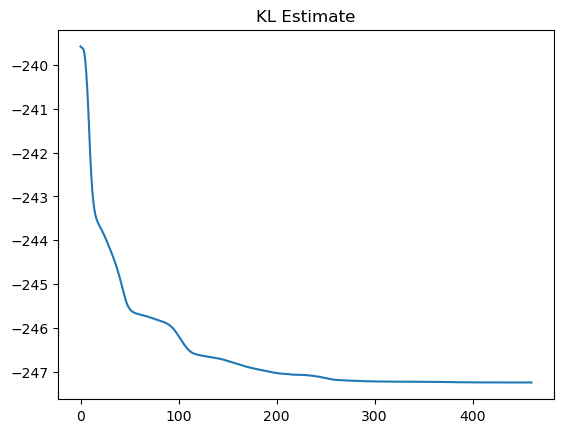

In [19]:
wass_kl_df = pd.DataFrame(np.array(KL_all))
plt.figure()
wass_kl_df.plot(title = 'KL Estimate', legend = False)

In [23]:
# Save the list of arrays to a file using np.save
np.save('Lambda_list_toad.npy', Lambda_list)

In [22]:
Lambda_list = np.load('Lambda_list_toad.npy', allow_pickle=True)

In [23]:
len(Lambda_list)

461

In [24]:
# Transform from original validation using transformations
wass_val_n_summary_statistics = scaler.transform(val_n_summary_statistics)
for i in range(len(Lambda_list)):
    wass_val_n_summary_statistics = transform_auto(Lambda_list[i], wass_val_n_summary_statistics)[0]
    transformed_val_n_summary_statistics = wass_val_n_summary_statistics

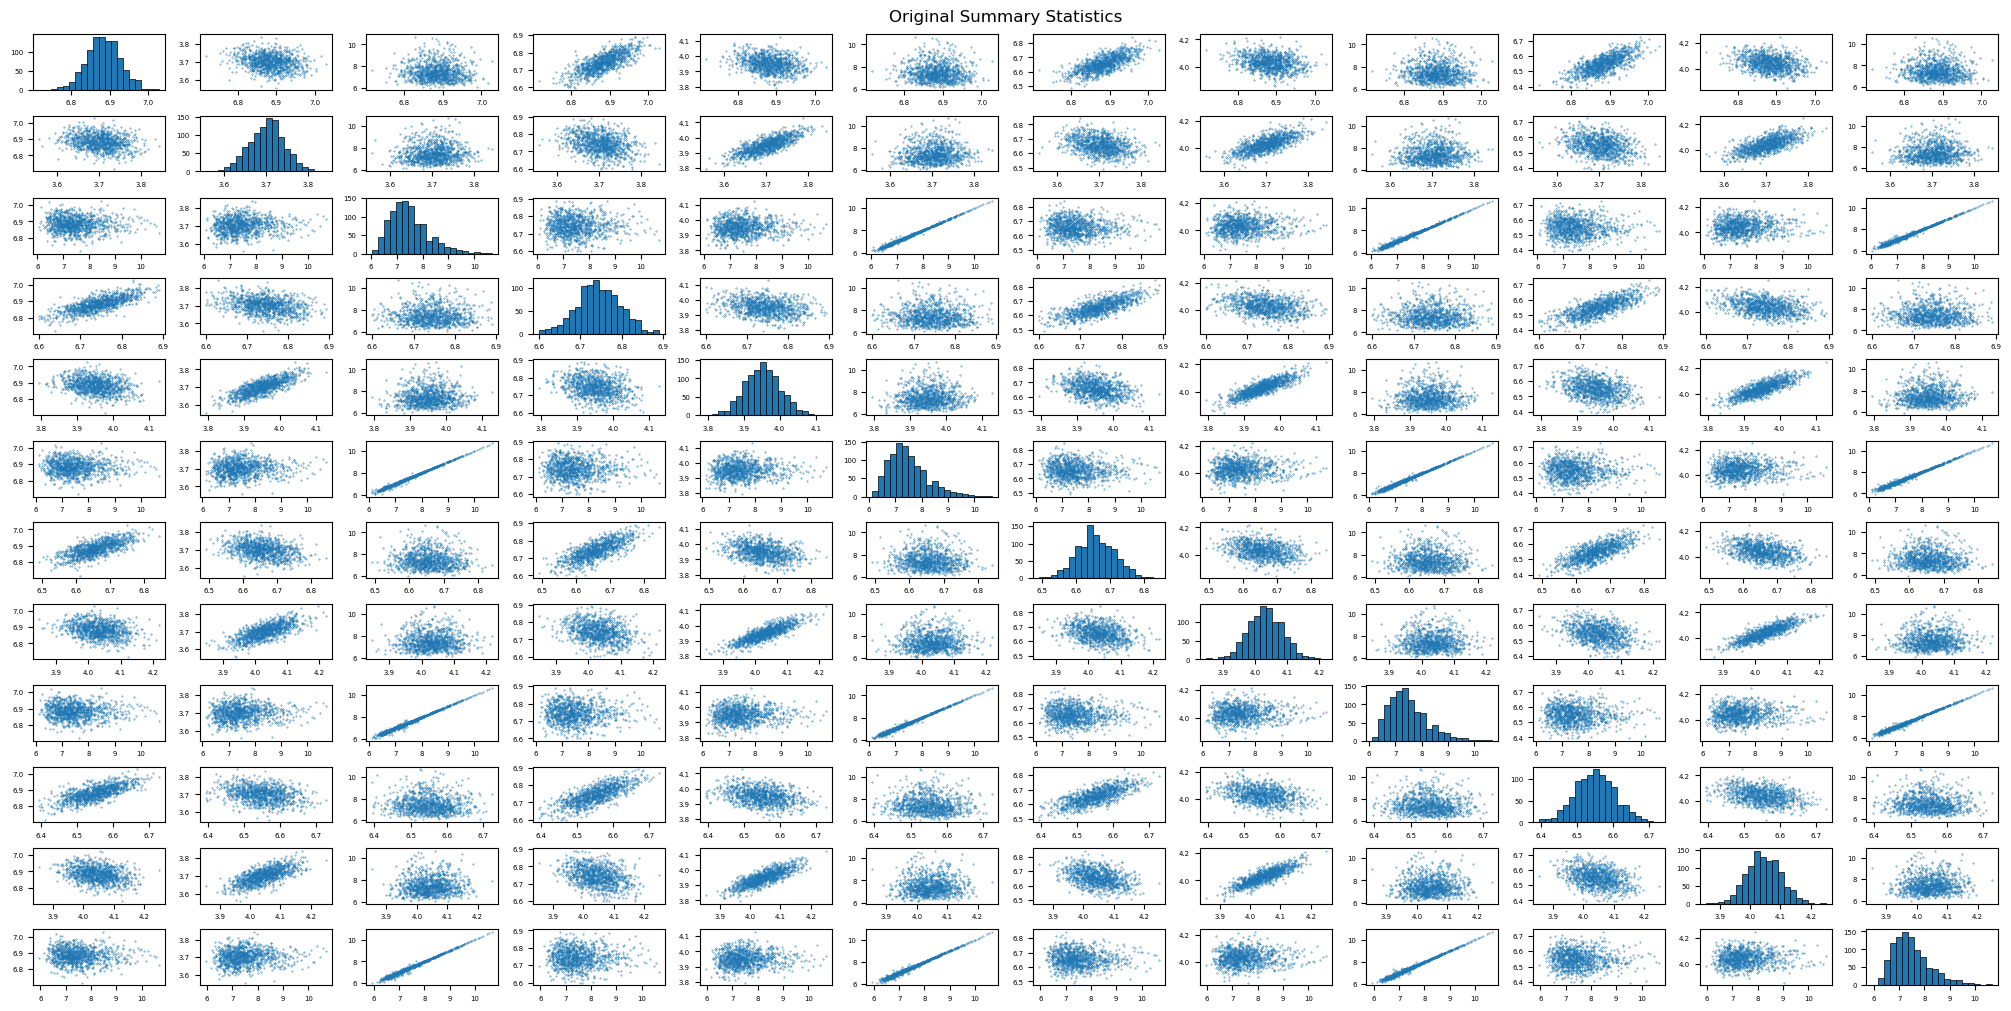

In [21]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(12, 12, figsize=(20,10), constrained_layout=True)

# For Sine Function
for x in range(12):
    for y in range(12):
        if x != y:
            axis[x, y].scatter(val_n_summary_statistics[:1000,x], val_n_summary_statistics[:1000,y], s = 0.1)
            axis[x, y].tick_params(axis='both', which='major', labelsize=5)
        else:
            axis[x, y].hist(val_n_summary_statistics[:1000,x], bins = 20, edgecolor='black', linewidth=0.5)
            axis[x, y].tick_params(axis='both', which='major', labelsize=5)

# Combine all the operations and display
figure.suptitle('Original Summary Statistics')
plt.show()

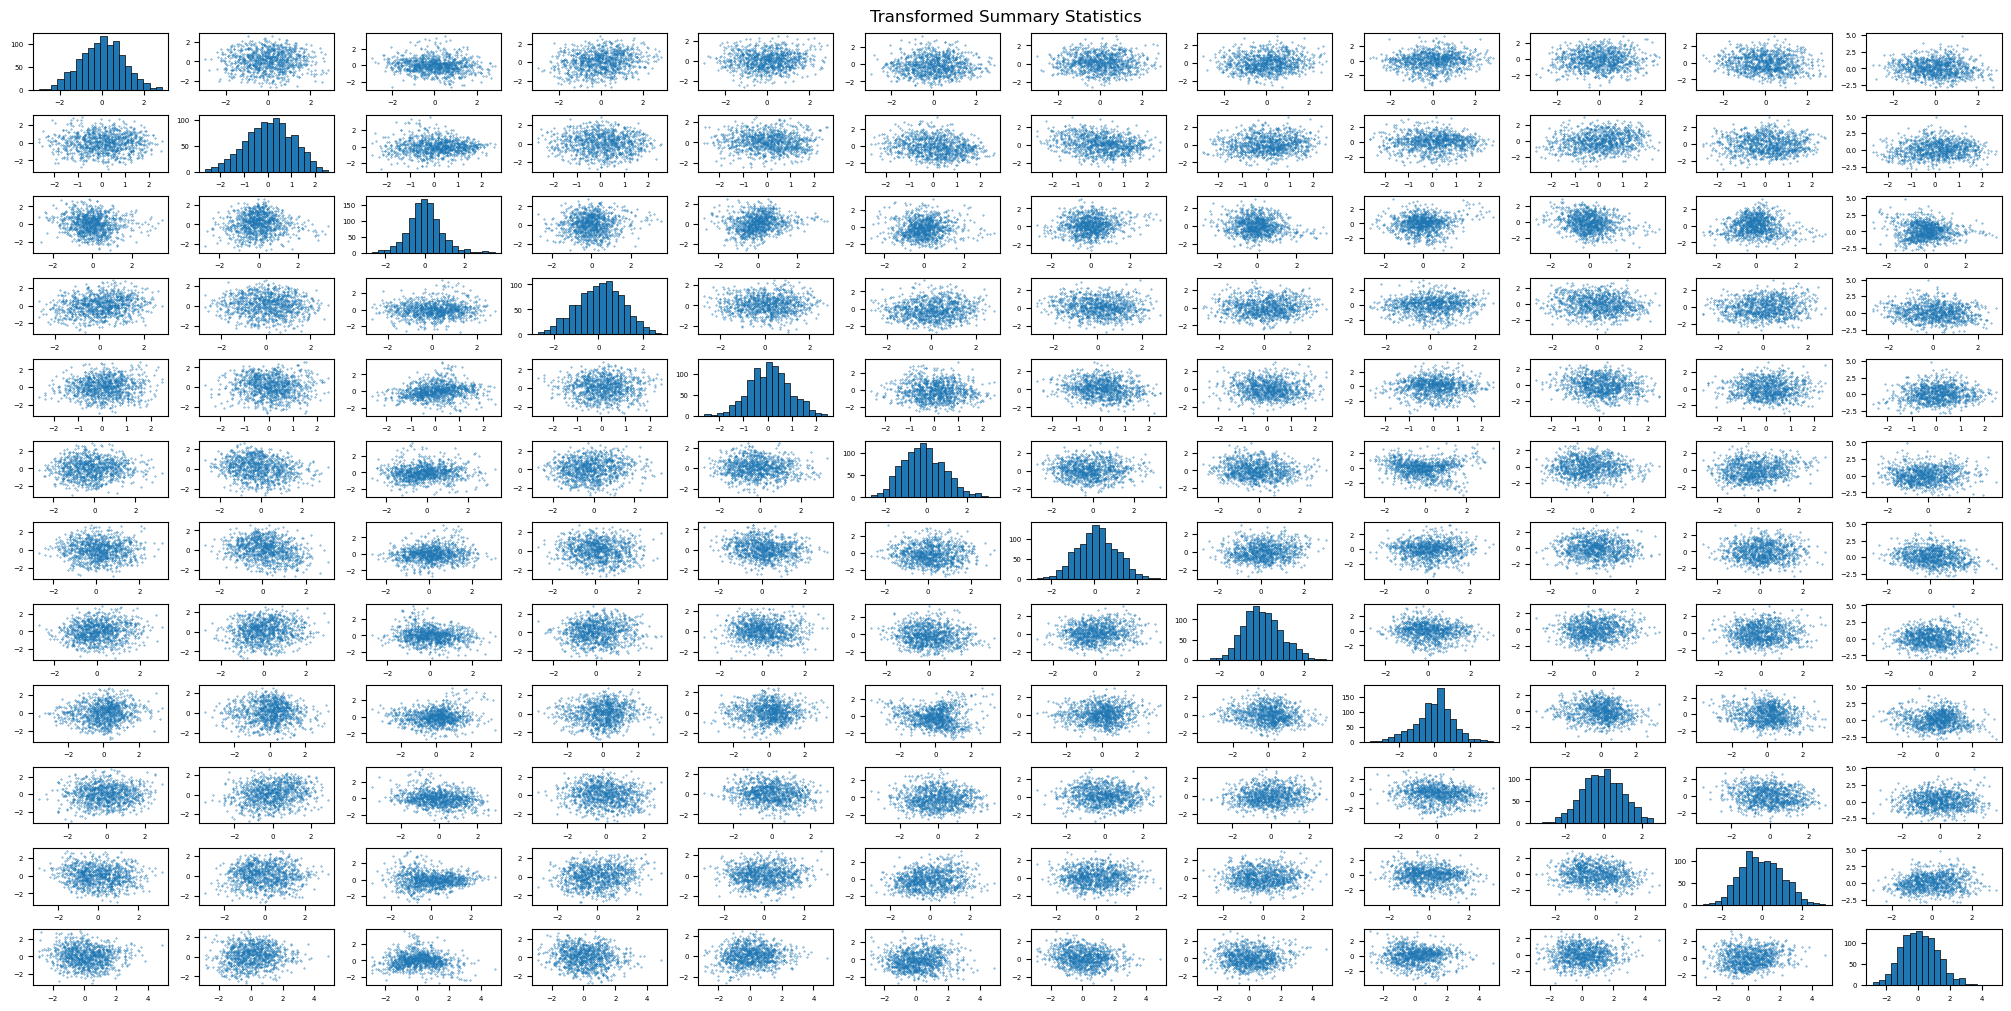

In [22]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(12, 12, figsize=(20,10), constrained_layout=True)

# For Sine Function
for x in range(12):
    for y in range(12):
        if x != y:
            axis[x, y].scatter(transformed_val_n_summary_statistics[:1000,x], transformed_val_n_summary_statistics[:1000,y], s = 0.1)
            axis[x, y].tick_params(axis='both', which='major', labelsize=5)
        else:
            axis[x, y].hist(transformed_val_n_summary_statistics[:1000,x], bins = 20, edgecolor='black', linewidth=0.5)
            axis[x, y].tick_params(axis='both', which='major', labelsize=5)

# Combine all the operations and display
figure.suptitle('Transformed Summary Statistics')
plt.show()

In [12]:
def normality_test(array1, array2, array3):
    from scipy.stats import mstats
    multivariate_data = np.hstack((array1, array2, array3))
    # Perform Mardia's multivariate normality test
    test_statistic, p_value = mstats.normaltest(multivariate_data)

    # Set the significance level (alpha)
    alpha = 0.01

    # Interpret the results for array
    if p_value < alpha:
      if p_value == 0.0:
        min_p_value = np.finfo(float).tiny
        # Calculate the p-value, ensuring it's not smaller than the minimum
        p_value = max(np.finfo(float).eps, min_p_value)
        print(f"The data is not multivariate normally distributed (p-value = {p_value})")
      else:
        print(f"The data is not multivariate normally distributed (p-value = {p_value})")
    else:
        print(f"The data appears to be multivariate normally distributed (p-value = {p_value})")

# Define a function to remove outliers based on IQR
def remove_outliers_iqr(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 2 * IQR # 2 times the standard deviation of the data
    upper_bound = Q3 + 2 * IQR
    return data[(data >= lower_bound) & (data <= upper_bound)]

# For original summary statistics
normality_test(val_n_summary_statistics[:,0], val_n_summary_statistics[:,1], val_n_summary_statistics[:,2])
normality_test(val_n_summary_statistics[:,2], val_n_summary_statistics[:,3])
normality_test(val_n_summary_statistics[:,1], val_n_summary_statistics[:,3])
normality_test(val_n_summary_statistics[:,0], val_n_summary_statistics[:,3])

# For transformed summary statistics
# Remove outliers
array1 = remove_outliers_iqr(transformed_val_n_summary_statistics[:,0])
array2 = remove_outliers_iqr(transformed_val_n_summary_statistics[:,1])
array3 = remove_outliers_iqr(transformed_val_n_summary_statistics[:,2])
array4 = remove_outliers_iqr(transformed_val_n_summary_statistics[:,3])

normality_test(array1, array2)
normality_test(array3, array4)
normality_test(array2, array4)
normality_test(array1, array4)

The data is not multivariate normally distributed (p-value = 2.220446049250313e-16)


TypeError: normality_test() missing 1 required positional argument: 'array3'

In [ ]:
# # Initialise the subplot function using number of rows and columns
# figure, axis = plt.subplots(12, 12, figsize=(20,10), constrained_layout=True)

# # For Sine Function
# for x in range(12):
#     for y in range(12):
#         if x != y:
#             axis[x, y].scatter(original_n_summary_statistics[:,x+12], original_n_summary_statistics[:,y+12], s = 0.1)
#             axis[x, y].tick_params(axis='both', which='major', labelsize=5)
#         else:
#             axis[x, y].hist(original_n_summary_statistics[:,x+12], bins = 20, edgecolor='black', linewidth=0.5)
#             axis[x, y].tick_params(axis='both', which='major', labelsize=5)

# # Combine all the operations and display
# figure.suptitle('Original Summary Statistics')
# plt.show()

In [ ]:
# # Initialise the subplot function using number of rows and columns
# figure, axis = plt.subplots(12, 12, figsize=(20,10), constrained_layout=True)

# # For Sine Function
# for x in range(12):
#     for y in range(12):
#         if x != y:
#             axis[x, y].scatter(original_n_summary_statistics[:,x+24], original_n_summary_statistics[:,y+24], s = 0.1)
#             axis[x, y].tick_params(axis='both', which='major', labelsize=5)
#         else:
#             axis[x, y].hist(original_n_summary_statistics[:,x+24], bins = 20, edgecolor='black', linewidth=0.5)
#             axis[x, y].tick_params(axis='both', which='major', labelsize=5)

# # Combine all the operations and display
# figure.suptitle('Original Summary Statistics')
# plt.show()

In [ ]:
# # Initialise the subplot function using number of rows and columns
# figure, axis = plt.subplots(12, 12, figsize=(20,10), constrained_layout=True)

# # For Sine Function
# for x in range(12):
#     for y in range(12):
#         if x != y:
#             axis[x, y].scatter(original_n_summary_statistics[:,x+36], original_n_summary_statistics[:,y+36], s = 0.1)
#             axis[x, y].tick_params(axis='both', which='major', labelsize=5)
#         else:
#             axis[x, y].hist(original_n_summary_statistics[:,x+36], bins = 20, edgecolor='black', linewidth=0.5)
#             axis[x, y].tick_params(axis='both', which='major', labelsize=5)

# # Combine all the operations and display
# figure.suptitle('Original Summary Statistics')
# plt.show()

In [ ]:
# # Initialise the subplot function using number of rows and columns
# figure, axis = plt.subplots(12, 12, figsize=(20,10), constrained_layout=True)

# # For Sine Function
# for x in range(12):
#     for y in range(12):
#         if x != y:
#             axis[x, y].scatter(wass_n_summary_statistics[:,x+12], wass_n_summary_statistics[:,y+12], s = 0.1)
#             axis[x, y].tick_params(axis='both', which='major', labelsize=5)
#         else:
#             axis[x, y].hist(wass_n_summary_statistics[:,x+12], bins = 20, edgecolor='black', linewidth=0.5)
#             axis[x, y].tick_params(axis='both', which='major', labelsize=5)

# # Combine all the operations and display
# figure.suptitle('Transformed Summary Statistics')
# plt.show()

In [ ]:
# # Initialise the subplot function using number of rows and columns
# figure, axis = plt.subplots(12, 12, figsize=(20,10), constrained_layout=True)

# # For Sine Function
# for x in range(12):
#     for y in range(12):
#         if x != y:
#             axis[x, y].scatter(wass_n_summary_statistics[:,x+24], wass_n_summary_statistics[:,y+24], s = 0.1)
#             axis[x, y].tick_params(axis='both', which='major', labelsize=5)
#         else:
#             axis[x, y].hist(wass_n_summary_statistics[:,x+24], bins = 20, edgecolor='black', linewidth=0.5)
#             axis[x, y].tick_params(axis='both', which='major', labelsize=5)

# # Combine all the operations and display
# figure.suptitle('Transformed Summary Statistics')
# plt.show()

In [ ]:
# # Initialise the subplot function using number of rows and columns
# figure, axis = plt.subplots(12, 12, figsize=(20,10), constrained_layout=True)

# # For Sine Function
# for x in range(12):
#     for y in range(12):
#         if x != y:
#             axis[x, y].scatter(wass_n_summary_statistics[:,x+36], wass_n_summary_statistics[:,y+36], s = 0.1)
#             axis[x, y].tick_params(axis='both', which='major', labelsize=5)
#         else:
#             axis[x, y].hist(wass_n_summary_statistics[:,x+36], bins = 20, edgecolor='black', linewidth=0.5)
#             axis[x, y].tick_params(axis='both', which='major', labelsize=5)

# # Combine all the operations and display
# figure.suptitle('Transformed Summary Statistics')
# plt.show()

In [25]:
def nf_transform(Lambda_list, n_summary_statistics):
    n_summary_statistics = scaler.transform(n_summary_statistics)
    for i in range(len(Lambda_list)):
        n_summary_statistics = transform_auto(Lambda_list[i], n_summary_statistics)[0]
    return n_summary_statistics

## FIND THE BEST THETA (COEFFICIENTS) USING VB

In [58]:
# Functions must be imported for multiprocessing to work
from f_gradient_lb_mean_wasserstein_nuissance_toad import (fun_gradient_lb)

In [59]:
class GVB:
    def __init__(self, samples, actual_summary_statistics, learning_rate, threshold, l_threshold, adaptive_lr_1, adaptive_lr_2, t_w, Patience):
        self.samples = samples
        self.actual_summary_statistics = actual_summary_statistics
        self.num_datasets = 200 # number of datasets
        self.num_coeffs = 3 # number of coeffs
        self.lambda_dim = self.num_coeffs + int((self.num_coeffs * (self.num_coeffs + 1)) / 2)
        self.learning_rate = learning_rate
        self.threshold = threshold
        self.l_threshold = l_threshold
        self.adaptive_lr_1 = adaptive_lr_1
        self.adaptive_lr_2 = adaptive_lr_2
        self.t_w = t_w
        self.Patience = Patience

    def control_variates(self, Flat_grad_log_q, Flat_grad_lb):
        c = []
        stacked_gradient_lb = np.stack(Flat_grad_lb)
        stacked_gradient_log_q = np.stack(Flat_grad_log_q)
        for i in range(self.lambda_dim):
            sample_cov = np.cov((stacked_gradient_lb[:, i], stacked_gradient_log_q[:, i]))
            c_i = sample_cov[0, 1] / sample_cov[1, 1]
            c.append(c_i)
        c_mu = np.array(c[0:self.num_coeffs])
        c_vech_l = np.array(c[self.num_coeffs:])
        return np.array([c_mu, c_vech_l], dtype = object)

    def vb_posterior(self, stop):
        # Initialize mu_0, L_0
        # mu_0 = np.array([np.log((self.actual_summary_statistics[0]-1.1)/(2-self.actual_summary_statistics[0])), np.log((1+self.actual_summary_statistics[1])/(1-self.actual_summary_statistics[1])), np.log(self.actual_summary_statistics[2]), self.actual_summary_statistics[3]])
        #mu_0 = np.array([1.5, 0.5, 3, 0])
        mu_0 = np.array([np.log((true_theta[0] - 1)/(2 - true_theta[0])),np.log((true_theta[1] - 0)/(100 - true_theta[1])),np.log((true_theta[2] - 0)/(0.9 - true_theta[2]))])
        #mu_0 = np.array([self.actual_summary_statistics[0], self.actual_summary_statistics[1], self.actual_summary_statistics[2], self.actual_summary_statistics[3]])
        # mu_0 = np.array([0] * self.num_coeffs)
        # l_0 = np.array([[ 3.94992238, -2.12969451,  0.47239626],
        #                 [-2.12969451, 21.85908684, -1.45228054],
        #                 [ 0.47239626, -1.45228054, 15.84326737]])
        l_0 = np.tril(np.identity(self.num_coeffs) * 10)
        Sigma_0_inv = l_0 @ l_0.T
        Sigma_0 = my_inv(Sigma_0_inv)
        l_0_inv = my_inv(l_0)
        ### Change ways to get vech(l0)
        vech_l0 = l_0.T[np.triu_indices(self.num_coeffs)]

        lambda_0 = np.array([mu_0, vech_l0], dtype = object)
        lambda_q = lambda_0
        # Initilize best lambda
        lambda_best = lambda_0
        # List of Lambda
        Lambda = [lambda_0]
        # List of calculations of LB
        LB_all = []
        LB_Smoothed = []
        patience = 0
        for t in tqdm(range(stop)):
            if t == 0:        
                # Draw samples of theta from  variational q
                theta_0_samples = ss_multivariate_normal.rvs(mean = mu_0, cov = Sigma_0, size = self.samples)

                # Multiprocessing a function with several inputs
                results = pool.map(partial(fun_gradient_lb, theta_samples = theta_0_samples, mu_q = mu_0, l_q = l_0, c = 0, n_samples = n_samples, n_datasets= self.num_datasets, num_coeffs = self.num_coeffs, num_latent = num_latent, actual_summary_statistics = self.actual_summary_statistics), np.arange(self.samples)) 
                results = np.reshape(results, (self.samples, 4))
                Gradient_lb_init = results[:,0]
                lb_0 = results[:,1]
                Flattened_gradient_lb = results[:,2]
                Flattened_gradient_log_q = results[:,3]

                # Calculate control variates using all samples
                c = self.control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)
                # Update lambda_q
                self.g_init = np.mean(Gradient_lb_init, axis = 0)
                # Gradient clipping
                if np.linalg.norm(np.concatenate(self.g_init, axis = None)) > self.l_threshold:
                    self.g_init = self.l_threshold * self.g_init / np.linalg.norm(np.concatenate(self.g_init, axis = None))
                self.v_init = self.g_init ** 2
                # Calculate lower bound
                LB_all.append(np.mean(lb_0))
                print('LB', (np.mean(lb_0)))
                lambda_q = lambda_0

            if t > 0:
                # From lambda_q find mu_q and L_q
                mu_q = lambda_q[0]

                ### Change ways to convert from vech_l0 to l0
                vech_lq = list(lambda_q[1])
                l_q = np.zeros((self.num_coeffs, self.num_coeffs))
                # l_q[:, 0] = lambda_q[1][0:self.num_coeffs]
                # l_q[1:self.num_coeffs, 1] = lambda_q[1][4:7]
                # l_q[2:self.num_coeffs, 2] = lambda_q[1][7:9]
                # l_q[3:self.num_coeffs, 3] = lambda_q[1][9:10]
                for i in range(self.num_coeffs):
                    l_q[i:self.num_coeffs,i] = vech_lq[:self.num_coeffs - i]
                    del vech_lq[:self.num_coeffs-i]

                Sigma_q_inv = l_q @ l_q.T
                Sigma_q =  my_inv(Sigma_q_inv)
                l_q_inv =  my_inv(l_q)

                theta_q_samples = ss_multivariate_normal.rvs(mean = mu_q, cov = Sigma_q, size = self.samples)

                # Multiprocessing a function with several inputs
                results = pool.map(partial(fun_gradient_lb, theta_samples = theta_q_samples, mu_q = mu_q, l_q = l_q, c = c, n_samples = n_samples, n_datasets= self.num_datasets, num_coeffs = self.num_coeffs, num_latent = num_latent, actual_summary_statistics = self.actual_summary_statistics), np.arange(self.samples)) 
                results = np.reshape(results, (self.samples, 4))
                Gradient_lb = results[:,0]
                lb_t = results[:,1]
                Flattened_gradient_lb = results[:,2]
                Flattened_gradient_log_q = results[:,3]

                # Calculate control variates using all samples
                c = self.control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)

                # Calc gradient of h
                g_t = np.mean(Gradient_lb, axis = 0)
                # Gradient clipping
                if np.linalg.norm(np.concatenate(g_t, axis = None)) > self.l_threshold:
                    g_t = self.l_threshold * g_t / np.linalg.norm(np.concatenate(g_t, axis = None))
                v_t = g_t ** 2

                #---- Update lambda
                self.g_init = self.adaptive_lr_1 * self.g_init + (1 - self.adaptive_lr_1) * g_t
                self.v_init = self.adaptive_lr_2 * self.v_init + (1 - self.adaptive_lr_2) * v_t
                if t >= self.threshold:
                    update_t = self.learning_rate * self.threshold / t
                else:
                    update_t = self.learning_rate

                lambda_q = lambda_q + update_t * self.g_init / (self.v_init ** 0.5)
                Lambda.append(lambda_q)
                # Calculate lower bound
                LB_all.append(np.mean(lb_t))

                if t < self.t_w:
                    print('LB', np.mean(lb_t))

                if t >= self.t_w:
                    LB_smoothed = np.mean(LB_all[t - self.t_w + 1 : t])
                    print('LB Smoothed', LB_smoothed)
                    LB_Smoothed.append(LB_smoothed)
                    if LB_smoothed >= max(LB_Smoothed):
                        patience = 0
                        lambda_best = lambda_q
                    else:
                        patience += 1
                        if patience > self.Patience:
                            print("Stop at", t)
                            break

        return LB_all, LB_Smoothed, lambda_best

In [60]:
actual_summary_statistics = np.reshape(actual_summary_statistics, (1, len(actual_summary_statistics)))
actual_summary_statistics

array([[6.87109129, 3.68338231, 6.83350614, 6.77422389, 3.97921896,
        6.84963482, 6.67076632, 4.01888279, 6.7972886 , 6.56807791,
        4.03037588, 6.79390669]])

## RUN VB AND PRINT OUT VARIATIONAL PARAMS

In [61]:
# Set hyperparameters
stop = 5000
transformed_summary_statistics = nf_transform(Lambda_list, actual_summary_statistics)
transformed_summary_statistics[0]

Array([-1.1134305 , -0.65840936,  0.50530636,  0.714674  ,  1.0314736 ,
        0.8401437 , -0.00335057, -0.37927577, -2.6821873 ,  0.08398013,
        0.4137839 , -0.20518659], dtype=float32)

In [62]:
vb = GVB(200, transformed_summary_statistics[0], 0.005, 2500, 100, 0.9, 0.9, 50, 50)
LB_estimate, smoothed_LB_estimate, best_lambda = vb.vb_posterior(stop)

  0%|          | 0/5000 [00:00<?, ?it/s]Exception in thread Thread-11:
Traceback (most recent call last):
  File "/home/megannguyen/miniconda3/envs/vbsl/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    self.run()
  File "/home/megannguyen/miniconda3/envs/vbsl/lib/python3.9/threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "/home/megannguyen/miniconda3/envs/vbsl/lib/python3.9/multiprocessing/pool.py", line 576, in _handle_results
    task = get()
  File "/home/megannguyen/miniconda3/envs/vbsl/lib/python3.9/multiprocessing/connection.py", line 251, in recv
    return _ForkingPickler.loads(buf.getbuffer())
  File "/home/megannguyen/miniconda3/envs/vbsl/lib/python3.9/site-packages/jax/_src/errors.py", line 360, in __init__
    f"the JAX Tracer object {tracer}{tracer._origin_msg()}")
AttributeError: 'str' object has no attribute '_origin_msg'
  0%|          | 0/5000 [00:24<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
LB_estimate

[-1950.9449321197233,
 -1864.973037546015,
 -1837.8836798828704,
 -1822.4160924210644,
 -1841.3128636818326,
 -1855.6936924485399,
 -1724.590642829001,
 -1731.7486563666719,
 -1890.2294335752856,
 -1926.5140169199685,
 -1889.6832155416334,
 -1872.975498000037,
 -1798.2028212765854,
 -1730.1842188480236,
 -1763.9556797893988,
 -1806.4968041226248,
 -1807.4721743282075,
 -1916.7458414717871,
 -1871.1023582240452,
 -1807.4099285116567,
 -1908.7251542694821,
 -1843.2861923224073,
 -1710.2353252226112,
 -1816.9780160876821,
 -1814.468838515514,
 -1859.3553724029684,
 -1886.7400085252543,
 -1856.6429588535725,
 -1768.4612017384318,
 -1794.8803372100404,
 -1838.3947596533628,
 -1779.2983201698382,
 -1847.5354889643922,
 -1706.0153490534994,
 -1867.2839073133334,
 -1749.6288720934795,
 -1765.7533414831182,
 -1741.0227612287083,
 -1755.6079623831035,
 -1807.1753537227712,
 -1766.973175145899,
 -1818.1778303223127,
 -1784.5698628961175,
 -1781.7976081020304,
 -1728.7805762957037,
 -1846.12170591

In [ ]:
smoothed_LB_estimate

[-1808.604706857372,
 -1806.9445634639364,
 -1805.4800575052657,
 -1803.0016647506427,
 -1800.4126340590183,
 -1800.0041797646604,
 -1799.821187756489,
 -1801.9360726897903,
 -1798.6074078994957,
 -1794.3238243703586,
 -1789.8246179650034,
 -1786.6580112595539,
 -1784.422743863536,
 -1786.2900321505845,
 -1787.2580434735169,
 -1783.8033812988863,
 -1784.2373732146432,
 -1782.1397397638466,
 -1778.65846885349,
 -1776.6344683111308,
 -1772.44144242142,
 -1770.0265210080356,
 -1769.945744031729,
 -1767.6931497688627,
 -1765.486399474866,
 -1763.0959768814662,
 -1759.4959038811066,
 -1756.4058325990948,
 -1757.3788024790451,
 -1756.1150350244354,
 -1754.4036520509949,
 -1754.0074536111797,
 -1750.8069070747206,
 -1750.0876993662487,
 -1747.1794368404944,
 -1746.0953024069452,
 -1744.4936101403089,
 -1742.9507742167448,
 -1741.9110666362724,
 -1740.4163007566974,
 -1739.4129132177454,
 -1737.8038790628236,
 -1736.3636959615505,
 -1737.1243483206783,
 -1738.1429913704762,
 -1735.036757799111

In [ ]:
best_lambda

array([array([-0.19111364, -0.68873718,  1.10984556]),
       array([10.16208597, -1.87522154,  0.53552541, 13.99186478, -1.81754749,
              10.7442985 ])                                                   ],
      dtype=object)

In [ ]:
# best_lambda_untransformed = np.array([np.array([-0.91025911,  0.43886716, -0.20901338, -0.17942595]),
#        np.array([11.07381326,  2.14421862,  0.67079883,  1.41588884,  7.3952956 ,
#               -0.58787869, -1.87596932,  9.91166966,  0.8760482 , 12.06295651])],
#       dtype=object)

In [ ]:
# best_lambda_wass = np.array([np.array([-0.84637604,  0.49732016, -0.20861551, -0.133564  ]),
#        np.array([13.2584442 ,  3.25839391,  3.25834736,  3.25839328,  6.74077997,
#               -3.25922636, -3.25923237, 13.22206768,  3.16039998, 13.20576727])],
#       dtype=object)

## PLOT DENSITY PLOT OF ALL COEFFS


<AxesSubplot: title={'center': 'Lower Bound Estimate'}>

<Figure size 640x480 with 0 Axes>

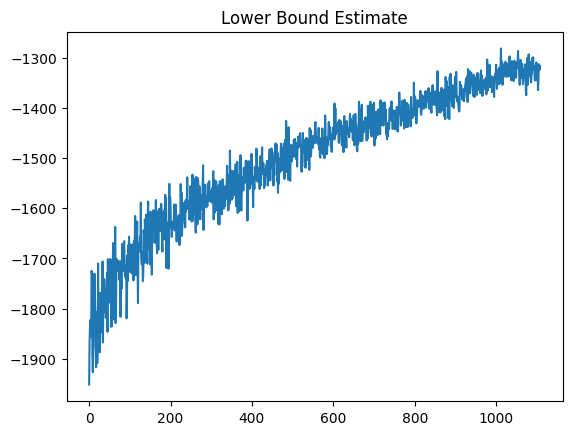

In [ ]:
lb_df = pd.DataFrame(np.array(LB_estimate))
plt.figure()
lb_df.plot(title = 'Lower Bound Estimate', legend = False)

<AxesSubplot: title={'center': 'Smoothed Lower Bound Estimate'}>

<Figure size 640x480 with 0 Axes>

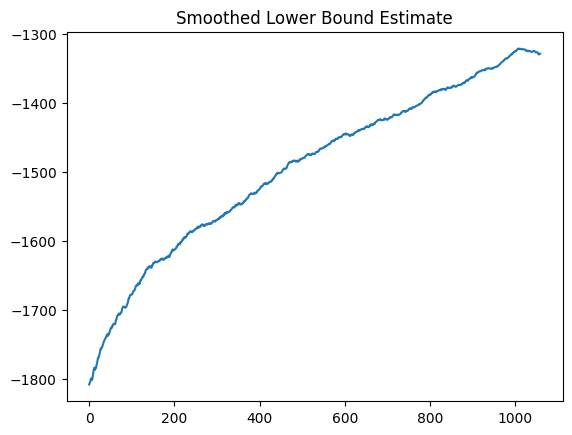

In [ ]:
lb_df = pd.DataFrame(np.array(smoothed_LB_estimate))
plt.figure()
lb_df.plot(title = 'Smoothed Lower Bound Estimate', legend = False)

In [ ]:
best_mu = best_lambda[0]
best_vech_l = list(best_lambda[1])
best_l = np.zeros((num_coeffs, num_coeffs))
for i in range(num_coeffs):
    best_l[i:num_coeffs,i] = best_vech_l[:num_coeffs - i]
    del best_vech_l[:num_coeffs-i]
best_Sigma_inv = best_l @ best_l.T
best_Sigma =  np.linalg.inv(best_Sigma_inv)

best_theta_tilde = multivariate_normal.rvs(mean = best_mu, cov = best_Sigma, size = 100000)
best_alpha = (2 * np.exp(best_theta_tilde[:,0]) + 1) / (1 + np.exp(best_theta_tilde[:,0]))
best_beta = (100 * np.exp(best_theta_tilde[:,1]) + 0) / (np.exp(best_theta_tilde[:,1]) + 1)
best_gamma = (0.9 * np.exp(best_theta_tilde[:,2]) + 0) / (np.exp(best_theta_tilde[:,2]) + 1)
best_theta = np.array([best_alpha, best_beta, best_gamma])
posterior_mean_estimate = np.mean(best_theta, axis = 1)
posterior_mean_estimate

array([ 1.45258664, 33.45669303,  0.67648741])

In [ ]:
# best_mu_untransformed = best_lambda_untransformed[0]
# best_vech_l_untransformed = list(best_lambda_untransformed[1])
# best_l_untransformed = np.zeros((num_coeffs, num_coeffs))
# for i in range(num_coeffs):
#     best_l_untransformed[i:num_coeffs,i] = best_vech_l_untransformed[:num_coeffs - i]
#     del best_vech_l_untransformed[:num_coeffs-i]
# best_Sigma_untransformed =  np.linalg.inv(best_l_untransformed @ best_l_untransformed.T)

# best_theta_tilde_untransformed = multivariate_normal.rvs(mean = best_mu_untransformed, cov = best_Sigma_untransformed, size = 1000)
# best_alpha_untransformed = (2 * np.exp(best_theta_tilde_untransformed[:,0]) + 1.1) / (1 + np.exp(best_theta_tilde_untransformed[:,0]))
# best_beta_untransformed = (np.exp(best_theta_tilde_untransformed[:,1]) - 1) / (np.exp(best_theta_tilde_untransformed[:,1]) + 1)
# best_gamma_untransformed = np.exp(best_theta_tilde_untransformed[:,2])
# best_delta_untransformed = best_theta_tilde_untransformed[:,3]
# best_theta_untransformed = np.array([best_alpha_untransformed, best_beta_untransformed, best_gamma_untransformed, best_delta_untransformed])
# posterior_mean_estimate_untransformed = np.mean(best_theta_untransformed, axis = 1)
# posterior_mean_estimate_untransformed

In [ ]:
# best_mu_wass = best_lambda_wass[0]
# best_vech_l_wass = list(best_lambda_wass[1])
# best_l_wass = np.zeros((num_coeffs, num_coeffs))
# for i in range(num_coeffs):
#     best_l_wass[i:num_coeffs,i] = best_vech_l_wass[:num_coeffs - i]
#     del best_vech_l_wass[:num_coeffs-i]
# best_Sigma_wass =  np.linalg.inv(best_l_wass @ best_l_wass.T)

# best_theta_tilde_wass = multivariate_normal.rvs(mean = best_mu_wass, cov = best_Sigma_wass, size = 1000)
# best_alpha_wass = (2 * np.exp(best_theta_tilde_wass[:,0]) + 1.1) / (1 + np.exp(best_theta_tilde_wass[:,0]))
# best_beta_wass = (np.exp(best_theta_tilde_wass[:,1]) - 1) / (np.exp(best_theta_tilde_wass[:,1]) + 1)
# best_gamma_wass = np.exp(best_theta_tilde_wass[:,2])
# best_delta_wass = best_theta_tilde_wass[:,3]
# best_theta_wass = np.array([best_alpha_wass, best_beta_wass, best_gamma_wass, best_delta_wass])
# posterior_mean_estimate_wass = np.mean(best_theta_wass, axis = 1)
# posterior_mean_estimate_wass

Text(0.5, 1.0, 'Posterior density of alpha')

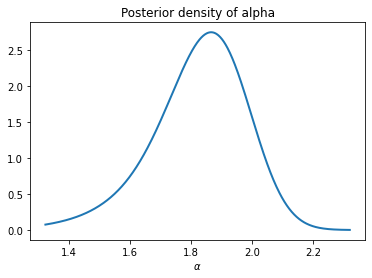

In [ ]:
plt.figure()
x_plot = np.arange((np.mean(best_alpha)-4*np.std(best_alpha)), (np.mean(best_alpha)+4*np.std(best_alpha)), 0.002)
kde = KernelDensity(bandwidth=0.1, kernel='gaussian')
kde.fit(best_alpha.reshape(-1, 1))
y_plot = kde.score_samples(x_plot.reshape(-1, 1))
plt.plot(x_plot, np.exp(y_plot), '-', linewidth=2.0)
plt.xlabel(r'$\alpha$')
plt.title('Posterior density of alpha')

In [ ]:
# plt.figure()
# #x_plot_mcmc = np.arange((pos_alpha_mean-4*pos_alpha_std), (pos_alpha_mean+4*pos_alpha_std), 0.002)
# x_plot = np.arange(min(np.mean(best_alpha_untransformed)-4*np.std(best_alpha_untransformed),np.mean(best_alpha)-4*np.std(best_alpha)), max(np.mean(best_alpha_untransformed)+4*np.std(best_alpha_untransformed), np.mean(best_alpha)+4*np.std(best_alpha)), 0.001)

# kde_vb = KernelDensity(bandwidth=0.0055, kernel='gaussian')
# kde_vb.fit(best_alpha.reshape(-1, 1))
# y_plot_vb = kde_vb.score_samples(x_plot.reshape(-1, 1))

# #x_plot_vb = np.arange((np.mean(best_alpha)-4*np.std(best_alpha)), (np.mean(best_alpha)+4*np.std(best_alpha)), 0.002)
# kde_vb_untransformed = KernelDensity(bandwidth=0.01, kernel='gaussian')
# kde_vb_untransformed.fit(best_alpha_untransformed.reshape(-1, 1))
# y_plot_vb_untransformed = kde_vb_untransformed.score_samples(x_plot.reshape(-1, 1))

# kde_vb_wass = KernelDensity(bandwidth=0.01, kernel='gaussian')
# kde_vb_wass.fit(best_alpha_wass.reshape(-1, 1))
# y_plot_vb_wass = kde_vb_wass.score_samples(x_plot.reshape(-1, 1))

# plt.plot(x_plot, np.exp(y_plot_vb_untransformed), '-', linewidth=2.0, label = 'VB - BSL')
# plt.plot(x_plot, np.exp(y_plot_vb_wass), '-', linewidth=2.0, label = 'WG - VB - BSL')
# plt.plot(x_plot, np.exp(y_plot_vb), '-', linewidth=2.0, label = 'VB - rBSL')
# # only one line may be specified; full height
# plt.axvline(x = 1.5, ymin = 0, ymax = max(y_plot_vb_untransformed), color = 'black', label = 'True alpha')

# plt.legend()
# plt.xlabel(r'$\alpha$')
# plt.title('Posterior density of alpha')


Text(0.5, 1.0, 'Posterior density of beta')

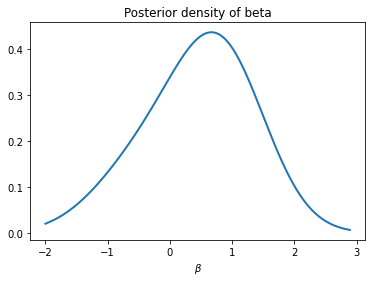

In [ ]:
plt.figure()
x_plot = np.arange((np.mean(best_beta)-4*np.std(best_beta)), (np.mean(best_beta)+4*np.std(best_beta)), 0.002)
kde = KernelDensity(bandwidth=0.7, kernel='gaussian')
kde.fit(best_beta.reshape(-1, 1))
y_plot = kde.score_samples(x_plot.reshape(-1, 1))
plt.plot(x_plot, np.exp(y_plot), '-', linewidth=2.0)
plt.xlabel(r'$\beta$')
plt.title('Posterior density of beta')

Text(0.5, 1.0, 'Posterior density of gamma')

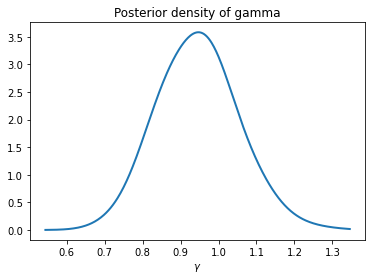

In [ ]:
plt.figure()
x_plot = np.arange((np.mean(best_gamma)-4*np.std(best_gamma)), (np.mean(best_gamma)+4*np.std(best_gamma)), 0.002)
kde = KernelDensity(bandwidth=0.05, kernel='gaussian')
kde.fit(best_gamma.reshape(-1, 1))
y_plot = kde.score_samples(x_plot.reshape(-1, 1))
plt.plot(x_plot, np.exp(y_plot), '-', linewidth=2.0)
plt.xlabel(r'$\gamma$')
plt.title('Posterior density of gamma')

## VBSL-WG

In [ ]:
def prior(theta): 
    log_prior = np.sum(np.log(np.exp(theta) / (1 + np.exp(theta))**2))
    return log_prior

In [ ]:
def summary_statistics(theta, n_samples, n_datasets, mixture_obj_seq):
    datasets = toad(theta[0], theta[1], theta[2],batch_size=n_datasets)
    n_summary_statistics = np.array([compute_summaries_stacked(datasets[:,:,i], lags)[0] for i in range(n_datasets)])
    # Wasserstein transform
    transformed_summary_statistics = wasserstein_transform(mixture_obj_seq, n_summary_statistics)

    sample_mean = np.mean(transformed_summary_statistics, axis = 0)
    sample_variance = np.cov(np.array(transformed_summary_statistics).T)
    return sample_mean, sample_variance

def unbiased_log_likelihood(theta, actual_summary_statistics):
    ss = summary_statistics(theta, n_samples, num_datasets, mixture_obj_seq)
    sample_mean = ss[0]
    sample_variance = ss[1]
    diff_mean_s = actual_summary_statistics - sample_mean
    part1 = diff_mean_s.T @ np.linalg.inv(sample_variance) @ diff_mean_s
    # u_est_log_likelihood = -1/2 * np.log(np.linalg.det(sample_variance)) - (self.num_datasets - self.num_coeffs - 2) / (2 * (self.num_datasets-1)) * part1
    u_est_log_likelihood = -1/2 * np.log(np.linalg.det(sample_variance)) - part1
    return u_est_log_likelihood

In [ ]:
class GVB:
    def __init__(self, samples, actual_summary_statistics, learning_rate, threshold, l_threshold, adaptive_lr_1, adaptive_lr_2, t_w, Patience):
        self.samples = samples
        self.actual_summary_statistics = actual_summary_statistics
        self.num_datasets = 200 # number of datasets
        self.num_coeffs = 3 # number of coeffs
        self.lambda_dim = self.num_coeffs + int((self.num_coeffs * (self.num_coeffs + 1)) / 2)
        self.learning_rate = learning_rate
        self.threshold = threshold
        self.l_threshold = l_threshold
        self.adaptive_lr_1 = adaptive_lr_1
        self.adaptive_lr_2 = adaptive_lr_2
        self.t_w = t_w
        self.Patience = Patience

    def log_q(self, theta, mu, l):
        log_q = multivariate_normal.logpdf(theta, mean = mu, cov= np.linalg.inv(l @ l.T))
        return log_q

    def gradient_log_q(self, theta, mu, l): #indep theta
        gradient_log_q_mu = np.matmul(np.matmul(l, l.T), (theta - mu))
        diag_inv_l = np.zeros((num_coeffs, num_coeffs))
        np.fill_diagonal(diag_inv_l, np.diag(np.linalg.inv(l)))
        gradient_log_q_l = (diag_inv_l - np.reshape(theta - mu, (num_coeffs,1)) @ np.reshape(theta - mu, (1,num_coeffs)) @ l).T[np.triu_indices(num_coeffs)] #use * because matmul gives scalar 
        gradient_log_q = np.array([gradient_log_q_mu, gradient_log_q_l], dtype=object)
        return gradient_log_q

    def control_variates(self, Flat_grad_log_q, Flat_grad_lb):
        c = []
        stacked_gradient_lb = np.stack(Flat_grad_lb)
        stacked_gradient_log_q = np.stack(Flat_grad_log_q)
        for i in range(self.lambda_dim):
            sample_cov = np.cov((stacked_gradient_lb[:, i], stacked_gradient_log_q[:, i]))
            c_i = sample_cov[0, 1] / sample_cov[1, 1]
            c.append(c_i)
        c_mu = np.array(c[0:self.num_coeffs])
        c_vech_l = np.array(c[self.num_coeffs:])
        return np.array([c_mu, c_vech_l], dtype = object)

    def vb_posterior(self, stop):
        # Initialize mu_0, L_0
        # mu_0 = np.array([np.log((self.actual_summary_statistics[0]-1.1)/(2-self.actual_summary_statistics[0])), np.log((1+self.actual_summary_statistics[1])/(1-self.actual_summary_statistics[1])), np.log(self.actual_summary_statistics[2]), self.actual_summary_statistics[3]])
        #mu_0 = np.array([1.5, 0.5, 3, 0])
        # mu_0 = np.array([np.log((true_theta[0] - 1)/(2 - true_theta[0])),np.log((true_theta[1] - 0)/(100 - true_theta[1])),np.log((true_theta[2] - 0)/(0.9 - true_theta[2]))])
        #mu_0 = np.array([self.actual_summary_statistics[0], self.actual_summary_statistics[1], self.actual_summary_statistics[2], self.actual_summary_statistics[3]])
        mu_0 = np.array([0] * self.num_coeffs)
        # l_0 = np.array([[ 3.94992238, -2.12969451,  0.47239626],
        #                 [-2.12969451, 21.85908684, -1.45228054],
        #                 [ 0.47239626, -1.45228054, 15.84326737]])
        l_0 = np.tril(np.identity(self.num_coeffs) * 10)
        Sigma_0_inv = l_0 @ l_0.T
        Sigma_0 = np.linalg.inv(Sigma_0_inv)
        l_0_inv = np.linalg.inv(l_0)
        ### Change ways to get vech(l0)
        vech_l0 = l_0.T[np.triu_indices(self.num_coeffs)]

        lambda_0 = np.array([mu_0, vech_l0], dtype = object)
        lambda_q = lambda_0
        # Initilize best lambda
        lambda_best = lambda_0
        # List of Lambda
        Lambda = [lambda_0]
        # List of calculations of LB
        LB_all = []
        LB_Smoothed = []
        patience = 0
        # List of flattened gradients
        Flattened_gradient_lb = []
        Flattened_gradient_log_q = []
        for t in tqdm(range(stop)):
            if t == 0:        
                # Draw samples of theta from  variational q
                # List of gradients
                Gradient_lb_init = []
                lb_0 = []
                theta_0_samples = multivariate_normal.rvs(mean = mu_0, cov = Sigma_0, size = self.samples)
                for s in tqdm(range(self.samples)):
                    # True params have been reparam into epsilon
                    theta_tilde_0 = theta_0_samples[s]
                    alpha_0 = (2 * np.exp(theta_tilde_0[0]) + 1) / (1 + np.exp(theta_tilde_0[0]))
                    beta_0 = (100 * np.exp(theta_tilde_0[1]) + 0) / (1 + np.exp(theta_tilde_0[1]))
                    gamma_0 = (0.9 * np.exp(theta_tilde_0[2]) + 0) / (1 + np.exp(theta_tilde_0[2]))
                    theta_0 = np.array([alpha_0, beta_0, gamma_0])
                    
                    # Find gradient of LB
                    h_lambda_init = prior(theta_tilde_0) + unbiased_log_likelihood(theta_0, self.actual_summary_statistics) - self.log_q(theta_tilde_0, mu_0, l_0)
                    gradient_lb_init = self.gradient_log_q(theta_tilde_0, mu_0, l_0) * (h_lambda_init)
                    Gradient_lb_init.append(gradient_lb_init)
                    # Calculate control variates
                    flattened_gradient_log_q = np.concatenate((self.gradient_log_q(theta_tilde_0, mu_0, l_0)[0], self.gradient_log_q(theta_tilde_0, mu_0, l_0)[1]), axis = None)
                    Flattened_gradient_log_q.append(flattened_gradient_log_q)
                    flattened_gradient_lb = np.concatenate((gradient_lb_init[0], gradient_lb_init[1]), axis = None)
                    Flattened_gradient_lb.append(flattened_gradient_lb)
                    # Calculate lower bound
                    lb_0.append(h_lambda_init)
                # Calculate control variates using all samples
                c = self.control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)
                # Update lambda_q
                self.g_init = np.mean(Gradient_lb_init, axis = 0)
                # Gradient clipping
                if np.linalg.norm(np.concatenate(self.g_init, axis = None)) > self.l_threshold:
                    self.g_init = self.l_threshold * self.g_init / np.linalg.norm(np.concatenate(self.g_init, axis = None))
                self.v_init = self.g_init ** 2
                # Calculate lower bound
                LB_all.append(np.mean(lb_0))
                print('LB', (np.mean(lb_0)))
                lambda_q = lambda_0

            if t > 0:
                # From lambda_q find mu_q and L_q
                mu_q = lambda_q[0]

                ### Change ways to convert from vech_l0 to l0
                vech_lq = list(lambda_q[1])
                l_q = np.zeros((self.num_coeffs, self.num_coeffs))
                # l_q[:, 0] = lambda_q[1][0:self.num_coeffs]
                # l_q[1:self.num_coeffs, 1] = lambda_q[1][4:7]
                # l_q[2:self.num_coeffs, 2] = lambda_q[1][7:9]
                # l_q[3:self.num_coeffs, 3] = lambda_q[1][9:10]
                for i in range(self.num_coeffs):
                    l_q[i:self.num_coeffs,i] = vech_lq[:self.num_coeffs - i]
                    del vech_lq[:self.num_coeffs-i]

                Sigma_q_inv = l_q @ l_q.T
                Sigma_q =  np.linalg.inv(Sigma_q_inv)
                l_q_inv =  np.linalg.inv(l_q)
                # List of gradients
                Gradient_lb = []
                lb_t = []
                theta_q_samples = multivariate_normal.rvs(mean = mu_q, cov = Sigma_q, size = self.samples)
                for s in range(self.samples):
                    theta_tilde_q = theta_q_samples[s]
                    # Calculate theta from mu, l (lambda)
                    alpha_q = (2 * np.exp(theta_tilde_q[0]) + 1) / (1 + np.exp(theta_tilde_q[0]))
                    beta_q = (100 * np.exp(theta_tilde_q[1]) + 0) / (1 + np.exp(theta_tilde_q[1]))
                    gamma_q = (0.9 * np.exp(theta_tilde_q[2]) + 0) / (1 + np.exp(theta_tilde_q[2]))
                    theta_q = np.array([alpha_q, beta_q, gamma_q])
                    
                    # Find gradient of LB
                    h_lambda = prior(theta_tilde_q) + unbiased_log_likelihood(theta_q, self.actual_summary_statistics) - self.log_q(theta_tilde_q, mu_q, l_q)
                    # Find gradient of LB
                    gradient_lb = self.gradient_log_q(theta_tilde_q, mu_q, l_q) * (h_lambda - c)

                    Gradient_lb.append(gradient_lb)
                    # Calculate control variates
                    Flattened_gradient_log_q[s] = np.concatenate((self.gradient_log_q(theta_tilde_q, mu_q, l_q)[0], self.gradient_log_q(theta_tilde_q, mu_q, l_q)[1]), axis = None)
                    Flattened_gradient_lb[s] = np.concatenate((gradient_lb[0], gradient_lb[1]), axis = None)
                    # Calc lower bound estimate
                    lb_t.append(h_lambda)
                # Update control variates
                c = self.control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)
                # Calc gradient of h
                g_t = np.mean(Gradient_lb, axis = 0)
                # Gradient clipping
                if np.linalg.norm(np.concatenate(g_t, axis = None)) > self.l_threshold:
                    g_t = self.l_threshold * g_t / np.linalg.norm(np.concatenate(g_t, axis = None))
                v_t = g_t ** 2

                #---- Update lambda
                self.g_init = self.adaptive_lr_1 * self.g_init + (1 - self.adaptive_lr_1) * g_t
                self.v_init = self.adaptive_lr_2 * self.v_init + (1 - self.adaptive_lr_2) * v_t
                if t >= self.threshold:
                    update_t = self.learning_rate * self.threshold / t
                else:
                    update_t = self.learning_rate

                lambda_q = lambda_q + update_t * self.g_init / (self.v_init ** 0.5)
                Lambda.append(lambda_q)
                # Calculate lower bound
                LB_all.append(np.mean(lb_t))

                if t < self.t_w:
                    print('LB', np.mean(lb_t))

                if t >= self.t_w:
                    LB_smoothed = np.mean(LB_all[t - self.t_w + 1 : t])
                    print('LB Smoothed', LB_smoothed)
                    LB_Smoothed.append(LB_smoothed)
                    if LB_smoothed >= max(LB_Smoothed):
                        patience = 0
                        lambda_best = lambda_q
                    else:
                        patience += 1
                        if patience > self.Patience:
                            print("Stop at", t)
                            break

        return LB_all, LB_Smoothed, lambda_best

In [ ]:
nn_vb = GVB(200, transformed_summary_statistics[0], 0.005, 2500, 100, 0.9, 0.9, 50, 50)
nn_LB_estimate, nn_smoothed_LB_estimate, nn_best_lambda = nn_vb.vb_posterior(stop)

NameError: name 'transformed_summary_statistics' is not defined

In [ ]:
nn_best_lambda

array([array([ 0.7346095 , -0.70012037,  0.67198676]),
       array([ 4.36810339, -2.42016574,  0.40744222, 22.2448585 , -1.47434547,
              16.14305194])                                                   ],
      dtype=object)

<AxesSubplot: title={'center': 'Smoothed Lower Bound Estimate'}>

<Figure size 640x480 with 0 Axes>

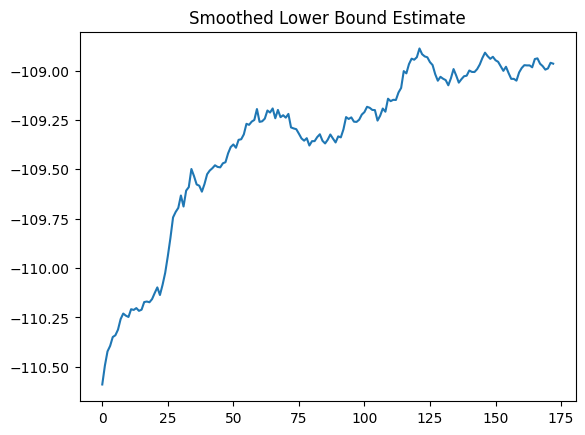

In [ ]:
lb_df = pd.DataFrame(np.array(nn_smoothed_LB_estimate))
plt.figure()
lb_df.plot(title = 'Smoothed Lower Bound Estimate', legend = False)

In [ ]:
best_mu = nn_best_lambda[0]
best_vech_l = list(nn_best_lambda[1])
best_l = np.zeros((num_coeffs, num_coeffs))
for i in range(num_coeffs):
    best_l[i:num_coeffs,i] = best_vech_l[:num_coeffs - i]
    del best_vech_l[:num_coeffs-i]
best_Sigma_inv = best_l @ best_l.T
best_Sigma =  np.linalg.inv(best_Sigma_inv)

best_theta_tilde = multivariate_normal.rvs(mean = best_mu, cov = best_Sigma, size = 1000)
best_alpha = (2 * np.exp(best_theta_tilde[:,0]) + 1) / (1 + np.exp(best_theta_tilde[:,0]))
best_beta = (100 * np.exp(best_theta_tilde[:,1]) + 0) / (1 + np.exp(best_theta_tilde[:,1]))
best_gamma = (0.9 * np.exp(best_theta_tilde[:,2]) + 0) / (1 + np.exp(best_theta_tilde[:,2]))
best_theta = np.array([best_alpha, best_beta, best_gamma])
posterior_mean_estimate = np.mean(best_theta, axis = 1)
posterior_mean_estimate

array([ 1.67309654, 33.20753569,  0.59541459])

In [ ]:
# num_samples = 50000
# num_burnin = 0.2 * num_samples

In [ ]:
# def sampler(samples):

# 	# ------------------- initialize MCMC

# 	w_size = num_coeffs  # num of weights and bias

# 	pos_w = np.ones((samples, w_size))  # posterior of all weights and bias over all samples
# 	pos_w_tilde = np.ones((samples, w_size))

# 	w_tilde = np.array([np.log((1.5-1.1)/(2-1.5)),np.log((0.5+1)/(1-0.5)),np.log(1),0])
# 	# w_tilde = [np.log((actual_summary_statistics[0]-1.1)/(2-actual_summary_statistics[0])), np.log((1+actual_summary_statistics[1])/(1-actual_summary_statistics[1])), np.log(actual_summary_statistics[2]), actual_summary_statistics[3]]

# 	alpha = (2 * np.exp(w_tilde[0]) + 1.1) / (1 + np.exp(w_tilde[0]))
# 	beta = (np.exp(w_tilde[1]) - 1) / (np.exp(w_tilde[1]) + 1)
# 	gamma = np.exp(w_tilde[2])
# 	delta = w_tilde[3]
# 	w = np.array([alpha, beta, gamma, delta])

# 	# GENERATE GAMMA
# 	Gamma_init = np.random.exponential(scale = 0.5, size = (gamma_samples, num_latent))
# 	adjusted_w = np.concatenate((np.tile(w, (gamma_samples, 1)), Gamma_init), axis = 1)
# 	# --------------------- 

# 	prior_current = prior(w_tilde)  # takes care of the gradients

# 	likelihood_current = variance_adjustment_unbiased_log_likelihood(adjusted_w)

# 	naccept = 0
		
# 	for i in range(samples - 1):
# 		if i < 2000:
# 			w_proposal_tilde = multivariate_normal.rvs(mean = w_tilde, cov = ((0.1**2/w_size) * np.identity(w_size)))
# 		else:
# 			if i % 500 == 0:
# 				Sign = np.cov(pos_w_tilde[0:i, :].T)
# 			u_proposal = random.uniform(0, 1)
# 			if u_proposal < 0.05:
# 				w_proposal_tilde = multivariate_normal.rvs(mean = w_tilde, cov = ((0.1**2/w_size) * np.identity(w_size)))
# 			else:
# 				w_proposal_tilde = multivariate_normal.rvs(mean = w_tilde, cov = (2.38**2/w_size) * Sign)

# 		alpha_prop = (2 * np.exp(w_proposal_tilde[0]) + 1.1) / (1 + np.exp(w_proposal_tilde[0]))
# 		beta_prop = (np.exp(w_proposal_tilde[1]) - 1) / (np.exp(w_proposal_tilde[1]) + 1)
# 		gamma_prop = np.exp(w_proposal_tilde[2])
# 		delta_prop = w_proposal_tilde[3]
# 		w_proposal = np.array([alpha_prop, beta_prop, gamma_prop, delta_prop])

# 		# GENERATE GAMMA
# 		Gamma = np.random.exponential(scale = 0.5, size = (gamma_samples, num_latent))
# 		adjusted_w_proposal = np.concatenate((np.tile(w_proposal, (gamma_samples, 1)), Gamma), axis = 1)
# 		# --------------------- 

# 		prior_proposal = prior(w_proposal_tilde)  # takes care of the gradients
# 		likelihood_proposal = variance_adjustment_unbiased_log_likelihood(adjusted_w_proposal)

# 		diff_prior = prior_proposal - prior_current

# 		diff_likelihood = likelihood_proposal - likelihood_current

# 		try:
# 			mh_prob = min(1, math.exp(diff_likelihood+diff_prior))

# 		except OverflowError as e:
# 			mh_prob = 1


# 		u = random.uniform(0, 1)

# 		if u < mh_prob:
# 			# Update position 
# 			naccept += 1
# 			likelihood_current = likelihood_proposal
# 			prior_current = prior_proposal
# 			w_tilde = w_proposal_tilde
# 			w = w_proposal
# 			pos_w_tilde[i + 1,] = w_proposal_tilde	
# 			pos_w[i + 1,] = w_proposal
# 			print(i, pos_w[i + 1,])

# 		else:
# 			pos_w_tilde[i + 1,] = pos_w_tilde[i,]
# 			pos_w[i + 1,] = pos_w[i,]

# 	print(naccept, ' num accepted')
# 	print(naccept / (samples * 1.0) * 100, '% was accepted')
# 	accept_ratio = naccept / (samples * 1.0) * 100

# 	return (pos_w, pos_w_tilde, accept_ratio)

In [ ]:
# pos_w, pos_w_tilde, accept_ratio = sampler(num_samples)

In [ ]:
# pos_w = np.loadtxt('mcmc_w_varobust.txt')
# pos_w_tilde = np.loadtxt('mcmc_w_tilde_varobust.txt')

In [ ]:
# plt.figure()
# pos_alpha_mean = np.mean(pos_w[int(num_burnin):,0])
# pos_alpha_std = np.std(pos_w[int(num_burnin):,0])
# x_plot = np.arange((pos_alpha_mean-4*pos_alpha_std), (pos_alpha_mean+4*pos_alpha_std), 0.001)
# kde = KernelDensity(bandwidth=0.1, kernel='gaussian')
# kde.fit(pos_w[int(num_burnin):,0].reshape(-1, 1))
# y_plot = kde.score_samples(x_plot.reshape(-1, 1))
# plt.plot(x_plot, np.exp(y_plot), '-', linewidth=2.0)
# plt.xlabel(r'$\alpha$')
# plt.title('Posterior density of alpha')

In [ ]:
# plt.figure()
# pos_alpha_mean = np.mean(pos_w[int(num_burnin):,0])
# pos_alpha_std = np.std(pos_w[int(num_burnin):,0])
# #x_plot_mcmc = np.arange((pos_alpha_mean-4*pos_alpha_std), (pos_alpha_mean+4*pos_alpha_std), 0.002)
# x_plot = np.arange(min(pos_alpha_mean-4*pos_alpha_std,np.mean(best_alpha)-4*np.std(best_alpha)), max(pos_alpha_mean+4*pos_alpha_std, np.mean(best_alpha)+4*np.std(best_alpha)), 0.001)
# kde_mcmc = KernelDensity(bandwidth=0.075, kernel='gaussian')
# kde_mcmc.fit(pos_w[int(num_burnin):,0].reshape(-1, 1))
# y_plot_mcmc = kde_mcmc.score_samples(x_plot.reshape(-1, 1))

# #x_plot_vb = np.arange((np.mean(best_alpha)-4*np.std(best_alpha)), (np.mean(best_alpha)+4*np.std(best_alpha)), 0.002)
# kde_vb = KernelDensity(bandwidth=0.155, kernel='gaussian')
# kde_vb.fit(best_alpha.reshape(-1, 1))
# y_plot_vb = kde_vb.score_samples(x_plot.reshape(-1, 1))

# plt.plot(x_plot, np.exp(y_plot_mcmc), '-', linewidth=2.0, label = 'MCMC')
# plt.plot(x_plot, np.exp(y_plot_vb), '-', linewidth=2.0, label = 'VB')

# plt.legend()
# plt.xlabel(r'$\alpha$')
# plt.title('Posterior density of alpha')


In [ ]:
# plt.figure()

# pos_beta_mean = np.mean(pos_w[int(num_burnin):,1])
# pos_beta_std = np.std(pos_w[int(num_burnin):,1])
# x_plot = np.arange((pos_beta_mean-4*pos_beta_std), (pos_beta_mean+4*pos_beta_std), 0.001)
# kde = KernelDensity(bandwidth=0.1, kernel='gaussian')
# kde.fit(pos_w[int(num_burnin):,1].reshape(-1, 1))
# y_plot = kde.score_samples(x_plot.reshape(-1, 1))
# plt.plot(x_plot, np.exp(y_plot), '-', linewidth=2.0)
# plt.xlabel(r'$\beta$')
# plt.title('Posterior density of beta')

In [ ]:
# plt.figure()
# pos_beta_mean = np.mean(pos_w[int(num_burnin):,1])
# pos_beta_std = np.std(pos_w[int(num_burnin):,1])
# #x_plot_mcmc = np.arange((pos_alpha_mean-4*pos_alpha_std), (pos_alpha_mean+4*pos_alpha_std), 0.002)
# x_plot = np.arange(min(pos_beta_mean-4*pos_beta_std,np.mean(best_beta)-4*np.std(best_beta)), max(pos_beta_mean+4*pos_beta_std, np.mean(best_beta)+4*np.std(best_beta)), 0.001)
# kde_mcmc = KernelDensity(bandwidth=0.1, kernel='gaussian')
# kde_mcmc.fit(pos_w[int(num_burnin):,1].reshape(-1, 1))
# y_plot_mcmc = kde_mcmc.score_samples(x_plot.reshape(-1, 1))

# #x_plot_vb = np.arange((np.mean(best_alpha)-4*np.std(best_alpha)), (np.mean(best_alpha)+4*np.std(best_alpha)), 0.002)
# kde_vb = KernelDensity(bandwidth=0.35, kernel='gaussian')
# kde_vb.fit(best_beta.reshape(-1, 1))
# y_plot_vb = kde_vb.score_samples(x_plot.reshape(-1, 1))

# plt.plot(x_plot, np.exp(y_plot_mcmc), '-', linewidth=2.0, label = 'MCMC')
# plt.plot(x_plot, np.exp(y_plot_vb), '-', linewidth=2.0, label = 'VB')

# plt.legend()
# plt.xlabel(r'$\beta$')
# plt.title('Posterior density of beta')


In [ ]:
# plt.figure()

# pos_gamma_mean = np.mean(pos_w[int(num_burnin):,2])
# pos_gamma_std = np.std(pos_w[int(num_burnin):,2])
# x_plot = np.arange((pos_gamma_mean-4*pos_gamma_std), (pos_gamma_mean+4*pos_gamma_std), 0.002)
# kde = KernelDensity(bandwidth=0.02, kernel='gaussian')
# kde.fit(pos_w[int(num_burnin):,2].reshape(-1, 1))
# y_plot = kde.score_samples(x_plot.reshape(-1, 1))
# plt.plot(x_plot, np.exp(y_plot), '-', linewidth=2.0)
# plt.xlabel(r'$\gamma$')
# plt.title('Posterior density of gamma')

In [ ]:
# plt.figure()
# pos_gamma_mean = np.mean(pos_w[int(num_burnin):,2])
# pos_gamma_std = np.std(pos_w[int(num_burnin):,2])
# #x_plot_mcmc = np.arange((pos_alpha_mean-4*pos_alpha_std), (pos_alpha_mean+4*pos_alpha_std), 0.002)
# x_plot = np.arange(min(pos_gamma_mean-4*pos_gamma_std,np.mean(best_gamma)-4*np.std(best_gamma)), max(pos_gamma_mean+4*pos_gamma_std, np.mean(best_gamma)+4*np.std(best_gamma)), 0.001)
# kde_mcmc = KernelDensity(bandwidth=0.0375, kernel='gaussian')
# kde_mcmc.fit(pos_w[int(num_burnin):,2].reshape(-1, 1))
# y_plot_mcmc = kde_mcmc.score_samples(x_plot.reshape(-1, 1))

# #x_plot_vb = np.arange((np.mean(best_alpha)-4*np.std(best_alpha)), (np.mean(best_alpha)+4*np.std(best_alpha)), 0.002)
# kde_vb = KernelDensity(bandwidth=0.025, kernel='gaussian')
# kde_vb.fit(best_gamma.reshape(-1, 1))
# y_plot_vb = kde_vb.score_samples(x_plot.reshape(-1, 1))

# plt.plot(x_plot, np.exp(y_plot_mcmc), '-', linewidth=2.0, label = 'MCMC')
# plt.plot(x_plot, np.exp(y_plot_vb), '-', linewidth=2.0, label = 'VB')

# plt.legend()
# plt.xlabel(r'$\gamma$')
# plt.title('Posterior density of gamma')


In [ ]:
# alpha_trace = pos_w[int(num_burnin):,0]
# beta_trace = pos_w[int(num_burnin):,1]
# gamma_trace = pos_w[int(num_burnin):,2]
# delta_trace = pos_w[int(num_burnin):,3]

# x = np.arange(len(alpha_trace))
# plt.figure(facecolor = 'white')
# plt.plot(x, alpha_trace, label='Alpha')  
# plt.plot(x, beta_trace, label='Beta')  
# plt.plot(x, gamma_trace, label='Gamma')  
# plt.xlabel('Number of samples')
# plt.ylabel('Theta')
# plt.legend()
# plt.title("Trace Plot for Theta")
# plt.show()